In [ ]:
!pip3 install optuna==0.14.0
!pip install fastparquet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 91 kB 3.1 MB/s 
     |████████████████████████████████| 81 kB 6.2 MB/s 
     |████████████████████████████████| 209 kB 43.5 MB/s 
     |████████████████████████████████| 78 kB 6.0 MB/s 
     |████████████████████████████████| 78 kB 7.0 MB/s 
     |████████████████████████████████| 147 kB 65.3 MB/s 
     |████████████████████████████████| 112 kB 62.0 MB/s 
     |████████████████████████████████| 50 kB 5.8 MB/s 
  Created wheel for optuna: filename=optuna-0.14.0-py3-none-any.whl size=125709 sha256=c30b0f03953706b7512631298988110db5a889d3e2f854961e61e556d95926c8
  Stored in directory: /root/.cache/pip/wheels/c1/41/64/03b183676c5d5e978de160cab6268d5b4fb095dff63f720e01
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=3a6076015077cebc4f373c611f3cfec7933fea1125eb3f9133d1146128dfcfae
  Stored in directory: /root/.ca

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 5.0 MB/s 
     |████████████████████████████████| 1.6 MB 56.0 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf

from keras.datasets import mnist
from keras.models import Sequential,Model
from keras.layers import Activation, Flatten, Dense, Conv2D, Conv1D,Input
from keras.layers import MaxPooling1D, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adagrad, RMSprop, Adam, Adadelta, Adamax, Nadam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from keras.layers.core import *
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import keras.backend as K
import optuna
import math
import random
from copy import deepcopy
from sklearn.utils import shuffle

from scipy.stats import sem
from numpy import mean
from numpy import std
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

In [ ]:
print('Keras', keras.__version__)
print('TensorFlow', tf.__version__)
# import Optuna and OptKeras after Keras
print('Optuna', optuna.__version__)

Keras 2.9.0
TensorFlow 2.9.2
Optuna 0.14.0


In [ ]:
train_df = pd.read_parquet("/content/drive/MyDrive/New Data/35features/100K35F_train_main.parquet.snappy",engine='fastparquet')
val_df = pd.read_parquet("/content/drive/MyDrive/New Data/35features/100K35F_val_main.parquet.snappy",engine='fastparquet')
test_df = pd.read_parquet("/content/drive/MyDrive/New Data/35features/100K35F_test_main.parquet.snappy",engine='fastparquet')

In [ ]:
train_df

,r_id,r_stars,r_stars_square,r_length,u_friends_count,u_review_count,u_month_age,u_comp_avg,u_n_elite_yrs,u_fans,...,r_stopwords/words,r_digit_cnt,r_noun_cnt,r_Adj_cnt,r_Adv_cnt,r_capital_word_cnt,r_quoted_word_cnt,r_hashtag_cnt,r_exclam_cnt,r_useful
0,2486117,5,25,41,1,8,35.657224,0.000000,0,0,...,0.46,2,8,3,2,1,0,0,0,2
1,3238107,5,25,64,174,247,1.024218,0.222672,5,27,...,0.35,1,13,5,2,4,0,0,2,2
2,5581800,5,25,239,525,603,125.863690,2.844113,12,57,...,0.41,2,53,16,20,8,0,0,1,3
3,5953680,4,16,129,130,183,129.975625,2.005464,5,26,...,0.46,0,32,12,6,2,0,0,0,4
4,2208283,1,1,537,223,1,0.000111,1.000000,0,0,...,0.47,2,93,23,42,26,0,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,2065766,2,4,61,165,108,0.640257,0.046296,0,2,...,0.41,0,10,4,5,5,0,0,1,2
79996,4640630,4,16,74,78,467,47.038862,0.353319,6,35,...,0.45,0,18,9,2,3,0,0,1,2
79997,4218981,5,25,98,12,88,79.607721,0.295455,2,5,...,0.34,0,28,7,7,3,0,0,1,2
79998,4633311,4,16,656,173,206,41.955031,0.626214,4,13,...,0.43,2,117,39,61,35,0,0,7,6


In [ ]:
training_withaim=train_df.drop(labels="r_id", axis=1)
valing_withaim=val_df.drop(labels="r_id",axis=1)
testing_withaim=test_df.drop(labels="r_id", axis=1)

#Check the NaN in data and drop them
imp_train=SimpleImputer(missing_values=np.NaN)
training=pd.DataFrame(imp_train.fit_transform(training_withaim))

imp_test=SimpleImputer(missing_values=np.NaN)
testing=pd.DataFrame(imp_test.fit_transform(testing_withaim))

imp_val=SimpleImputer(missing_values=np.NaN)
valing=pd.DataFrame(imp_val.fit_transform(valing_withaim))

# There aren't any nan data in the dataframe 
training = training.iloc[: , 0:35]
testing = testing.iloc[: , 0:35]
valing=valing.iloc[:,0:35]
scaler = StandardScaler()

# scale skewed features
std_train_df = train_df.copy(deep=True)
std_train_df = scaler.fit_transform(training)
std_test_df = test_df.copy(deep=True)
std_test_df = scaler.transform(testing)
std_val_df = val_df.copy(deep=True)
std_val_df = scaler.transform(valing)
#std_test_df[['r_stars','r_stars_square','r_length', 'u_friends_count', 'u_review_count', 'u_month_age', 'b_stars','b_review_count','r_rea']] = scaler.transform(test_df[['r_stars','r_stars_square','r_length', 'u_friends_count', 'u_review_count', 'u_month_age', 'b_stars','b_review_count','r_rea']])

std_train_df = pd.DataFrame(std_train_df)
std_val_df = pd.DataFrame(std_val_df)
std_test_df = pd.DataFrame(std_test_df)

training = std_train_df.iloc[: , 0:36]
valing = std_val_df.iloc[: , 0:36]
testing = std_test_df.iloc[: , 0:36]

labelsForTrain=training_withaim.iloc[: , -1]
labelsForVal=valing_withaim.iloc[: , -1]
labelsForTest=testing_withaim.iloc[: , -1]
input_shape = training.shape

In [ ]:
labelsForTrain

0        2
1        2
2        3
3        4
4        6
        ..
79995    2
79996    2
79997    2
79998    6
79999    2
Name: r_useful, Length: 80000, dtype: int64

In [ ]:
training

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,0.902431,0.996586,-0.805509,-0.329454,-0.380837,-0.205818,-0.188112,-0.609417,-0.167995,1.408241,...,1.009502,0.729169,1.198104,-0.797991,-0.916574,-0.879018,-0.602286,-0.036305,-0.012863,-0.565147
1,0.902431,0.996586,-0.603075,-0.026023,0.120685,-1.203206,-0.110662,1.019071,0.012418,0.583210,...,0.361877,-1.005015,0.350241,-0.567289,-0.699387,-0.879018,-0.069673,-0.036305,-0.012863,0.222741
2,0.902431,0.996586,0.937184,0.589607,0.867722,2.392019,0.801132,3.298953,0.212877,0.534678,...,-1.025892,-0.059096,1.198104,1.278321,0.495144,1.127443,0.640479,-0.036305,-0.012863,-0.171203
3,0.253649,0.062198,-0.030979,-0.103196,-0.013614,2.510438,0.509432,1.019071,0.005736,-0.084095,...,-1.488482,0.729169,-0.497621,0.309376,0.060769,-0.433138,-0.424748,-0.036305,-0.012863,-0.565147
4,-1.692696,-1.495115,3.560026,0.059919,-0.395526,-1.232699,0.159709,-0.609417,-0.167995,-3.299292,...,-2.691215,0.886823,1.198104,3.123932,1.255300,3.579784,3.836160,-0.036305,-0.012863,-0.565147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,-1.043914,-1.183653,-0.629480,-0.041809,-0.170995,-1.214264,-0.172010,-0.609417,-0.154631,-0.241822,...,0.361877,-0.059096,-0.497621,-0.705710,-0.807980,-0.544608,0.107865,-0.036305,-0.012863,-0.171203
79996,0.253649,0.062198,-0.515060,-0.194401,0.582337,0.121960,-0.065220,1.344768,0.065874,-0.023431,...,0.454395,0.571516,-0.497621,-0.336588,-0.265012,-0.879018,-0.247210,-0.036305,-0.012863,-0.171203
79997,0.902431,0.996586,-0.303825,-0.310161,-0.212964,1.059903,-0.085347,0.041978,-0.134585,0.316288,...,0.269359,-1.162668,-0.497621,0.124815,-0.482199,-0.321668,-0.247210,-0.036305,-0.012863,-0.171203
79998,0.253649,0.062198,4.607402,-0.027777,0.034650,-0.024449,0.029698,0.693373,-0.081129,0.619608,...,-2.136107,0.256210,1.198104,4.231298,2.992799,5.697715,5.434001,-0.036305,-0.012863,2.192459


In [ ]:
def create_model(activation, num_hidden_layer, num_hidden_unit):
  inputs = Input(shape=(training.shape[1],))
  model = inputs
  for i in range(1,num_hidden_layer):
    model = Dense(num_hidden_unit, activation=activation,)(model)
        
        
  model = Dense(1,)(model)
  model = Model(inputs, model)

  return model

In [ ]:
kfold = KFold(n_splits=5, shuffle=True)
def objective(trial:optuna.Trial,data_train,result_train):
  K.clear_session()
    
  activation = trial.suggest_categorical('activation',['relu','tanh','linear'])
  #Leave fewer optimizer
    
  num_hidden_layer = trial.suggest_int('num_hidden_layer',2,4)
  #get more features per layer, add num of hidden unit if have time

  #define the number of unit with 2^n
  i = trial.suggest_int('i',6,10)
  num_hidden_unit = 2**i
  
  #Try to adjust learning_rate

  learning_rate = trial.suggest_loguniform('learning_rate', 0.0001,0.01)
  
  # Gradient Clipping

  optimizer = Adam(learning_rate=learning_rate,clipnorm=1.0)
    
  num_folds = 3

  loss_per_fold = []
  es = EarlyStopping(monitor='val_mse', patience=5)

  model = create_model(activation,num_hidden_layer,num_hidden_unit)
  model_list.append(model)
  model.compile(loss='mse',optimizer=optimizer,metrics=['mse','mae'])
  #learning scheduler
  reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.2,
                              patience=5, min_lr=0.001)
  fold_no=1
      # Fit data to model
  score_int=[]

  for train,test in kfold.split(data_train,result_train):

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    new_train_CV=data_train.iloc[train]
    new_label=result_train.iloc[train]

    val_CV=data_train.iloc[test]
    val_result=result_train.iloc[test]

    # Fit data to model
    history = model.fit(new_train_CV,new_label,
                batch_size=64,
                epochs=100,
                verbose=2,
                validation_data=(val_CV,val_result),
                validation_batch_size=64,
                callbacks=[es,reduce_lr])
    
    scores=model.evaluate(val_CV,val_result,verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}')
    loss_per_fold.append(scores[0])
    # Increase fold number
    score_int.append(round(scores[1],2))
    fold_no = fold_no + 1  
    
  mse = np.array(history.history['mse'])

  #loss_per_fold.append(scores[0])

  history_list.append(history)
  return np.mean(score_int)

In [ ]:
model_list=[]
history_list=[]
study_name = 'NN_study'
study = optuna.create_study(study_name=study_name, load_if_exists=True)
func = lambda trial: objective(trial,training,labelsForTrain)
study.optimize(func, n_trials=50,)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 2s - loss: 14.8704 - mse: 14.8704 - mae: 1.6258 - val_loss: 13.2813 - val_mse: 13.2813 - val_mae: 1.5626 - lr: 0.0012 - 2s/epoch - 2ms/step
Epoch 2/100
1000/1000 - 2s - loss: 13.2753 - mse: 13.2753 - mae: 1.5576 - val_loss: 13.2724 - val_mse: 13.2724 - val_mae: 1.5540 - lr: 0.0012 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 13.3046 - mse: 13.3046 - mae: 1.5554 - val_loss: 13.2669 - val_mse: 13.2669 - val_mae: 1.5321 - lr: 0.0012 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 13.3289 - mse: 13.3289 - mae: 1.5515 - val_loss: 13.0617 - val_mse: 13.0617 - val_mae: 1.5443 - lr: 0.0012 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 13.3160 - mse: 13.3160 - mae: 1.5527 - val_loss: 13.0665 - val_mse: 13.0665 - val_mae: 1.5413 - lr: 0.0012 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 13.3394 - mse: 13.3394 - mae: 1.5474 - val_loss:

[I 2022-10-11 10:27:08,761] Finished trial#0 resulted in value: 13.228. Current best value is 13.228 with parameters: {'activation': 'linear', 'num_hidden_layer': 2, 'i': 6, 'learning_rate': 0.0012023809405782575}.


Score for fold 5: loss of 13.849413871765137
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 15.0915 - mse: 15.0915 - mae: 1.6374 - val_loss: 10.7218 - val_mse: 10.7218 - val_mae: 1.6433 - lr: 6.6993e-04 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 3s - loss: 14.1508 - mse: 14.1508 - mae: 1.5631 - val_loss: 10.7670 - val_mse: 10.7670 - val_mae: 1.5193 - lr: 6.6993e-04 - 3s/epoch - 3ms/step
Epoch 3/100
1000/1000 - 3s - loss: 14.0885 - mse: 14.0885 - mae: 1.5565 - val_loss: 10.6908 - val_mse: 10.6908 - val_mae: 1.5662 - lr: 6.6993e-04 - 3s/epoch - 3ms/step
Epoch 4/100
1000/1000 - 3s - loss: 14.1342 - mse: 14.1342 - mae: 1.5568 - val_loss: 10.6253 - val_mse: 10.6253 - val_mae: 1.5569 - lr: 6.6993e-04 - 3s/epoch - 3ms/step
Epoch 5/100
1000/1000 - 3s - loss: 14.1243 - mse: 14.1243 - mae: 1.5526 - val_loss: 10.8727 - val_mse: 10.8727 - val_mae: 1.5630 - lr: 6.6993e-04 - 3s/epoch - 3ms/step
Epoch 6/100
1000/1

[I 2022-10-11 10:30:39,906] Finished trial#1 resulted in value: 13.232. Current best value is 13.228 with parameters: {'activation': 'linear', 'num_hidden_layer': 2, 'i': 6, 'learning_rate': 0.0012023809405782575}.


Score for fold 5: loss of 11.624039649963379
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 15.3855 - mse: 15.3855 - mae: 1.6047 - val_loss: 10.4450 - val_mse: 10.4450 - val_mae: 1.5019 - lr: 6.9620e-04 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 3s - loss: 14.5670 - mse: 14.5670 - mae: 1.5341 - val_loss: 10.2372 - val_mse: 10.2372 - val_mae: 1.5526 - lr: 6.9620e-04 - 3s/epoch - 3ms/step
Epoch 3/100
1000/1000 - 3s - loss: 14.3467 - mse: 14.3467 - mae: 1.5245 - val_loss: 10.1095 - val_mse: 10.1095 - val_mae: 1.5104 - lr: 6.9620e-04 - 3s/epoch - 3ms/step
Epoch 4/100
1000/1000 - 3s - loss: 14.1048 - mse: 14.1048 - mae: 1.5072 - val_loss: 10.0609 - val_mse: 10.0609 - val_mae: 1.5479 - lr: 6.9620e-04 - 3s/epoch - 3ms/step
Epoch 5/100
1000/1000 - 3s - loss: 13.9526 - mse: 13.9526 - mae: 1.5001 - val_loss: 9.9188 - val_mse: 9.9188 - val_mae: 1.5252 - lr: 6.9620e-04 - 3s/epoch - 3ms/step
Epoch 6/100
1000/100

[I 2022-10-11 10:33:16,068] Finished trial#2 resulted in value: 10.748000000000001. Current best value is 10.748000000000001 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 8, 'learning_rate': 0.0006962014347671436}.


Score for fold 5: loss of 8.629791259765625
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 6s - loss: 13.6913 - mse: 13.6913 - mae: 1.5395 - val_loss: 11.8341 - val_mse: 11.8341 - val_mae: 1.6061 - lr: 2.3072e-04 - 6s/epoch - 6ms/step
Epoch 2/100
1000/1000 - 5s - loss: 12.7220 - mse: 12.7220 - mae: 1.4859 - val_loss: 10.5679 - val_mse: 10.5679 - val_mae: 1.4652 - lr: 2.3072e-04 - 5s/epoch - 5ms/step
Epoch 3/100
1000/1000 - 5s - loss: 12.4872 - mse: 12.4872 - mae: 1.4672 - val_loss: 11.1449 - val_mse: 11.1449 - val_mae: 1.4817 - lr: 2.3072e-04 - 5s/epoch - 5ms/step
Epoch 4/100
1000/1000 - 5s - loss: 12.3252 - mse: 12.3252 - mae: 1.4562 - val_loss: 11.8559 - val_mse: 11.8559 - val_mae: 1.5353 - lr: 2.3072e-04 - 5s/epoch - 5ms/step
Epoch 5/100
1000/1000 - 6s - loss: 12.2618 - mse: 12.2618 - mae: 1.4458 - val_loss: 12.1506 - val_mse: 12.1506 - val_mae: 1.4459 - lr: 2.3072e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/10

[I 2022-10-11 10:37:14,617] Finished trial#3 resulted in value: 9.334. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 13.074200630187988
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 11s - loss: 12.0086 - mse: 12.0086 - mae: 1.5815 - val_loss: 20.3423 - val_mse: 20.3423 - val_mae: 1.5459 - lr: 0.0026 - 11s/epoch - 11ms/step
Epoch 2/100
1000/1000 - 11s - loss: 11.0923 - mse: 11.0923 - mae: 1.5347 - val_loss: 19.5553 - val_mse: 19.5553 - val_mae: 1.6012 - lr: 0.0026 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 10.9302 - mse: 10.9302 - mae: 1.5240 - val_loss: 18.4318 - val_mse: 18.4318 - val_mae: 1.5139 - lr: 0.0026 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 10s - loss: 10.9329 - mse: 10.9329 - mae: 1.5206 - val_loss: 19.2247 - val_mse: 19.2247 - val_mae: 1.5398 - lr: 0.0026 - 10s/epoch - 10ms/step
Epoch 5/100
1000/1000 - 10s - loss: 10.8006 - mse: 10.8006 - mae: 1.5220 - val_loss: 19.2983 - val_mse: 19.2983 - val_mae: 1.4759 - lr: 0.0026 - 10s/epoch - 10ms/step
Epoch 6/100
1000/1000 -

[I 2022-10-11 10:44:29,455] Finished trial#4 resulted in value: 10.564. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 5.687545299530029
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 15.3547 - mse: 15.3547 - mae: 1.6333 - val_loss: 10.4131 - val_mse: 10.4131 - val_mae: 1.4679 - lr: 0.0012 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 4s - loss: 14.7120 - mse: 14.7120 - mae: 1.5593 - val_loss: 10.5226 - val_mse: 10.5226 - val_mae: 1.5807 - lr: 0.0012 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 14.5254 - mse: 14.5254 - mae: 1.5500 - val_loss: 10.2959 - val_mse: 10.2959 - val_mae: 1.5557 - lr: 0.0012 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 14.3186 - mse: 14.3186 - mae: 1.5379 - val_loss: 10.0572 - val_mse: 10.0572 - val_mae: 1.5003 - lr: 0.0012 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 14.1013 - mse: 14.1013 - mae: 1.5283 - val_loss: 9.7978 - val_mse: 9.7978 - val_mae: 1.4161 - lr: 0.0012 - 4s/epoch - 4ms/step
Epoch 6/100
1000/1000 - 4s - loss: 13.990

[I 2022-10-11 10:47:59,406] Finished trial#5 resulted in value: 11.572. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 10.053594589233398
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 14.1396 - mse: 14.1396 - mae: 1.5602 - val_loss: 9.4856 - val_mse: 9.4856 - val_mae: 1.5444 - lr: 0.0025 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 13.0829 - mse: 13.0829 - mae: 1.5008 - val_loss: 9.6225 - val_mse: 9.6225 - val_mae: 1.4640 - lr: 0.0025 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 7s - loss: 13.0361 - mse: 13.0361 - mae: 1.4859 - val_loss: 9.4929 - val_mse: 9.4929 - val_mae: 1.5383 - lr: 0.0025 - 7s/epoch - 7ms/step
Epoch 4/100
1000/1000 - 7s - loss: 13.0766 - mse: 13.0766 - mae: 1.4690 - val_loss: 9.2526 - val_mse: 9.2526 - val_mae: 1.4310 - lr: 0.0025 - 7s/epoch - 7ms/step
Epoch 5/100
1000/1000 - 7s - loss: 12.9811 - mse: 12.9811 - mae: 1.4676 - val_loss: 9.7439 - val_mse: 9.7439 - val_mae: 1.6095 - lr: 0.0025 - 7s/epoch - 7ms/step
Epoch 6/100
1000/1000 - 7s - loss: 12.7629 - mse

[I 2022-10-11 10:52:36,432] Finished trial#6 resulted in value: 11.069999999999999. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 14.075221061706543
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 14.2504 - mse: 14.2504 - mae: 1.6128 - val_loss: 14.0697 - val_mse: 14.0697 - val_mae: 1.5552 - lr: 5.8987e-04 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 13.1531 - mse: 13.1531 - mae: 1.5647 - val_loss: 14.1178 - val_mse: 14.1178 - val_mae: 1.5529 - lr: 5.8987e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 13.2047 - mse: 13.2047 - mae: 1.5577 - val_loss: 14.0560 - val_mse: 14.0560 - val_mae: 1.5277 - lr: 5.8987e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 13.1099 - mse: 13.1099 - mae: 1.5511 - val_loss: 13.8678 - val_mse: 13.8678 - val_mae: 1.5715 - lr: 5.8987e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 13.0573 - mse: 13.0573 - mae: 1.5569 - val_loss: 13.9715 - val_mse: 13.9715 - val_mae: 1.5547 - lr: 5.8987e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1

[I 2022-10-11 10:54:39,417] Finished trial#7 resulted in value: 13.285999999999998. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 19.79832649230957
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 6s - loss: 12.3183 - mse: 12.3183 - mae: 1.5358 - val_loss: 16.7669 - val_mse: 16.7669 - val_mae: 1.5131 - lr: 3.1729e-04 - 6s/epoch - 6ms/step
Epoch 2/100
1000/1000 - 6s - loss: 11.3651 - mse: 11.3651 - mae: 1.4847 - val_loss: 16.5348 - val_mse: 16.5348 - val_mae: 1.4944 - lr: 3.1729e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 11.2229 - mse: 11.2229 - mae: 1.4774 - val_loss: 16.8629 - val_mse: 16.8629 - val_mae: 1.4349 - lr: 3.1729e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 10.8657 - mse: 10.8657 - mae: 1.4607 - val_loss: 16.8664 - val_mse: 16.8664 - val_mae: 1.4768 - lr: 3.1729e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 10.6968 - mse: 10.6968 - mae: 1.4481 - val_loss: 16.5384 - val_mse: 16.5384 - val_mae: 1.4302 - lr: 3.1729e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/10

[I 2022-10-11 10:58:37,945] Finished trial#8 resulted in value: 10.657999999999998. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 2s - loss: 16.6195 - mse: 16.6195 - mae: 1.7684 - val_loss: 10.7148 - val_mse: 10.7148 - val_mae: 1.5480 - lr: 2.0494e-04 - 2s/epoch - 2ms/step
Epoch 2/100
1000/1000 - 2s - loss: 13.9846 - mse: 13.9846 - mae: 1.5561 - val_loss: 10.5603 - val_mse: 10.5603 - val_mae: 1.5335 - lr: 2.0494e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 1s - loss: 13.9042 - mse: 13.9042 - mae: 1.5520 - val_loss: 10.4740 - val_mse: 10.4740 - val_mae: 1.5224 - lr: 2.0494e-04 - 1s/epoch - 1ms/step
Epoch 4/100
1000/1000 - 1s - loss: 13.9211 - mse: 13.9211 - mae: 1.5478 - val_loss: 10.4858 - val_mse: 10.4858 - val_mae: 1.5267 - lr: 2.0494e-04 - 1s/epoch - 1ms/step
Epoch 5/100
1000/1000 - 1s - loss: 13.8878 - mse: 13.8878 - mae: 1.5469 - val_loss: 10.5191 - val_mse: 10.5191 - val_mae: 1.5642 - lr: 2.0494e-04 - 1s/epoch - 1ms/step
Epoch 6/100
1000/1000 - 1s - loss: 13.8881 - mse: 13.8881 - mae

[I 2022-10-11 10:59:43,716] Finished trial#9 resulted in value: 13.256. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 9.59223461151123
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 12.2538 - mse: 12.2538 - mae: 1.5929 - val_loss: 18.6373 - val_mse: 18.6373 - val_mae: 1.5012 - lr: 0.0086 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 3s - loss: 11.4549 - mse: 11.4549 - mae: 1.5373 - val_loss: 18.1190 - val_mse: 18.1190 - val_mae: 1.4944 - lr: 0.0086 - 3s/epoch - 3ms/step
Epoch 3/100
1000/1000 - 3s - loss: 11.1087 - mse: 11.1087 - mae: 1.5218 - val_loss: 17.9011 - val_mse: 17.9011 - val_mae: 1.4947 - lr: 0.0086 - 3s/epoch - 3ms/step
Epoch 4/100
1000/1000 - 3s - loss: 10.8121 - mse: 10.8121 - mae: 1.5096 - val_loss: 18.1076 - val_mse: 18.1076 - val_mae: 1.5153 - lr: 0.0086 - 3s/epoch - 3ms/step
Epoch 5/100
1000/1000 - 3s - loss: 11.0548 - mse: 11.0548 - mae: 1.5131 - val_loss: 18.0707 - val_mse: 18.0707 - val_mae: 1.4866 - lr: 0.0086 - 3s/epoch - 3ms/step
Epoch 6/100
1000/1000 - 4s - loss: 11.32

[I 2022-10-11 11:02:15,493] Finished trial#10 resulted in value: 12.604. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 8.457393646240234
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 11s - loss: 14.3310 - mse: 14.3310 - mae: 1.6199 - val_loss: 11.8930 - val_mse: 11.8930 - val_mae: 1.6624 - lr: 0.0043 - 11s/epoch - 11ms/step
Epoch 2/100
1000/1000 - 10s - loss: 13.3176 - mse: 13.3176 - mae: 1.5404 - val_loss: 11.1453 - val_mse: 11.1453 - val_mae: 1.5167 - lr: 0.0043 - 10s/epoch - 10ms/step
Epoch 3/100
1000/1000 - 11s - loss: 12.7411 - mse: 12.7411 - mae: 1.5174 - val_loss: 10.9776 - val_mse: 10.9776 - val_mae: 1.6037 - lr: 0.0043 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 10s - loss: 12.8132 - mse: 12.8132 - mae: 1.5185 - val_loss: 11.3446 - val_mse: 11.3446 - val_mae: 1.4965 - lr: 0.0043 - 10s/epoch - 10ms/step
Epoch 5/100
1000/1000 - 11s - loss: 13.0166 - mse: 13.0166 - mae: 1.5383 - val_loss: 11.0961 - val_mse: 11.0961 - val_mae: 1.5838 - lr: 0.0043 - 11s/epoch - 11ms/step
Epoch 6/100
1000/1000 - 

[I 2022-10-11 11:10:44,466] Finished trial#11 resulted in value: 12.526. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 8.99890422821045
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 12.0408 - mse: 12.0408 - mae: 1.5348 - val_loss: 18.5255 - val_mse: 18.5255 - val_mae: 1.4972 - lr: 1.2814e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 10.9316 - mse: 10.9316 - mae: 1.4750 - val_loss: 18.2397 - val_mse: 18.2397 - val_mae: 1.5347 - lr: 1.2814e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 10.7623 - mse: 10.7623 - mae: 1.4576 - val_loss: 18.2457 - val_mse: 18.2457 - val_mae: 1.5051 - lr: 1.2814e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 10.4801 - mse: 10.4801 - mae: 1.4496 - val_loss: 18.0966 - val_mse: 18.0966 - val_mae: 1.4894 - lr: 1.2814e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 10.4694 - mse: 10.4694 - mae: 1.4373 - val_loss: 17.9811 - val_mse: 17.9811 - val_mae: 1.5320 - lr: 1.2814e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/100

[I 2022-10-11 11:14:54,658] Finished trial#12 resulted in value: 10.918. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 9.895682334899902
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 11s - loss: 14.6980 - mse: 14.6980 - mae: 1.5903 - val_loss: 8.1824 - val_mse: 8.1824 - val_mae: 1.4880 - lr: 0.0025 - 11s/epoch - 11ms/step
Epoch 2/100
1000/1000 - 11s - loss: 14.0773 - mse: 14.0773 - mae: 1.5266 - val_loss: 9.4640 - val_mse: 9.4640 - val_mae: 1.5342 - lr: 0.0025 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 13.8432 - mse: 13.8432 - mae: 1.5200 - val_loss: 8.3326 - val_mse: 8.3326 - val_mae: 1.6126 - lr: 0.0025 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 14.1218 - mse: 14.1218 - mae: 1.5056 - val_loss: 8.1168 - val_mse: 8.1168 - val_mae: 1.4234 - lr: 0.0025 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 13.7025 - mse: 13.7025 - mae: 1.4877 - val_loss: 7.7057 - val_mse: 7.7057 - val_mae: 1.4654 - lr: 0.0025 - 11s/epoch - 11ms/step
Epoch 6/100
1000/1000 - 11s - loss

[I 2022-10-11 11:23:06,768] Finished trial#13 resulted in value: 10.187999999999999. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 12.632806777954102
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 5s - loss: 11.1544 - mse: 11.1544 - mae: 1.5377 - val_loss: 23.3651 - val_mse: 23.3651 - val_mae: 1.5674 - lr: 1.0200e-04 - 5s/epoch - 5ms/step
Epoch 2/100
1000/1000 - 4s - loss: 10.1886 - mse: 10.1886 - mae: 1.4902 - val_loss: 22.9152 - val_mse: 22.9152 - val_mae: 1.5450 - lr: 1.0200e-04 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 9.8533 - mse: 9.8533 - mae: 1.4676 - val_loss: 22.4743 - val_mse: 22.4743 - val_mae: 1.5241 - lr: 1.0200e-04 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 9.5885 - mse: 9.5885 - mae: 1.4581 - val_loss: 22.3426 - val_mse: 22.3426 - val_mae: 1.5637 - lr: 1.0200e-04 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 9.5498 - mse: 9.5498 - mae: 1.4481 - val_loss: 22.2381 - val_mse: 22.2381 - val_mae: 1.5570 - lr: 1.0200e-04 - 4s/epoch - 4ms/step
Epoch 6/100
1000/1000 - 

[I 2022-10-11 11:26:27,521] Finished trial#14 resulted in value: 11.45. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 6.6710028648376465
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 14.9310 - mse: 14.9310 - mae: 1.6120 - val_loss: 9.0434 - val_mse: 9.0434 - val_mae: 1.6112 - lr: 0.0080 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 3s - loss: 13.8695 - mse: 13.8695 - mae: 1.5521 - val_loss: 8.7537 - val_mse: 8.7537 - val_mae: 1.4362 - lr: 0.0080 - 3s/epoch - 3ms/step
Epoch 3/100
1000/1000 - 3s - loss: 13.4411 - mse: 13.4411 - mae: 1.5341 - val_loss: 8.6773 - val_mse: 8.6773 - val_mae: 1.4722 - lr: 0.0080 - 3s/epoch - 3ms/step
Epoch 4/100
1000/1000 - 3s - loss: 13.5000 - mse: 13.5000 - mae: 1.5319 - val_loss: 8.6048 - val_mse: 8.6048 - val_mae: 1.4536 - lr: 0.0080 - 3s/epoch - 3ms/step
Epoch 5/100
1000/1000 - 3s - loss: 13.5973 - mse: 13.5973 - mae: 1.5237 - val_loss: 8.6827 - val_mse: 8.6827 - val_mae: 1.4751 - lr: 0.0080 - 3s/epoch - 3ms/step
Epoch 6/100
1000/1000 - 3s - loss: 14.1619 - mse

[I 2022-10-11 11:29:23,737] Finished trial#15 resulted in value: 11.742. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 8.308334350585938
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 13.6614 - mse: 13.6614 - mae: 1.5920 - val_loss: 18.0379 - val_mse: 18.0379 - val_mae: 1.5656 - lr: 0.0023 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 12.8729 - mse: 12.8729 - mae: 1.5370 - val_loss: 17.6213 - val_mse: 17.6213 - val_mae: 1.5172 - lr: 0.0023 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 12.5342 - mse: 12.5342 - mae: 1.5181 - val_loss: 17.3823 - val_mse: 17.3823 - val_mae: 1.4965 - lr: 0.0023 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 12.4240 - mse: 12.4240 - mae: 1.5053 - val_loss: 17.1607 - val_mse: 17.1607 - val_mae: 1.5979 - lr: 0.0023 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 12.2665 - mse: 12.2665 - mae: 1.5022 - val_loss: 17.0052 - val_mse: 17.0052 - val_mae: 1.5365 - lr: 0.0023 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 12.0

[I 2022-10-11 11:30:56,859] Finished trial#16 resulted in value: 11.61. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 7.05258321762085
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 11s - loss: 13.5798 - mse: 13.5798 - mae: 1.5509 - val_loss: 11.3676 - val_mse: 11.3676 - val_mae: 1.4118 - lr: 3.3976e-04 - 11s/epoch - 11ms/step
Epoch 2/100
1000/1000 - 11s - loss: 12.6085 - mse: 12.6085 - mae: 1.4949 - val_loss: 11.2199 - val_mse: 11.2199 - val_mae: 1.5134 - lr: 3.3976e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 12.4016 - mse: 12.4016 - mae: 1.4763 - val_loss: 11.5089 - val_mse: 11.5089 - val_mae: 1.5438 - lr: 3.3976e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 12.2961 - mse: 12.2961 - mae: 1.4737 - val_loss: 11.4100 - val_mse: 11.4100 - val_mae: 1.5498 - lr: 3.3976e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 12.4225 - mse: 12.4225 - mae: 1.4645 - val_loss: 11.5521 - val_mse: 11.5521 - val_mae: 1.4518 - lr: 3.3976e-04 - 11s/epoch - 11ms/step
Epoch

[I 2022-10-11 11:37:22,188] Finished trial#17 resulted in value: 10.501999999999999. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 12.934479713439941
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 14.6046 - mse: 14.6046 - mae: 1.5931 - val_loss: 9.9784 - val_mse: 9.9784 - val_mae: 1.7135 - lr: 0.0048 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 13.5784 - mse: 13.5784 - mae: 1.5450 - val_loss: 9.0883 - val_mse: 9.0883 - val_mae: 1.5640 - lr: 0.0048 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 13.3475 - mse: 13.3475 - mae: 1.5255 - val_loss: 9.1455 - val_mse: 9.1455 - val_mae: 1.5225 - lr: 0.0048 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 13.2336 - mse: 13.2336 - mae: 1.5114 - val_loss: 8.9434 - val_mse: 8.9434 - val_mae: 1.5647 - lr: 0.0048 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 13.2063 - mse: 13.2063 - mae: 1.5164 - val_loss: 8.6553 - val_mse: 8.6553 - val_mae: 1.4877 - lr: 0.0048 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1000 - 6s - loss: 13.3902 - mse

[I 2022-10-11 11:42:24,398] Finished trial#18 resulted in value: 11.612. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 9.413737297058105
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 8s - loss: 13.6275 - mse: 13.6275 - mae: 1.5673 - val_loss: 10.5410 - val_mse: 10.5410 - val_mae: 1.5347 - lr: 0.0018 - 8s/epoch - 8ms/step
Epoch 2/100
1000/1000 - 7s - loss: 13.1141 - mse: 13.1141 - mae: 1.5075 - val_loss: 10.3509 - val_mse: 10.3509 - val_mae: 1.4686 - lr: 0.0018 - 7s/epoch - 7ms/step
Epoch 3/100
1000/1000 - 7s - loss: 12.7728 - mse: 12.7728 - mae: 1.4973 - val_loss: 10.1445 - val_mse: 10.1445 - val_mae: 1.4582 - lr: 0.0018 - 7s/epoch - 7ms/step
Epoch 4/100
1000/1000 - 7s - loss: 12.6870 - mse: 12.6870 - mae: 1.4803 - val_loss: 10.0190 - val_mse: 10.0190 - val_mae: 1.4551 - lr: 0.0018 - 7s/epoch - 7ms/step
Epoch 5/100
1000/1000 - 7s - loss: 12.6013 - mse: 12.6013 - mae: 1.4767 - val_loss: 10.1095 - val_mse: 10.1095 - val_mae: 1.5043 - lr: 0.0018 - 7s/epoch - 7ms/step
Epoch 6/100
1000/1000 - 7s - loss: 12.4

[I 2022-10-11 11:46:48,295] Finished trial#19 resulted in value: 10.696000000000002. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 6.992433071136475
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 15.2606 - mse: 15.2606 - mae: 1.6331 - val_loss: 12.9750 - val_mse: 12.9750 - val_mae: 1.6262 - lr: 0.0054 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 14.4013 - mse: 14.4013 - mae: 1.5757 - val_loss: 12.2709 - val_mse: 12.2709 - val_mae: 1.5559 - lr: 0.0054 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 14.1851 - mse: 14.1851 - mae: 1.5704 - val_loss: 11.8024 - val_mse: 11.8024 - val_mae: 1.5482 - lr: 0.0054 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 13.9879 - mse: 13.9879 - mae: 1.5522 - val_loss: 11.7437 - val_mse: 11.7437 - val_mae: 1.5776 - lr: 0.0054 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 13.9531 - mse: 13.9531 - mae: 1.5492 - val_loss: 11.7916 - val_mse: 11.7916 - val_mae: 1.4753 - lr: 0.0054 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 13.7

[I 2022-10-11 11:48:37,315] Finished trial#20 resulted in value: 11.864. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 7.914324760437012
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 11s - loss: 13.5357 - mse: 13.5357 - mae: 1.5408 - val_loss: 11.7744 - val_mse: 11.7744 - val_mae: 1.4753 - lr: 3.3766e-04 - 11s/epoch - 11ms/step
Epoch 2/100
1000/1000 - 10s - loss: 13.0436 - mse: 13.0436 - mae: 1.4963 - val_loss: 10.4104 - val_mse: 10.4104 - val_mae: 1.5939 - lr: 3.3766e-04 - 10s/epoch - 10ms/step
Epoch 3/100
1000/1000 - 11s - loss: 12.6194 - mse: 12.6194 - mae: 1.4791 - val_loss: 10.3297 - val_mse: 10.3297 - val_mae: 1.5323 - lr: 3.3766e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 12.5430 - mse: 12.5430 - mae: 1.4683 - val_loss: 10.1090 - val_mse: 10.1090 - val_mae: 1.4480 - lr: 3.3766e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 12.3437 - mse: 12.3437 - mae: 1.4588 - val_loss: 9.8433 - val_mse: 9.8433 - val_mae: 1.5604 - lr: 3.3766e-04 - 11s/epoch - 11ms/step
Epoch 

[I 2022-10-11 11:55:07,652] Finished trial#21 resulted in value: 10.328. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 5.545642375946045
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 11s - loss: 13.7543 - mse: 13.7543 - mae: 1.5389 - val_loss: 11.0861 - val_mse: 11.0861 - val_mae: 1.4510 - lr: 1.9940e-04 - 11s/epoch - 11ms/step
Epoch 2/100
1000/1000 - 10s - loss: 12.7460 - mse: 12.7460 - mae: 1.4806 - val_loss: 11.1344 - val_mse: 11.1344 - val_mae: 1.5132 - lr: 1.9940e-04 - 10s/epoch - 10ms/step
Epoch 3/100
1000/1000 - 11s - loss: 12.3989 - mse: 12.3989 - mae: 1.4708 - val_loss: 10.7246 - val_mse: 10.7246 - val_mae: 1.4817 - lr: 1.9940e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 12.3680 - mse: 12.3680 - mae: 1.4582 - val_loss: 10.5998 - val_mse: 10.5998 - val_mae: 1.4929 - lr: 1.9940e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 10s - loss: 12.2734 - mse: 12.2734 - mae: 1.4485 - val_loss: 10.9642 - val_mse: 10.9642 - val_mae: 1.5049 - lr: 1.9940e-04 - 10s/epoch - 10ms/step
Epoc

[I 2022-10-11 12:01:40,059] Finished trial#22 resulted in value: 10.046. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 15.928613662719727
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 11.4954 - mse: 11.4954 - mae: 1.5226 - val_loss: 19.2346 - val_mse: 19.2346 - val_mae: 1.5349 - lr: 1.6462e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 10.5907 - mse: 10.5907 - mae: 1.4594 - val_loss: 19.6356 - val_mse: 19.6356 - val_mae: 1.5268 - lr: 1.6462e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 10.3402 - mse: 10.3402 - mae: 1.4469 - val_loss: 19.2490 - val_mse: 19.2490 - val_mae: 1.5220 - lr: 1.6462e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 10.3259 - mse: 10.3259 - mae: 1.4357 - val_loss: 18.9950 - val_mse: 18.9950 - val_mae: 1.5258 - lr: 1.6462e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 10.0737 - mse: 10.0737 - mae: 1.4249 - val_loss: 19.2086 - val_mse: 19.2086 - val_mae: 1.5195 - lr: 1.6462e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1

[I 2022-10-11 12:05:19,861] Finished trial#23 resulted in value: 11.014. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 4.652510643005371
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 11s - loss: 13.9885 - mse: 13.9885 - mae: 1.5506 - val_loss: 9.5672 - val_mse: 9.5672 - val_mae: 1.6167 - lr: 2.2764e-04 - 11s/epoch - 11ms/step
Epoch 2/100
1000/1000 - 11s - loss: 13.0517 - mse: 13.0517 - mae: 1.4899 - val_loss: 9.8202 - val_mse: 9.8202 - val_mae: 1.5093 - lr: 2.2764e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 10s - loss: 12.7954 - mse: 12.7954 - mae: 1.4751 - val_loss: 9.8116 - val_mse: 9.8116 - val_mae: 1.4296 - lr: 2.2764e-04 - 10s/epoch - 10ms/step
Epoch 4/100
1000/1000 - 11s - loss: 12.6520 - mse: 12.6520 - mae: 1.4679 - val_loss: 9.7384 - val_mse: 9.7384 - val_mae: 1.3818 - lr: 2.2764e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 12.5888 - mse: 12.5888 - mae: 1.4577 - val_loss: 9.7355 - val_mse: 9.7355 - val_mae: 1.4590 - lr: 2.2764e-04 - 11s/epoch - 11ms/step
Epoch 6/100
10

[I 2022-10-11 12:11:37,535] Finished trial#24 resulted in value: 10.052. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 8.138082504272461
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 13.4930 - mse: 13.4930 - mae: 1.5412 - val_loss: 11.2633 - val_mse: 11.2633 - val_mae: 1.5310 - lr: 2.1756e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 12.5833 - mse: 12.5833 - mae: 1.4869 - val_loss: 11.6224 - val_mse: 11.6224 - val_mae: 1.4216 - lr: 2.1756e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 12.2755 - mse: 12.2755 - mae: 1.4630 - val_loss: 11.0910 - val_mse: 11.0910 - val_mae: 1.5777 - lr: 2.1756e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 12.2955 - mse: 12.2955 - mae: 1.4584 - val_loss: 11.5785 - val_mse: 11.5785 - val_mae: 1.4653 - lr: 2.1756e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 12.0636 - mse: 12.0636 - mae: 1.4463 - val_loss: 11.9825 - val_mse: 11.9825 - val_mae: 1.4756 - lr: 2.1756e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/10

[I 2022-10-11 12:15:38,442] Finished trial#25 resulted in value: 10.1. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 12.6731538772583
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 8s - loss: 13.4529 - mse: 13.4529 - mae: 1.5322 - val_loss: 10.8856 - val_mse: 10.8856 - val_mae: 1.5147 - lr: 4.3163e-04 - 8s/epoch - 8ms/step
Epoch 2/100
1000/1000 - 7s - loss: 12.7363 - mse: 12.7363 - mae: 1.4735 - val_loss: 10.7109 - val_mse: 10.7109 - val_mae: 1.5032 - lr: 4.3163e-04 - 7s/epoch - 7ms/step
Epoch 3/100
1000/1000 - 7s - loss: 12.5900 - mse: 12.5900 - mae: 1.4646 - val_loss: 10.1474 - val_mse: 10.1474 - val_mae: 1.4407 - lr: 4.3163e-04 - 7s/epoch - 7ms/step
Epoch 4/100
1000/1000 - 7s - loss: 12.3909 - mse: 12.3909 - mae: 1.4547 - val_loss: 10.5890 - val_mse: 10.5890 - val_mae: 1.4774 - lr: 4.3163e-04 - 7s/epoch - 7ms/step
Epoch 5/100
1000/1000 - 7s - loss: 12.4869 - mse: 12.4869 - mae: 1.4467 - val_loss: 10.4062 - val_mse: 10.4062 - val_mae: 1.4826 - lr: 4.3163e-04 - 7s/epoch - 7ms/step
Epoch 6/100
1000/100

[I 2022-10-11 12:20:29,516] Finished trial#26 resulted in value: 10.139999999999999. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 10.083356857299805
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 14.3491 - mse: 14.3491 - mae: 1.5525 - val_loss: 9.2557 - val_mse: 9.2557 - val_mae: 1.5015 - lr: 1.0801e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 13.4133 - mse: 13.4133 - mae: 1.4945 - val_loss: 8.7612 - val_mse: 8.7612 - val_mae: 1.5379 - lr: 1.0801e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 13.0928 - mse: 13.0928 - mae: 1.4744 - val_loss: 9.0230 - val_mse: 9.0230 - val_mae: 1.5274 - lr: 1.0801e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 12.8206 - mse: 12.8206 - mae: 1.4649 - val_loss: 9.7763 - val_mse: 9.7763 - val_mae: 1.4323 - lr: 1.0801e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 12.7348 - mse: 12.7348 - mae: 1.4523 - val_loss: 9.3959 - val_mse: 9.3959 - val_mae: 1.4850 - lr: 1.0801e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1000 - 6s -

[I 2022-10-11 12:23:58,005] Finished trial#27 resulted in value: 11.092. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 20.653291702270508
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 11.6756 - mse: 11.6756 - mae: 1.5505 - val_loss: 19.6334 - val_mse: 19.6334 - val_mae: 1.4513 - lr: 2.3399e-04 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 4s - loss: 10.7438 - mse: 10.7438 - mae: 1.4832 - val_loss: 19.0403 - val_mse: 19.0403 - val_mae: 1.5053 - lr: 2.3399e-04 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 10.4039 - mse: 10.4039 - mae: 1.4674 - val_loss: 18.9461 - val_mse: 18.9461 - val_mae: 1.4582 - lr: 2.3399e-04 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 3s - loss: 10.3511 - mse: 10.3511 - mae: 1.4573 - val_loss: 19.3854 - val_mse: 19.3854 - val_mae: 1.5021 - lr: 2.3399e-04 - 3s/epoch - 3ms/step
Epoch 5/100
1000/1000 - 4s - loss: 10.2998 - mse: 10.2998 - mae: 1.4502 - val_loss: 18.7704 - val_mse: 18.7704 - val_mae: 1.5373 - lr: 2.3399e-04 - 4s/epoch - 4ms/step
Epoch 6/100
1000/1

[I 2022-10-11 12:26:06,768] Finished trial#28 resulted in value: 11.148. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 6.013494968414307
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 2s - loss: 16.0433 - mse: 16.0433 - mae: 1.6468 - val_loss: 11.2385 - val_mse: 11.2385 - val_mae: 1.5491 - lr: 1.5305e-04 - 2s/epoch - 2ms/step
Epoch 2/100
1000/1000 - 2s - loss: 14.1247 - mse: 14.1247 - mae: 1.5484 - val_loss: 10.8380 - val_mse: 10.8380 - val_mae: 1.5022 - lr: 1.5305e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 13.7677 - mse: 13.7677 - mae: 1.5338 - val_loss: 10.5444 - val_mse: 10.5444 - val_mae: 1.4900 - lr: 1.5305e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 13.5262 - mse: 13.5262 - mae: 1.5217 - val_loss: 10.3654 - val_mse: 10.3654 - val_mae: 1.4909 - lr: 1.5305e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 13.3748 - mse: 13.3748 - mae: 1.5122 - val_loss: 10.1969 - val_mse: 10.1969 - val_mae: 1.5265 - lr: 1.5305e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/10

[I 2022-10-11 12:27:54,739] Finished trial#29 resulted in value: 11.658. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 10s - loss: 13.3304 - mse: 13.3304 - mae: 1.6696 - val_loss: 17.7423 - val_mse: 17.7423 - val_mae: 1.5190 - lr: 4.7918e-04 - 10s/epoch - 10ms/step
Epoch 2/100
1000/1000 - 10s - loss: 12.6087 - mse: 12.6087 - mae: 1.5867 - val_loss: 17.5020 - val_mse: 17.5020 - val_mae: 1.4586 - lr: 4.7918e-04 - 10s/epoch - 10ms/step
Epoch 3/100
1000/1000 - 10s - loss: 12.5154 - mse: 12.5154 - mae: 1.5770 - val_loss: 17.4477 - val_mse: 17.4477 - val_mae: 1.4319 - lr: 4.7918e-04 - 10s/epoch - 10ms/step
Epoch 4/100
1000/1000 - 10s - loss: 12.3799 - mse: 12.3799 - mae: 1.5732 - val_loss: 17.2149 - val_mse: 17.2149 - val_mae: 1.4338 - lr: 4.7918e-04 - 10s/epoch - 10ms/step
Epoch 5/100
1000/1000 - 10s - loss: 12.3282 - mse: 12.3282 - mae: 1.5667 - val_loss: 17.0830 - val_mse: 17.0830 - val_mae: 1.5562 - lr: 4.7918e-04 - 10s/epoch - 10ms/step
Epoch 6/100
1000/1000 - 10s - loss: 12.4472 - ms

[I 2022-10-11 12:38:28,134] Finished trial#30 resulted in value: 13.222. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 10.348329544067383
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 12.5574 - mse: 12.5574 - mae: 1.5415 - val_loss: 17.3512 - val_mse: 17.3512 - val_mae: 1.5379 - lr: 2.3163e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 11.2873 - mse: 11.2873 - mae: 1.4806 - val_loss: 17.8575 - val_mse: 17.8575 - val_mae: 1.5456 - lr: 2.3163e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 11.1033 - mse: 11.1033 - mae: 1.4644 - val_loss: 17.1190 - val_mse: 17.1190 - val_mae: 1.4881 - lr: 2.3163e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 10.9234 - mse: 10.9234 - mae: 1.4525 - val_loss: 17.4620 - val_mse: 17.4620 - val_mae: 1.4809 - lr: 2.3163e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 10.7791 - mse: 10.7791 - mae: 1.4481 - val_loss: 17.0942 - val_mse: 17.0942 - val_mae: 1.4892 - lr: 2.3163e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1

[I 2022-10-11 12:42:16,623] Finished trial#31 resulted in value: 10.233999999999998. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 7.265141487121582
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 11.3165 - mse: 11.3165 - mae: 1.5360 - val_loss: 19.9706 - val_mse: 19.9706 - val_mae: 1.5112 - lr: 1.8353e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 10.4721 - mse: 10.4721 - mae: 1.4804 - val_loss: 19.9463 - val_mse: 19.9463 - val_mae: 1.4834 - lr: 1.8353e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 10.2194 - mse: 10.2194 - mae: 1.4610 - val_loss: 20.0083 - val_mse: 20.0083 - val_mae: 1.5405 - lr: 1.8353e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 10.0366 - mse: 10.0366 - mae: 1.4515 - val_loss: 20.7481 - val_mse: 20.7481 - val_mae: 1.4913 - lr: 1.8353e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 10.0046 - mse: 10.0046 - mae: 1.4409 - val_loss: 20.7140 - val_mse: 20.7140 - val_mae: 1.4736 - lr: 1.8353e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/10

[I 2022-10-11 12:45:47,946] Finished trial#32 resulted in value: 10.772. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 13.2914 - mse: 13.2914 - mae: 1.5325 - val_loss: 12.8227 - val_mse: 12.8227 - val_mae: 1.5557 - lr: 2.7785e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 12.4192 - mse: 12.4192 - mae: 1.4826 - val_loss: 12.4860 - val_mse: 12.4860 - val_mae: 1.4468 - lr: 2.7785e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 12.0220 - mse: 12.0220 - mae: 1.4658 - val_loss: 12.6453 - val_mse: 12.6453 - val_mae: 1.4810 - lr: 2.7785e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 11.9247 - mse: 11.9247 - mae: 1.4578 - val_loss: 12.6681 - val_mse: 12.6681 - val_mae: 1.5185 - lr: 2.7785e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 11.7753 - mse: 11.7753 - mae: 1.4503 - val_loss: 12.5970 - val_mse: 12.5970 - val_mae: 1.5439 - lr: 2.7785e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1000 - 6s - loss: 11.5718 - mse: 11.5718 - mae

[I 2022-10-11 12:49:38,434] Finished trial#33 resulted in value: 10.24. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 8.739954948425293
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 13.5730 - mse: 13.5730 - mae: 1.5450 - val_loss: 11.3723 - val_mse: 11.3723 - val_mae: 1.4276 - lr: 9.0905e-04 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 3s - loss: 12.9483 - mse: 12.9483 - mae: 1.5046 - val_loss: 10.7695 - val_mse: 10.7695 - val_mae: 1.4896 - lr: 9.0905e-04 - 3s/epoch - 3ms/step
Epoch 3/100
1000/1000 - 4s - loss: 12.6561 - mse: 12.6561 - mae: 1.4867 - val_loss: 10.6898 - val_mse: 10.6898 - val_mae: 1.4819 - lr: 9.0905e-04 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 12.6666 - mse: 12.6666 - mae: 1.4754 - val_loss: 10.4494 - val_mse: 10.4494 - val_mae: 1.4349 - lr: 9.0905e-04 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 12.5233 - mse: 12.5233 - mae: 1.4701 - val_loss: 10.6578 - val_mse: 10.6578 - val_mae: 1.4328 - lr: 9.0905e-04 - 4s/epoch - 4ms/step
Epoch 6/100
1000/10

[I 2022-10-11 12:51:49,695] Finished trial#34 resulted in value: 11.075999999999999. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 15.108458518981934
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 10s - loss: 14.5064 - mse: 14.5064 - mae: 1.6452 - val_loss: 13.0489 - val_mse: 13.0489 - val_mae: 1.5314 - lr: 1.3521e-04 - 10s/epoch - 10ms/step
Epoch 2/100
1000/1000 - 10s - loss: 13.5761 - mse: 13.5761 - mae: 1.5712 - val_loss: 14.2465 - val_mse: 14.2465 - val_mae: 1.4978 - lr: 1.3521e-04 - 10s/epoch - 10ms/step
Epoch 3/100
1000/1000 - 10s - loss: 13.6217 - mse: 13.6217 - mae: 1.5647 - val_loss: 13.0537 - val_mse: 13.0537 - val_mae: 1.5819 - lr: 1.3521e-04 - 10s/epoch - 10ms/step
Epoch 4/100
1000/1000 - 10s - loss: 13.4539 - mse: 13.4539 - mae: 1.5548 - val_loss: 13.3881 - val_mse: 13.3881 - val_mae: 1.5327 - lr: 1.3521e-04 - 10s/epoch - 10ms/step
Epoch 5/100
1000/1000 - 10s - loss: 13.4840 - mse: 13.4840 - mae: 1.5534 - val_loss: 12.6993 - val_mse: 12.6993 - val_mae: 1.6155 - lr: 1.3521e-04 - 10s/epoch - 10ms/step
Epo

[I 2022-10-11 12:59:40,844] Finished trial#35 resulted in value: 13.329999999999998. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 10.44983959197998
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 15.2385 - mse: 15.2385 - mae: 1.6299 - val_loss: 10.9586 - val_mse: 10.9586 - val_mae: 1.4642 - lr: 4.6012e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 7s - loss: 14.5414 - mse: 14.5414 - mae: 1.5453 - val_loss: 11.1671 - val_mse: 11.1671 - val_mae: 1.5790 - lr: 4.6012e-04 - 7s/epoch - 7ms/step
Epoch 3/100
1000/1000 - 6s - loss: 14.3022 - mse: 14.3022 - mae: 1.5303 - val_loss: 10.8305 - val_mse: 10.8305 - val_mae: 1.4823 - lr: 4.6012e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 7s - loss: 14.0288 - mse: 14.0288 - mae: 1.5204 - val_loss: 10.8206 - val_mse: 10.8206 - val_mae: 1.4884 - lr: 4.6012e-04 - 7s/epoch - 7ms/step
Epoch 5/100
1000/1000 - 7s - loss: 13.9326 - mse: 13.9326 - mae: 1.5141 - val_loss: 10.6769 - val_mse: 10.6769 - val_mae: 1.4732 - lr: 4.6012e-04 - 7s/epoch - 7ms/step
Epoch 6/100
1000/10

[I 2022-10-11 13:05:07,104] Finished trial#36 resulted in value: 9.378. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 8.02465534210205
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 8s - loss: 15.5096 - mse: 15.5096 - mae: 1.6334 - val_loss: 9.3087 - val_mse: 9.3087 - val_mae: 1.4840 - lr: 4.4134e-04 - 8s/epoch - 8ms/step
Epoch 2/100
1000/1000 - 7s - loss: 14.7814 - mse: 14.7814 - mae: 1.5468 - val_loss: 9.5644 - val_mse: 9.5644 - val_mae: 1.4999 - lr: 4.4134e-04 - 7s/epoch - 7ms/step
Epoch 3/100
1000/1000 - 7s - loss: 14.7048 - mse: 14.7048 - mae: 1.5276 - val_loss: 9.4354 - val_mse: 9.4354 - val_mae: 1.4609 - lr: 4.4134e-04 - 7s/epoch - 7ms/step
Epoch 4/100
1000/1000 - 7s - loss: 14.5158 - mse: 14.5158 - mae: 1.5218 - val_loss: 9.0365 - val_mse: 9.0365 - val_mae: 1.4396 - lr: 4.4134e-04 - 7s/epoch - 7ms/step
Epoch 5/100
1000/1000 - 7s - loss: 14.3992 - mse: 14.3992 - mae: 1.5176 - val_loss: 9.2064 - val_mse: 9.2064 - val_mae: 1.4096 - lr: 4.4134e-04 - 7s/epoch - 7ms/step
Epoch 6/100
1000/1000 - 7s - l

[I 2022-10-11 13:10:16,504] Finished trial#37 resulted in value: 11.776. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 9.92287826538086
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 15.2209 - mse: 15.2209 - mae: 1.6065 - val_loss: 10.6342 - val_mse: 10.6342 - val_mae: 1.5369 - lr: 7.8670e-04 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 3s - loss: 14.5331 - mse: 14.5331 - mae: 1.5415 - val_loss: 10.4266 - val_mse: 10.4266 - val_mae: 1.4347 - lr: 7.8670e-04 - 3s/epoch - 3ms/step
Epoch 3/100
1000/1000 - 3s - loss: 14.3805 - mse: 14.3805 - mae: 1.5206 - val_loss: 10.2324 - val_mse: 10.2324 - val_mae: 1.5627 - lr: 7.8670e-04 - 3s/epoch - 3ms/step
Epoch 4/100
1000/1000 - 4s - loss: 14.2156 - mse: 14.2156 - mae: 1.5166 - val_loss: 10.1761 - val_mse: 10.1761 - val_mae: 1.4891 - lr: 7.8670e-04 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 14.0365 - mse: 14.0365 - mae: 1.5058 - val_loss: 9.8957 - val_mse: 9.8957 - val_mae: 1.4737 - lr: 7.8670e-04 - 4s/epoch - 4ms/step
Epoch 6/100
1000/1000 

[I 2022-10-11 13:13:35,414] Finished trial#38 resulted in value: 9.808000000000002. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 2s - loss: 15.7781 - mse: 15.7781 - mae: 1.6082 - val_loss: 9.4257 - val_mse: 9.4257 - val_mae: 1.4730 - lr: 7.3492e-04 - 2s/epoch - 2ms/step
Epoch 2/100
1000/1000 - 2s - loss: 14.6822 - mse: 14.6822 - mae: 1.5275 - val_loss: 9.2461 - val_mse: 9.2461 - val_mae: 1.4900 - lr: 7.3492e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 14.4598 - mse: 14.4598 - mae: 1.5079 - val_loss: 9.2164 - val_mse: 9.2164 - val_mae: 1.4970 - lr: 7.3492e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 14.2909 - mse: 14.2909 - mae: 1.4993 - val_loss: 9.0540 - val_mse: 9.0540 - val_mae: 1.4278 - lr: 7.3492e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 14.2181 - mse: 14.2181 - mae: 1.4922 - val_loss: 8.9803 - val_mse: 8.9803 - val_mae: 1.4487 - lr: 7.3492e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 14.1177 - mse: 14.1177 - mae: 1.4895 -

[I 2022-10-11 13:15:20,652] Finished trial#39 resulted in value: 12.336. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 10.2600736618042
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 14.8208 - mse: 14.8208 - mae: 1.5951 - val_loss: 13.1555 - val_mse: 13.1555 - val_mae: 1.5313 - lr: 0.0012 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 13.9381 - mse: 13.9381 - mae: 1.5387 - val_loss: 12.8891 - val_mse: 12.8891 - val_mae: 1.5282 - lr: 0.0012 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 13.6075 - mse: 13.6075 - mae: 1.5202 - val_loss: 12.8204 - val_mse: 12.8204 - val_mae: 1.4545 - lr: 0.0012 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 13.4052 - mse: 13.4052 - mae: 1.5020 - val_loss: 12.6582 - val_mse: 12.6582 - val_mae: 1.5192 - lr: 0.0012 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 13.2679 - mse: 13.2679 - mae: 1.4951 - val_loss: 12.5875 - val_mse: 12.5875 - val_mae: 1.5031 - lr: 0.0012 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 13.10

[I 2022-10-11 13:17:24,448] Finished trial#40 resulted in value: 11.133999999999999. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 5.931013584136963
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 13.0612 - mse: 13.0612 - mae: 1.5863 - val_loss: 19.7163 - val_mse: 19.7163 - val_mae: 1.5890 - lr: 5.8222e-04 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 3s - loss: 12.3061 - mse: 12.3061 - mae: 1.5148 - val_loss: 19.4006 - val_mse: 19.4006 - val_mae: 1.5055 - lr: 5.8222e-04 - 3s/epoch - 3ms/step
Epoch 3/100
1000/1000 - 3s - loss: 12.0175 - mse: 12.0175 - mae: 1.5017 - val_loss: 19.5377 - val_mse: 19.5377 - val_mae: 1.5939 - lr: 5.8222e-04 - 3s/epoch - 3ms/step
Epoch 4/100
1000/1000 - 4s - loss: 11.8216 - mse: 11.8216 - mae: 1.4882 - val_loss: 19.0288 - val_mse: 19.0288 - val_mae: 1.5227 - lr: 5.8222e-04 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 11.6740 - mse: 11.6740 - mae: 1.4840 - val_loss: 19.0931 - val_mse: 19.0931 - val_mae: 1.4860 - lr: 5.8222e-04 - 4s/epoch - 4ms/step
Epoch 6/100
1000/10

[I 2022-10-11 13:20:18,202] Finished trial#41 resulted in value: 10.374. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 5.117586135864258
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 14.7610 - mse: 14.7610 - mae: 1.6344 - val_loss: 14.3731 - val_mse: 14.3731 - val_mae: 1.6170 - lr: 8.3300e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 13.8839 - mse: 13.8839 - mae: 1.5536 - val_loss: 13.9763 - val_mse: 13.9763 - val_mae: 1.5323 - lr: 8.3300e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 13.5833 - mse: 13.5833 - mae: 1.5383 - val_loss: 13.6835 - val_mse: 13.6835 - val_mae: 1.5055 - lr: 8.3300e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 13.3828 - mse: 13.3828 - mae: 1.5191 - val_loss: 13.8086 - val_mse: 13.8086 - val_mae: 1.4901 - lr: 8.3300e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 13.1164 - mse: 13.1164 - mae: 1.5082 - val_loss: 13.5575 - val_mse: 13.5575 - val_mae: 1.5309 - lr: 8.3300e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/10

[I 2022-10-11 13:24:55,876] Finished trial#42 resulted in value: 12.097999999999999. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 8.874410629272461
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 13.1609 - mse: 13.1609 - mae: 1.5985 - val_loss: 19.7826 - val_mse: 19.7826 - val_mae: 1.5823 - lr: 2.7997e-04 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 3s - loss: 12.2259 - mse: 12.2259 - mae: 1.5195 - val_loss: 19.4605 - val_mse: 19.4605 - val_mae: 1.5254 - lr: 2.7997e-04 - 3s/epoch - 3ms/step
Epoch 3/100
1000/1000 - 4s - loss: 11.9568 - mse: 11.9568 - mae: 1.5049 - val_loss: 19.2896 - val_mse: 19.2896 - val_mae: 1.4902 - lr: 2.7997e-04 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 11.8578 - mse: 11.8578 - mae: 1.4965 - val_loss: 19.1600 - val_mse: 19.1600 - val_mae: 1.4973 - lr: 2.7997e-04 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 11.6805 - mse: 11.6805 - mae: 1.4914 - val_loss: 19.3119 - val_mse: 19.3119 - val_mae: 1.4764 - lr: 2.7997e-04 - 4s/epoch - 4ms/step
Epoch 6/100
1000/10

[I 2022-10-11 13:28:43,809] Finished trial#43 resulted in value: 10.846. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 11s - loss: 15.4689 - mse: 15.4689 - mae: 1.6667 - val_loss: 12.1968 - val_mse: 12.1968 - val_mae: 1.6184 - lr: 6.0508e-04 - 11s/epoch - 11ms/step
Epoch 2/100
1000/1000 - 10s - loss: 14.8683 - mse: 14.8683 - mae: 1.5834 - val_loss: 11.9157 - val_mse: 11.9157 - val_mae: 1.5189 - lr: 6.0508e-04 - 10s/epoch - 10ms/step
Epoch 3/100
1000/1000 - 11s - loss: 14.4923 - mse: 14.4923 - mae: 1.5485 - val_loss: 11.1078 - val_mse: 11.1078 - val_mae: 1.3966 - lr: 6.0508e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 14.1549 - mse: 14.1549 - mae: 1.5314 - val_loss: 11.0113 - val_mse: 11.0113 - val_mae: 1.3841 - lr: 6.0508e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 13.9494 - mse: 13.9494 - mae: 1.5262 - val_loss: 11.0213 - val_mse: 11.0213 - val_mae: 1.3921 - lr: 6.0508e-04 - 11s/epoch - 11ms/step
Epoch 6/100
1000/1000 - 11s - loss: 13.7663 - ms

[I 2022-10-11 13:41:41,357] Finished trial#44 resulted in value: 11.314. Current best value is 9.334 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00023071835273936203}.


Score for fold 5: loss of 11.510079383850098
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 12.9363 - mse: 12.9363 - mae: 1.6022 - val_loss: 20.0622 - val_mse: 20.0622 - val_mae: 1.4656 - lr: 3.7856e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 12.2544 - mse: 12.2544 - mae: 1.5228 - val_loss: 19.1834 - val_mse: 19.1834 - val_mae: 1.4829 - lr: 3.7856e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 12.0243 - mse: 12.0243 - mae: 1.5140 - val_loss: 19.0460 - val_mse: 19.0460 - val_mae: 1.5243 - lr: 3.7856e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 11.9153 - mse: 11.9153 - mae: 1.5016 - val_loss: 18.8776 - val_mse: 18.8776 - val_mae: 1.4641 - lr: 3.7856e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 11.7180 - mse: 11.7180 - mae: 1.4900 - val_loss: 18.8962 - val_mse: 18.8962 - val_mae: 1.5432 - lr: 3.7856e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1

[I 2022-10-11 13:47:01,231] Finished trial#45 resulted in value: 9.245999999999999. Current best value is 9.245999999999999 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.0003785646080419556}.


Score for fold 5: loss of 3.353761672973633
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 12.0994 - mse: 12.0994 - mae: 1.6043 - val_loss: 23.1470 - val_mse: 23.1470 - val_mae: 1.5238 - lr: 3.9525e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 11.4225 - mse: 11.4225 - mae: 1.5279 - val_loss: 23.5820 - val_mse: 23.5820 - val_mae: 1.5607 - lr: 3.9525e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 11.2462 - mse: 11.2462 - mae: 1.5154 - val_loss: 23.1658 - val_mse: 23.1658 - val_mae: 1.5206 - lr: 3.9525e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 11.0935 - mse: 11.0935 - mae: 1.5061 - val_loss: 23.3073 - val_mse: 23.3073 - val_mae: 1.6853 - lr: 3.9525e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 10.9872 - mse: 10.9872 - mae: 1.4981 - val_loss: 22.8400 - val_mse: 22.8400 - val_mae: 1.5519 - lr: 3.9525e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/10

[I 2022-10-11 13:52:52,481] Finished trial#46 resulted in value: 8.703999999999999. Current best value is 8.703999999999999 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00039524792654887494}.


Score for fold 5: loss of 4.705109596252441
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 14.9313 - mse: 14.9313 - mae: 1.6239 - val_loss: 12.1488 - val_mse: 12.1488 - val_mae: 1.5201 - lr: 3.9228e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 14.1806 - mse: 14.1806 - mae: 1.5397 - val_loss: 11.8492 - val_mse: 11.8492 - val_mae: 1.5506 - lr: 3.9228e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 14.0165 - mse: 14.0165 - mae: 1.5213 - val_loss: 11.6184 - val_mse: 11.6184 - val_mae: 1.5096 - lr: 3.9228e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 13.8186 - mse: 13.8186 - mae: 1.5115 - val_loss: 11.5454 - val_mse: 11.5454 - val_mae: 1.4415 - lr: 3.9228e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 13.7298 - mse: 13.7298 - mae: 1.5090 - val_loss: 11.5397 - val_mse: 11.5397 - val_mae: 1.4670 - lr: 3.9228e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/10

[I 2022-10-11 13:57:01,602] Finished trial#47 resulted in value: 10.876. Current best value is 8.703999999999999 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00039524792654887494}.


Score for fold 5: loss of 6.606222152709961
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 15.0604 - mse: 15.0604 - mae: 1.6176 - val_loss: 11.7817 - val_mse: 11.7817 - val_mae: 1.5839 - lr: 5.2307e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 7s - loss: 14.5126 - mse: 14.5126 - mae: 1.5473 - val_loss: 11.3585 - val_mse: 11.3585 - val_mae: 1.5560 - lr: 5.2307e-04 - 7s/epoch - 7ms/step
Epoch 3/100
1000/1000 - 6s - loss: 14.2250 - mse: 14.2250 - mae: 1.5364 - val_loss: 11.6114 - val_mse: 11.6114 - val_mae: 1.5828 - lr: 5.2307e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 13.9856 - mse: 13.9856 - mae: 1.5138 - val_loss: 11.2513 - val_mse: 11.2513 - val_mae: 1.5050 - lr: 5.2307e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 13.9122 - mse: 13.9122 - mae: 1.5050 - val_loss: 11.1934 - val_mse: 11.1934 - val_mae: 1.4822 - lr: 5.2307e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/10

[I 2022-10-11 14:02:55,870] Finished trial#48 resulted in value: 9.982. Current best value is 8.703999999999999 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00039524792654887494}.


Score for fold 5: loss of 6.582625389099121
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 14.8926 - mse: 14.8926 - mae: 1.6372 - val_loss: 12.5265 - val_mse: 12.5265 - val_mae: 1.5715 - lr: 0.0011 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 3s - loss: 14.0893 - mse: 14.0893 - mae: 1.5600 - val_loss: 12.2318 - val_mse: 12.2318 - val_mae: 1.4674 - lr: 0.0011 - 3s/epoch - 3ms/step
Epoch 3/100
1000/1000 - 3s - loss: 13.8610 - mse: 13.8610 - mae: 1.5379 - val_loss: 12.1583 - val_mse: 12.1583 - val_mae: 1.4718 - lr: 0.0011 - 3s/epoch - 3ms/step
Epoch 4/100
1000/1000 - 4s - loss: 13.6371 - mse: 13.6371 - mae: 1.5271 - val_loss: 11.9445 - val_mse: 11.9445 - val_mae: 1.4415 - lr: 0.0011 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 13.4560 - mse: 13.4560 - mae: 1.5125 - val_loss: 12.0006 - val_mse: 12.0006 - val_mae: 1.5501 - lr: 0.0011 - 4s/epoch - 4ms/step
Epoch 6/100
1000/1000 - 4s - loss: 13.3

[I 2022-10-11 14:06:21,073] Finished trial#49 resulted in value: 11.122. Current best value is 8.703999999999999 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00039524792654887494}.


Score for fold 5: loss of 18.215736389160156


In [ ]:
#{'activation': 'tanh', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00039524792654887494}.
optimizer = Adam(learning_rate=0.000395247926548874942 ,clipnorm=1.0)
model_1 = create_model(activation="tanh",num_hidden_layer=4,num_hidden_unit=512)

es = EarlyStopping(monitor='val_mse', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.2,
                              patience=20, min_lr=0.001)
model_1.compile(loss='mse',optimizer=optimizer,metrics=['mse','mae'])
history = model_1.fit(training,labelsForTrain,
                batch_size=64,
                epochs=500,
                verbose=2,
                validation_data=(valing,labelsForVal),
                validation_batch_size=64,
                callbacks=[es,reduce_lr])

Epoch 1/500
1250/1250 - 5s - loss: 14.3372 - mse: 14.3372 - mae: 1.5932 - val_loss: 11.5211 - val_mse: 11.5211 - val_mae: 1.5159 - lr: 3.9525e-04 - 5s/epoch - 4ms/step
Epoch 2/500
1250/1250 - 5s - loss: 13.7282 - mse: 13.7282 - mae: 1.5330 - val_loss: 11.1308 - val_mse: 11.1308 - val_mae: 1.5518 - lr: 3.9525e-04 - 5s/epoch - 4ms/step
Epoch 3/500
1250/1250 - 5s - loss: 13.4526 - mse: 13.4526 - mae: 1.5174 - val_loss: 10.9339 - val_mse: 10.9339 - val_mae: 1.5311 - lr: 3.9525e-04 - 5s/epoch - 4ms/step
Epoch 4/500
1250/1250 - 5s - loss: 13.2481 - mse: 13.2481 - mae: 1.5062 - val_loss: 11.0287 - val_mse: 11.0287 - val_mae: 1.5413 - lr: 3.9525e-04 - 5s/epoch - 4ms/step
Epoch 5/500
1250/1250 - 5s - loss: 13.1270 - mse: 13.1270 - mae: 1.4926 - val_loss: 10.6070 - val_mse: 10.6070 - val_mae: 1.5231 - lr: 3.9525e-04 - 5s/epoch - 4ms/step
Epoch 6/500
1250/1250 - 5s - loss: 12.9719 - mse: 12.9719 - mae: 1.4874 - val_loss: 10.4359 - val_mse: 10.4359 - val_mae: 1.4617 - lr: 3.9525e-04 - 5s/epoch - 4

In [ ]:
results_model1 = model_1.evaluate(testing, labelsForTest, batch_size=32)

313/313 [==============================] - 1s 2ms/step - loss: 11.0657 - mse: 11.0657 - mae: 1.7606


## Shuffle & Repetation 2

In [ ]:
# Shuffle the data after train
shuffled1 = shuffle(train_df, random_state=1)

,r_id,r_stars,r_stars_square,r_length,u_friends_count,u_review_count,u_month_age,u_comp_avg,u_n_elite_yrs,u_fans,...,r_stopwords/words,r_digit_cnt,r_noun_cnt,r_Adj_cnt,r_Adv_cnt,r_capital_word_cnt,r_quoted_word_cnt,r_hashtag_cnt,r_exclam_cnt,r_useful
7126,5530464,1,1,127,61,1,25.718844,0.000000,0,0,...,0.43,3,25,5,5,7,0,0,0,1
46624,879574,4,16,105,140,377,34.271260,0.318302,5,25,...,0.38,0,22,15,7,5,0,0,1,4
67020,5031723,1,1,127,275,226,0.000321,0.566372,9,31,...,0.43,1,19,11,20,9,0,0,7,2
67356,2425698,5,25,191,2914,1403,96.331954,3.765502,6,646,...,0.33,0,60,23,14,1,0,0,8,21
61688,4139076,5,25,29,18,91,72.276727,0.186813,0,1,...,0.31,0,10,5,2,1,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21440,526846,5,25,113,780,100,95.468780,0.530000,3,6,...,0.43,0,18,14,11,4,0,0,8,1
73349,1328589,4,16,304,2048,231,66.689986,5.857143,2,167,...,0.41,1,58,19,20,15,0,0,3,11
50057,6727839,5,25,43,35,36,66.814476,0.055556,0,0,...,0.47,0,8,2,3,4,0,0,1,3
5192,1671443,1,1,51,5,7,41.747966,0.142857,0,0,...,0.50,0,5,2,6,1,0,0,0,1


In [ ]:
def process_shuffle_dataset(dataset):
  training_withaim=dataset.drop(labels="r_id", axis=1)
  imp_train=SimpleImputer(missing_values=np.NaN)
  training_shuffled=pd.DataFrame(imp_train.fit_transform(training_withaim))
  training_shuffled = training_shuffled.iloc[: , 0:35]
  scaler = StandardScaler()
  std_train_df = dataset.copy(deep=True)
  std_train_df = scaler.fit_transform(training_shuffled)
  std_train_df = pd.DataFrame(std_train_df)
  training_shuffled = std_train_df.iloc[: , 0:36]
  labelsForTrain_shuffled=training_withaim.iloc[: , -1]
  return(training_shuffled,labelsForTrain_shuffled)

In [ ]:
training_shuffled1,labelsForTrain_shuffled1=process_shuffle_dataset(shuffled1)

In [ ]:
model_list=[]
history_list=[]
study_name = 'NN_study_2'
study = optuna.create_study(study_name=study_name, load_if_exists=True)
func = lambda trial: objective(trial,training_shuffled1,labelsForTrain_shuffled1)
study.optimize(func, n_trials=50,)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 5s - loss: 13.6645 - mse: 13.6645 - mae: 1.6297 - val_loss: 16.4643 - val_mse: 16.4643 - val_mae: 1.5253 - lr: 0.0012 - 5s/epoch - 5ms/step
Epoch 2/100
1000/1000 - 4s - loss: 12.7454 - mse: 12.7454 - mae: 1.5639 - val_loss: 16.2787 - val_mse: 16.2787 - val_mae: 1.7193 - lr: 0.0012 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 12.7496 - mse: 12.7496 - mae: 1.5603 - val_loss: 16.1542 - val_mse: 16.1542 - val_mae: 1.5721 - lr: 0.0012 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 12.7378 - mse: 12.7378 - mae: 1.5571 - val_loss: 16.1323 - val_mse: 16.1323 - val_mae: 1.5385 - lr: 0.0012 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 12.6311 - mse: 12.6311 - mae: 1.5528 - val_loss: 16.1544 - val_mse: 16.1544 - val_mae: 1.6354 - lr: 0.0012 - 4s/epoch - 4ms/step
Epoch 6/100
1000/1000 - 4s - loss: 12.8246 - mse: 12.8246 - mae: 1.5593 - val_loss:

[I 2022-10-11 14:10:00,914] Finished trial#0 resulted in value: 13.309999999999999. Current best value is 13.309999999999999 with parameters: {'activation': 'linear', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0011785909999331011}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 2s - loss: 13.7507 - mse: 13.7507 - mae: 1.6214 - val_loss: 14.1300 - val_mse: 14.1300 - val_mae: 1.5490 - lr: 0.0011 - 2s/epoch - 2ms/step
Epoch 2/100
1000/1000 - 2s - loss: 13.2573 - mse: 13.2573 - mae: 1.5662 - val_loss: 13.9889 - val_mse: 13.9889 - val_mae: 1.5679 - lr: 0.0011 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 13.1996 - mse: 13.1996 - mae: 1.5656 - val_loss: 13.9209 - val_mse: 13.9209 - val_mae: 1.5201 - lr: 0.0011 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 13.1858 - mse: 13.1858 - mae: 1.5569 - val_loss: 13.8435 - val_mse: 13.8435 - val_mae: 1.5257 - lr: 0.0011 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 13.1426 - mse: 13.1426 - mae: 1.5622 - val_loss: 13.9220 - val_mse: 13.9220 - val_mae: 1.6235 - lr: 0.0011 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 13.1420 - mse: 13.1420 - mae: 1.5598 - val_loss:

[I 2022-10-11 14:11:16,670] Finished trial#1 resulted in value: 13.331999999999999. Current best value is 13.309999999999999 with parameters: {'activation': 'linear', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0011785909999331011}.


Score for fold 5: loss of 9.849637031555176
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 2s - loss: 15.0110 - mse: 15.0110 - mae: 1.6458 - val_loss: 11.3564 - val_mse: 11.3564 - val_mae: 1.4741 - lr: 0.0074 - 2s/epoch - 2ms/step
Epoch 2/100
1000/1000 - 2s - loss: 14.3315 - mse: 14.3315 - mae: 1.6100 - val_loss: 11.8247 - val_mse: 11.8247 - val_mae: 1.4906 - lr: 0.0074 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 14.2568 - mse: 14.2568 - mae: 1.6003 - val_loss: 11.4013 - val_mse: 11.4013 - val_mae: 1.6838 - lr: 0.0074 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 14.0948 - mse: 14.0948 - mae: 1.5970 - val_loss: 11.3749 - val_mse: 11.3749 - val_mae: 1.5718 - lr: 0.0074 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 14.1105 - mse: 14.1105 - mae: 1.5935 - val_loss: 11.0063 - val_mse: 11.0063 - val_mae: 1.5608 - lr: 0.0074 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 14.0

[I 2022-10-11 14:12:38,589] Finished trial#2 resulted in value: 13.356. Current best value is 13.309999999999999 with parameters: {'activation': 'linear', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0011785909999331011}.


Score for fold 5: loss of 12.598859786987305
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 15.1560 - mse: 15.1560 - mae: 1.6339 - val_loss: 9.6032 - val_mse: 9.6032 - val_mae: 1.5668 - lr: 3.2060e-04 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 14.3643 - mse: 14.3643 - mae: 1.5675 - val_loss: 9.4178 - val_mse: 9.4178 - val_mae: 1.4886 - lr: 3.2060e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 14.2895 - mse: 14.2895 - mae: 1.5657 - val_loss: 9.4214 - val_mse: 9.4214 - val_mae: 1.5085 - lr: 3.2060e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 14.2280 - mse: 14.2280 - mae: 1.5588 - val_loss: 9.9626 - val_mse: 9.9626 - val_mae: 1.6781 - lr: 3.2060e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 14.2643 - mse: 14.2643 - mae: 1.5633 - val_loss: 9.8649 - val_mse: 9.8649 - val_mae: 1.5453 - lr: 3.2060e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s -

[I 2022-10-11 14:15:04,564] Finished trial#3 resulted in value: 13.294. Current best value is 13.294 with parameters: {'activation': 'linear', 'num_hidden_layer': 4, 'i': 7, 'learning_rate': 0.00032059788489556567}.


Score for fold 5: loss of 10.515707015991211
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 13.4825 - mse: 13.4825 - mae: 1.5514 - val_loss: 11.3967 - val_mse: 11.3967 - val_mae: 1.5276 - lr: 1.5599e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 12.5818 - mse: 12.5818 - mae: 1.4953 - val_loss: 11.4373 - val_mse: 11.4373 - val_mae: 1.3884 - lr: 1.5599e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 12.3832 - mse: 12.3832 - mae: 1.4808 - val_loss: 11.4208 - val_mse: 11.4208 - val_mae: 1.3839 - lr: 1.5599e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 12.2720 - mse: 12.2720 - mae: 1.4637 - val_loss: 11.1265 - val_mse: 11.1265 - val_mae: 1.3960 - lr: 1.5599e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 12.1332 - mse: 12.1332 - mae: 1.4539 - val_loss: 11.0866 - val_mse: 11.0866 - val_mae: 1.5127 - lr: 1.5599e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1

[I 2022-10-11 14:20:02,788] Finished trial#4 resulted in value: 9.501999999999999. Current best value is 9.501999999999999 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00015599216930932077}.


Score for fold 5: loss of 5.6833038330078125
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 8s - loss: 15.6131 - mse: 15.6131 - mae: 1.6267 - val_loss: 9.9985 - val_mse: 9.9985 - val_mae: 1.5778 - lr: 8.3975e-04 - 8s/epoch - 8ms/step
Epoch 2/100
1000/1000 - 7s - loss: 15.0388 - mse: 15.0388 - mae: 1.5503 - val_loss: 10.0111 - val_mse: 10.0111 - val_mae: 1.5192 - lr: 8.3975e-04 - 7s/epoch - 7ms/step
Epoch 3/100
1000/1000 - 7s - loss: 14.8896 - mse: 14.8896 - mae: 1.5459 - val_loss: 9.5781 - val_mse: 9.5781 - val_mae: 1.5993 - lr: 8.3975e-04 - 7s/epoch - 7ms/step
Epoch 4/100
1000/1000 - 7s - loss: 14.6320 - mse: 14.6320 - mae: 1.5257 - val_loss: 10.1630 - val_mse: 10.1630 - val_mae: 1.4553 - lr: 8.3975e-04 - 7s/epoch - 7ms/step
Epoch 5/100
1000/1000 - 7s - loss: 14.5723 - mse: 14.5723 - mae: 1.5183 - val_loss: 9.2028 - val_mse: 9.2028 - val_mae: 1.5546 - lr: 8.3975e-04 - 7s/epoch - 7ms/step
Epoch 6/100
1000/1000 - 

[I 2022-10-11 14:26:01,693] Finished trial#5 resulted in value: 12.684000000000001. Current best value is 9.501999999999999 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00015599216930932077}.


Score for fold 5: loss of 7.134038925170898
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 14.9987 - mse: 14.9987 - mae: 1.6509 - val_loss: 11.9300 - val_mse: 11.9300 - val_mae: 1.5992 - lr: 0.0053 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 14.3897 - mse: 14.3897 - mae: 1.6121 - val_loss: 10.5861 - val_mse: 10.5861 - val_mae: 1.6051 - lr: 0.0053 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 14.3163 - mse: 14.3163 - mae: 1.6112 - val_loss: 10.7708 - val_mse: 10.7708 - val_mae: 1.5426 - lr: 0.0053 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 14.1771 - mse: 14.1771 - mae: 1.6071 - val_loss: 10.8205 - val_mse: 10.8205 - val_mae: 1.5347 - lr: 0.0053 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 14.4664 - mse: 14.4664 - mae: 1.6064 - val_loss: 10.8509 - val_mse: 10.8509 - val_mae: 1.5057 - lr: 0.0053 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 14.3

[I 2022-10-11 14:27:36,143] Finished trial#6 resulted in value: 13.563999999999998. Current best value is 9.501999999999999 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00015599216930932077}.


Score for fold 5: loss of 11.295406341552734
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 2s - loss: 15.8474 - mse: 15.8474 - mae: 1.5968 - val_loss: 10.6785 - val_mse: 10.6785 - val_mae: 1.4510 - lr: 0.0010 - 2s/epoch - 2ms/step
Epoch 2/100
1000/1000 - 2s - loss: 14.7254 - mse: 14.7254 - mae: 1.5201 - val_loss: 10.3471 - val_mse: 10.3471 - val_mae: 1.4843 - lr: 0.0010 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 14.4178 - mse: 14.4178 - mae: 1.5081 - val_loss: 10.1916 - val_mse: 10.1916 - val_mae: 1.4604 - lr: 0.0010 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 14.2197 - mse: 14.2197 - mae: 1.4970 - val_loss: 10.2002 - val_mse: 10.2002 - val_mae: 1.5493 - lr: 0.0010 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 14.0864 - mse: 14.0864 - mae: 1.4963 - val_loss: 10.0372 - val_mse: 10.0372 - val_mae: 1.4462 - lr: 0.0010 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 13.

[I 2022-10-11 14:29:03,836] Finished trial#7 resulted in value: 12.168000000000001. Current best value is 9.501999999999999 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00015599216930932077}.


Score for fold 5: loss of 8.840530395507812
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 17.9465 - mse: 17.9465 - mae: 1.8666 - val_loss: 15.3549 - val_mse: 15.3549 - val_mae: 1.9084 - lr: 0.0097 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 4s - loss: 16.0702 - mse: 16.0702 - mae: 1.8006 - val_loss: 17.8398 - val_mse: 17.8398 - val_mae: 1.9589 - lr: 0.0097 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 3s - loss: 15.9149 - mse: 15.9149 - mae: 1.7703 - val_loss: 19.0450 - val_mse: 19.0450 - val_mae: 1.7700 - lr: 0.0097 - 3s/epoch - 3ms/step
Epoch 4/100
1000/1000 - 3s - loss: 15.4283 - mse: 15.4283 - mae: 1.7943 - val_loss: 13.6130 - val_mse: 13.6130 - val_mae: 1.7298 - lr: 0.0097 - 3s/epoch - 3ms/step
Epoch 5/100
1000/1000 - 3s - loss: 15.2634 - mse: 15.2634 - mae: 1.7549 - val_loss: 14.7241 - val_mse: 14.7241 - val_mae: 1.7412 - lr: 0.0097 - 3s/epoch - 3ms/step
Epoch 6/100
1000/1000 - 3s - loss: 16.3

[I 2022-10-11 14:31:19,624] Finished trial#8 resulted in value: 14.457999999999998. Current best value is 9.501999999999999 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00015599216930932077}.


Score for fold 5: loss of 12.485928535461426
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 2s - loss: 16.4645 - mse: 16.4645 - mae: 1.6715 - val_loss: 11.9373 - val_mse: 11.9373 - val_mae: 1.5706 - lr: 3.2837e-04 - 2s/epoch - 2ms/step
Epoch 2/100
1000/1000 - 1s - loss: 13.7249 - mse: 13.7249 - mae: 1.5374 - val_loss: 11.4010 - val_mse: 11.4010 - val_mae: 1.5570 - lr: 3.2837e-04 - 1s/epoch - 1ms/step
Epoch 3/100
1000/1000 - 2s - loss: 13.3316 - mse: 13.3316 - mae: 1.5134 - val_loss: 11.2289 - val_mse: 11.2289 - val_mae: 1.5390 - lr: 3.2837e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 1s - loss: 13.1579 - mse: 13.1579 - mae: 1.5039 - val_loss: 11.0483 - val_mse: 11.0483 - val_mae: 1.5218 - lr: 3.2837e-04 - 1s/epoch - 1ms/step
Epoch 5/100
1000/1000 - 1s - loss: 13.0964 - mse: 13.0964 - mae: 1.4971 - val_loss: 10.9823 - val_mse: 10.9823 - val_mae: 1.5166 - lr: 3.2837e-04 - 1s/epoch - 1ms/step
Epoch 6/100
1000/1

[I 2022-10-11 14:32:52,102] Finished trial#9 resulted in value: 11.884. Current best value is 9.501999999999999 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00015599216930932077}.


Score for fold 5: loss of 13.248745918273926
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 11s - loss: 13.7353 - mse: 13.7353 - mae: 1.5405 - val_loss: 10.4650 - val_mse: 10.4650 - val_mae: 1.4393 - lr: 1.3502e-04 - 11s/epoch - 11ms/step
Epoch 2/100
1000/1000 - 10s - loss: 12.9613 - mse: 12.9613 - mae: 1.4892 - val_loss: 9.6139 - val_mse: 9.6139 - val_mae: 1.4677 - lr: 1.3502e-04 - 10s/epoch - 10ms/step
Epoch 3/100
1000/1000 - 11s - loss: 12.7712 - mse: 12.7712 - mae: 1.4726 - val_loss: 9.6472 - val_mse: 9.6472 - val_mae: 1.4610 - lr: 1.3502e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 10s - loss: 12.4782 - mse: 12.4782 - mae: 1.4614 - val_loss: 9.5450 - val_mse: 9.5450 - val_mae: 1.4840 - lr: 1.3502e-04 - 10s/epoch - 10ms/step
Epoch 5/100
1000/1000 - 11s - loss: 12.4127 - mse: 12.4127 - mae: 1.4503 - val_loss: 9.6145 - val_mse: 9.6145 - val_mae: 1.4566 - lr: 1.3502e-04 - 11s/epoch - 11ms/step
Epoch 6/100

[I 2022-10-11 14:40:15,206] Finished trial#10 resulted in value: 9.680000000000001. Current best value is 9.501999999999999 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00015599216930932077}.


Score for fold 5: loss of 3.7728357315063477
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 12.9661 - mse: 12.9661 - mae: 1.5416 - val_loss: 14.0574 - val_mse: 14.0574 - val_mae: 1.5304 - lr: 1.0328e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 11s - loss: 12.0020 - mse: 12.0020 - mae: 1.4869 - val_loss: 14.2554 - val_mse: 14.2554 - val_mae: 1.5184 - lr: 1.0328e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 10s - loss: 11.6907 - mse: 11.6907 - mae: 1.4650 - val_loss: 15.1096 - val_mse: 15.1096 - val_mae: 1.5056 - lr: 1.0328e-04 - 10s/epoch - 10ms/step
Epoch 4/100
1000/1000 - 11s - loss: 11.5191 - mse: 11.5191 - mae: 1.4554 - val_loss: 14.4187 - val_mse: 14.4187 - val_mae: 1.4623 - lr: 1.0328e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 11.4041 - mse: 11.4041 - mae: 1.4432 - val_loss: 14.8457 - val_mse: 14.8457 - val_mae: 1.5355 - lr: 1.0328e-04 - 11s/epoch - 11ms/step
Epo

[I 2022-10-11 14:46:08,970] Finished trial#11 resulted in value: 10.684000000000001. Current best value is 9.501999999999999 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00015599216930932077}.


Score for fold 5: loss of 5.408636093139648
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 12.3199 - mse: 12.3199 - mae: 1.5554 - val_loss: 17.8640 - val_mse: 17.8640 - val_mae: 1.6573 - lr: 1.0950e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 11.1468 - mse: 11.1468 - mae: 1.4916 - val_loss: 17.1788 - val_mse: 17.1788 - val_mae: 1.5114 - lr: 1.0950e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 10.9257 - mse: 10.9257 - mae: 1.4719 - val_loss: 17.0331 - val_mse: 17.0331 - val_mae: 1.4834 - lr: 1.0950e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 10.7457 - mse: 10.7457 - mae: 1.4608 - val_loss: 17.0195 - val_mse: 17.0195 - val_mae: 1.4905 - lr: 1.0950e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 10.8161 - mse: 10.8161 - mae: 1.4521 - val_loss: 16.9412 - val_mse: 16.9412 - val_mae: 1.5312 - lr: 1.0950e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/10

[I 2022-10-11 14:50:38,255] Finished trial#12 resulted in value: 10.026. Current best value is 9.501999999999999 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00015599216930932077}.


Score for fold 5: loss of 9.135208129882812
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 13.8575 - mse: 13.8575 - mae: 1.5400 - val_loss: 10.3240 - val_mse: 10.3240 - val_mae: 1.6238 - lr: 2.4802e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 11s - loss: 13.1080 - mse: 13.1080 - mae: 1.4905 - val_loss: 9.9045 - val_mse: 9.9045 - val_mae: 1.4243 - lr: 2.4802e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 12.8730 - mse: 12.8730 - mae: 1.4724 - val_loss: 9.8358 - val_mse: 9.8358 - val_mae: 1.4628 - lr: 2.4802e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 12.6352 - mse: 12.6352 - mae: 1.4619 - val_loss: 10.3482 - val_mse: 10.3482 - val_mae: 1.4639 - lr: 2.4802e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 12.4616 - mse: 12.4616 - mae: 1.4520 - val_loss: 10.1329 - val_mse: 10.1329 - val_mae: 1.4731 - lr: 2.4802e-04 - 11s/epoch - 11ms/step
Epoch 6/

[I 2022-10-11 14:58:36,787] Finished trial#13 resulted in value: 10.076. Current best value is 9.501999999999999 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00015599216930932077}.


Score for fold 5: loss of 10.63379192352295
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 13.1473 - mse: 13.1473 - mae: 1.5445 - val_loss: 14.4538 - val_mse: 14.4538 - val_mae: 1.4819 - lr: 1.7299e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 12.0058 - mse: 12.0058 - mae: 1.4784 - val_loss: 14.0800 - val_mse: 14.0800 - val_mae: 1.5450 - lr: 1.7299e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 11.5683 - mse: 11.5683 - mae: 1.4659 - val_loss: 14.0262 - val_mse: 14.0262 - val_mae: 1.5275 - lr: 1.7299e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 11.4692 - mse: 11.4692 - mae: 1.4530 - val_loss: 14.0343 - val_mse: 14.0343 - val_mae: 1.4615 - lr: 1.7299e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 11.2882 - mse: 11.2882 - mae: 1.4431 - val_loss: 14.6083 - val_mse: 14.6083 - val_mae: 1.4916 - lr: 1.7299e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/10

[I 2022-10-11 15:02:17,702] Finished trial#14 resulted in value: 10.85. Current best value is 9.501999999999999 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00015599216930932077}.


Score for fold 5: loss of 7.675718307495117
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 11s - loss: 13.6193 - mse: 13.6193 - mae: 1.5432 - val_loss: 10.3136 - val_mse: 10.3136 - val_mae: 1.4524 - lr: 1.3935e-04 - 11s/epoch - 11ms/step
Epoch 2/100
1000/1000 - 11s - loss: 12.7916 - mse: 12.7916 - mae: 1.4850 - val_loss: 10.1358 - val_mse: 10.1358 - val_mae: 1.4028 - lr: 1.3935e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 12.8811 - mse: 12.8811 - mae: 1.4770 - val_loss: 9.8785 - val_mse: 9.8785 - val_mae: 1.4618 - lr: 1.3935e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 12.6408 - mse: 12.6408 - mae: 1.4643 - val_loss: 10.1078 - val_mse: 10.1078 - val_mae: 1.3710 - lr: 1.3935e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 12.2719 - mse: 12.2719 - mae: 1.4588 - val_loss: 9.9568 - val_mse: 9.9568 - val_mae: 1.4834 - lr: 1.3935e-04 - 11s/epoch - 11ms/step
Epoch 6/

[I 2022-10-11 15:10:13,688] Finished trial#15 resulted in value: 9.266000000000002. Current best value is 9.266000000000002 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00013934585348848375}.


Score for fold 5: loss of 6.171487331390381
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 5s - loss: 13.7791 - mse: 13.7791 - mae: 1.5499 - val_loss: 10.1034 - val_mse: 10.1034 - val_mae: 1.5434 - lr: 5.2393e-04 - 5s/epoch - 5ms/step
Epoch 2/100
1000/1000 - 4s - loss: 13.2682 - mse: 13.2682 - mae: 1.5028 - val_loss: 9.7541 - val_mse: 9.7541 - val_mae: 1.3775 - lr: 5.2393e-04 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 12.8678 - mse: 12.8678 - mae: 1.4790 - val_loss: 9.5399 - val_mse: 9.5399 - val_mae: 1.4758 - lr: 5.2393e-04 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 12.5845 - mse: 12.5845 - mae: 1.4718 - val_loss: 9.5896 - val_mse: 9.5896 - val_mae: 1.4879 - lr: 5.2393e-04 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 5s - loss: 12.5016 - mse: 12.5016 - mae: 1.4604 - val_loss: 10.0545 - val_mse: 10.0545 - val_mae: 1.5234 - lr: 5.2393e-04 - 5s/epoch - 5ms/step
Epoch 6/100
1000/1000 - 4

[I 2022-10-11 15:13:17,410] Finished trial#16 resulted in value: 10.3. Current best value is 9.266000000000002 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00013934585348848375}.


Score for fold 5: loss of 14.531240463256836
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 13.5333 - mse: 13.5333 - mae: 1.5636 - val_loss: 12.6508 - val_mse: 12.6508 - val_mae: 1.5192 - lr: 0.0028 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 4s - loss: 12.6537 - mse: 12.6537 - mae: 1.5134 - val_loss: 13.3939 - val_mse: 13.3939 - val_mae: 1.4974 - lr: 0.0028 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 12.4605 - mse: 12.4605 - mae: 1.4878 - val_loss: 13.0770 - val_mse: 13.0770 - val_mae: 1.5001 - lr: 0.0028 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 12.1813 - mse: 12.1813 - mae: 1.4745 - val_loss: 12.0186 - val_mse: 12.0186 - val_mae: 1.5485 - lr: 0.0028 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 12.1256 - mse: 12.1256 - mae: 1.4697 - val_loss: 12.6967 - val_mse: 12.6967 - val_mae: 1.4534 - lr: 0.0028 - 4s/epoch - 4ms/step
Epoch 6/100
1000/1000 - 4s - loss: 12.

[I 2022-10-11 15:15:27,485] Finished trial#17 resulted in value: 11.478. Current best value is 9.266000000000002 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00013934585348848375}.


Score for fold 5: loss of 7.831162929534912
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 14.8257 - mse: 14.8257 - mae: 1.6307 - val_loss: 12.5413 - val_mse: 12.5413 - val_mae: 1.7159 - lr: 1.9632e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 11s - loss: 14.0096 - mse: 14.0096 - mae: 1.5416 - val_loss: 12.2475 - val_mse: 12.2475 - val_mae: 1.4555 - lr: 1.9632e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 13.7985 - mse: 13.7985 - mae: 1.5187 - val_loss: 11.7365 - val_mse: 11.7365 - val_mae: 1.5241 - lr: 1.9632e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 13.7696 - mse: 13.7696 - mae: 1.5207 - val_loss: 11.8661 - val_mse: 11.8661 - val_mae: 1.5884 - lr: 1.9632e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 13.5913 - mse: 13.5913 - mae: 1.5053 - val_loss: 11.6968 - val_mse: 11.6968 - val_mae: 1.5616 - lr: 1.9632e-04 - 11s/epoch - 11ms/step
Epoc

[I 2022-10-11 15:25:50,128] Finished trial#18 resulted in value: 10.676. Current best value is 9.266000000000002 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00013934585348848375}.


Score for fold 5: loss of 6.302193641662598
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 14.9050 - mse: 14.9050 - mae: 1.5594 - val_loss: 9.1192 - val_mse: 9.1192 - val_mae: 1.4632 - lr: 5.0093e-04 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 13.4634 - mse: 13.4634 - mae: 1.5054 - val_loss: 8.5778 - val_mse: 8.5778 - val_mae: 1.5085 - lr: 5.0093e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 13.2442 - mse: 13.2442 - mae: 1.4869 - val_loss: 8.4569 - val_mse: 8.4569 - val_mae: 1.4222 - lr: 5.0093e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 13.0167 - mse: 13.0167 - mae: 1.4729 - val_loss: 8.3133 - val_mse: 8.3133 - val_mae: 1.4377 - lr: 5.0093e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 13.0446 - mse: 13.0446 - mae: 1.4674 - val_loss: 8.2673 - val_mse: 8.2673 - val_mae: 1.4159 - lr: 5.0093e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - 

[I 2022-10-11 15:27:36,587] Finished trial#19 resulted in value: 10.992. Current best value is 9.266000000000002 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00013934585348848375}.


Score for fold 5: loss of 17.45806884765625
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 12.5904 - mse: 12.5904 - mae: 1.5663 - val_loss: 16.5078 - val_mse: 16.5078 - val_mae: 1.3995 - lr: 1.0888e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 11.4872 - mse: 11.4872 - mae: 1.5036 - val_loss: 16.3652 - val_mse: 16.3652 - val_mae: 1.3469 - lr: 1.0888e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 11.2783 - mse: 11.2783 - mae: 1.4841 - val_loss: 15.9750 - val_mse: 15.9750 - val_mae: 1.5006 - lr: 1.0888e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 10.9303 - mse: 10.9303 - mae: 1.4683 - val_loss: 16.4395 - val_mse: 16.4395 - val_mae: 1.3979 - lr: 1.0888e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 11.0485 - mse: 11.0485 - mae: 1.4604 - val_loss: 16.0280 - val_mse: 16.0280 - val_mae: 1.4022 - lr: 1.0888e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/10

[I 2022-10-11 15:31:42,522] Finished trial#20 resulted in value: 10.79. Current best value is 9.266000000000002 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00013934585348848375}.


Score for fold 5: loss of 10.872702598571777
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 13.9349 - mse: 13.9349 - mae: 1.5390 - val_loss: 9.3996 - val_mse: 9.3996 - val_mae: 1.4822 - lr: 1.5658e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 10s - loss: 13.0918 - mse: 13.0918 - mae: 1.4800 - val_loss: 9.2449 - val_mse: 9.2449 - val_mae: 1.4866 - lr: 1.5658e-04 - 10s/epoch - 10ms/step
Epoch 3/100
1000/1000 - 11s - loss: 12.9509 - mse: 12.9509 - mae: 1.4693 - val_loss: 9.1472 - val_mse: 9.1472 - val_mae: 1.5517 - lr: 1.5658e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 12.7419 - mse: 12.7419 - mae: 1.4610 - val_loss: 9.0748 - val_mse: 9.0748 - val_mae: 1.4568 - lr: 1.5658e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 12.6719 - mse: 12.6719 - mae: 1.4522 - val_loss: 9.3231 - val_mse: 9.3231 - val_mae: 1.5577 - lr: 1.5658e-04 - 11s/epoch - 11ms/step
Epoch 6/100
1

[I 2022-10-11 15:40:19,195] Finished trial#21 resulted in value: 8.234. Current best value is 8.234 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00015658492778156685}.


Score for fold 5: loss of 12.50208568572998
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 14.0571 - mse: 14.0571 - mae: 1.5326 - val_loss: 9.6441 - val_mse: 9.6441 - val_mae: 1.5618 - lr: 1.6683e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 11s - loss: 13.0378 - mse: 13.0378 - mae: 1.4784 - val_loss: 9.4540 - val_mse: 9.4540 - val_mae: 1.6036 - lr: 1.6683e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 12.9007 - mse: 12.9007 - mae: 1.4650 - val_loss: 10.0595 - val_mse: 10.0595 - val_mae: 1.5413 - lr: 1.6683e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 12.7386 - mse: 12.7386 - mae: 1.4673 - val_loss: 9.8345 - val_mse: 9.8345 - val_mae: 1.4860 - lr: 1.6683e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 12.5593 - mse: 12.5593 - mae: 1.4510 - val_loss: 9.1953 - val_mse: 9.1953 - val_mae: 1.4403 - lr: 1.6683e-04 - 11s/epoch - 11ms/step
Epoch 6/100


[I 2022-10-11 15:47:30,182] Finished trial#22 resulted in value: 9.193999999999999. Current best value is 8.234 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00015658492778156685}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 11.5194 - mse: 11.5194 - mae: 1.5353 - val_loss: 18.6130 - val_mse: 18.6130 - val_mae: 1.4914 - lr: 2.6096e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 10s - loss: 10.7656 - mse: 10.7656 - mae: 1.4850 - val_loss: 18.8768 - val_mse: 18.8768 - val_mae: 1.5199 - lr: 2.6096e-04 - 10s/epoch - 10ms/step
Epoch 3/100
1000/1000 - 11s - loss: 10.7605 - mse: 10.7605 - mae: 1.4681 - val_loss: 18.4221 - val_mse: 18.4221 - val_mae: 1.5233 - lr: 2.6096e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 10.4105 - mse: 10.4105 - mae: 1.4599 - val_loss: 18.3740 - val_mse: 18.3740 - val_mae: 1.4367 - lr: 2.6096e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 10.0778 - mse: 10.0778 - mae: 1.4453 - val_loss: 18.6725 - val_mse: 18.6725 - val_mae: 1.4904 - lr: 2.6096e-04 - 11s/epoch - 11ms/step
Epoch 6/100
1000/1000 - 11s - loss: 10.2279 - ms

[I 2022-10-11 15:55:20,850] Finished trial#23 resulted in value: 10.036000000000001. Current best value is 8.234 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00015658492778156685}.


Score for fold 5: loss of 3.5864202976226807
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 13.9598 - mse: 13.9598 - mae: 1.5529 - val_loss: 10.2793 - val_mse: 10.2793 - val_mae: 1.4727 - lr: 4.8202e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 11s - loss: 12.8678 - mse: 12.8678 - mae: 1.5046 - val_loss: 9.9329 - val_mse: 9.9329 - val_mae: 1.5050 - lr: 4.8202e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 12.7807 - mse: 12.7807 - mae: 1.4921 - val_loss: 10.0586 - val_mse: 10.0586 - val_mae: 1.4419 - lr: 4.8202e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 12.7577 - mse: 12.7577 - mae: 1.4833 - val_loss: 9.7368 - val_mse: 9.7368 - val_mae: 1.4341 - lr: 4.8202e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 12.4318 - mse: 12.4318 - mae: 1.4679 - val_loss: 9.7150 - val_mse: 9.7150 - val_mae: 1.4469 - lr: 4.8202e-04 - 11s/epoch - 11ms/step
Epoch 6/1

[I 2022-10-11 16:03:20,177] Finished trial#24 resulted in value: 10.591999999999999. Current best value is 8.234 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00015658492778156685}.


Score for fold 5: loss of 13.517760276794434
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 13.4402 - mse: 13.4402 - mae: 1.5520 - val_loss: 12.0842 - val_mse: 12.0842 - val_mae: 1.5415 - lr: 2.0144e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 12s - loss: 12.4955 - mse: 12.4955 - mae: 1.4922 - val_loss: 11.9546 - val_mse: 11.9546 - val_mae: 1.4743 - lr: 2.0144e-04 - 12s/epoch - 12ms/step
Epoch 3/100
1000/1000 - 11s - loss: 12.3921 - mse: 12.3921 - mae: 1.4833 - val_loss: 11.9720 - val_mse: 11.9720 - val_mae: 1.4305 - lr: 2.0144e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 12.2254 - mse: 12.2254 - mae: 1.4728 - val_loss: 11.9936 - val_mse: 11.9936 - val_mae: 1.5118 - lr: 2.0144e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 12s - loss: 12.0719 - mse: 12.0719 - mae: 1.4669 - val_loss: 11.8536 - val_mse: 11.8536 - val_mae: 1.4714 - lr: 2.0144e-04 - 12s/epoch - 12ms/step
Epo

[I 2022-10-11 16:10:39,623] Finished trial#25 resulted in value: 9.434000000000001. Current best value is 8.234 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00015658492778156685}.


Score for fold 5: loss of 4.457966327667236
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 8s - loss: 12.7892 - mse: 12.7892 - mae: 1.5485 - val_loss: 15.6729 - val_mse: 15.6729 - val_mae: 1.6240 - lr: 0.0022 - 8s/epoch - 8ms/step
Epoch 2/100
1000/1000 - 7s - loss: 11.7977 - mse: 11.7977 - mae: 1.4953 - val_loss: 15.8995 - val_mse: 15.8995 - val_mae: 1.5303 - lr: 0.0022 - 7s/epoch - 7ms/step
Epoch 3/100
1000/1000 - 7s - loss: 11.4804 - mse: 11.4804 - mae: 1.4772 - val_loss: 15.6342 - val_mse: 15.6342 - val_mae: 1.4753 - lr: 0.0022 - 7s/epoch - 7ms/step
Epoch 4/100
1000/1000 - 7s - loss: 11.3046 - mse: 11.3046 - mae: 1.4598 - val_loss: 15.7743 - val_mse: 15.7743 - val_mae: 1.5414 - lr: 0.0022 - 7s/epoch - 7ms/step
Epoch 5/100
1000/1000 - 7s - loss: 11.2070 - mse: 11.2070 - mae: 1.4512 - val_loss: 15.5274 - val_mse: 15.5274 - val_mae: 1.4557 - lr: 0.0022 - 7s/epoch - 7ms/step
Epoch 6/100
1000/1000 - 7s - loss: 11.3

[I 2022-10-11 16:15:58,502] Finished trial#26 resulted in value: 10.372000000000002. Current best value is 8.234 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00015658492778156685}.


Score for fold 5: loss of 13.32341480255127
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 14.1262 - mse: 14.1262 - mae: 1.6142 - val_loss: 16.0979 - val_mse: 16.0979 - val_mae: 1.5448 - lr: 3.9087e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 11s - loss: 13.5836 - mse: 13.5836 - mae: 1.5409 - val_loss: 15.7683 - val_mse: 15.7683 - val_mae: 1.5957 - lr: 3.9087e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 13.4635 - mse: 13.4635 - mae: 1.5271 - val_loss: 15.8958 - val_mse: 15.8958 - val_mae: 1.6472 - lr: 3.9087e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 13.3876 - mse: 13.3876 - mae: 1.5156 - val_loss: 15.3037 - val_mse: 15.3037 - val_mae: 1.6837 - lr: 3.9087e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 13.1654 - mse: 13.1654 - mae: 1.4955 - val_loss: 15.0082 - val_mse: 15.0082 - val_mae: 1.5732 - lr: 3.9087e-04 - 11s/epoch - 11ms/step
Epoc

[I 2022-10-11 16:27:37,258] Finished trial#27 resulted in value: 10.185999999999998. Current best value is 8.234 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00015658492778156685}.


Score for fold 5: loss of 13.657992362976074
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 13.9561 - mse: 13.9561 - mae: 1.5439 - val_loss: 10.4837 - val_mse: 10.4837 - val_mae: 1.4938 - lr: 1.3600e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 12.9799 - mse: 12.9799 - mae: 1.4826 - val_loss: 9.8803 - val_mse: 9.8803 - val_mae: 1.5641 - lr: 1.3600e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 12.6137 - mse: 12.6137 - mae: 1.4613 - val_loss: 9.9379 - val_mse: 9.9379 - val_mae: 1.5163 - lr: 1.3600e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 12.5597 - mse: 12.5597 - mae: 1.4489 - val_loss: 9.7597 - val_mse: 9.7597 - val_mae: 1.4904 - lr: 1.3600e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 12.3827 - mse: 12.3827 - mae: 1.4458 - val_loss: 9.7982 - val_mse: 9.7982 - val_mae: 1.4362 - lr: 1.3600e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1000 - 6s

[I 2022-10-11 16:31:51,992] Finished trial#28 resulted in value: 10.429999999999998. Current best value is 8.234 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00015658492778156685}.


Score for fold 5: loss of 6.121025085449219
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 13.3152 - mse: 13.3152 - mae: 1.5507 - val_loss: 13.8882 - val_mse: 13.8882 - val_mae: 1.4724 - lr: 7.1570e-04 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 12.3314 - mse: 12.3314 - mae: 1.4924 - val_loss: 13.3314 - val_mse: 13.3314 - val_mae: 1.4544 - lr: 7.1570e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 11.9842 - mse: 11.9842 - mae: 1.4725 - val_loss: 13.4205 - val_mse: 13.4205 - val_mae: 1.4647 - lr: 7.1570e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 11.7567 - mse: 11.7567 - mae: 1.4607 - val_loss: 13.8403 - val_mse: 13.8403 - val_mae: 1.4264 - lr: 7.1570e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 11.6991 - mse: 11.6991 - mae: 1.4536 - val_loss: 13.5738 - val_mse: 13.5738 - val_mae: 1.4672 - lr: 7.1570e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/10

[I 2022-10-11 16:33:17,726] Finished trial#29 resulted in value: 11.286. Current best value is 8.234 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00015658492778156685}.


Score for fold 5: loss of 9.934556007385254
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 5s - loss: 12.7753 - mse: 12.7753 - mae: 1.5505 - val_loss: 16.9699 - val_mse: 16.9699 - val_mae: 1.4808 - lr: 1.0364e-04 - 5s/epoch - 5ms/step
Epoch 2/100
1000/1000 - 4s - loss: 11.6164 - mse: 11.6164 - mae: 1.4964 - val_loss: 16.6560 - val_mse: 16.6560 - val_mae: 1.5648 - lr: 1.0364e-04 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 11.3779 - mse: 11.3779 - mae: 1.4817 - val_loss: 16.4787 - val_mse: 16.4787 - val_mae: 1.4665 - lr: 1.0364e-04 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 11.1430 - mse: 11.1430 - mae: 1.4653 - val_loss: 16.5541 - val_mse: 16.5541 - val_mae: 1.4813 - lr: 1.0364e-04 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 10.9628 - mse: 10.9628 - mae: 1.4581 - val_loss: 16.5113 - val_mse: 16.5113 - val_mae: 1.4977 - lr: 1.0364e-04 - 4s/epoch - 4ms/step
Epoch 6/100
1000/10

[I 2022-10-11 16:36:40,528] Finished trial#30 resulted in value: 11.428. Current best value is 8.234 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00015658492778156685}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 11s - loss: 12.0590 - mse: 12.0590 - mae: 1.5544 - val_loss: 16.5847 - val_mse: 16.5847 - val_mae: 1.3749 - lr: 2.2221e-04 - 11s/epoch - 11ms/step
Epoch 2/100
1000/1000 - 11s - loss: 11.2543 - mse: 11.2543 - mae: 1.4910 - val_loss: 16.3711 - val_mse: 16.3711 - val_mae: 1.4084 - lr: 2.2221e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 11.0339 - mse: 11.0339 - mae: 1.4841 - val_loss: 16.8389 - val_mse: 16.8389 - val_mae: 1.4685 - lr: 2.2221e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 10.9812 - mse: 10.9812 - mae: 1.4688 - val_loss: 16.5821 - val_mse: 16.5821 - val_mae: 1.4238 - lr: 2.2221e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 10.6145 - mse: 10.6145 - mae: 1.4565 - val_loss: 16.8710 - val_mse: 16.8710 - val_mae: 1.4106 - lr: 2.2221e-04 - 11s/epoch - 11ms/step
Epoch 6/100
1000/1000 - 11s - loss: 10.6440 - ms

[I 2022-10-11 16:43:07,188] Finished trial#31 resulted in value: 10.136. Current best value is 8.234 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00015658492778156685}.


Score for fold 5: loss of 8.046041488647461
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 11s - loss: 13.0040 - mse: 13.0040 - mae: 1.5344 - val_loss: 13.0584 - val_mse: 13.0584 - val_mae: 1.5394 - lr: 1.9012e-04 - 11s/epoch - 11ms/step
Epoch 2/100
1000/1000 - 11s - loss: 12.0885 - mse: 12.0885 - mae: 1.4742 - val_loss: 12.8488 - val_mse: 12.8488 - val_mae: 1.4995 - lr: 1.9012e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 12.0427 - mse: 12.0427 - mae: 1.4634 - val_loss: 13.0390 - val_mse: 13.0390 - val_mae: 1.4427 - lr: 1.9012e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 12.0184 - mse: 12.0184 - mae: 1.4574 - val_loss: 13.4253 - val_mse: 13.4253 - val_mae: 1.5802 - lr: 1.9012e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 11.6658 - mse: 11.6658 - mae: 1.4410 - val_loss: 12.7907 - val_mse: 12.7907 - val_mae: 1.5226 - lr: 1.9012e-04 - 11s/epoch - 11ms/step
Epoc

[I 2022-10-11 16:49:33,772] Finished trial#32 resulted in value: 9.633999999999999. Current best value is 8.234 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00015658492778156685}.


Score for fold 5: loss of 12.514055252075195
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 13.6950 - mse: 13.6950 - mae: 1.5431 - val_loss: 11.1332 - val_mse: 11.1332 - val_mae: 1.4336 - lr: 1.3729e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 11s - loss: 12.8493 - mse: 12.8493 - mae: 1.4888 - val_loss: 10.4793 - val_mse: 10.4793 - val_mae: 1.4813 - lr: 1.3729e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 12.7752 - mse: 12.7752 - mae: 1.4757 - val_loss: 10.4549 - val_mse: 10.4549 - val_mae: 1.4932 - lr: 1.3729e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 12.2992 - mse: 12.2992 - mae: 1.4622 - val_loss: 10.4749 - val_mse: 10.4749 - val_mae: 1.4940 - lr: 1.3729e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 12.3583 - mse: 12.3583 - mae: 1.4580 - val_loss: 10.4427 - val_mse: 10.4427 - val_mae: 1.4930 - lr: 1.3729e-04 - 11s/epoch - 11ms/step
Epo

[I 2022-10-11 16:56:46,319] Finished trial#33 resulted in value: 9.244000000000002. Current best value is 8.234 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00015658492778156685}.


Score for fold 5: loss of 3.6673483848571777
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 10.9373 - mse: 10.9373 - mae: 1.5330 - val_loss: 21.6780 - val_mse: 21.6780 - val_mae: 1.5087 - lr: 1.3917e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 11s - loss: 10.2395 - mse: 10.2395 - mae: 1.4749 - val_loss: 21.4804 - val_mse: 21.4804 - val_mae: 1.4960 - lr: 1.3917e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 10.0237 - mse: 10.0237 - mae: 1.4608 - val_loss: 21.1921 - val_mse: 21.1921 - val_mae: 1.4970 - lr: 1.3917e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 9.6676 - mse: 9.6676 - mae: 1.4530 - val_loss: 21.4964 - val_mse: 21.4964 - val_mae: 1.4732 - lr: 1.3917e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 9.5510 - mse: 9.5510 - mae: 1.4384 - val_loss: 21.5502 - val_mse: 21.5502 - val_mae: 1.5021 - lr: 1.3917e-04 - 11s/epoch - 11ms/step
Epoch 6

[I 2022-10-11 17:03:18,007] Finished trial#34 resulted in value: 10.336. Current best value is 8.234 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00015658492778156685}.


Score for fold 5: loss of 5.185617446899414
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 11s - loss: 13.2824 - mse: 13.2824 - mae: 1.6552 - val_loss: 17.4004 - val_mse: 17.4004 - val_mae: 1.6813 - lr: 3.0797e-04 - 11s/epoch - 11ms/step
Epoch 2/100
1000/1000 - 11s - loss: 12.8156 - mse: 12.8156 - mae: 1.5778 - val_loss: 17.1940 - val_mse: 17.1940 - val_mae: 1.6395 - lr: 3.0797e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 10s - loss: 12.4520 - mse: 12.4520 - mae: 1.5693 - val_loss: 17.6644 - val_mse: 17.6644 - val_mae: 1.5529 - lr: 3.0797e-04 - 10s/epoch - 10ms/step
Epoch 4/100
1000/1000 - 10s - loss: 12.4035 - mse: 12.4035 - mae: 1.5649 - val_loss: 17.2229 - val_mse: 17.2229 - val_mae: 1.5409 - lr: 3.0797e-04 - 10s/epoch - 10ms/step
Epoch 5/100
1000/1000 - 10s - loss: 12.3161 - mse: 12.3161 - mae: 1.5560 - val_loss: 17.1259 - val_mse: 17.1259 - val_mae: 1.5705 - lr: 3.0797e-04 - 10s/epoch - 10ms/step
Epoc

[I 2022-10-11 17:14:50,047] Finished trial#35 resulted in value: 13.238. Current best value is 8.234 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00015658492778156685}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 14.5256 - mse: 14.5256 - mae: 1.5461 - val_loss: 10.3424 - val_mse: 10.3424 - val_mae: 1.4763 - lr: 1.5229e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 13.0659 - mse: 13.0659 - mae: 1.4845 - val_loss: 9.8211 - val_mse: 9.8211 - val_mae: 1.4234 - lr: 1.5229e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 12.8553 - mse: 12.8553 - mae: 1.4720 - val_loss: 9.8486 - val_mse: 9.8486 - val_mae: 1.4413 - lr: 1.5229e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 12.7876 - mse: 12.7876 - mae: 1.4593 - val_loss: 8.9646 - val_mse: 8.9646 - val_mae: 1.4807 - lr: 1.5229e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 12.5790 - mse: 12.5790 - mae: 1.4521 - val_loss: 9.1085 - val_mse: 9.1085 - val_mae: 1.5080 - lr: 1.5229e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1000 - 6s - loss: 12.5499 - mse: 12.5499 - mae: 1.4450

[I 2022-10-11 17:19:13,456] Finished trial#36 resulted in value: 9.78. Current best value is 8.234 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00015658492778156685}.


Score for fold 5: loss of 7.13842248916626
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 13.4311 - mse: 13.4311 - mae: 1.5589 - val_loss: 11.2808 - val_mse: 11.2808 - val_mae: 1.5239 - lr: 0.0016 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 7s - loss: 12.8284 - mse: 12.8284 - mae: 1.5052 - val_loss: 10.9796 - val_mse: 10.9796 - val_mae: 1.5408 - lr: 0.0016 - 7s/epoch - 7ms/step
Epoch 3/100
1000/1000 - 6s - loss: 12.4351 - mse: 12.4351 - mae: 1.4897 - val_loss: 11.2884 - val_mse: 11.2884 - val_mae: 1.4872 - lr: 0.0016 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 7s - loss: 12.4112 - mse: 12.4112 - mae: 1.4740 - val_loss: 12.5546 - val_mse: 12.5546 - val_mae: 1.6051 - lr: 0.0016 - 7s/epoch - 7ms/step
Epoch 5/100
1000/1000 - 6s - loss: 12.3235 - mse: 12.3235 - mae: 1.4727 - val_loss: 11.5721 - val_mse: 11.5721 - val_mae: 1.4326 - lr: 0.0016 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1000 - 6s - loss: 12.36

[I 2022-10-11 17:23:04,182] Finished trial#37 resulted in value: 11.563999999999998. Current best value is 8.234 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00015658492778156685}.


Score for fold 5: loss of 9.700592994689941
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 15.0957 - mse: 15.0957 - mae: 1.6361 - val_loss: 11.3692 - val_mse: 11.3692 - val_mae: 1.4509 - lr: 1.1543e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 11s - loss: 14.1460 - mse: 14.1460 - mae: 1.5344 - val_loss: 11.1581 - val_mse: 11.1581 - val_mae: 1.5133 - lr: 1.1543e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 13.9897 - mse: 13.9897 - mae: 1.5193 - val_loss: 11.4414 - val_mse: 11.4414 - val_mae: 1.4689 - lr: 1.1543e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 13.8657 - mse: 13.8657 - mae: 1.5047 - val_loss: 11.1671 - val_mse: 11.1671 - val_mae: 1.5107 - lr: 1.1543e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 13.7754 - mse: 13.7754 - mae: 1.5012 - val_loss: 11.0096 - val_mse: 11.0096 - val_mae: 1.4724 - lr: 1.1543e-04 - 11s/epoch - 11ms/step
Epoc

[I 2022-10-11 17:32:20,136] Finished trial#38 resulted in value: 11.186000000000002. Current best value is 8.234 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00015658492778156685}.


Score for fold 5: loss of 10.749837875366211
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 12.6387 - mse: 12.6387 - mae: 1.6471 - val_loss: 19.2401 - val_mse: 19.2401 - val_mae: 1.5292 - lr: 2.6512e-04 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 3s - loss: 11.9444 - mse: 11.9444 - mae: 1.5689 - val_loss: 19.2691 - val_mse: 19.2691 - val_mae: 1.5822 - lr: 2.6512e-04 - 3s/epoch - 3ms/step
Epoch 3/100
1000/1000 - 3s - loss: 11.9099 - mse: 11.9099 - mae: 1.5684 - val_loss: 19.1523 - val_mse: 19.1523 - val_mae: 1.5181 - lr: 2.6512e-04 - 3s/epoch - 3ms/step
Epoch 4/100
1000/1000 - 3s - loss: 11.9368 - mse: 11.9368 - mae: 1.5610 - val_loss: 19.2870 - val_mse: 19.2870 - val_mae: 1.5312 - lr: 2.6512e-04 - 3s/epoch - 3ms/step
Epoch 5/100
1000/1000 - 3s - loss: 11.8417 - mse: 11.8417 - mae: 1.5553 - val_loss: 19.0905 - val_mse: 19.0905 - val_mae: 1.5648 - lr: 2.6512e-04 - 3s/epoch - 3ms/step
Epoch 6/100
1000/1

[I 2022-10-11 17:35:02,144] Finished trial#39 resulted in value: 13.223999999999998. Current best value is 8.234 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00015658492778156685}.


Score for fold 5: loss of 15.630549430847168
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 12.6366 - mse: 12.6366 - mae: 1.5384 - val_loss: 15.1109 - val_mse: 15.1109 - val_mae: 1.4547 - lr: 3.8776e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 11.8285 - mse: 11.8285 - mae: 1.4852 - val_loss: 14.7868 - val_mse: 14.7868 - val_mae: 1.6023 - lr: 3.8776e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 11.6195 - mse: 11.6195 - mae: 1.4698 - val_loss: 14.8684 - val_mse: 14.8684 - val_mae: 1.4872 - lr: 3.8776e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 11.4662 - mse: 11.4662 - mae: 1.4572 - val_loss: 14.9169 - val_mse: 14.9169 - val_mae: 1.5001 - lr: 3.8776e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 11.4006 - mse: 11.4006 - mae: 1.4524 - val_loss: 14.6262 - val_mse: 14.6262 - val_mae: 1.4754 - lr: 3.8776e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1

[I 2022-10-11 17:39:32,929] Finished trial#40 resulted in value: 9.751999999999999. Current best value is 8.234 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00015658492778156685}.


Score for fold 5: loss of 6.293490409851074
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 13.9842 - mse: 13.9842 - mae: 1.5498 - val_loss: 9.2737 - val_mse: 9.2737 - val_mae: 1.6268 - lr: 1.8401e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 11s - loss: 13.2248 - mse: 13.2248 - mae: 1.5000 - val_loss: 9.5592 - val_mse: 9.5592 - val_mae: 1.4136 - lr: 1.8401e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 12.8197 - mse: 12.8197 - mae: 1.4795 - val_loss: 9.3668 - val_mse: 9.3668 - val_mae: 1.4323 - lr: 1.8401e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 10s - loss: 12.6277 - mse: 12.6277 - mae: 1.4687 - val_loss: 9.9754 - val_mse: 9.9754 - val_mae: 1.4053 - lr: 1.8401e-04 - 10s/epoch - 10ms/step
Epoch 5/100
1000/1000 - 11s - loss: 12.6139 - mse: 12.6139 - mae: 1.4634 - val_loss: 9.3498 - val_mse: 9.3498 - val_mae: 1.4758 - lr: 1.8401e-04 - 11s/epoch - 11ms/step
Epoch 6/100
10

[I 2022-10-11 17:45:06,379] Finished trial#41 resulted in value: 10.302000000000001. Current best value is 8.234 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00015658492778156685}.


Score for fold 5: loss of 12.657275199890137
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 11s - loss: 14.0023 - mse: 14.0023 - mae: 1.5465 - val_loss: 9.0152 - val_mse: 9.0152 - val_mae: 1.5342 - lr: 2.1512e-04 - 11s/epoch - 11ms/step
Epoch 2/100
1000/1000 - 11s - loss: 13.1429 - mse: 13.1429 - mae: 1.4941 - val_loss: 8.9494 - val_mse: 8.9494 - val_mae: 1.4934 - lr: 2.1512e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 12.8499 - mse: 12.8499 - mae: 1.4738 - val_loss: 9.0985 - val_mse: 9.0985 - val_mae: 1.5402 - lr: 2.1512e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 12.8060 - mse: 12.8060 - mae: 1.4679 - val_loss: 9.4676 - val_mse: 9.4676 - val_mae: 1.5028 - lr: 2.1512e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 12.7116 - mse: 12.7116 - mae: 1.4592 - val_loss: 9.1285 - val_mse: 9.1285 - val_mae: 1.4243 - lr: 2.1512e-04 - 11s/epoch - 11ms/step
Epoch 6/100
1

[I 2022-10-11 17:51:11,713] Finished trial#42 resulted in value: 10.634. Current best value is 8.234 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00015658492778156685}.


Score for fold 5: loss of 5.891063690185547
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 14.3228 - mse: 14.3228 - mae: 1.5493 - val_loss: 8.7368 - val_mse: 8.7368 - val_mae: 1.6312 - lr: 1.6101e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 10s - loss: 13.3852 - mse: 13.3852 - mae: 1.4921 - val_loss: 8.1942 - val_mse: 8.1942 - val_mae: 1.4498 - lr: 1.6101e-04 - 10s/epoch - 10ms/step
Epoch 3/100
1000/1000 - 11s - loss: 13.2868 - mse: 13.2868 - mae: 1.4736 - val_loss: 7.9738 - val_mse: 7.9738 - val_mae: 1.4730 - lr: 1.6101e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 13.1577 - mse: 13.1577 - mae: 1.4688 - val_loss: 7.9384 - val_mse: 7.9384 - val_mae: 1.4538 - lr: 1.6101e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 12.8756 - mse: 12.8756 - mae: 1.4581 - val_loss: 8.1063 - val_mse: 8.1063 - val_mae: 1.3935 - lr: 1.6101e-04 - 11s/epoch - 11ms/step
Epoch 6/100
10

[I 2022-10-11 17:58:54,085] Finished trial#43 resulted in value: 9.290000000000001. Current best value is 8.234 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00015658492778156685}.


Score for fold 5: loss of 5.174938678741455
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 15.0654 - mse: 15.0654 - mae: 1.5873 - val_loss: 11.1845 - val_mse: 11.1845 - val_mae: 1.5032 - lr: 1.2987e-04 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 3s - loss: 13.4644 - mse: 13.4644 - mae: 1.5193 - val_loss: 10.9647 - val_mse: 10.9647 - val_mae: 1.4767 - lr: 1.2987e-04 - 3s/epoch - 3ms/step
Epoch 3/100
1000/1000 - 3s - loss: 13.2601 - mse: 13.2601 - mae: 1.4983 - val_loss: 10.6566 - val_mse: 10.6566 - val_mae: 1.5021 - lr: 1.2987e-04 - 3s/epoch - 3ms/step
Epoch 4/100
1000/1000 - 3s - loss: 13.0429 - mse: 13.0429 - mae: 1.4924 - val_loss: 10.5419 - val_mse: 10.5419 - val_mae: 1.4636 - lr: 1.2987e-04 - 3s/epoch - 3ms/step
Epoch 5/100
1000/1000 - 3s - loss: 12.8993 - mse: 12.8993 - mae: 1.4835 - val_loss: 10.4174 - val_mse: 10.4174 - val_mae: 1.4870 - lr: 1.2987e-04 - 3s/epoch - 3ms/step
Epoch 6/100
1000/10

[I 2022-10-11 18:01:28,082] Finished trial#44 resulted in value: 11.599999999999998. Current best value is 8.234 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00015658492778156685}.


Score for fold 5: loss of 9.757765769958496
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 14.2143 - mse: 14.2143 - mae: 1.5491 - val_loss: 9.0466 - val_mse: 9.0466 - val_mae: 1.4156 - lr: 1.0093e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 11s - loss: 13.2587 - mse: 13.2587 - mae: 1.4929 - val_loss: 8.7358 - val_mse: 8.7358 - val_mae: 1.4104 - lr: 1.0093e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 10s - loss: 13.1126 - mse: 13.1126 - mae: 1.4719 - val_loss: 8.5519 - val_mse: 8.5519 - val_mae: 1.4713 - lr: 1.0093e-04 - 10s/epoch - 10ms/step
Epoch 4/100
1000/1000 - 11s - loss: 13.0793 - mse: 13.0793 - mae: 1.4620 - val_loss: 8.2208 - val_mse: 8.2208 - val_mae: 1.4996 - lr: 1.0093e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 12.7535 - mse: 12.7535 - mae: 1.4540 - val_loss: 8.2642 - val_mse: 8.2642 - val_mae: 1.4434 - lr: 1.0093e-04 - 11s/epoch - 11ms/step
Epoch 6/100
10

[I 2022-10-11 18:08:23,740] Finished trial#45 resulted in value: 10.11. Current best value is 8.234 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00015658492778156685}.


Score for fold 5: loss of 5.5800557136535645
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 11s - loss: 12.5566 - mse: 12.5566 - mae: 1.6466 - val_loss: 21.3538 - val_mse: 21.3538 - val_mae: 1.5642 - lr: 1.5736e-04 - 11s/epoch - 11ms/step
Epoch 2/100
1000/1000 - 10s - loss: 11.5243 - mse: 11.5243 - mae: 1.5727 - val_loss: 21.0016 - val_mse: 21.0016 - val_mae: 1.5900 - lr: 1.5736e-04 - 10s/epoch - 10ms/step
Epoch 3/100
1000/1000 - 10s - loss: 11.4936 - mse: 11.4936 - mae: 1.5568 - val_loss: 21.2818 - val_mse: 21.2818 - val_mae: 1.5919 - lr: 1.5736e-04 - 10s/epoch - 10ms/step
Epoch 4/100
1000/1000 - 10s - loss: 11.5853 - mse: 11.5853 - mae: 1.5525 - val_loss: 21.0827 - val_mse: 21.0827 - val_mae: 1.5900 - lr: 1.5736e-04 - 10s/epoch - 10ms/step
Epoch 5/100
1000/1000 - 10s - loss: 11.3335 - mse: 11.3335 - mae: 1.5479 - val_loss: 22.0633 - val_mse: 22.0633 - val_mae: 1.7403 - lr: 1.5736e-04 - 10s/epoch - 10ms/step
Epo

[I 2022-10-11 18:16:25,722] Finished trial#46 resulted in value: 13.290000000000001. Current best value is 8.234 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00015658492778156685}.


Score for fold 5: loss of 14.319439888000488
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 13.6971 - mse: 13.6971 - mae: 1.5533 - val_loss: 10.5323 - val_mse: 10.5323 - val_mae: 1.5607 - lr: 2.9812e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 11s - loss: 12.9475 - mse: 12.9475 - mae: 1.5014 - val_loss: 10.5419 - val_mse: 10.5419 - val_mae: 1.5426 - lr: 2.9812e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 12.7270 - mse: 12.7270 - mae: 1.4865 - val_loss: 10.5044 - val_mse: 10.5044 - val_mae: 1.5277 - lr: 2.9812e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 12.1964 - mse: 12.1964 - mae: 1.4749 - val_loss: 10.7141 - val_mse: 10.7141 - val_mae: 1.4188 - lr: 2.9812e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 12.3750 - mse: 12.3750 - mae: 1.4672 - val_loss: 10.3535 - val_mse: 10.3535 - val_mae: 1.4822 - lr: 2.9812e-04 - 11s/epoch - 11ms/step
Epo

[I 2022-10-11 18:24:22,814] Finished trial#47 resulted in value: 9.428. Current best value is 8.234 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00015658492778156685}.


Score for fold 5: loss of 5.349891185760498
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 13.8021 - mse: 13.8021 - mae: 1.5558 - val_loss: 10.8913 - val_mse: 10.8913 - val_mae: 1.4498 - lr: 1.5749e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 7s - loss: 12.7726 - mse: 12.7726 - mae: 1.4969 - val_loss: 10.6513 - val_mse: 10.6513 - val_mae: 1.4833 - lr: 1.5749e-04 - 7s/epoch - 7ms/step
Epoch 3/100
1000/1000 - 6s - loss: 12.4927 - mse: 12.4927 - mae: 1.4775 - val_loss: 10.7281 - val_mse: 10.7281 - val_mae: 1.3961 - lr: 1.5749e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 12.4918 - mse: 12.4918 - mae: 1.4687 - val_loss: 10.3924 - val_mse: 10.3924 - val_mae: 1.4860 - lr: 1.5749e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 12.2248 - mse: 12.2248 - mae: 1.4581 - val_loss: 10.4458 - val_mse: 10.4458 - val_mae: 1.5155 - lr: 1.5749e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/10

[I 2022-10-11 18:28:57,737] Finished trial#48 resulted in value: 9.826. Current best value is 8.234 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00015658492778156685}.


Score for fold 5: loss of 5.004324913024902
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 14.1296 - mse: 14.1296 - mae: 1.5480 - val_loss: 8.9651 - val_mse: 8.9651 - val_mae: 1.3923 - lr: 1.1824e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 11s - loss: 13.1944 - mse: 13.1944 - mae: 1.4913 - val_loss: 9.0713 - val_mse: 9.0713 - val_mae: 1.4200 - lr: 1.1824e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 12.9872 - mse: 12.9872 - mae: 1.4754 - val_loss: 9.7856 - val_mse: 9.7856 - val_mae: 1.5797 - lr: 1.1824e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 12.8554 - mse: 12.8554 - mae: 1.4602 - val_loss: 9.6737 - val_mse: 9.6737 - val_mae: 1.5412 - lr: 1.1824e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 12.7190 - mse: 12.7190 - mae: 1.4533 - val_loss: 9.3184 - val_mse: 9.3184 - val_mae: 1.4743 - lr: 1.1824e-04 - 11s/epoch - 11ms/step
Epoch 6/100
10

[I 2022-10-11 18:35:23,606] Finished trial#49 resulted in value: 10.475999999999999. Current best value is 8.234 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00015658492778156685}.


Score for fold 5: loss of 9.947393417358398


In [ ]:
#{'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00015658492778156685}.
optimizer = Adam(learning_rate=0.00015658492778156685 ,clipnorm=1.0)
model_2 = create_model(activation="relu",num_hidden_layer=4,num_hidden_unit=1024)

es = EarlyStopping(monitor='mse', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.2,
                              patience=20, min_lr=0.001)
model_2.compile(loss='mse',optimizer=optimizer,metrics=['mse','mae'])
history = model_2.fit(training,labelsForTrain,
                batch_size=64,
                epochs=20,
                verbose=2,
                validation_data=(valing,labelsForVal),
                validation_batch_size=64,
                callbacks=[es,reduce_lr])

Epoch 1/20
1250/1250 - 11s - loss: 13.1720 - mse: 13.1720 - mae: 1.5376 - val_loss: 9.7441 - val_mse: 9.7441 - val_mae: 1.5603 - lr: 1.5658e-04 - 11s/epoch - 9ms/step
Epoch 2/20
1250/1250 - 10s - loss: 12.2971 - mse: 12.2971 - mae: 1.4793 - val_loss: 9.6323 - val_mse: 9.6323 - val_mae: 1.4266 - lr: 1.5658e-04 - 10s/epoch - 8ms/step
Epoch 3/20
1250/1250 - 10s - loss: 12.1517 - mse: 12.1517 - mae: 1.4647 - val_loss: 9.9542 - val_mse: 9.9542 - val_mae: 1.4973 - lr: 1.5658e-04 - 10s/epoch - 8ms/step
Epoch 4/20
1250/1250 - 10s - loss: 12.0127 - mse: 12.0127 - mae: 1.4584 - val_loss: 9.6743 - val_mse: 9.6743 - val_mae: 1.4285 - lr: 1.5658e-04 - 10s/epoch - 8ms/step
Epoch 5/20
1250/1250 - 10s - loss: 11.8618 - mse: 11.8618 - mae: 1.4495 - val_loss: 9.7882 - val_mse: 9.7882 - val_mae: 1.5566 - lr: 1.5658e-04 - 10s/epoch - 8ms/step
Epoch 6/20
1250/1250 - 10s - loss: 11.7069 - mse: 11.7069 - mae: 1.4416 - val_loss: 9.4614 - val_mse: 9.4614 - val_mae: 1.4420 - lr: 1.5658e-04 - 10s/epoch - 8ms/ste

In [ ]:
results_model2 = model_2.evaluate(testing, labelsForTest, batch_size=32)

313/313 [==============================] - 1s 3ms/step - loss: 11.4872 - mse: 11.4872 - mae: 1.4571


## Shuffle Repetation 3

In [ ]:
# Shuffle the data after train
shuffled2 = shuffle(train_df, random_state=2)

In [ ]:
training_shuffled2,labelsForTrain_shuffled2=process_shuffle_dataset(shuffled2)

In [ ]:
model_list=[]
history_list=[]
study_name = 'NN_study_3'
study = optuna.create_study(study_name=study_name, load_if_exists=True)
func = lambda trial: objective(trial,training_shuffled2,labelsForTrain_shuffled2)
study.optimize(func, n_trials=50,)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 16.2831 - mse: 16.2831 - mae: 1.6716 - val_loss: 13.7612 - val_mse: 13.7612 - val_mae: 1.5687 - lr: 1.0540e-04 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 2s - loss: 14.2812 - mse: 14.2812 - mae: 1.5151 - val_loss: 13.4955 - val_mse: 13.4955 - val_mae: 1.5279 - lr: 1.0540e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 14.0395 - mse: 14.0395 - mae: 1.5008 - val_loss: 13.3823 - val_mse: 13.3823 - val_mae: 1.5023 - lr: 1.0540e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 13.8651 - mse: 13.8651 - mae: 1.4866 - val_loss: 13.2116 - val_mse: 13.2116 - val_mae: 1.5082 - lr: 1.0540e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 13.7241 - mse: 13.7241 - mae: 1.4773 - val_loss: 13.1127 - val_mse: 13.1127 - val_mae: 1.4944 - lr: 1.0540e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 13.6290 - mse: 13.6290 - mae

[I 2022-10-11 22:17:43,504] Finished trial#0 resulted in value: 12.37. Current best value is 12.37 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 7, 'learning_rate': 0.00010539545644462869}.


Score for fold 5: loss of 10.108320236206055
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 14.6742 - mse: 14.6742 - mae: 1.5844 - val_loss: 12.1411 - val_mse: 12.1411 - val_mae: 1.6000 - lr: 0.0020 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 14.2220 - mse: 14.2220 - mae: 1.5287 - val_loss: 11.8277 - val_mse: 11.8277 - val_mae: 1.5437 - lr: 0.0020 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 14.0141 - mse: 14.0141 - mae: 1.5139 - val_loss: 11.9414 - val_mse: 11.9414 - val_mae: 1.4797 - lr: 0.0020 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 13.8487 - mse: 13.8487 - mae: 1.5085 - val_loss: 11.7798 - val_mse: 11.7798 - val_mae: 1.4641 - lr: 0.0020 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 13.7673 - mse: 13.7673 - mae: 1.5019 - val_loss: 11.6329 - val_mse: 11.6329 - val_mae: 1.5723 - lr: 0.0020 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 13.

[I 2022-10-11 22:19:34,854] Finished trial#1 resulted in value: 12.22. Current best value is 12.22 with parameters: {'activation': 'tanh', 'num_hidden_layer': 2, 'i': 9, 'learning_rate': 0.001992883472921733}.


Score for fold 5: loss of 9.991300582885742
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 14.6556 - mse: 14.6556 - mae: 1.5869 - val_loss: 15.8398 - val_mse: 15.8398 - val_mae: 1.5594 - lr: 8.4888e-04 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 13.5968 - mse: 13.5968 - mae: 1.5098 - val_loss: 15.3157 - val_mse: 15.3157 - val_mae: 1.5310 - lr: 8.4888e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 13.2791 - mse: 13.2791 - mae: 1.4986 - val_loss: 15.0925 - val_mse: 15.0925 - val_mae: 1.6050 - lr: 8.4888e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 13.0659 - mse: 13.0659 - mae: 1.4880 - val_loss: 14.7805 - val_mse: 14.7805 - val_mae: 1.5834 - lr: 8.4888e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 12.9085 - mse: 12.9085 - mae: 1.4829 - val_loss: 14.6636 - val_mse: 14.6636 - val_mae: 1.5162 - lr: 8.4888e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/10

[I 2022-10-11 22:21:28,746] Finished trial#2 resulted in value: 11.644000000000002. Current best value is 11.644000000000002 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 6, 'learning_rate': 0.0008488756176057718}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 2s - loss: 14.4142 - mse: 14.4142 - mae: 1.5924 - val_loss: 14.8240 - val_mse: 14.8240 - val_mae: 1.6339 - lr: 0.0088 - 2s/epoch - 2ms/step
Epoch 2/100
1000/1000 - 2s - loss: 13.7881 - mse: 13.7881 - mae: 1.5473 - val_loss: 14.1742 - val_mse: 14.1742 - val_mae: 1.5566 - lr: 0.0088 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 13.5704 - mse: 13.5704 - mae: 1.5424 - val_loss: 13.9719 - val_mse: 13.9719 - val_mae: 1.4923 - lr: 0.0088 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 13.3815 - mse: 13.3815 - mae: 1.5245 - val_loss: 13.9490 - val_mse: 13.9490 - val_mae: 1.5444 - lr: 0.0088 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 13.3416 - mse: 13.3416 - mae: 1.5248 - val_loss: 13.9318 - val_mse: 13.9318 - val_mae: 1.4923 - lr: 0.0088 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 13.2247 - mse: 13.2247 - mae: 1.5124 - val_loss:

[I 2022-10-11 22:23:06,210] Finished trial#3 resulted in value: 12.541999999999998. Current best value is 11.644000000000002 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 6, 'learning_rate': 0.0008488756176057718}.


Score for fold 5: loss of 15.946349143981934
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 15.0082 - mse: 15.0082 - mae: 1.6173 - val_loss: 12.8325 - val_mse: 12.8325 - val_mae: 1.5189 - lr: 0.0052 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 14.0751 - mse: 14.0751 - mae: 1.5424 - val_loss: 12.6974 - val_mse: 12.6974 - val_mae: 1.5269 - lr: 0.0052 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 13.7899 - mse: 13.7899 - mae: 1.5352 - val_loss: 12.8142 - val_mse: 12.8142 - val_mae: 1.5552 - lr: 0.0052 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 13.5733 - mse: 13.5733 - mae: 1.5183 - val_loss: 12.5775 - val_mse: 12.5775 - val_mae: 1.5095 - lr: 0.0052 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 13.5319 - mse: 13.5319 - mae: 1.5246 - val_loss: 12.7708 - val_mse: 12.7708 - val_mae: 1.5250 - lr: 0.0052 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 13.

[I 2022-10-11 22:24:23,739] Finished trial#4 resulted in value: 12.086000000000002. Current best value is 11.644000000000002 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 6, 'learning_rate': 0.0008488756176057718}.


Score for fold 5: loss of 8.164427757263184
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 13.1108 - mse: 13.1108 - mae: 1.5588 - val_loss: 12.5076 - val_mse: 12.5076 - val_mae: 1.5373 - lr: 0.0028 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 12.8299 - mse: 12.8299 - mae: 1.5199 - val_loss: 12.2964 - val_mse: 12.2964 - val_mae: 1.5299 - lr: 0.0028 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 12.5329 - mse: 12.5329 - mae: 1.5041 - val_loss: 12.0900 - val_mse: 12.0900 - val_mae: 1.5295 - lr: 0.0028 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 12.4115 - mse: 12.4115 - mae: 1.4979 - val_loss: 11.9111 - val_mse: 11.9111 - val_mae: 1.5871 - lr: 0.0028 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 12.2472 - mse: 12.2472 - mae: 1.4961 - val_loss: 11.9476 - val_mse: 11.9476 - val_mae: 1.5994 - lr: 0.0028 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 12.3

[I 2022-10-11 22:26:02,972] Finished trial#5 resulted in value: 11.368. Current best value is 11.368 with parameters: {'activation': 'relu', 'num_hidden_layer': 2, 'i': 9, 'learning_rate': 0.0028041147717882187}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 12.5191 - mse: 12.5191 - mae: 1.5709 - val_loss: 16.6346 - val_mse: 16.6346 - val_mae: 1.7456 - lr: 0.0073 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 3s - loss: 11.8498 - mse: 11.8498 - mae: 1.5134 - val_loss: 14.9285 - val_mse: 14.9285 - val_mae: 1.5124 - lr: 0.0073 - 3s/epoch - 3ms/step
Epoch 3/100
1000/1000 - 3s - loss: 11.9486 - mse: 11.9486 - mae: 1.5164 - val_loss: 15.1636 - val_mse: 15.1636 - val_mae: 1.4964 - lr: 0.0073 - 3s/epoch - 3ms/step
Epoch 4/100
1000/1000 - 4s - loss: 11.6897 - mse: 11.6897 - mae: 1.5096 - val_loss: 15.0004 - val_mse: 15.0004 - val_mae: 1.5118 - lr: 0.0073 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 3s - loss: 11.6804 - mse: 11.6804 - mae: 1.4994 - val_loss: 15.1072 - val_mse: 15.1072 - val_mae: 1.5718 - lr: 0.0073 - 3s/epoch - 3ms/step
Epoch 6/100
1000/1000 - 4s - loss: 11.5262 - mse: 11.5262 - mae: 1.4937 - val_loss:

[I 2022-10-11 22:28:43,909] Finished trial#6 resulted in value: 10.846. Current best value is 10.846 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.007308147233672993}.


Score for fold 5: loss of 8.173078536987305
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 12.3988 - mse: 12.3988 - mae: 1.5913 - val_loss: 21.2109 - val_mse: 21.2109 - val_mae: 1.5962 - lr: 5.7615e-04 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 4s - loss: 11.6736 - mse: 11.6736 - mae: 1.5162 - val_loss: 21.3681 - val_mse: 21.3681 - val_mae: 1.5682 - lr: 5.7615e-04 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 11.6114 - mse: 11.6114 - mae: 1.5033 - val_loss: 21.1458 - val_mse: 21.1458 - val_mae: 1.5151 - lr: 5.7615e-04 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 11.4593 - mse: 11.4593 - mae: 1.4973 - val_loss: 20.9595 - val_mse: 20.9595 - val_mae: 1.5139 - lr: 5.7615e-04 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 11.3486 - mse: 11.3486 - mae: 1.4855 - val_loss: 20.7164 - val_mse: 20.7164 - val_mae: 1.5237 - lr: 5.7615e-04 - 4s/epoch - 4ms/step
Epoch 6/100
1000/10

[I 2022-10-11 22:32:14,651] Finished trial#7 resulted in value: 10.724. Current best value is 10.724 with parameters: {'activation': 'tanh', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0005761450508066512}.


Score for fold 5: loss of 8.764511108398438
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 2s - loss: 18.7318 - mse: 18.7318 - mae: 1.8162 - val_loss: 9.7623 - val_mse: 9.7623 - val_mae: 1.5296 - lr: 1.2060e-04 - 2s/epoch - 2ms/step
Epoch 2/100
1000/1000 - 2s - loss: 15.3911 - mse: 15.3911 - mae: 1.5443 - val_loss: 9.3919 - val_mse: 9.3919 - val_mae: 1.5077 - lr: 1.2060e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 15.0739 - mse: 15.0739 - mae: 1.5286 - val_loss: 9.2416 - val_mse: 9.2416 - val_mae: 1.5059 - lr: 1.2060e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 14.9178 - mse: 14.9178 - mae: 1.5256 - val_loss: 9.1604 - val_mse: 9.1604 - val_mae: 1.4917 - lr: 1.2060e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 14.7908 - mse: 14.7908 - mae: 1.5163 - val_loss: 9.0903 - val_mse: 9.0903 - val_mae: 1.5007 - lr: 1.2060e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - 

[I 2022-10-11 22:35:24,850] Finished trial#8 resulted in value: 12.368. Current best value is 10.724 with parameters: {'activation': 'tanh', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0005761450508066512}.


Score for fold 5: loss of 12.774550437927246
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 14.4745 - mse: 14.4745 - mae: 1.6097 - val_loss: 15.0505 - val_mse: 15.0505 - val_mae: 1.5244 - lr: 0.0058 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 13.9671 - mse: 13.9671 - mae: 1.5748 - val_loss: 14.2725 - val_mse: 14.2725 - val_mae: 1.5468 - lr: 0.0058 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 13.7733 - mse: 13.7733 - mae: 1.5675 - val_loss: 14.4188 - val_mse: 14.4188 - val_mae: 1.5142 - lr: 0.0058 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 13.6467 - mse: 13.6467 - mae: 1.5578 - val_loss: 14.0162 - val_mse: 14.0162 - val_mae: 1.5586 - lr: 0.0058 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 13.5321 - mse: 13.5321 - mae: 1.5490 - val_loss: 13.7353 - val_mse: 13.7353 - val_mae: 1.5577 - lr: 0.0058 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 13.

[I 2022-10-11 22:37:40,932] Finished trial#9 resulted in value: 12.046000000000001. Current best value is 10.724 with parameters: {'activation': 'tanh', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0005761450508066512}.


Score for fold 5: loss of 11.088836669921875
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 14.2997 - mse: 14.2997 - mae: 1.6571 - val_loss: 13.8052 - val_mse: 13.8052 - val_mae: 1.5271 - lr: 3.8320e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 13.3440 - mse: 13.3440 - mae: 1.5747 - val_loss: 13.8754 - val_mse: 13.8754 - val_mae: 1.4620 - lr: 3.8320e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 13.2811 - mse: 13.2811 - mae: 1.5593 - val_loss: 13.6751 - val_mse: 13.6751 - val_mae: 1.5268 - lr: 3.8320e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 13.2233 - mse: 13.2233 - mae: 1.5593 - val_loss: 13.7602 - val_mse: 13.7602 - val_mae: 1.5991 - lr: 3.8320e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 13.3566 - mse: 13.3566 - mae: 1.5610 - val_loss: 13.7640 - val_mse: 13.7640 - val_mae: 1.5524 - lr: 3.8320e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1

[I 2022-10-11 22:42:59,675] Finished trial#10 resulted in value: 13.282. Current best value is 10.724 with parameters: {'activation': 'tanh', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0005761450508066512}.


Score for fold 5: loss of 11.184584617614746
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 13.8483 - mse: 13.8483 - mae: 1.5426 - val_loss: 10.0836 - val_mse: 10.0836 - val_mae: 1.4272 - lr: 3.9719e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 7s - loss: 12.7967 - mse: 12.7967 - mae: 1.4836 - val_loss: 10.2644 - val_mse: 10.2644 - val_mae: 1.5058 - lr: 3.9719e-04 - 7s/epoch - 7ms/step
Epoch 3/100
1000/1000 - 7s - loss: 12.6408 - mse: 12.6408 - mae: 1.4698 - val_loss: 10.2081 - val_mse: 10.2081 - val_mae: 1.4357 - lr: 3.9719e-04 - 7s/epoch - 7ms/step
Epoch 4/100
1000/1000 - 7s - loss: 12.4594 - mse: 12.4594 - mae: 1.4602 - val_loss: 9.9736 - val_mse: 9.9736 - val_mae: 1.4318 - lr: 3.9719e-04 - 7s/epoch - 7ms/step
Epoch 5/100
1000/1000 - 7s - loss: 12.4192 - mse: 12.4192 - mae: 1.4483 - val_loss: 9.9160 - val_mse: 9.9160 - val_mae: 1.4459 - lr: 3.9719e-04 - 7s/epoch - 7ms/step
Epoch 6/100
1000/1000 

[I 2022-10-11 22:48:34,476] Finished trial#11 resulted in value: 9.724. Current best value is 9.724 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 10, 'learning_rate': 0.00039718555663465806}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 12.0913 - mse: 12.0913 - mae: 1.5370 - val_loss: 17.3414 - val_mse: 17.3414 - val_mae: 1.5099 - lr: 3.0070e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 7s - loss: 11.0817 - mse: 11.0817 - mae: 1.4780 - val_loss: 17.0543 - val_mse: 17.0543 - val_mae: 1.6238 - lr: 3.0070e-04 - 7s/epoch - 7ms/step
Epoch 3/100
1000/1000 - 7s - loss: 10.9397 - mse: 10.9397 - mae: 1.4701 - val_loss: 17.0770 - val_mse: 17.0770 - val_mae: 1.4666 - lr: 3.0070e-04 - 7s/epoch - 7ms/step
Epoch 4/100
1000/1000 - 7s - loss: 10.8067 - mse: 10.8067 - mae: 1.4563 - val_loss: 17.3962 - val_mse: 17.3962 - val_mae: 1.4277 - lr: 3.0070e-04 - 7s/epoch - 7ms/step
Epoch 5/100
1000/1000 - 7s - loss: 10.7517 - mse: 10.7517 - mae: 1.4484 - val_loss: 16.8718 - val_mse: 16.8718 - val_mae: 1.4632 - lr: 3.0070e-04 - 7s/epoch - 7ms/step
Epoch 6/100
1000/1000 - 7s - loss: 10.7184 - mse: 10.7184 - mae

[I 2022-10-11 22:53:56,388] Finished trial#12 resulted in value: 10.098. Current best value is 9.724 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 10, 'learning_rate': 0.00039718555663465806}.


Score for fold 5: loss of 9.322178840637207
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 13.4928 - mse: 13.4928 - mae: 1.5441 - val_loss: 11.9836 - val_mse: 11.9836 - val_mae: 1.4120 - lr: 2.6062e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 7s - loss: 12.5029 - mse: 12.5029 - mae: 1.4975 - val_loss: 11.6954 - val_mse: 11.6954 - val_mae: 1.3857 - lr: 2.6062e-04 - 7s/epoch - 7ms/step
Epoch 3/100
1000/1000 - 7s - loss: 12.1599 - mse: 12.1599 - mae: 1.4733 - val_loss: 11.3686 - val_mse: 11.3686 - val_mae: 1.4429 - lr: 2.6062e-04 - 7s/epoch - 7ms/step
Epoch 4/100
1000/1000 - 7s - loss: 12.1133 - mse: 12.1133 - mae: 1.4618 - val_loss: 11.4251 - val_mse: 11.4251 - val_mae: 1.4705 - lr: 2.6062e-04 - 7s/epoch - 7ms/step
Epoch 5/100
1000/1000 - 7s - loss: 12.1086 - mse: 12.1086 - mae: 1.4557 - val_loss: 11.5376 - val_mse: 11.5376 - val_mae: 1.4750 - lr: 2.6062e-04 - 7s/epoch - 7ms/step
Epoch 6/100
1000/10

[I 2022-10-11 22:58:42,854] Finished trial#13 resulted in value: 10.750000000000002. Current best value is 9.724 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 10, 'learning_rate': 0.00039718555663465806}.


Score for fold 5: loss of 8.042750358581543
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 8s - loss: 11.5989 - mse: 11.5989 - mae: 1.5505 - val_loss: 19.7539 - val_mse: 19.7539 - val_mae: 1.4702 - lr: 2.0189e-04 - 8s/epoch - 8ms/step
Epoch 2/100
1000/1000 - 7s - loss: 10.6436 - mse: 10.6436 - mae: 1.4914 - val_loss: 19.0696 - val_mse: 19.0696 - val_mae: 1.5153 - lr: 2.0189e-04 - 7s/epoch - 7ms/step
Epoch 3/100
1000/1000 - 7s - loss: 10.3819 - mse: 10.3819 - mae: 1.4735 - val_loss: 19.7410 - val_mse: 19.7410 - val_mae: 1.6089 - lr: 2.0189e-04 - 7s/epoch - 7ms/step
Epoch 4/100
1000/1000 - 7s - loss: 10.1387 - mse: 10.1387 - mae: 1.4546 - val_loss: 20.1698 - val_mse: 20.1698 - val_mae: 1.4895 - lr: 2.0189e-04 - 7s/epoch - 7ms/step
Epoch 5/100
1000/1000 - 7s - loss: 10.1243 - mse: 10.1243 - mae: 1.4485 - val_loss: 20.0382 - val_mse: 20.0382 - val_mae: 1.5828 - lr: 2.0189e-04 - 7s/epoch - 7ms/step
Epoch 6/100
1000/10

[I 2022-10-11 23:03:21,495] Finished trial#14 resulted in value: 11.238. Current best value is 9.724 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 10, 'learning_rate': 0.00039718555663465806}.


Score for fold 5: loss of 8.814615249633789
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 8s - loss: 12.3069 - mse: 12.3069 - mae: 1.5454 - val_loss: 16.0906 - val_mse: 16.0906 - val_mae: 1.5319 - lr: 0.0011 - 8s/epoch - 8ms/step
Epoch 2/100
1000/1000 - 7s - loss: 11.7615 - mse: 11.7615 - mae: 1.5042 - val_loss: 15.8760 - val_mse: 15.8760 - val_mae: 1.4565 - lr: 0.0011 - 7s/epoch - 7ms/step
Epoch 3/100
1000/1000 - 7s - loss: 11.6042 - mse: 11.6042 - mae: 1.4817 - val_loss: 15.8607 - val_mse: 15.8607 - val_mae: 1.4839 - lr: 0.0011 - 7s/epoch - 7ms/step
Epoch 4/100
1000/1000 - 7s - loss: 11.2543 - mse: 11.2543 - mae: 1.4731 - val_loss: 15.8211 - val_mse: 15.8211 - val_mae: 1.4774 - lr: 0.0011 - 7s/epoch - 7ms/step
Epoch 5/100
1000/1000 - 7s - loss: 11.0621 - mse: 11.0621 - mae: 1.4585 - val_loss: 15.6817 - val_mse: 15.6817 - val_mae: 1.4825 - lr: 0.0011 - 7s/epoch - 7ms/step
Epoch 6/100
1000/1000 - 7s - loss: 10.9

[I 2022-10-11 23:07:52,490] Finished trial#15 resulted in value: 11.166. Current best value is 9.724 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 10, 'learning_rate': 0.00039718555663465806}.


Score for fold 5: loss of 6.941422462463379
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 14.8685 - mse: 14.8685 - mae: 1.6320 - val_loss: 10.1382 - val_mse: 10.1382 - val_mae: 1.5387 - lr: 2.0218e-04 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 3s - loss: 14.1195 - mse: 14.1195 - mae: 1.5663 - val_loss: 10.1718 - val_mse: 10.1718 - val_mae: 1.5936 - lr: 2.0218e-04 - 3s/epoch - 3ms/step
Epoch 3/100
1000/1000 - 3s - loss: 14.2861 - mse: 14.2861 - mae: 1.5618 - val_loss: 10.4775 - val_mse: 10.4775 - val_mae: 1.6202 - lr: 2.0218e-04 - 3s/epoch - 3ms/step
Epoch 4/100
1000/1000 - 4s - loss: 14.1233 - mse: 14.1233 - mae: 1.5641 - val_loss: 10.2652 - val_mse: 10.2652 - val_mae: 1.5100 - lr: 2.0218e-04 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 14.1672 - mse: 14.1672 - mae: 1.5581 - val_loss: 10.0865 - val_mse: 10.0865 - val_mae: 1.5759 - lr: 2.0218e-04 - 4s/epoch - 4ms/step
Epoch 6/100
1000/10

[I 2022-10-11 23:10:41,261] Finished trial#16 resulted in value: 13.232. Current best value is 9.724 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 10, 'learning_rate': 0.00039718555663465806}.


Score for fold 5: loss of 18.61220932006836
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 8s - loss: 13.3150 - mse: 13.3150 - mae: 1.5358 - val_loss: 11.9191 - val_mse: 11.9191 - val_mae: 1.6111 - lr: 4.3366e-04 - 8s/epoch - 8ms/step
Epoch 2/100
1000/1000 - 7s - loss: 12.6480 - mse: 12.6480 - mae: 1.4822 - val_loss: 11.2214 - val_mse: 11.2214 - val_mae: 1.6009 - lr: 4.3366e-04 - 7s/epoch - 7ms/step
Epoch 3/100
1000/1000 - 7s - loss: 12.4330 - mse: 12.4330 - mae: 1.4691 - val_loss: 11.3969 - val_mse: 11.3969 - val_mae: 1.5577 - lr: 4.3366e-04 - 7s/epoch - 7ms/step
Epoch 4/100
1000/1000 - 7s - loss: 12.2555 - mse: 12.2555 - mae: 1.4552 - val_loss: 11.2681 - val_mse: 11.2681 - val_mae: 1.6122 - lr: 4.3366e-04 - 7s/epoch - 7ms/step
Epoch 5/100
1000/1000 - 7s - loss: 12.0436 - mse: 12.0436 - mae: 1.4457 - val_loss: 11.1758 - val_mse: 11.1758 - val_mae: 1.5554 - lr: 4.3366e-04 - 7s/epoch - 7ms/step
Epoch 6/100
1000/10

[I 2022-10-11 23:15:53,452] Finished trial#17 resulted in value: 10.146. Current best value is 9.724 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 10, 'learning_rate': 0.00039718555663465806}.


Score for fold 5: loss of 14.20132064819336
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 14.3537 - mse: 14.3537 - mae: 1.5516 - val_loss: 8.4542 - val_mse: 8.4542 - val_mae: 1.4381 - lr: 8.8754e-04 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 13.4878 - mse: 13.4878 - mae: 1.5042 - val_loss: 8.2092 - val_mse: 8.2092 - val_mae: 1.4651 - lr: 8.8754e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 13.2132 - mse: 13.2132 - mae: 1.4911 - val_loss: 7.8461 - val_mse: 7.8461 - val_mae: 1.3708 - lr: 8.8754e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 13.0891 - mse: 13.0891 - mae: 1.4759 - val_loss: 7.4803 - val_mse: 7.4803 - val_mae: 1.4117 - lr: 8.8754e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 13.0753 - mse: 13.0753 - mae: 1.4706 - val_loss: 7.6142 - val_mse: 7.6142 - val_mae: 1.4302 - lr: 8.8754e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - 

[I 2022-10-11 23:17:29,815] Finished trial#18 resulted in value: 11.408000000000001. Current best value is 9.724 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 10, 'learning_rate': 0.00039718555663465806}.


Score for fold 5: loss of 11.10831069946289
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 13s - loss: 12.3157 - mse: 12.3157 - mae: 1.5288 - val_loss: 15.3074 - val_mse: 15.3074 - val_mae: 1.4989 - lr: 2.7563e-04 - 13s/epoch - 13ms/step
Epoch 2/100
1000/1000 - 12s - loss: 11.6539 - mse: 11.6539 - mae: 1.4801 - val_loss: 16.3721 - val_mse: 16.3721 - val_mae: 1.4989 - lr: 2.7563e-04 - 12s/epoch - 12ms/step
Epoch 3/100
1000/1000 - 12s - loss: 11.4304 - mse: 11.4304 - mae: 1.4597 - val_loss: 15.4940 - val_mse: 15.4940 - val_mae: 1.4711 - lr: 2.7563e-04 - 12s/epoch - 12ms/step
Epoch 4/100
1000/1000 - 12s - loss: 11.5916 - mse: 11.5916 - mae: 1.4570 - val_loss: 15.9884 - val_mse: 15.9884 - val_mae: 1.4899 - lr: 2.7563e-04 - 12s/epoch - 12ms/step
Epoch 5/100
1000/1000 - 12s - loss: 11.2835 - mse: 11.2835 - mae: 1.4452 - val_loss: 15.6288 - val_mse: 15.6288 - val_mae: 1.5562 - lr: 2.7563e-04 - 12s/epoch - 12ms/step
Epoc

[I 2022-10-11 23:28:10,519] Finished trial#19 resulted in value: 9.279999999999998. Current best value is 9.279999999999998 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00027563299450396555}.


Score for fold 5: loss of 3.9069457054138184
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 5s - loss: 13.3238 - mse: 13.3238 - mae: 1.6471 - val_loss: 16.0544 - val_mse: 16.0544 - val_mae: 1.5747 - lr: 1.5704e-04 - 5s/epoch - 5ms/step
Epoch 2/100
1000/1000 - 5s - loss: 12.7165 - mse: 12.7165 - mae: 1.5627 - val_loss: 15.9274 - val_mse: 15.9274 - val_mae: 1.5500 - lr: 1.5704e-04 - 5s/epoch - 5ms/step
Epoch 3/100
1000/1000 - 5s - loss: 12.7465 - mse: 12.7465 - mae: 1.5598 - val_loss: 15.8256 - val_mse: 15.8256 - val_mae: 1.5952 - lr: 1.5704e-04 - 5s/epoch - 5ms/step
Epoch 4/100
1000/1000 - 5s - loss: 12.6178 - mse: 12.6178 - mae: 1.5585 - val_loss: 15.7939 - val_mse: 15.7939 - val_mae: 1.5166 - lr: 1.5704e-04 - 5s/epoch - 5ms/step
Epoch 5/100
1000/1000 - 5s - loss: 12.7783 - mse: 12.7783 - mae: 1.5586 - val_loss: 16.0268 - val_mse: 16.0268 - val_mae: 1.5360 - lr: 1.5704e-04 - 5s/epoch - 5ms/step
Epoch 6/100
1000/1

[I 2022-10-11 23:31:09,834] Finished trial#20 resulted in value: 13.296000000000001. Current best value is 9.279999999999998 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00027563299450396555}.


Score for fold 5: loss of 17.320833206176758
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 13.3893 - mse: 13.3893 - mae: 1.5419 - val_loss: 12.0364 - val_mse: 12.0364 - val_mae: 1.4995 - lr: 2.9897e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 12s - loss: 12.6422 - mse: 12.6422 - mae: 1.4913 - val_loss: 11.7278 - val_mse: 11.7278 - val_mae: 1.4724 - lr: 2.9897e-04 - 12s/epoch - 12ms/step
Epoch 3/100
1000/1000 - 12s - loss: 12.2237 - mse: 12.2237 - mae: 1.4792 - val_loss: 12.2354 - val_mse: 12.2354 - val_mae: 1.4396 - lr: 2.9897e-04 - 12s/epoch - 12ms/step
Epoch 4/100
1000/1000 - 11s - loss: 12.1396 - mse: 12.1396 - mae: 1.4652 - val_loss: 12.5591 - val_mse: 12.5591 - val_mae: 1.5120 - lr: 2.9897e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 12.0762 - mse: 12.0762 - mae: 1.4590 - val_loss: 11.8649 - val_mse: 11.8649 - val_mae: 1.4898 - lr: 2.9897e-04 - 11s/epoch - 11ms/step
Epo

[I 2022-10-11 23:41:23,959] Finished trial#21 resulted in value: 10.068000000000001. Current best value is 9.279999999999998 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00027563299450396555}.


Score for fold 5: loss of 7.352581024169922
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 21s - loss: 14.5320 - mse: 14.5320 - mae: 1.5675 - val_loss: 9.6635 - val_mse: 9.6635 - val_mae: 1.4423 - lr: 5.4122e-04 - 21s/epoch - 21ms/step
Epoch 2/100
1000/1000 - 18s - loss: 13.2079 - mse: 13.2079 - mae: 1.5002 - val_loss: 9.4897 - val_mse: 9.4897 - val_mae: 1.4624 - lr: 5.4122e-04 - 18s/epoch - 18ms/step
Epoch 3/100
1000/1000 - 21s - loss: 12.9358 - mse: 12.9358 - mae: 1.4885 - val_loss: 9.9669 - val_mse: 9.9669 - val_mae: 1.4605 - lr: 5.4122e-04 - 21s/epoch - 21ms/step
Epoch 4/100
1000/1000 - 18s - loss: 12.8402 - mse: 12.8402 - mae: 1.4755 - val_loss: 9.8105 - val_mse: 9.8105 - val_mae: 1.4752 - lr: 5.4122e-04 - 18s/epoch - 18ms/step
Epoch 5/100
1000/1000 - 16s - loss: 12.5906 - mse: 12.5906 - mae: 1.4646 - val_loss: 9.8462 - val_mse: 9.8462 - val_mae: 1.5181 - lr: 5.4122e-04 - 16s/epoch - 16ms/step
Epoch 6/100
10

[I 2022-10-11 23:50:55,825] Finished trial#22 resulted in value: 11.102. Current best value is 9.279999999999998 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00027563299450396555}.


Score for fold 5: loss of 5.51386833190918
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 9s - loss: 13.7499 - mse: 13.7499 - mae: 1.5446 - val_loss: 9.9719 - val_mse: 9.9719 - val_mae: 1.3740 - lr: 2.6908e-04 - 9s/epoch - 9ms/step
Epoch 2/100
1000/1000 - 9s - loss: 12.8882 - mse: 12.8882 - mae: 1.4850 - val_loss: 10.0860 - val_mse: 10.0860 - val_mae: 1.4003 - lr: 2.6908e-04 - 9s/epoch - 9ms/step
Epoch 3/100
1000/1000 - 9s - loss: 12.6962 - mse: 12.6962 - mae: 1.4742 - val_loss: 9.7512 - val_mse: 9.7512 - val_mae: 1.4708 - lr: 2.6908e-04 - 9s/epoch - 9ms/step
Epoch 4/100
1000/1000 - 9s - loss: 12.5141 - mse: 12.5141 - mae: 1.4665 - val_loss: 9.8771 - val_mse: 9.8771 - val_mae: 1.4460 - lr: 2.6908e-04 - 9s/epoch - 9ms/step
Epoch 5/100
1000/1000 - 8s - loss: 12.4977 - mse: 12.4977 - mae: 1.4596 - val_loss: 9.8355 - val_mse: 9.8355 - val_mae: 1.4429 - lr: 2.6908e-04 - 8s/epoch - 8ms/step
Epoch 6/100
1000/1000 - 7s -

[I 2022-10-11 23:58:57,084] Finished trial#23 resulted in value: 9.360000000000003. Current best value is 9.279999999999998 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00027563299450396555}.


Score for fold 5: loss of 4.22859001159668
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 10s - loss: 13.9262 - mse: 13.9262 - mae: 1.5549 - val_loss: 10.2322 - val_mse: 10.2322 - val_mae: 1.4584 - lr: 1.5117e-04 - 10s/epoch - 10ms/step
Epoch 2/100
1000/1000 - 9s - loss: 12.8794 - mse: 12.8794 - mae: 1.4919 - val_loss: 10.4115 - val_mse: 10.4115 - val_mae: 1.4567 - lr: 1.5117e-04 - 9s/epoch - 9ms/step
Epoch 3/100
1000/1000 - 9s - loss: 12.5371 - mse: 12.5371 - mae: 1.4723 - val_loss: 10.4178 - val_mse: 10.4178 - val_mae: 1.5007 - lr: 1.5117e-04 - 9s/epoch - 9ms/step
Epoch 4/100
1000/1000 - 9s - loss: 12.4496 - mse: 12.4496 - mae: 1.4642 - val_loss: 10.3646 - val_mse: 10.3646 - val_mae: 1.4901 - lr: 1.5117e-04 - 9s/epoch - 9ms/step
Epoch 5/100
1000/1000 - 9s - loss: 12.3634 - mse: 12.3634 - mae: 1.4577 - val_loss: 10.3591 - val_mse: 10.3591 - val_mae: 1.4028 - lr: 1.5117e-04 - 9s/epoch - 9ms/step
Epoch 6/100
1000/

[I 2022-10-12 00:03:21,816] Finished trial#24 resulted in value: 10.748. Current best value is 9.279999999999998 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00027563299450396555}.


Score for fold 5: loss of 15.553332328796387
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 14.0886 - mse: 14.0886 - mae: 1.5581 - val_loss: 9.7980 - val_mse: 9.7980 - val_mae: 1.6335 - lr: 6.2954e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 13.1733 - mse: 13.1733 - mae: 1.5150 - val_loss: 9.3406 - val_mse: 9.3406 - val_mae: 1.4231 - lr: 6.2954e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 13.1147 - mse: 13.1147 - mae: 1.4943 - val_loss: 9.1672 - val_mse: 9.1672 - val_mae: 1.4083 - lr: 6.2954e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 12.9275 - mse: 12.9275 - mae: 1.4860 - val_loss: 9.4839 - val_mse: 9.4839 - val_mae: 1.4165 - lr: 6.2954e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 12.8152 - mse: 12.8152 - mae: 1.4716 - val_loss: 9.5607 - val_mse: 9.5607 - val_mae: 1.4753 - lr: 6.2954e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1000 - 6s -

[I 2022-10-12 00:07:54,290] Finished trial#25 resulted in value: 10.436. Current best value is 9.279999999999998 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00027563299450396555}.


Score for fold 5: loss of 4.8669915199279785
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 13.6361 - mse: 13.6361 - mae: 1.5596 - val_loss: 12.7812 - val_mse: 12.7812 - val_mae: 1.5197 - lr: 0.0015 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 12.5782 - mse: 12.5782 - mae: 1.5174 - val_loss: 12.6141 - val_mse: 12.6141 - val_mae: 1.5159 - lr: 0.0015 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 12.3880 - mse: 12.3880 - mae: 1.5027 - val_loss: 12.6189 - val_mse: 12.6189 - val_mae: 1.4789 - lr: 0.0015 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 12.3839 - mse: 12.3839 - mae: 1.4948 - val_loss: 12.9179 - val_mse: 12.9179 - val_mae: 1.5770 - lr: 0.0015 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 12.1460 - mse: 12.1460 - mae: 1.4725 - val_loss: 12.4610 - val_mse: 12.4610 - val_mae: 1.4811 - lr: 0.0015 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1000 - 6s - loss: 12.

[I 2022-10-12 00:11:43,553] Finished trial#26 resulted in value: 10.931999999999999. Current best value is 9.279999999999998 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00027563299450396555}.


Score for fold 5: loss of 6.024753570556641
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 11.7373 - mse: 11.7373 - mae: 1.5562 - val_loss: 18.5083 - val_mse: 18.5083 - val_mae: 1.4562 - lr: 4.1226e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 12s - loss: 10.8937 - mse: 10.8937 - mae: 1.4933 - val_loss: 18.8778 - val_mse: 18.8778 - val_mae: 1.4594 - lr: 4.1226e-04 - 12s/epoch - 12ms/step
Epoch 3/100
1000/1000 - 12s - loss: 10.7914 - mse: 10.7914 - mae: 1.4863 - val_loss: 18.3324 - val_mse: 18.3324 - val_mae: 1.5040 - lr: 4.1226e-04 - 12s/epoch - 12ms/step
Epoch 4/100
1000/1000 - 12s - loss: 10.7204 - mse: 10.7204 - mae: 1.4746 - val_loss: 18.6262 - val_mse: 18.6262 - val_mae: 1.4588 - lr: 4.1226e-04 - 12s/epoch - 12ms/step
Epoch 5/100
1000/1000 - 12s - loss: 10.4898 - mse: 10.4898 - mae: 1.4648 - val_loss: 18.7472 - val_mse: 18.7472 - val_mae: 1.4579 - lr: 4.1226e-04 - 12s/epoch - 12ms/step
Epoc

[I 2022-10-12 00:19:56,883] Finished trial#27 resulted in value: 10.804. Current best value is 9.279999999999998 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00027563299450396555}.


Score for fold 5: loss of 5.962930202484131
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 13.9747 - mse: 13.9747 - mae: 1.5506 - val_loss: 9.4390 - val_mse: 9.4390 - val_mae: 1.3886 - lr: 2.2387e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 13.2664 - mse: 13.2664 - mae: 1.4931 - val_loss: 9.5596 - val_mse: 9.5596 - val_mae: 1.5374 - lr: 2.2387e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 13.0672 - mse: 13.0672 - mae: 1.4772 - val_loss: 8.4278 - val_mse: 8.4278 - val_mae: 1.3965 - lr: 2.2387e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 12.7404 - mse: 12.7404 - mae: 1.4661 - val_loss: 9.0365 - val_mse: 9.0365 - val_mae: 1.4181 - lr: 2.2387e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 12.8548 - mse: 12.8548 - mae: 1.4609 - val_loss: 8.6348 - val_mse: 8.6348 - val_mae: 1.4718 - lr: 2.2387e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1000 - 6s - 

[I 2022-10-12 00:24:30,440] Finished trial#28 resulted in value: 10.104000000000001. Current best value is 9.279999999999998 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00027563299450396555}.


Score for fold 5: loss of 5.644578456878662
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 15.8054 - mse: 15.8054 - mae: 1.6785 - val_loss: 10.0875 - val_mse: 10.0875 - val_mae: 1.5742 - lr: 1.0485e-04 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 4s - loss: 14.4265 - mse: 14.4265 - mae: 1.5663 - val_loss: 9.5471 - val_mse: 9.5471 - val_mae: 1.5665 - lr: 1.0485e-04 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 14.2722 - mse: 14.2722 - mae: 1.5560 - val_loss: 9.3421 - val_mse: 9.3421 - val_mae: 1.5269 - lr: 1.0485e-04 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 14.3782 - mse: 14.3782 - mae: 1.5627 - val_loss: 9.3584 - val_mse: 9.3584 - val_mae: 1.5125 - lr: 1.0485e-04 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 14.3535 - mse: 14.3535 - mae: 1.5558 - val_loss: 9.4756 - val_mse: 9.4756 - val_mae: 1.5471 - lr: 1.0485e-04 - 4s/epoch - 4ms/step
Epoch 6/100
1000/1000 - 4s 

[I 2022-10-12 00:27:52,269] Finished trial#29 resulted in value: 13.254. Current best value is 9.279999999999998 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00027563299450396555}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 15.1344 - mse: 15.1344 - mae: 1.6040 - val_loss: 11.1277 - val_mse: 11.1277 - val_mae: 1.5232 - lr: 1.5141e-04 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 13.5317 - mse: 13.5317 - mae: 1.5200 - val_loss: 10.7840 - val_mse: 10.7840 - val_mae: 1.5162 - lr: 1.5141e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 13.1113 - mse: 13.1113 - mae: 1.5017 - val_loss: 10.5624 - val_mse: 10.5624 - val_mae: 1.4592 - lr: 1.5141e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 12.9215 - mse: 12.9215 - mae: 1.4915 - val_loss: 10.2884 - val_mse: 10.2884 - val_mae: 1.5249 - lr: 1.5141e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 12.7032 - mse: 12.7032 - mae: 1.4751 - val_loss: 10.3604 - val_mse: 10.3604 - val_mae: 1.4361 - lr: 1.5141e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 12.6670 - mse: 12.6670 - mae

[I 2022-10-12 00:29:50,897] Finished trial#30 resulted in value: 11.51. Current best value is 9.279999999999998 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00027563299450396555}.


Score for fold 5: loss of 7.290090560913086
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 12.7223 - mse: 12.7223 - mae: 1.5432 - val_loss: 13.7858 - val_mse: 13.7858 - val_mae: 1.4869 - lr: 3.1084e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 11s - loss: 11.9277 - mse: 11.9277 - mae: 1.4908 - val_loss: 14.0784 - val_mse: 14.0784 - val_mae: 1.5018 - lr: 3.1084e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 11.8157 - mse: 11.8157 - mae: 1.4808 - val_loss: 13.8694 - val_mse: 13.8694 - val_mae: 1.5111 - lr: 3.1084e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 11.5802 - mse: 11.5802 - mae: 1.4640 - val_loss: 14.3408 - val_mse: 14.3408 - val_mae: 1.4833 - lr: 3.1084e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 11.4807 - mse: 11.4807 - mae: 1.4620 - val_loss: 14.4752 - val_mse: 14.4752 - val_mae: 1.5498 - lr: 3.1084e-04 - 11s/epoch - 11ms/step
Epoc

[I 2022-10-12 00:35:56,168] Finished trial#31 resulted in value: 10.912. Current best value is 9.279999999999998 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00027563299450396555}.


Score for fold 5: loss of 14.518179893493652
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 13.8432 - mse: 13.8432 - mae: 1.5529 - val_loss: 9.5413 - val_mse: 9.5413 - val_mae: 1.4845 - lr: 4.0024e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 11s - loss: 13.1491 - mse: 13.1491 - mae: 1.4947 - val_loss: 9.5829 - val_mse: 9.5829 - val_mae: 1.5204 - lr: 4.0024e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 13.2301 - mse: 13.2301 - mae: 1.4823 - val_loss: 9.3008 - val_mse: 9.3008 - val_mae: 1.4384 - lr: 4.0024e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 13.1569 - mse: 13.1569 - mae: 1.4736 - val_loss: 9.0056 - val_mse: 9.0056 - val_mae: 1.5115 - lr: 4.0024e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 12.7440 - mse: 12.7440 - mae: 1.4600 - val_loss: 8.8424 - val_mse: 8.8424 - val_mae: 1.4812 - lr: 4.0024e-04 - 11s/epoch - 11ms/step
Epoch 6/100
1

[I 2022-10-12 00:44:17,075] Finished trial#32 resulted in value: 10.459999999999999. Current best value is 9.279999999999998 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00027563299450396555}.


Score for fold 5: loss of 7.768030166625977
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 14s - loss: 13.8511 - mse: 13.8511 - mae: 1.5579 - val_loss: 11.3656 - val_mse: 11.3656 - val_mae: 1.4326 - lr: 7.0148e-04 - 14s/epoch - 14ms/step
Epoch 2/100
1000/1000 - 13s - loss: 12.9990 - mse: 12.9990 - mae: 1.5132 - val_loss: 10.9308 - val_mse: 10.9308 - val_mae: 1.6113 - lr: 7.0148e-04 - 13s/epoch - 13ms/step
Epoch 3/100
1000/1000 - 13s - loss: 12.7785 - mse: 12.7785 - mae: 1.4915 - val_loss: 10.9500 - val_mse: 10.9500 - val_mae: 1.4465 - lr: 7.0148e-04 - 13s/epoch - 13ms/step
Epoch 4/100
1000/1000 - 13s - loss: 12.7689 - mse: 12.7689 - mae: 1.4827 - val_loss: 10.5132 - val_mse: 10.5132 - val_mae: 1.4912 - lr: 7.0148e-04 - 13s/epoch - 13ms/step
Epoch 5/100
1000/1000 - 13s - loss: 12.4446 - mse: 12.4446 - mae: 1.4711 - val_loss: 10.5763 - val_mse: 10.5763 - val_mae: 1.4221 - lr: 7.0148e-04 - 13s/epoch - 13ms/step
Epoc

[I 2022-10-12 00:53:44,262] Finished trial#33 resulted in value: 11.976. Current best value is 9.279999999999998 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00027563299450396555}.


Score for fold 5: loss of 18.650611877441406
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 10s - loss: 13.8965 - mse: 13.8965 - mae: 1.5573 - val_loss: 9.5700 - val_mse: 9.5700 - val_mae: 1.4432 - lr: 3.2121e-04 - 10s/epoch - 10ms/step
Epoch 2/100
1000/1000 - 9s - loss: 13.1468 - mse: 13.1468 - mae: 1.4978 - val_loss: 9.5093 - val_mse: 9.5093 - val_mae: 1.4672 - lr: 3.2121e-04 - 9s/epoch - 9ms/step
Epoch 3/100
1000/1000 - 9s - loss: 12.9473 - mse: 12.9473 - mae: 1.4881 - val_loss: 9.4421 - val_mse: 9.4421 - val_mae: 1.4401 - lr: 3.2121e-04 - 9s/epoch - 9ms/step
Epoch 4/100
1000/1000 - 10s - loss: 12.5814 - mse: 12.5814 - mae: 1.4731 - val_loss: 9.4058 - val_mse: 9.4058 - val_mae: 1.4792 - lr: 3.2121e-04 - 10s/epoch - 10ms/step
Epoch 5/100
1000/1000 - 10s - loss: 12.6600 - mse: 12.6600 - mae: 1.4672 - val_loss: 9.2746 - val_mse: 9.2746 - val_mae: 1.4012 - lr: 3.2121e-04 - 10s/epoch - 10ms/step
Epoch 6/100
1000/10

[I 2022-10-12 00:59:46,450] Finished trial#34 resulted in value: 10.54. Current best value is 9.279999999999998 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00027563299450396555}.


Score for fold 5: loss of 6.606506824493408
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 22s - loss: 13.8875 - mse: 13.8875 - mae: 1.5439 - val_loss: 10.2110 - val_mse: 10.2110 - val_mae: 1.5005 - lr: 2.3446e-04 - 22s/epoch - 22ms/step
Epoch 2/100
1000/1000 - 21s - loss: 13.0069 - mse: 13.0069 - mae: 1.4963 - val_loss: 9.8218 - val_mse: 9.8218 - val_mae: 1.4901 - lr: 2.3446e-04 - 21s/epoch - 21ms/step
Epoch 3/100
1000/1000 - 18s - loss: 12.8543 - mse: 12.8543 - mae: 1.4825 - val_loss: 9.9897 - val_mse: 9.9897 - val_mae: 1.4285 - lr: 2.3446e-04 - 18s/epoch - 18ms/step
Epoch 4/100
1000/1000 - 17s - loss: 12.9909 - mse: 12.9909 - mae: 1.4706 - val_loss: 9.3677 - val_mse: 9.3677 - val_mae: 1.4855 - lr: 2.3446e-04 - 17s/epoch - 17ms/step
Epoch 5/100
1000/1000 - 19s - loss: 12.6957 - mse: 12.6957 - mae: 1.4579 - val_loss: 9.9275 - val_mse: 9.9275 - val_mae: 1.4880 - lr: 2.3446e-04 - 19s/epoch - 19ms/step
Epoch 6/100


[I 2022-10-12 01:11:05,330] Finished trial#35 resulted in value: 9.116. Current best value is 9.116 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0002344581502453532}.


Score for fold 5: loss of 10.07546615600586
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 14.2043 - mse: 14.2043 - mae: 1.5532 - val_loss: 9.5222 - val_mse: 9.5222 - val_mae: 1.4511 - lr: 1.1885e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 13.1321 - mse: 13.1321 - mae: 1.4943 - val_loss: 10.0177 - val_mse: 10.0177 - val_mae: 1.4610 - lr: 1.1885e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 12.8442 - mse: 12.8442 - mae: 1.4741 - val_loss: 10.2209 - val_mse: 10.2209 - val_mae: 1.4319 - lr: 1.1885e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 12.7135 - mse: 12.7135 - mae: 1.4607 - val_loss: 10.4562 - val_mse: 10.4562 - val_mae: 1.4940 - lr: 1.1885e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 12.6082 - mse: 12.6082 - mae: 1.4552 - val_loss: 10.5390 - val_mse: 10.5390 - val_mae: 1.4355 - lr: 1.1885e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1000

[I 2022-10-12 01:15:53,557] Finished trial#36 resulted in value: 10.726. Current best value is 9.116 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0002344581502453532}.


Score for fold 5: loss of 8.311134338378906
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 14.0248 - mse: 14.0248 - mae: 1.5711 - val_loss: 14.0415 - val_mse: 14.0415 - val_mae: 1.5596 - lr: 1.8331e-04 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 3s - loss: 12.6264 - mse: 12.6264 - mae: 1.5070 - val_loss: 13.7379 - val_mse: 13.7379 - val_mae: 1.4890 - lr: 1.8331e-04 - 3s/epoch - 3ms/step
Epoch 3/100
1000/1000 - 3s - loss: 12.3544 - mse: 12.3544 - mae: 1.4889 - val_loss: 13.5637 - val_mse: 13.5637 - val_mae: 1.5044 - lr: 1.8331e-04 - 3s/epoch - 3ms/step
Epoch 4/100
1000/1000 - 3s - loss: 12.1526 - mse: 12.1526 - mae: 1.4819 - val_loss: 13.3454 - val_mse: 13.3454 - val_mae: 1.4923 - lr: 1.8331e-04 - 3s/epoch - 3ms/step
Epoch 5/100
1000/1000 - 3s - loss: 12.0628 - mse: 12.0628 - mae: 1.4729 - val_loss: 13.2930 - val_mse: 13.2930 - val_mae: 1.4973 - lr: 1.8331e-04 - 3s/epoch - 3ms/step
Epoch 6/100
1000/10

[I 2022-10-12 01:19:38,441] Finished trial#37 resulted in value: 11.500000000000002. Current best value is 9.116 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0002344581502453532}.


Score for fold 5: loss of 7.382609844207764
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 9s - loss: 11.9292 - mse: 11.9292 - mae: 1.5421 - val_loss: 17.8167 - val_mse: 17.8167 - val_mae: 1.4464 - lr: 4.9710e-04 - 9s/epoch - 9ms/step
Epoch 2/100
1000/1000 - 8s - loss: 11.0941 - mse: 11.0941 - mae: 1.4909 - val_loss: 17.2042 - val_mse: 17.2042 - val_mae: 1.4443 - lr: 4.9710e-04 - 8s/epoch - 8ms/step
Epoch 3/100
1000/1000 - 10s - loss: 10.9105 - mse: 10.9105 - mae: 1.4732 - val_loss: 17.5275 - val_mse: 17.5275 - val_mae: 1.4613 - lr: 4.9710e-04 - 10s/epoch - 10ms/step
Epoch 4/100
1000/1000 - 10s - loss: 10.8087 - mse: 10.8087 - mae: 1.4644 - val_loss: 17.0879 - val_mse: 17.0879 - val_mae: 1.4584 - lr: 4.9710e-04 - 10s/epoch - 10ms/step
Epoch 5/100
1000/1000 - 9s - loss: 10.7176 - mse: 10.7176 - mae: 1.4592 - val_loss: 17.1820 - val_mse: 17.1820 - val_mae: 1.5329 - lr: 4.9710e-04 - 9s/epoch - 9ms/step
Epoch 6/100
1

[I 2022-10-12 01:25:12,916] Finished trial#38 resulted in value: 10.3. Current best value is 9.116 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0002344581502453532}.


Score for fold 5: loss of 5.9605865478515625
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 10s - loss: 12.5873 - mse: 12.5873 - mae: 1.5287 - val_loss: 14.8275 - val_mse: 14.8275 - val_mae: 1.5786 - lr: 2.5321e-04 - 10s/epoch - 10ms/step
Epoch 2/100
1000/1000 - 8s - loss: 11.8222 - mse: 11.8222 - mae: 1.4768 - val_loss: 14.1700 - val_mse: 14.1700 - val_mae: 1.4838 - lr: 2.5321e-04 - 8s/epoch - 8ms/step
Epoch 3/100
1000/1000 - 8s - loss: 11.5840 - mse: 11.5840 - mae: 1.4588 - val_loss: 13.8743 - val_mse: 13.8743 - val_mae: 1.5680 - lr: 2.5321e-04 - 8s/epoch - 8ms/step
Epoch 4/100
1000/1000 - 7s - loss: 11.5911 - mse: 11.5911 - mae: 1.4504 - val_loss: 13.7851 - val_mse: 13.7851 - val_mae: 1.4663 - lr: 2.5321e-04 - 7s/epoch - 7ms/step
Epoch 5/100
1000/1000 - 8s - loss: 11.5106 - mse: 11.5106 - mae: 1.4445 - val_loss: 13.6635 - val_mse: 13.6635 - val_mae: 1.4781 - lr: 2.5321e-04 - 8s/epoch - 8ms/step
Epoch 6/100
100

[I 2022-10-12 01:32:13,283] Finished trial#39 resulted in value: 9.644. Current best value is 9.116 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0002344581502453532}.


Score for fold 5: loss of 4.927478790283203
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 15.9473 - mse: 15.9473 - mae: 1.6496 - val_loss: 11.4240 - val_mse: 11.4240 - val_mae: 1.5214 - lr: 2.4453e-04 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 14.3079 - mse: 14.3079 - mae: 1.5284 - val_loss: 11.2689 - val_mse: 11.2689 - val_mae: 1.5492 - lr: 2.4453e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 14.1261 - mse: 14.1261 - mae: 1.5208 - val_loss: 11.1674 - val_mse: 11.1674 - val_mae: 1.5430 - lr: 2.4453e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 14.0052 - mse: 14.0052 - mae: 1.5101 - val_loss: 11.0783 - val_mse: 11.0783 - val_mae: 1.5125 - lr: 2.4453e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 13.8900 - mse: 13.8900 - mae: 1.5058 - val_loss: 11.1431 - val_mse: 11.1431 - val_mae: 1.5131 - lr: 2.4453e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/10

[I 2022-10-12 01:34:43,295] Finished trial#40 resulted in value: 12.501999999999999. Current best value is 9.116 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0002344581502453532}.


Score for fold 5: loss of 12.329204559326172
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 9s - loss: 11.9007 - mse: 11.9007 - mae: 1.5400 - val_loss: 18.1548 - val_mse: 18.1548 - val_mae: 1.5620 - lr: 2.5249e-04 - 9s/epoch - 9ms/step
Epoch 2/100
1000/1000 - 8s - loss: 10.9106 - mse: 10.9106 - mae: 1.4755 - val_loss: 17.9435 - val_mse: 17.9435 - val_mae: 1.5327 - lr: 2.5249e-04 - 8s/epoch - 8ms/step
Epoch 3/100
1000/1000 - 8s - loss: 10.5295 - mse: 10.5295 - mae: 1.4591 - val_loss: 18.3231 - val_mse: 18.3231 - val_mae: 1.5301 - lr: 2.5249e-04 - 8s/epoch - 8ms/step
Epoch 4/100
1000/1000 - 8s - loss: 10.5402 - mse: 10.5402 - mae: 1.4519 - val_loss: 18.0433 - val_mse: 18.0433 - val_mae: 1.4473 - lr: 2.5249e-04 - 8s/epoch - 8ms/step
Epoch 5/100
1000/1000 - 8s - loss: 10.3839 - mse: 10.3839 - mae: 1.4412 - val_loss: 18.2409 - val_mse: 18.2409 - val_mae: 1.4156 - lr: 2.5249e-04 - 8s/epoch - 8ms/step
Epoch 6/100
1000/1

[I 2022-10-12 01:39:15,333] Finished trial#41 resulted in value: 11.014. Current best value is 9.116 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0002344581502453532}.


Score for fold 5: loss of 5.862143516540527
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 8s - loss: 13.5010 - mse: 13.5010 - mae: 1.5412 - val_loss: 11.2026 - val_mse: 11.2026 - val_mae: 1.5139 - lr: 3.5997e-04 - 8s/epoch - 8ms/step
Epoch 2/100
1000/1000 - 7s - loss: 12.5817 - mse: 12.5817 - mae: 1.4840 - val_loss: 11.3770 - val_mse: 11.3770 - val_mae: 1.4254 - lr: 3.5997e-04 - 7s/epoch - 7ms/step
Epoch 3/100
1000/1000 - 7s - loss: 12.4203 - mse: 12.4203 - mae: 1.4661 - val_loss: 11.3700 - val_mse: 11.3700 - val_mae: 1.4866 - lr: 3.5997e-04 - 7s/epoch - 7ms/step
Epoch 4/100
1000/1000 - 7s - loss: 12.3372 - mse: 12.3372 - mae: 1.4550 - val_loss: 11.0246 - val_mse: 11.0246 - val_mae: 1.5081 - lr: 3.5997e-04 - 7s/epoch - 7ms/step
Epoch 5/100
1000/1000 - 7s - loss: 12.1732 - mse: 12.1732 - mae: 1.4456 - val_loss: 11.3209 - val_mse: 11.3209 - val_mae: 1.4785 - lr: 3.5997e-04 - 7s/epoch - 7ms/step
Epoch 6/100
1000/10

[I 2022-10-12 01:44:50,393] Finished trial#42 resulted in value: 10.118. Current best value is 9.116 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0002344581502453532}.


Score for fold 5: loss of 4.412988662719727
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 14.1385 - mse: 14.1385 - mae: 1.5519 - val_loss: 9.4514 - val_mse: 9.4514 - val_mae: 1.4489 - lr: 1.7411e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 7s - loss: 13.0271 - mse: 13.0271 - mae: 1.4963 - val_loss: 9.7091 - val_mse: 9.7091 - val_mae: 1.4539 - lr: 1.7411e-04 - 7s/epoch - 7ms/step
Epoch 3/100
1000/1000 - 7s - loss: 12.7821 - mse: 12.7821 - mae: 1.4772 - val_loss: 9.4487 - val_mse: 9.4487 - val_mae: 1.4775 - lr: 1.7411e-04 - 7s/epoch - 7ms/step
Epoch 4/100
1000/1000 - 7s - loss: 12.7814 - mse: 12.7814 - mae: 1.4622 - val_loss: 10.2067 - val_mse: 10.2067 - val_mae: 1.3999 - lr: 1.7411e-04 - 7s/epoch - 7ms/step
Epoch 5/100
1000/1000 - 7s - loss: 12.5699 - mse: 12.5699 - mae: 1.4564 - val_loss: 9.4773 - val_mse: 9.4773 - val_mae: 1.4651 - lr: 1.7411e-04 - 7s/epoch - 7ms/step
Epoch 6/100
1000/1000 - 7s 

[I 2022-10-12 01:49:49,057] Finished trial#43 resulted in value: 10.632. Current best value is 9.116 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0002344581502453532}.


Score for fold 5: loss of 5.265312194824219
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 8s - loss: 13.0324 - mse: 13.0324 - mae: 1.5421 - val_loss: 12.8240 - val_mse: 12.8240 - val_mae: 1.5050 - lr: 7.5762e-04 - 8s/epoch - 8ms/step
Epoch 2/100
1000/1000 - 7s - loss: 12.2145 - mse: 12.2145 - mae: 1.4793 - val_loss: 13.0426 - val_mse: 13.0426 - val_mae: 1.4701 - lr: 7.5762e-04 - 7s/epoch - 7ms/step
Epoch 3/100
1000/1000 - 7s - loss: 12.0647 - mse: 12.0647 - mae: 1.4727 - val_loss: 12.9166 - val_mse: 12.9166 - val_mae: 1.5424 - lr: 7.5762e-04 - 7s/epoch - 7ms/step
Epoch 4/100
1000/1000 - 7s - loss: 11.9093 - mse: 11.9093 - mae: 1.4576 - val_loss: 12.6709 - val_mse: 12.6709 - val_mae: 1.5436 - lr: 7.5762e-04 - 7s/epoch - 7ms/step
Epoch 5/100
1000/1000 - 7s - loss: 11.8713 - mse: 11.8713 - mae: 1.4515 - val_loss: 12.4960 - val_mse: 12.4960 - val_mae: 1.5278 - lr: 7.5762e-04 - 7s/epoch - 7ms/step
Epoch 6/100
1000/10

[I 2022-10-12 01:54:43,670] Finished trial#44 resulted in value: 10.59. Current best value is 9.116 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0002344581502453532}.


Score for fold 5: loss of 15.031402587890625
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 5s - loss: 11.5446 - mse: 11.5446 - mae: 1.5358 - val_loss: 22.1518 - val_mse: 22.1518 - val_mae: 1.6635 - lr: 1.2845e-04 - 5s/epoch - 5ms/step
Epoch 2/100
1000/1000 - 4s - loss: 10.3592 - mse: 10.3592 - mae: 1.4786 - val_loss: 21.6615 - val_mse: 21.6615 - val_mae: 1.5613 - lr: 1.2845e-04 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 10.0492 - mse: 10.0492 - mae: 1.4606 - val_loss: 21.2568 - val_mse: 21.2568 - val_mae: 1.5874 - lr: 1.2845e-04 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 9.9521 - mse: 9.9521 - mae: 1.4515 - val_loss: 21.1563 - val_mse: 21.1563 - val_mae: 1.5343 - lr: 1.2845e-04 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 9.8434 - mse: 9.8434 - mae: 1.4440 - val_loss: 21.0359 - val_mse: 21.0359 - val_mae: 1.5179 - lr: 1.2845e-04 - 4s/epoch - 4ms/step
Epoch 6/100
1000/1000 

[I 2022-10-12 01:59:27,193] Finished trial#45 resulted in value: 10.786. Current best value is 9.116 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0002344581502453532}.


Score for fold 5: loss of 5.472958564758301
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 8s - loss: 16.1201 - mse: 16.1201 - mae: 1.7068 - val_loss: 10.4482 - val_mse: 10.4482 - val_mae: 1.4437 - lr: 0.0029 - 8s/epoch - 8ms/step
Epoch 2/100
1000/1000 - 7s - loss: 14.9778 - mse: 14.9778 - mae: 1.6467 - val_loss: 10.6804 - val_mse: 10.6804 - val_mae: 1.6576 - lr: 0.0029 - 7s/epoch - 7ms/step
Epoch 3/100
1000/1000 - 7s - loss: 14.7143 - mse: 14.7143 - mae: 1.6437 - val_loss: 10.0094 - val_mse: 10.0094 - val_mae: 1.4692 - lr: 0.0029 - 7s/epoch - 7ms/step
Epoch 4/100
1000/1000 - 7s - loss: 14.4997 - mse: 14.4997 - mae: 1.6299 - val_loss: 9.6595 - val_mse: 9.6595 - val_mae: 1.4442 - lr: 0.0029 - 7s/epoch - 7ms/step
Epoch 5/100
1000/1000 - 7s - loss: 14.2318 - mse: 14.2318 - mae: 1.6356 - val_loss: 9.8405 - val_mse: 9.8405 - val_mae: 1.6514 - lr: 0.0029 - 7s/epoch - 7ms/step
Epoch 6/100
1000/1000 - 7s - loss: 14.0837 

[I 2022-10-12 02:05:03,549] Finished trial#46 resulted in value: 11.952. Current best value is 9.116 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0002344581502453532}.


Score for fold 5: loss of 15.620367050170898
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 12.2370 - mse: 12.2370 - mae: 1.5359 - val_loss: 18.8355 - val_mse: 18.8355 - val_mae: 1.5772 - lr: 4.8438e-04 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 11.1066 - mse: 11.1066 - mae: 1.4790 - val_loss: 18.7296 - val_mse: 18.7296 - val_mae: 1.5492 - lr: 4.8438e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 10.8446 - mse: 10.8446 - mae: 1.4643 - val_loss: 18.4709 - val_mse: 18.4709 - val_mae: 1.5705 - lr: 4.8438e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 10.6963 - mse: 10.6963 - mae: 1.4575 - val_loss: 18.5899 - val_mse: 18.5899 - val_mae: 1.5657 - lr: 4.8438e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 10.6244 - mse: 10.6244 - mae: 1.4481 - val_loss: 18.3177 - val_mse: 18.3177 - val_mae: 1.5313 - lr: 4.8438e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1

[I 2022-10-12 02:07:14,996] Finished trial#47 resulted in value: 11.484. Current best value is 9.116 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0002344581502453532}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 15.1250 - mse: 15.1250 - mae: 1.6561 - val_loss: 10.6410 - val_mse: 10.6410 - val_mae: 1.6263 - lr: 2.4115e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 7s - loss: 14.3781 - mse: 14.3781 - mae: 1.5767 - val_loss: 10.5822 - val_mse: 10.5822 - val_mae: 1.5558 - lr: 2.4115e-04 - 7s/epoch - 7ms/step
Epoch 3/100
1000/1000 - 7s - loss: 14.0949 - mse: 14.0949 - mae: 1.5634 - val_loss: 10.5630 - val_mse: 10.5630 - val_mae: 1.4762 - lr: 2.4115e-04 - 7s/epoch - 7ms/step
Epoch 4/100
1000/1000 - 7s - loss: 14.0415 - mse: 14.0415 - mae: 1.5590 - val_loss: 10.6368 - val_mse: 10.6368 - val_mae: 1.4908 - lr: 2.4115e-04 - 7s/epoch - 7ms/step
Epoch 5/100
1000/1000 - 6s - loss: 14.0555 - mse: 14.0555 - mae: 1.5453 - val_loss: 10.5627 - val_mse: 10.5627 - val_mae: 1.5537 - lr: 2.4115e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1000 - 6s - loss: 14.0405 - mse: 14.0405 - mae

[I 2022-10-12 02:13:52,101] Finished trial#48 resulted in value: 13.315999999999999. Current best value is 9.116 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0002344581502453532}.


Score for fold 5: loss of 15.691909790039062
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 11.8801 - mse: 11.8801 - mae: 1.5398 - val_loss: 17.3052 - val_mse: 17.3052 - val_mae: 1.4935 - lr: 3.4389e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 12s - loss: 11.4699 - mse: 11.4699 - mae: 1.4943 - val_loss: 17.0599 - val_mse: 17.0599 - val_mae: 1.5047 - lr: 3.4389e-04 - 12s/epoch - 12ms/step
Epoch 3/100
1000/1000 - 12s - loss: 11.2533 - mse: 11.2533 - mae: 1.4826 - val_loss: 16.9006 - val_mse: 16.9006 - val_mae: 1.4583 - lr: 3.4389e-04 - 12s/epoch - 12ms/step
Epoch 4/100
1000/1000 - 12s - loss: 10.9404 - mse: 10.9404 - mae: 1.4651 - val_loss: 16.4307 - val_mse: 16.4307 - val_mae: 1.4914 - lr: 3.4389e-04 - 12s/epoch - 12ms/step
Epoch 5/100
1000/1000 - 11s - loss: 10.9455 - mse: 10.9455 - mae: 1.4596 - val_loss: 16.4642 - val_mse: 16.4642 - val_mae: 1.4633 - lr: 3.4389e-04 - 11s/epoch - 11ms/step
Epo

[I 2022-10-12 02:21:49,064] Finished trial#49 resulted in value: 9.900000000000002. Current best value is 9.116 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0002344581502453532}.


Score for fold 5: loss of 5.565433025360107


In [ ]:
#{'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0002344581502453532}.
optimizer = Adam(learning_rate=0.0002344581502453532 ,clipnorm=1.0)
model_3 = create_model(activation="relu",num_hidden_layer=4,num_hidden_unit=1024)

es = EarlyStopping(monitor='mse', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.2,
                              patience=20, min_lr=0.001)
model_3.compile(loss='mse',optimizer=optimizer,metrics=['mse','mae'])
history = model_3.fit(training,labelsForTrain,
                batch_size=64,
                epochs=20,
                verbose=2,
                validation_data=(valing,labelsForVal),
                validation_batch_size=64,
                callbacks=[es,reduce_lr])

Epoch 1/20
1250/1250 - 11s - loss: 13.1419 - mse: 13.1419 - mae: 1.5370 - val_loss: 10.2413 - val_mse: 10.2413 - val_mae: 1.5060 - lr: 2.3446e-04 - 11s/epoch - 9ms/step
Epoch 2/20
1250/1250 - 10s - loss: 12.4282 - mse: 12.4282 - mae: 1.4893 - val_loss: 9.8529 - val_mse: 9.8529 - val_mae: 1.6123 - lr: 2.3446e-04 - 10s/epoch - 8ms/step
Epoch 3/20
1250/1250 - 10s - loss: 12.1646 - mse: 12.1646 - mae: 1.4766 - val_loss: 9.1604 - val_mse: 9.1604 - val_mae: 1.4807 - lr: 2.3446e-04 - 10s/epoch - 8ms/step
Epoch 4/20
1250/1250 - 10s - loss: 12.0066 - mse: 12.0066 - mae: 1.4636 - val_loss: 10.1957 - val_mse: 10.1957 - val_mae: 1.4743 - lr: 2.3446e-04 - 10s/epoch - 8ms/step
Epoch 5/20
1250/1250 - 10s - loss: 11.9720 - mse: 11.9720 - mae: 1.4554 - val_loss: 9.0260 - val_mse: 9.0260 - val_mae: 1.4675 - lr: 2.3446e-04 - 10s/epoch - 8ms/step
Epoch 6/20
1250/1250 - 10s - loss: 11.7660 - mse: 11.7660 - mae: 1.4424 - val_loss: 9.7267 - val_mse: 9.7267 - val_mae: 1.4576 - lr: 2.3446e-04 - 10s/epoch - 8ms

In [ ]:
results_model3 = model_3.evaluate(testing, labelsForTest, batch_size=32)

313/313 [==============================] - 1s 3ms/step - loss: 12.7887 - mse: 12.7887 - mae: 1.5975


## Shuffle Repetation 4

In [ ]:
# Shuffle the data after train
shuffled3 = shuffle(train_df, random_state=3)
training_shuffled3,labelsForTrain_shuffled3=process_shuffle_dataset(shuffled3)

In [ ]:
model_list=[]
history_list=[]
study_name = 'NN_study_4'
study = optuna.create_study(study_name=study_name, load_if_exists=True)
func = lambda trial: objective(trial,training_shuffled3,labelsForTrain_shuffled3)
study.optimize(func, n_trials=50,)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 14.5177 - mse: 14.5177 - mae: 1.5928 - val_loss: 12.4316 - val_mse: 12.4316 - val_mae: 1.4930 - lr: 1.8369e-04 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 13.1106 - mse: 13.1106 - mae: 1.5187 - val_loss: 12.0437 - val_mse: 12.0437 - val_mae: 1.4482 - lr: 1.8369e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 12.8143 - mse: 12.8143 - mae: 1.5012 - val_loss: 11.9883 - val_mse: 11.9883 - val_mae: 1.4621 - lr: 1.8369e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 12.5671 - mse: 12.5671 - mae: 1.4891 - val_loss: 11.8943 - val_mse: 11.8943 - val_mae: 1.5048 - lr: 1.8369e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 12.3520 - mse: 12.3520 - mae: 1.4801 - val_loss: 11.9016 - val_mse: 11.9016 - val_mae: 1.4663 - lr: 1.8369e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 12.2087 - mse: 12.2087 - mae

[I 2022-10-12 02:36:13,349] Finished trial#0 resulted in value: 11.592. Current best value is 11.592 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 7, 'learning_rate': 0.00018369073169150139}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 6s - loss: 13.6484 - mse: 13.6484 - mae: 1.6678 - val_loss: 19.2139 - val_mse: 19.2139 - val_mae: 1.6074 - lr: 0.0037 - 6s/epoch - 6ms/step
Epoch 2/100
1000/1000 - 5s - loss: 12.5718 - mse: 12.5718 - mae: 1.5947 - val_loss: 18.6021 - val_mse: 18.6021 - val_mae: 1.5334 - lr: 0.0037 - 5s/epoch - 5ms/step
Epoch 3/100
1000/1000 - 5s - loss: 12.2756 - mse: 12.2756 - mae: 1.5704 - val_loss: 18.1239 - val_mse: 18.1239 - val_mae: 1.4676 - lr: 0.0037 - 5s/epoch - 5ms/step
Epoch 4/100
1000/1000 - 5s - loss: 12.1104 - mse: 12.1104 - mae: 1.5852 - val_loss: 19.0319 - val_mse: 19.0319 - val_mae: 1.6420 - lr: 0.0037 - 5s/epoch - 5ms/step
Epoch 5/100
1000/1000 - 5s - loss: 12.0666 - mse: 12.0666 - mae: 1.5802 - val_loss: 18.0740 - val_mse: 18.0740 - val_mae: 1.4659 - lr: 0.0037 - 5s/epoch - 5ms/step
Epoch 6/100
1000/1000 - 5s - loss: 11.9297 - mse: 11.9297 - mae: 1.5754 - val_loss:

[I 2022-10-12 02:39:48,200] Finished trial#1 resulted in value: 11.792. Current best value is 11.592 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 7, 'learning_rate': 0.00018369073169150139}.


Score for fold 5: loss of 5.973310470581055
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 2s - loss: 13.2759 - mse: 13.2759 - mae: 1.5887 - val_loss: 19.7385 - val_mse: 19.7385 - val_mae: 1.5228 - lr: 0.0021 - 2s/epoch - 2ms/step
Epoch 2/100
1000/1000 - 2s - loss: 12.1874 - mse: 12.1874 - mae: 1.5098 - val_loss: 19.4972 - val_mse: 19.4972 - val_mae: 1.4833 - lr: 0.0021 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 11.8884 - mse: 11.8884 - mae: 1.4930 - val_loss: 19.3158 - val_mse: 19.3158 - val_mae: 1.5234 - lr: 0.0021 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 11.7860 - mse: 11.7860 - mae: 1.4889 - val_loss: 19.4344 - val_mse: 19.4344 - val_mae: 1.5093 - lr: 0.0021 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 11.7095 - mse: 11.7095 - mae: 1.4882 - val_loss: 19.3072 - val_mse: 19.3072 - val_mae: 1.4928 - lr: 0.0021 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 11.6

[I 2022-10-12 02:41:25,113] Finished trial#2 resulted in value: 12.478. Current best value is 11.592 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 7, 'learning_rate': 0.00018369073169150139}.


Score for fold 5: loss of 7.946262836456299
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 2s - loss: 14.1025 - mse: 14.1025 - mae: 1.5806 - val_loss: 15.3525 - val_mse: 15.3525 - val_mae: 1.5701 - lr: 0.0057 - 2s/epoch - 2ms/step
Epoch 2/100
1000/1000 - 2s - loss: 13.3967 - mse: 13.3967 - mae: 1.5330 - val_loss: 15.3347 - val_mse: 15.3347 - val_mae: 1.5628 - lr: 0.0057 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 13.2648 - mse: 13.2648 - mae: 1.5182 - val_loss: 15.0387 - val_mse: 15.0387 - val_mae: 1.4874 - lr: 0.0057 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 13.0754 - mse: 13.0754 - mae: 1.5063 - val_loss: 15.2306 - val_mse: 15.2306 - val_mae: 1.5397 - lr: 0.0057 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 13.0883 - mse: 13.0883 - mae: 1.5036 - val_loss: 14.7304 - val_mse: 14.7304 - val_mae: 1.5013 - lr: 0.0057 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 12.9

[I 2022-10-12 02:43:27,665] Finished trial#3 resulted in value: 12.296. Current best value is 11.592 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 7, 'learning_rate': 0.00018369073169150139}.


Score for fold 5: loss of 8.959619522094727
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 14.7102 - mse: 14.7102 - mae: 1.5965 - val_loss: 13.0179 - val_mse: 13.0179 - val_mae: 1.4755 - lr: 8.4115e-04 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 3s - loss: 13.8555 - mse: 13.8555 - mae: 1.5245 - val_loss: 12.6775 - val_mse: 12.6775 - val_mae: 1.4707 - lr: 8.4115e-04 - 3s/epoch - 3ms/step
Epoch 3/100
1000/1000 - 3s - loss: 13.6395 - mse: 13.6395 - mae: 1.5149 - val_loss: 12.5611 - val_mse: 12.5611 - val_mae: 1.5423 - lr: 8.4115e-04 - 3s/epoch - 3ms/step
Epoch 4/100
1000/1000 - 3s - loss: 13.5171 - mse: 13.5171 - mae: 1.5045 - val_loss: 12.4062 - val_mse: 12.4062 - val_mae: 1.4988 - lr: 8.4115e-04 - 3s/epoch - 3ms/step
Epoch 5/100
1000/1000 - 3s - loss: 13.3222 - mse: 13.3222 - mae: 1.4932 - val_loss: 12.3638 - val_mse: 12.3638 - val_mae: 1.5148 - lr: 8.4115e-04 - 3s/epoch - 3ms/step
Epoch 6/100
1000/10

[I 2022-10-12 02:45:54,808] Finished trial#4 resulted in value: 11.364. Current best value is 11.364 with parameters: {'activation': 'tanh', 'num_hidden_layer': 3, 'i': 8, 'learning_rate': 0.0008411476405498753}.


Score for fold 5: loss of 9.674471855163574
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 5s - loss: 14.8905 - mse: 14.8905 - mae: 1.6094 - val_loss: 13.1460 - val_mse: 13.1460 - val_mae: 1.5368 - lr: 0.0014 - 5s/epoch - 5ms/step
Epoch 2/100
1000/1000 - 4s - loss: 14.0755 - mse: 14.0755 - mae: 1.5419 - val_loss: 13.3032 - val_mse: 13.3032 - val_mae: 1.5248 - lr: 0.0014 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 13.9214 - mse: 13.9214 - mae: 1.5273 - val_loss: 12.6706 - val_mse: 12.6706 - val_mae: 1.5005 - lr: 0.0014 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 13.6757 - mse: 13.6757 - mae: 1.5091 - val_loss: 12.4272 - val_mse: 12.4272 - val_mae: 1.5115 - lr: 0.0014 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 13.4188 - mse: 13.4188 - mae: 1.4945 - val_loss: 12.7529 - val_mse: 12.7529 - val_mae: 1.4745 - lr: 0.0014 - 4s/epoch - 4ms/step
Epoch 6/100
1000/1000 - 4s - loss: 13.3

[I 2022-10-12 02:49:34,395] Finished trial#5 resulted in value: 11.138. Current best value is 11.138 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 8, 'learning_rate': 0.0013987125513590854}.


Score for fold 5: loss of 7.326644420623779
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 2s - loss: 22.6130 - mse: 22.6130 - mae: 2.1254 - val_loss: 11.3366 - val_mse: 11.3366 - val_mae: 1.6062 - lr: 1.1812e-04 - 2s/epoch - 2ms/step
Epoch 2/100
1000/1000 - 2s - loss: 17.2573 - mse: 17.2573 - mae: 1.5480 - val_loss: 9.0861 - val_mse: 9.0861 - val_mae: 1.5143 - lr: 1.1812e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 16.1546 - mse: 16.1546 - mae: 1.5589 - val_loss: 8.7613 - val_mse: 8.7613 - val_mae: 1.5092 - lr: 1.1812e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 15.8288 - mse: 15.8288 - mae: 1.5477 - val_loss: 8.6102 - val_mse: 8.6102 - val_mae: 1.5036 - lr: 1.1812e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 15.6549 - mse: 15.6549 - mae: 1.5412 - val_loss: 8.5287 - val_mse: 8.5287 - val_mae: 1.4921 - lr: 1.1812e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s 

[I 2022-10-12 02:52:32,928] Finished trial#6 resulted in value: 12.686. Current best value is 11.138 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 8, 'learning_rate': 0.0013987125513590854}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 5s - loss: 14.6152 - mse: 14.6152 - mae: 1.5751 - val_loss: 9.6344 - val_mse: 9.6344 - val_mae: 1.5234 - lr: 1.2664e-04 - 5s/epoch - 5ms/step
Epoch 2/100
1000/1000 - 4s - loss: 13.3862 - mse: 13.3862 - mae: 1.5109 - val_loss: 9.5729 - val_mse: 9.5729 - val_mae: 1.4400 - lr: 1.2664e-04 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 13.0573 - mse: 13.0573 - mae: 1.4919 - val_loss: 9.2540 - val_mse: 9.2540 - val_mae: 1.4473 - lr: 1.2664e-04 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 12.8870 - mse: 12.8870 - mae: 1.4783 - val_loss: 9.2165 - val_mse: 9.2165 - val_mae: 1.3859 - lr: 1.2664e-04 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 12.7482 - mse: 12.7482 - mae: 1.4670 - val_loss: 9.1013 - val_mse: 9.1013 - val_mae: 1.4856 - lr: 1.2664e-04 - 4s/epoch - 4ms/step
Epoch 6/100
1000/1000 - 4s - loss: 12.6486 - mse: 12.6486 - mae: 1.4580 -

[I 2022-10-12 02:55:06,355] Finished trial#7 resulted in value: 11.382000000000001. Current best value is 11.138 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 8, 'learning_rate': 0.0013987125513590854}.


Score for fold 5: loss of 13.567083358764648
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 13.7893 - mse: 13.7893 - mae: 1.5455 - val_loss: 10.7730 - val_mse: 10.7730 - val_mae: 1.4602 - lr: 5.8017e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 13.3086 - mse: 13.3086 - mae: 1.5004 - val_loss: 8.5162 - val_mse: 8.5162 - val_mae: 1.5539 - lr: 5.8017e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 13.3077 - mse: 13.3077 - mae: 1.4963 - val_loss: 8.1720 - val_mse: 8.1720 - val_mae: 1.4862 - lr: 5.8017e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 13.2316 - mse: 13.2316 - mae: 1.4773 - val_loss: 8.7756 - val_mse: 8.7756 - val_mae: 1.4725 - lr: 5.8017e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 12.8988 - mse: 12.8988 - mae: 1.4674 - val_loss: 8.1259 - val_mse: 8.1259 - val_mae: 1.4206 - lr: 5.8017e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1000 - 6s

[I 2022-10-12 03:00:05,400] Finished trial#8 resulted in value: 10.362. Current best value is 10.362 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.000580166332999716}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 14.9097 - mse: 14.9097 - mae: 1.5871 - val_loss: 12.4442 - val_mse: 12.4442 - val_mae: 1.5714 - lr: 3.4138e-04 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 4s - loss: 14.0471 - mse: 14.0471 - mae: 1.5126 - val_loss: 12.0723 - val_mse: 12.0723 - val_mae: 1.5107 - lr: 3.4138e-04 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 13.8795 - mse: 13.8795 - mae: 1.5101 - val_loss: 12.1327 - val_mse: 12.1327 - val_mae: 1.4625 - lr: 3.4138e-04 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 13.7261 - mse: 13.7261 - mae: 1.4948 - val_loss: 11.9038 - val_mse: 11.9038 - val_mae: 1.4671 - lr: 3.4138e-04 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 13.5594 - mse: 13.5594 - mae: 1.4834 - val_loss: 11.9862 - val_mse: 11.9862 - val_mae: 1.4823 - lr: 3.4138e-04 - 4s/epoch - 4ms/step
Epoch 6/100
1000/1000 - 4s - loss: 13.4349 - mse: 13.4349 - mae

[I 2022-10-12 03:03:04,164] Finished trial#9 resulted in value: 11.172. Current best value is 10.362 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.000580166332999716}.


Score for fold 5: loss of 5.398619651794434
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 11s - loss: 15.7222 - mse: 15.7222 - mae: 1.6662 - val_loss: 10.5798 - val_mse: 10.5798 - val_mae: 1.5629 - lr: 5.3749e-04 - 11s/epoch - 11ms/step
Epoch 2/100
1000/1000 - 10s - loss: 14.2237 - mse: 14.2237 - mae: 1.5726 - val_loss: 11.1534 - val_mse: 11.1534 - val_mae: 1.4749 - lr: 5.3749e-04 - 10s/epoch - 10ms/step
Epoch 3/100
1000/1000 - 10s - loss: 14.1172 - mse: 14.1172 - mae: 1.5702 - val_loss: 10.3463 - val_mse: 10.3463 - val_mae: 1.5548 - lr: 5.3749e-04 - 10s/epoch - 10ms/step
Epoch 4/100
1000/1000 - 10s - loss: 14.1000 - mse: 14.1000 - mae: 1.5724 - val_loss: 10.7968 - val_mse: 10.7968 - val_mae: 1.4670 - lr: 5.3749e-04 - 10s/epoch - 10ms/step
Epoch 5/100
1000/1000 - 10s - loss: 14.3704 - mse: 14.3704 - mae: 1.5594 - val_loss: 10.4278 - val_mse: 10.4278 - val_mae: 1.4614 - lr: 5.3749e-04 - 10s/epoch - 10ms/step
Epoc

[I 2022-10-12 03:16:53,792] Finished trial#10 resulted in value: 13.310000000000002. Current best value is 10.362 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.000580166332999716}.


Score for fold 5: loss of 9.14638614654541
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 14.7501 - mse: 14.7501 - mae: 1.5792 - val_loss: 8.8322 - val_mse: 8.8322 - val_mae: 1.4696 - lr: 0.0016 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 11s - loss: 13.6342 - mse: 13.6342 - mae: 1.5443 - val_loss: 8.0779 - val_mse: 8.0779 - val_mae: 1.4518 - lr: 0.0016 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 13.5356 - mse: 13.5356 - mae: 1.5274 - val_loss: 7.8406 - val_mse: 7.8406 - val_mae: 1.5104 - lr: 0.0016 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 13.4881 - mse: 13.4881 - mae: 1.5167 - val_loss: 7.9537 - val_mse: 7.9537 - val_mae: 1.4387 - lr: 0.0016 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 13.3782 - mse: 13.3782 - mae: 1.5006 - val_loss: 8.6100 - val_mse: 8.6100 - val_mae: 1.5018 - lr: 0.0016 - 11s/epoch - 11ms/step
Epoch 6/100
1000/1000 - 11s - loss:

[I 2022-10-12 03:23:31,952] Finished trial#11 resulted in value: 11.202000000000002. Current best value is 10.362 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.000580166332999716}.


Score for fold 5: loss of 6.720324516296387
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 13.6555 - mse: 13.6555 - mae: 1.5537 - val_loss: 13.1057 - val_mse: 13.1057 - val_mae: 1.4611 - lr: 0.0011 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 12.6754 - mse: 12.6754 - mae: 1.4999 - val_loss: 11.4797 - val_mse: 11.4797 - val_mae: 1.5299 - lr: 0.0011 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 12.6582 - mse: 12.6582 - mae: 1.4866 - val_loss: 11.6719 - val_mse: 11.6719 - val_mae: 1.4986 - lr: 0.0011 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 12.4294 - mse: 12.4294 - mae: 1.4742 - val_loss: 12.4283 - val_mse: 12.4283 - val_mae: 1.5751 - lr: 0.0011 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 12.3659 - mse: 12.3659 - mae: 1.4649 - val_loss: 11.2871 - val_mse: 11.2871 - val_mae: 1.4252 - lr: 0.0011 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1000 - 6s - loss: 12.2

[I 2022-10-12 03:28:48,726] Finished trial#12 resulted in value: 10.022. Current best value is 10.022 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.0011355512574150934}.


Score for fold 5: loss of 5.690929889678955
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 13.0009 - mse: 13.0009 - mae: 1.5475 - val_loss: 13.3894 - val_mse: 13.3894 - val_mae: 1.4719 - lr: 3.6677e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 12.0530 - mse: 12.0530 - mae: 1.4851 - val_loss: 13.5518 - val_mse: 13.5518 - val_mae: 1.4728 - lr: 3.6677e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 11.8329 - mse: 11.8329 - mae: 1.4721 - val_loss: 13.6854 - val_mse: 13.6854 - val_mae: 1.4691 - lr: 3.6677e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 11.8447 - mse: 11.8447 - mae: 1.4657 - val_loss: 13.4143 - val_mse: 13.4143 - val_mae: 1.4569 - lr: 3.6677e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 7s - loss: 11.5019 - mse: 11.5019 - mae: 1.4509 - val_loss: 13.5967 - val_mse: 13.5967 - val_mae: 1.4891 - lr: 3.6677e-04 - 7s/epoch - 7ms/step
Epoch 6/100
1000/10

[I 2022-10-12 03:32:43,967] Finished trial#13 resulted in value: 10.293999999999999. Current best value is 10.022 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.0011355512574150934}.


Score for fold 5: loss of 6.6105546951293945
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 5s - loss: 14.1133 - mse: 14.1133 - mae: 1.5483 - val_loss: 9.7154 - val_mse: 9.7154 - val_mae: 1.4371 - lr: 2.9966e-04 - 5s/epoch - 5ms/step
Epoch 2/100
1000/1000 - 4s - loss: 13.0947 - mse: 13.0947 - mae: 1.4930 - val_loss: 9.3833 - val_mse: 9.3833 - val_mae: 1.4596 - lr: 2.9966e-04 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 12.8020 - mse: 12.8020 - mae: 1.4731 - val_loss: 9.2166 - val_mse: 9.2166 - val_mae: 1.4546 - lr: 2.9966e-04 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 12.8005 - mse: 12.8005 - mae: 1.4655 - val_loss: 9.2541 - val_mse: 9.2541 - val_mae: 1.4831 - lr: 2.9966e-04 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 12.6988 - mse: 12.6988 - mae: 1.4588 - val_loss: 9.1018 - val_mse: 9.1018 - val_mae: 1.4243 - lr: 2.9966e-04 - 4s/epoch - 4ms/step
Epoch 6/100
1000/1000 - 4s -

[I 2022-10-12 03:35:57,513] Finished trial#14 resulted in value: 10.65. Current best value is 10.022 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.0011355512574150934}.


Score for fold 5: loss of 9.719738006591797
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 15.1717 - mse: 15.1717 - mae: 1.6486 - val_loss: 10.2070 - val_mse: 10.2070 - val_mae: 1.5217 - lr: 8.5251e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 14.2688 - mse: 14.2688 - mae: 1.5720 - val_loss: 10.3730 - val_mse: 10.3730 - val_mae: 1.6442 - lr: 8.5251e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 14.4040 - mse: 14.4040 - mae: 1.5751 - val_loss: 10.2637 - val_mse: 10.2637 - val_mae: 1.4786 - lr: 8.5251e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 14.1245 - mse: 14.1245 - mae: 1.5684 - val_loss: 10.3270 - val_mse: 10.3270 - val_mae: 1.6343 - lr: 8.5251e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 14.4458 - mse: 14.4458 - mae: 1.5749 - val_loss: 9.9947 - val_mse: 9.9947 - val_mae: 1.5473 - lr: 8.5251e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1000

[I 2022-10-12 03:41:01,696] Finished trial#15 resulted in value: 13.278. Current best value is 10.022 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.0011355512574150934}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 8s - loss: 14.1186 - mse: 14.1186 - mae: 1.5601 - val_loss: 9.6267 - val_mse: 9.6267 - val_mae: 1.4148 - lr: 2.7354e-04 - 8s/epoch - 8ms/step
Epoch 2/100
1000/1000 - 7s - loss: 12.9684 - mse: 12.9684 - mae: 1.4967 - val_loss: 9.5777 - val_mse: 9.5777 - val_mae: 1.4787 - lr: 2.7354e-04 - 7s/epoch - 7ms/step
Epoch 3/100
1000/1000 - 7s - loss: 12.7170 - mse: 12.7170 - mae: 1.4771 - val_loss: 9.4339 - val_mse: 9.4339 - val_mae: 1.4647 - lr: 2.7354e-04 - 7s/epoch - 7ms/step
Epoch 4/100
1000/1000 - 7s - loss: 12.6678 - mse: 12.6678 - mae: 1.4690 - val_loss: 9.4627 - val_mse: 9.4627 - val_mae: 1.3933 - lr: 2.7354e-04 - 7s/epoch - 7ms/step
Epoch 5/100
1000/1000 - 7s - loss: 12.5296 - mse: 12.5296 - mae: 1.4586 - val_loss: 9.4497 - val_mse: 9.4497 - val_mae: 1.4109 - lr: 2.7354e-04 - 7s/epoch - 7ms/step
Epoch 6/100
1000/1000 - 7s - loss: 12.3625 - mse: 12.3625 - mae: 1.4505 -

[I 2022-10-12 03:46:04,485] Finished trial#16 resulted in value: 10.32. Current best value is 10.022 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.0011355512574150934}.


Score for fold 5: loss of 6.445250034332275
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 14.0064 - mse: 14.0064 - mae: 1.5803 - val_loss: 10.2023 - val_mse: 10.2023 - val_mae: 1.4579 - lr: 0.0033 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 13.4877 - mse: 13.4877 - mae: 1.5305 - val_loss: 10.8268 - val_mse: 10.8268 - val_mae: 1.4695 - lr: 0.0033 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 13.3867 - mse: 13.3867 - mae: 1.5248 - val_loss: 9.7067 - val_mse: 9.7067 - val_mae: 1.5594 - lr: 0.0033 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 13.0975 - mse: 13.0975 - mae: 1.5253 - val_loss: 9.5326 - val_mse: 9.5326 - val_mae: 1.4844 - lr: 0.0033 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 13.1297 - mse: 13.1297 - mae: 1.5101 - val_loss: 9.6265 - val_mse: 9.6265 - val_mae: 1.6113 - lr: 0.0033 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1000 - 6s - loss: 13.0711 - 

[I 2022-10-12 03:50:16,079] Finished trial#17 resulted in value: 11.506. Current best value is 10.022 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.0011355512574150934}.


Score for fold 5: loss of 7.827991008758545
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 12.9323 - mse: 12.9323 - mae: 1.5441 - val_loss: 13.7402 - val_mse: 13.7402 - val_mae: 1.5517 - lr: 4.4098e-04 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 12.0839 - mse: 12.0839 - mae: 1.4898 - val_loss: 14.4949 - val_mse: 14.4949 - val_mae: 1.4476 - lr: 4.4098e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 11.8811 - mse: 11.8811 - mae: 1.4664 - val_loss: 14.3821 - val_mse: 14.3821 - val_mae: 1.5220 - lr: 4.4098e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 11.7046 - mse: 11.7046 - mae: 1.4576 - val_loss: 14.6483 - val_mse: 14.6483 - val_mae: 1.5294 - lr: 4.4098e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 3s - loss: 11.5763 - mse: 11.5763 - mae: 1.4535 - val_loss: 13.7827 - val_mse: 13.7827 - val_mae: 1.5622 - lr: 4.4098e-04 - 3s/epoch - 3ms/step
Epoch 6/100
1000/10

[I 2022-10-12 03:52:17,228] Finished trial#18 resulted in value: 11.419999999999998. Current best value is 10.022 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.0011355512574150934}.


Score for fold 5: loss of 6.159909248352051
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 9s - loss: 13.0655 - mse: 13.0655 - mae: 1.6636 - val_loss: 19.8529 - val_mse: 19.8529 - val_mae: 1.6016 - lr: 0.0011 - 9s/epoch - 9ms/step
Epoch 2/100
1000/1000 - 9s - loss: 12.0597 - mse: 12.0597 - mae: 1.5831 - val_loss: 19.4340 - val_mse: 19.4340 - val_mae: 1.4950 - lr: 0.0011 - 9s/epoch - 9ms/step
Epoch 3/100
1000/1000 - 9s - loss: 12.0766 - mse: 12.0766 - mae: 1.5783 - val_loss: 19.4040 - val_mse: 19.4040 - val_mae: 1.5495 - lr: 0.0011 - 9s/epoch - 9ms/step
Epoch 4/100
1000/1000 - 9s - loss: 12.0129 - mse: 12.0129 - mae: 1.5820 - val_loss: 19.8691 - val_mse: 19.8691 - val_mae: 1.5982 - lr: 0.0011 - 9s/epoch - 9ms/step
Epoch 5/100
1000/1000 - 8s - loss: 12.2655 - mse: 12.2655 - mae: 1.5782 - val_loss: 19.3895 - val_mse: 19.3895 - val_mae: 1.5806 - lr: 0.0011 - 8s/epoch - 8ms/step
Epoch 6/100
1000/1000 - 8s - loss: 12.0

[I 2022-10-12 04:00:32,547] Finished trial#19 resulted in value: 13.378. Current best value is 10.022 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.0011355512574150934}.


Score for fold 5: loss of 9.594411849975586
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 14.3519 - mse: 14.3519 - mae: 1.5810 - val_loss: 12.5661 - val_mse: 12.5661 - val_mae: 1.4943 - lr: 1.8892e-04 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 3s - loss: 12.7982 - mse: 12.7982 - mae: 1.5084 - val_loss: 12.3468 - val_mse: 12.3468 - val_mae: 1.4673 - lr: 1.8892e-04 - 3s/epoch - 3ms/step
Epoch 3/100
1000/1000 - 3s - loss: 12.4639 - mse: 12.4639 - mae: 1.4916 - val_loss: 12.0912 - val_mse: 12.0912 - val_mae: 1.4989 - lr: 1.8892e-04 - 3s/epoch - 3ms/step
Epoch 4/100
1000/1000 - 3s - loss: 12.2695 - mse: 12.2695 - mae: 1.4778 - val_loss: 12.0789 - val_mse: 12.0789 - val_mae: 1.4580 - lr: 1.8892e-04 - 3s/epoch - 3ms/step
Epoch 5/100
1000/1000 - 3s - loss: 12.2473 - mse: 12.2473 - mae: 1.4703 - val_loss: 12.0812 - val_mse: 12.0812 - val_mae: 1.4008 - lr: 1.8892e-04 - 3s/epoch - 3ms/step
Epoch 6/100
1000/10

[I 2022-10-12 04:02:18,550] Finished trial#20 resulted in value: 11.486. Current best value is 10.022 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.0011355512574150934}.


Score for fold 5: loss of 8.680994033813477
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 11s - loss: 11.8192 - mse: 11.8192 - mae: 1.5398 - val_loss: 17.7035 - val_mse: 17.7035 - val_mae: 1.4684 - lr: 2.3927e-04 - 11s/epoch - 11ms/step
Epoch 2/100
1000/1000 - 10s - loss: 11.0390 - mse: 11.0390 - mae: 1.4833 - val_loss: 17.4359 - val_mse: 17.4359 - val_mae: 1.4794 - lr: 2.3927e-04 - 10s/epoch - 10ms/step
Epoch 3/100
1000/1000 - 10s - loss: 10.8703 - mse: 10.8703 - mae: 1.4655 - val_loss: 17.1888 - val_mse: 17.1888 - val_mae: 1.4594 - lr: 2.3927e-04 - 10s/epoch - 10ms/step
Epoch 4/100
1000/1000 - 9s - loss: 10.6458 - mse: 10.6458 - mae: 1.4556 - val_loss: 17.4403 - val_mse: 17.4403 - val_mae: 1.4085 - lr: 2.3927e-04 - 9s/epoch - 9ms/step
Epoch 5/100
1000/1000 - 9s - loss: 10.6051 - mse: 10.6051 - mae: 1.4471 - val_loss: 17.1723 - val_mse: 17.1723 - val_mae: 1.4292 - lr: 2.3927e-04 - 9s/epoch - 9ms/step
Epoch 6/10

[I 2022-10-12 04:08:15,385] Finished trial#21 resulted in value: 10.434000000000001. Current best value is 10.022 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.0011355512574150934}.


Score for fold 5: loss of 9.17370891571045
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 6s - loss: 14.0767 - mse: 14.0767 - mae: 1.5331 - val_loss: 9.2669 - val_mse: 9.2669 - val_mae: 1.4475 - lr: 7.1118e-04 - 6s/epoch - 6ms/step
Epoch 2/100
1000/1000 - 5s - loss: 13.2098 - mse: 13.2098 - mae: 1.4841 - val_loss: 9.4039 - val_mse: 9.4039 - val_mae: 1.4225 - lr: 7.1118e-04 - 5s/epoch - 5ms/step
Epoch 3/100
1000/1000 - 5s - loss: 13.0561 - mse: 13.0561 - mae: 1.4734 - val_loss: 9.0714 - val_mse: 9.0714 - val_mae: 1.4559 - lr: 7.1118e-04 - 5s/epoch - 5ms/step
Epoch 4/100
1000/1000 - 5s - loss: 12.8058 - mse: 12.8058 - mae: 1.4594 - val_loss: 8.8748 - val_mse: 8.8748 - val_mae: 1.4609 - lr: 7.1118e-04 - 5s/epoch - 5ms/step
Epoch 5/100
1000/1000 - 5s - loss: 12.7932 - mse: 12.7932 - mae: 1.4512 - val_loss: 8.8555 - val_mse: 8.8555 - val_mae: 1.5119 - lr: 7.1118e-04 - 5s/epoch - 5ms/step
Epoch 6/100
1000/1000 - 5s - l

[I 2022-10-12 04:11:08,676] Finished trial#22 resulted in value: 10.692. Current best value is 10.022 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.0011355512574150934}.


Score for fold 5: loss of 7.098965167999268
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 14.4364 - mse: 14.4364 - mae: 1.5651 - val_loss: 9.1403 - val_mse: 9.1403 - val_mae: 1.4844 - lr: 3.5321e-04 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 3s - loss: 13.5348 - mse: 13.5348 - mae: 1.5103 - val_loss: 8.9316 - val_mse: 8.9316 - val_mae: 1.4921 - lr: 3.5321e-04 - 3s/epoch - 3ms/step
Epoch 3/100
1000/1000 - 3s - loss: 13.1840 - mse: 13.1840 - mae: 1.4968 - val_loss: 8.8481 - val_mse: 8.8481 - val_mae: 1.4651 - lr: 3.5321e-04 - 3s/epoch - 3ms/step
Epoch 4/100
1000/1000 - 3s - loss: 13.0653 - mse: 13.0653 - mae: 1.4869 - val_loss: 8.5277 - val_mse: 8.5277 - val_mae: 1.4165 - lr: 3.5321e-04 - 3s/epoch - 3ms/step
Epoch 5/100
1000/1000 - 3s - loss: 12.9419 - mse: 12.9419 - mae: 1.4793 - val_loss: 8.5317 - val_mse: 8.5317 - val_mae: 1.4648 - lr: 3.5321e-04 - 3s/epoch - 3ms/step
Epoch 6/100
1000/1000 - 3s - 

[I 2022-10-12 04:13:24,377] Finished trial#23 resulted in value: 11.656000000000002. Current best value is 10.022 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.0011355512574150934}.


Score for fold 5: loss of 9.918974876403809
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 14.0094 - mse: 14.0094 - mae: 1.5563 - val_loss: 10.2502 - val_mse: 10.2502 - val_mae: 1.4521 - lr: 1.7314e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 12.9020 - mse: 12.9020 - mae: 1.4945 - val_loss: 10.0153 - val_mse: 10.0153 - val_mae: 1.4475 - lr: 1.7314e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 12.7088 - mse: 12.7088 - mae: 1.4722 - val_loss: 10.0933 - val_mse: 10.0933 - val_mae: 1.4112 - lr: 1.7314e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 12.4663 - mse: 12.4663 - mae: 1.4637 - val_loss: 9.9216 - val_mse: 9.9216 - val_mae: 1.5390 - lr: 1.7314e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 12.4614 - mse: 12.4614 - mae: 1.4639 - val_loss: 10.0041 - val_mse: 10.0041 - val_mae: 1.4062 - lr: 1.7314e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1000

[I 2022-10-12 04:18:01,309] Finished trial#24 resulted in value: 10.202. Current best value is 10.022 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.0011355512574150934}.


Score for fold 5: loss of 4.582176685333252
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 14.5822 - mse: 14.5822 - mae: 1.5625 - val_loss: 8.9172 - val_mse: 8.9172 - val_mae: 1.5056 - lr: 1.0734e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 13.3723 - mse: 13.3723 - mae: 1.4983 - val_loss: 8.4132 - val_mse: 8.4132 - val_mae: 1.4587 - lr: 1.0734e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 13.0985 - mse: 13.0985 - mae: 1.4777 - val_loss: 8.4988 - val_mse: 8.4988 - val_mae: 1.5632 - lr: 1.0734e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 12.9296 - mse: 12.9296 - mae: 1.4670 - val_loss: 8.3133 - val_mse: 8.3133 - val_mae: 1.4512 - lr: 1.0734e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 7s - loss: 12.8517 - mse: 12.8517 - mae: 1.4584 - val_loss: 8.3151 - val_mse: 8.3151 - val_mae: 1.4028 - lr: 1.0734e-04 - 7s/epoch - 7ms/step
Epoch 6/100
1000/1000 - 7s - 

[I 2022-10-12 04:23:54,820] Finished trial#25 resulted in value: 9.690000000000001. Current best value is 9.690000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00010734230668397356}.


Score for fold 5: loss of 7.96821928024292
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 11.4723 - mse: 11.4723 - mae: 1.5358 - val_loss: 20.6788 - val_mse: 20.6788 - val_mae: 1.5833 - lr: 1.2055e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 10.5016 - mse: 10.5016 - mae: 1.4870 - val_loss: 20.2835 - val_mse: 20.2835 - val_mae: 1.5116 - lr: 1.2055e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 10.1819 - mse: 10.1819 - mae: 1.4656 - val_loss: 20.2857 - val_mse: 20.2857 - val_mae: 1.4405 - lr: 1.2055e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 10.0326 - mse: 10.0326 - mae: 1.4549 - val_loss: 20.2221 - val_mse: 20.2221 - val_mae: 1.5313 - lr: 1.2055e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 9.9014 - mse: 9.9014 - mae: 1.4457 - val_loss: 19.9376 - val_mse: 19.9376 - val_mae: 1.4584 - lr: 1.2055e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1000 

[I 2022-10-12 04:27:55,138] Finished trial#26 resulted in value: 10.704. Current best value is 9.690000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00010734230668397356}.


Score for fold 5: loss of 6.9241437911987305
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 14.0358 - mse: 14.0358 - mae: 1.5559 - val_loss: 9.7441 - val_mse: 9.7441 - val_mae: 1.4217 - lr: 0.0021 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 4s - loss: 13.5661 - mse: 13.5661 - mae: 1.5164 - val_loss: 8.7613 - val_mse: 8.7613 - val_mae: 1.4211 - lr: 0.0021 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 13.5275 - mse: 13.5275 - mae: 1.4966 - val_loss: 8.2690 - val_mse: 8.2690 - val_mae: 1.4335 - lr: 0.0021 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 13.1394 - mse: 13.1394 - mae: 1.4846 - val_loss: 7.9387 - val_mse: 7.9387 - val_mae: 1.5558 - lr: 0.0021 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 13.0111 - mse: 13.0111 - mae: 1.4766 - val_loss: 8.8854 - val_mse: 8.8854 - val_mae: 1.4621 - lr: 0.0021 - 4s/epoch - 4ms/step
Epoch 6/100
1000/1000 - 4s - loss: 12.9335 - mse

[I 2022-10-12 04:30:38,137] Finished trial#27 resulted in value: 10.478. Current best value is 9.690000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00010734230668397356}.


Score for fold 5: loss of 8.03214168548584
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 13.7400 - mse: 13.7400 - mae: 1.6545 - val_loss: 15.3959 - val_mse: 15.3959 - val_mae: 1.5777 - lr: 1.0061e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 13.0261 - mse: 13.0261 - mae: 1.5584 - val_loss: 15.3200 - val_mse: 15.3200 - val_mae: 1.5364 - lr: 1.0061e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 12.7311 - mse: 12.7311 - mae: 1.5510 - val_loss: 15.2042 - val_mse: 15.2042 - val_mae: 1.5818 - lr: 1.0061e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 12.9153 - mse: 12.9153 - mae: 1.5511 - val_loss: 15.3227 - val_mse: 15.3227 - val_mae: 1.5505 - lr: 1.0061e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 12.8917 - mse: 12.8917 - mae: 1.5481 - val_loss: 15.2203 - val_mse: 15.2203 - val_mae: 1.5488 - lr: 1.0061e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/100

[I 2022-10-12 04:35:30,539] Finished trial#28 resulted in value: 13.276000000000002. Current best value is 9.690000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00010734230668397356}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 5s - loss: 14.0260 - mse: 14.0260 - mae: 1.5454 - val_loss: 9.5144 - val_mse: 9.5144 - val_mae: 1.5371 - lr: 0.0011 - 5s/epoch - 5ms/step
Epoch 2/100
1000/1000 - 4s - loss: 13.0431 - mse: 13.0431 - mae: 1.5065 - val_loss: 8.8804 - val_mse: 8.8804 - val_mae: 1.4901 - lr: 0.0011 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 13.0381 - mse: 13.0381 - mae: 1.4918 - val_loss: 9.0809 - val_mse: 9.0809 - val_mae: 1.4380 - lr: 0.0011 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 13.0215 - mse: 13.0215 - mae: 1.4862 - val_loss: 9.1575 - val_mse: 9.1575 - val_mae: 1.4245 - lr: 0.0011 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 12.7368 - mse: 12.7368 - mae: 1.4776 - val_loss: 8.8513 - val_mse: 8.8513 - val_mae: 1.4292 - lr: 0.0011 - 4s/epoch - 4ms/step
Epoch 6/100
1000/1000 - 4s - loss: 12.7980 - mse: 12.7980 - mae: 1.4674 - val_loss: 8.7708 - 

[I 2022-10-12 04:38:19,211] Finished trial#29 resulted in value: 10.718. Current best value is 9.690000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00010734230668397356}.


Score for fold 5: loss of 14.074930191040039
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 13.9832 - mse: 13.9832 - mae: 1.5475 - val_loss: 9.6863 - val_mse: 9.6863 - val_mae: 1.4634 - lr: 1.5529e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 13.1161 - mse: 13.1161 - mae: 1.4896 - val_loss: 9.1708 - val_mse: 9.1708 - val_mae: 1.4823 - lr: 1.5529e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 12.9407 - mse: 12.9407 - mae: 1.4676 - val_loss: 9.0242 - val_mse: 9.0242 - val_mae: 1.4739 - lr: 1.5529e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 12.7192 - mse: 12.7192 - mae: 1.4613 - val_loss: 9.0620 - val_mse: 9.0620 - val_mae: 1.5046 - lr: 1.5529e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 12.5402 - mse: 12.5402 - mae: 1.4485 - val_loss: 9.3716 - val_mse: 9.3716 - val_mae: 1.4667 - lr: 1.5529e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1000 - 6s -

[I 2022-10-12 04:42:45,835] Finished trial#30 resulted in value: 10.834. Current best value is 9.690000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00010734230668397356}.


Score for fold 5: loss of 9.153019905090332
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 13.9836 - mse: 13.9836 - mae: 1.5497 - val_loss: 10.1184 - val_mse: 10.1184 - val_mae: 1.5780 - lr: 1.8821e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 13.0305 - mse: 13.0305 - mae: 1.4895 - val_loss: 9.2117 - val_mse: 9.2117 - val_mae: 1.5847 - lr: 1.8821e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 12.8033 - mse: 12.8033 - mae: 1.4723 - val_loss: 9.0314 - val_mse: 9.0314 - val_mae: 1.4071 - lr: 1.8821e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 12.8085 - mse: 12.8085 - mae: 1.4608 - val_loss: 8.9265 - val_mse: 8.9265 - val_mae: 1.4150 - lr: 1.8821e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 12.5358 - mse: 12.5358 - mae: 1.4526 - val_loss: 8.8031 - val_mse: 8.8031 - val_mae: 1.4574 - lr: 1.8821e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1000 - 6s 

[I 2022-10-12 04:47:10,274] Finished trial#31 resulted in value: 9.738. Current best value is 9.690000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00010734230668397356}.


Score for fold 5: loss of 4.41749906539917
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 13.5635 - mse: 13.5635 - mae: 1.5434 - val_loss: 11.6412 - val_mse: 11.6412 - val_mae: 1.5258 - lr: 2.1548e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 12.5178 - mse: 12.5178 - mae: 1.4905 - val_loss: 11.4880 - val_mse: 11.4880 - val_mae: 1.4946 - lr: 2.1548e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 12.2676 - mse: 12.2676 - mae: 1.4689 - val_loss: 11.4981 - val_mse: 11.4981 - val_mae: 1.4920 - lr: 2.1548e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 12.3316 - mse: 12.3316 - mae: 1.4630 - val_loss: 11.8158 - val_mse: 11.8158 - val_mae: 1.4062 - lr: 2.1548e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 12.1401 - mse: 12.1401 - mae: 1.4559 - val_loss: 11.3919 - val_mse: 11.3919 - val_mae: 1.4442 - lr: 2.1548e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/100

[I 2022-10-12 04:51:49,148] Finished trial#32 resulted in value: 9.84. Current best value is 9.690000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00010734230668397356}.


Score for fold 5: loss of 4.8220014572143555
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 13.1376 - mse: 13.1376 - mae: 1.5320 - val_loss: 13.4323 - val_mse: 13.4323 - val_mae: 1.4917 - lr: 2.1149e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 12.1257 - mse: 12.1257 - mae: 1.4795 - val_loss: 14.0332 - val_mse: 14.0332 - val_mae: 1.5175 - lr: 2.1149e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 11.8378 - mse: 11.8378 - mae: 1.4603 - val_loss: 13.2728 - val_mse: 13.2728 - val_mae: 1.4232 - lr: 2.1149e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 11.8320 - mse: 11.8320 - mae: 1.4517 - val_loss: 13.1881 - val_mse: 13.1881 - val_mae: 1.5125 - lr: 2.1149e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 11.6573 - mse: 11.6573 - mae: 1.4472 - val_loss: 13.2631 - val_mse: 13.2631 - val_mae: 1.4144 - lr: 2.1149e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1

[I 2022-10-12 04:56:40,419] Finished trial#33 resulted in value: 9.196000000000002. Current best value is 9.196000000000002 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.00021148832678344413}.


Score for fold 5: loss of 5.962705135345459
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 14.0885 - mse: 14.0885 - mae: 1.5465 - val_loss: 9.8681 - val_mse: 9.8681 - val_mae: 1.4508 - lr: 1.9279e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 11s - loss: 12.9660 - mse: 12.9660 - mae: 1.4892 - val_loss: 10.4044 - val_mse: 10.4044 - val_mae: 1.4934 - lr: 1.9279e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 13.0259 - mse: 13.0259 - mae: 1.4783 - val_loss: 9.6801 - val_mse: 9.6801 - val_mae: 1.4690 - lr: 1.9279e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 12s - loss: 12.5638 - mse: 12.5638 - mae: 1.4654 - val_loss: 9.2825 - val_mse: 9.2825 - val_mae: 1.4802 - lr: 1.9279e-04 - 12s/epoch - 12ms/step
Epoch 5/100
1000/1000 - 12s - loss: 12.5703 - mse: 12.5703 - mae: 1.4570 - val_loss: 9.5276 - val_mse: 9.5276 - val_mae: 1.3867 - lr: 1.9279e-04 - 12s/epoch - 12ms/step
Epoch 6/100


[I 2022-10-12 05:05:25,740] Finished trial#34 resulted in value: 8.796. Current best value is 8.796 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00019278929576381387}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 8s - loss: 13.2380 - mse: 13.2380 - mae: 1.5406 - val_loss: 12.4866 - val_mse: 12.4866 - val_mae: 1.5248 - lr: 1.5100e-04 - 8s/epoch - 8ms/step
Epoch 2/100
1000/1000 - 7s - loss: 12.4373 - mse: 12.4373 - mae: 1.4909 - val_loss: 12.0688 - val_mse: 12.0688 - val_mae: 1.4623 - lr: 1.5100e-04 - 7s/epoch - 7ms/step
Epoch 3/100
1000/1000 - 7s - loss: 12.1739 - mse: 12.1739 - mae: 1.4714 - val_loss: 11.9533 - val_mse: 11.9533 - val_mae: 1.4441 - lr: 1.5100e-04 - 7s/epoch - 7ms/step
Epoch 4/100
1000/1000 - 7s - loss: 12.0873 - mse: 12.0873 - mae: 1.4579 - val_loss: 11.8674 - val_mse: 11.8674 - val_mae: 1.4411 - lr: 1.5100e-04 - 7s/epoch - 7ms/step
Epoch 5/100
1000/1000 - 7s - loss: 12.0183 - mse: 12.0183 - mae: 1.4502 - val_loss: 11.9862 - val_mse: 11.9862 - val_mae: 1.5304 - lr: 1.5100e-04 - 7s/epoch - 7ms/step
Epoch 6/100
1000/1000 - 7s - loss: 11.8387 - mse: 11.8387 - mae

[I 2022-10-12 05:10:26,435] Finished trial#35 resulted in value: 10.626. Current best value is 8.796 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00019278929576381387}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 13.6647 - mse: 13.6647 - mae: 1.5401 - val_loss: 10.8821 - val_mse: 10.8821 - val_mae: 1.4706 - lr: 2.1363e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 11s - loss: 12.8238 - mse: 12.8238 - mae: 1.4859 - val_loss: 10.8673 - val_mse: 10.8673 - val_mae: 1.4509 - lr: 2.1363e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 12.5671 - mse: 12.5671 - mae: 1.4741 - val_loss: 10.5016 - val_mse: 10.5016 - val_mae: 1.3919 - lr: 2.1363e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 12.5267 - mse: 12.5267 - mae: 1.4654 - val_loss: 10.4584 - val_mse: 10.4584 - val_mae: 1.4588 - lr: 2.1363e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 12.4202 - mse: 12.4202 - mae: 1.4560 - val_loss: 10.1274 - val_mse: 10.1274 - val_mae: 1.4559 - lr: 2.1363e-04 - 11s/epoch - 11ms/step
Epoch 6/100
1000/1000 - 11s - loss: 12.1938 - ms

[I 2022-10-12 05:18:43,443] Finished trial#36 resulted in value: 9.038. Current best value is 8.796 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00019278929576381387}.


Score for fold 5: loss of 3.6448988914489746
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 12.7184 - mse: 12.7184 - mae: 1.5335 - val_loss: 14.5851 - val_mse: 14.5851 - val_mae: 1.4728 - lr: 1.1036e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 11s - loss: 11.7045 - mse: 11.7045 - mae: 1.4751 - val_loss: 14.4542 - val_mse: 14.4542 - val_mae: 1.5293 - lr: 1.1036e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 11.6203 - mse: 11.6203 - mae: 1.4585 - val_loss: 14.3890 - val_mse: 14.3890 - val_mae: 1.4659 - lr: 1.1036e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 11.4966 - mse: 11.4966 - mae: 1.4528 - val_loss: 14.6489 - val_mse: 14.6489 - val_mae: 1.4964 - lr: 1.1036e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 11.2635 - mse: 11.2635 - mae: 1.4385 - val_loss: 14.5563 - val_mse: 14.5563 - val_mae: 1.4663 - lr: 1.1036e-04 - 11s/epoch - 11ms/step
Epo

[I 2022-10-12 05:26:02,592] Finished trial#37 resulted in value: 10.221999999999998. Current best value is 8.796 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00019278929576381387}.


Score for fold 5: loss of 3.8613860607147217
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 11.6911 - mse: 11.6911 - mae: 1.5423 - val_loss: 17.5400 - val_mse: 17.5400 - val_mae: 1.5055 - lr: 2.4641e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 11s - loss: 11.1300 - mse: 11.1300 - mae: 1.4847 - val_loss: 17.5284 - val_mse: 17.5284 - val_mae: 1.5945 - lr: 2.4641e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 10.8991 - mse: 10.8991 - mae: 1.4678 - val_loss: 17.2187 - val_mse: 17.2187 - val_mae: 1.5658 - lr: 2.4641e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 10.6638 - mse: 10.6638 - mae: 1.4619 - val_loss: 17.4384 - val_mse: 17.4384 - val_mae: 1.4998 - lr: 2.4641e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 10.6230 - mse: 10.6230 - mae: 1.4543 - val_loss: 17.3419 - val_mse: 17.3419 - val_mae: 1.5140 - lr: 2.4641e-04 - 11s/epoch - 11ms/step
Epo

[I 2022-10-12 05:35:10,289] Finished trial#38 resulted in value: 8.266. Current best value is 8.266 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0002464065452818332}.


Score for fold 5: loss of 6.5430908203125
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 15.1008 - mse: 15.1008 - mae: 1.6249 - val_loss: 11.5963 - val_mse: 11.5963 - val_mae: 1.5401 - lr: 2.5052e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 11s - loss: 14.3233 - mse: 14.3233 - mae: 1.5434 - val_loss: 12.2921 - val_mse: 12.2921 - val_mae: 1.5537 - lr: 2.5052e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 14.2024 - mse: 14.2024 - mae: 1.5317 - val_loss: 11.6124 - val_mse: 11.6124 - val_mae: 1.5419 - lr: 2.5052e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 14.0410 - mse: 14.0410 - mae: 1.5119 - val_loss: 11.5773 - val_mse: 11.5773 - val_mae: 1.4668 - lr: 2.5052e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 13.9665 - mse: 13.9665 - mae: 1.5053 - val_loss: 11.5609 - val_mse: 11.5609 - val_mae: 1.5006 - lr: 2.5052e-04 - 11s/epoch - 11ms/step
Epoch 

[I 2022-10-12 05:45:17,888] Finished trial#39 resulted in value: 9.012. Current best value is 8.266 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0002464065452818332}.


Score for fold 5: loss of 11.808243751525879
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 8s - loss: 15.3814 - mse: 15.3814 - mae: 1.6313 - val_loss: 8.9172 - val_mse: 8.9172 - val_mae: 1.4724 - lr: 4.3095e-04 - 8s/epoch - 8ms/step
Epoch 2/100
1000/1000 - 7s - loss: 14.7442 - mse: 14.7442 - mae: 1.5412 - val_loss: 9.0893 - val_mse: 9.0893 - val_mae: 1.4322 - lr: 4.3095e-04 - 7s/epoch - 7ms/step
Epoch 3/100
1000/1000 - 7s - loss: 14.6579 - mse: 14.6579 - mae: 1.5264 - val_loss: 8.9837 - val_mse: 8.9837 - val_mae: 1.5138 - lr: 4.3095e-04 - 7s/epoch - 7ms/step
Epoch 4/100
1000/1000 - 7s - loss: 14.5460 - mse: 14.5460 - mae: 1.5142 - val_loss: 8.7892 - val_mse: 8.7892 - val_mae: 1.5135 - lr: 4.3095e-04 - 7s/epoch - 7ms/step
Epoch 5/100
1000/1000 - 7s - loss: 14.3706 - mse: 14.3706 - mae: 1.5114 - val_loss: 8.6351 - val_mse: 8.6351 - val_mae: 1.4669 - lr: 4.3095e-04 - 7s/epoch - 7ms/step
Epoch 6/100
1000/1000 - 7s -

[I 2022-10-12 05:50:55,531] Finished trial#40 resulted in value: 11.234. Current best value is 8.266 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0002464065452818332}.


Score for fold 5: loss of 14.964362144470215
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 15.3212 - mse: 15.3212 - mae: 1.6385 - val_loss: 10.6046 - val_mse: 10.6046 - val_mae: 1.4591 - lr: 2.4724e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 11s - loss: 14.6062 - mse: 14.6062 - mae: 1.5547 - val_loss: 10.9037 - val_mse: 10.9037 - val_mae: 1.7564 - lr: 2.4724e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 14.4455 - mse: 14.4455 - mae: 1.5364 - val_loss: 10.4097 - val_mse: 10.4097 - val_mae: 1.5174 - lr: 2.4724e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 14.2719 - mse: 14.2719 - mae: 1.5223 - val_loss: 9.9933 - val_mse: 9.9933 - val_mae: 1.4702 - lr: 2.4724e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 14.1930 - mse: 14.1930 - mae: 1.5182 - val_loss: 9.9573 - val_mse: 9.9573 - val_mae: 1.5972 - lr: 2.4724e-04 - 11s/epoch - 11ms/step
Epoch 6

[I 2022-10-12 06:01:16,722] Finished trial#41 resulted in value: 9.974. Current best value is 8.266 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0002464065452818332}.


Score for fold 5: loss of 4.690849781036377
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 21.1809 - mse: 21.1809 - mae: 2.1227 - val_loss: 10.2541 - val_mse: 10.2541 - val_mae: 1.7340 - lr: 0.0095 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 11s - loss: 17.0819 - mse: 17.0819 - mae: 1.9437 - val_loss: 9.3554 - val_mse: 9.3554 - val_mae: 1.6059 - lr: 0.0095 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 16.8358 - mse: 16.8358 - mae: 1.9584 - val_loss: 9.9356 - val_mse: 9.9356 - val_mae: 1.7696 - lr: 0.0095 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 16.8928 - mse: 16.8928 - mae: 2.0077 - val_loss: 9.7863 - val_mse: 9.7863 - val_mae: 2.0086 - lr: 0.0095 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 12s - loss: 16.8000 - mse: 16.8000 - mae: 1.9857 - val_loss: 9.3447 - val_mse: 9.3447 - val_mae: 1.5789 - lr: 0.0095 - 12s/epoch - 12ms/step
Epoch 6/100
1000/1000 - 11s - lo

[I 2022-10-12 06:09:49,470] Finished trial#42 resulted in value: 12.968. Current best value is 8.266 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0002464065452818332}.


Score for fold 5: loss of 14.209283828735352
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 13s - loss: 14.9972 - mse: 14.9972 - mae: 1.6196 - val_loss: 12.4411 - val_mse: 12.4411 - val_mae: 1.6165 - lr: 2.1725e-04 - 13s/epoch - 13ms/step
Epoch 2/100
1000/1000 - 12s - loss: 14.4039 - mse: 14.4039 - mae: 1.5370 - val_loss: 11.3146 - val_mse: 11.3146 - val_mae: 1.5732 - lr: 2.1725e-04 - 12s/epoch - 12ms/step
Epoch 3/100
1000/1000 - 12s - loss: 14.1979 - mse: 14.1979 - mae: 1.5232 - val_loss: 10.9608 - val_mse: 10.9608 - val_mae: 1.4894 - lr: 2.1725e-04 - 12s/epoch - 12ms/step
Epoch 4/100
1000/1000 - 12s - loss: 14.0696 - mse: 14.0696 - mae: 1.5121 - val_loss: 10.8472 - val_mse: 10.8472 - val_mae: 1.4751 - lr: 2.1725e-04 - 12s/epoch - 12ms/step
Epoch 5/100
1000/1000 - 12s - loss: 13.9147 - mse: 13.9147 - mae: 1.5082 - val_loss: 10.7765 - val_mse: 10.7765 - val_mae: 1.5072 - lr: 2.1725e-04 - 12s/epoch - 12ms/step
Epo

[I 2022-10-12 06:19:33,392] Finished trial#43 resulted in value: 11.059999999999999. Current best value is 8.266 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0002464065452818332}.


Score for fold 5: loss of 4.266174793243408
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 15.3913 - mse: 15.3913 - mae: 1.6232 - val_loss: 9.9671 - val_mse: 9.9671 - val_mae: 1.6087 - lr: 1.3947e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 11s - loss: 14.4520 - mse: 14.4520 - mae: 1.5375 - val_loss: 9.8889 - val_mse: 9.8889 - val_mae: 1.5614 - lr: 1.3947e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 12s - loss: 14.2810 - mse: 14.2810 - mae: 1.5171 - val_loss: 9.7023 - val_mse: 9.7023 - val_mae: 1.4733 - lr: 1.3947e-04 - 12s/epoch - 12ms/step
Epoch 4/100
1000/1000 - 12s - loss: 14.0595 - mse: 14.0595 - mae: 1.5076 - val_loss: 9.6380 - val_mse: 9.6380 - val_mae: 1.5613 - lr: 1.3947e-04 - 12s/epoch - 12ms/step
Epoch 5/100
1000/1000 - 11s - loss: 14.0533 - mse: 14.0533 - mae: 1.4980 - val_loss: 9.6366 - val_mse: 9.6366 - val_mae: 1.5313 - lr: 1.3947e-04 - 11s/epoch - 11ms/step
Epoch 6/100
10

[I 2022-10-12 06:28:56,870] Finished trial#44 resulted in value: 11.074000000000002. Current best value is 8.266 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0002464065452818332}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 12.3149 - mse: 12.3149 - mae: 1.6188 - val_loss: 22.5135 - val_mse: 22.5135 - val_mae: 1.6124 - lr: 2.9793e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 11s - loss: 11.7871 - mse: 11.7871 - mae: 1.5434 - val_loss: 22.4610 - val_mse: 22.4610 - val_mae: 1.5347 - lr: 2.9793e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 11.6203 - mse: 11.6203 - mae: 1.5256 - val_loss: 22.4285 - val_mse: 22.4285 - val_mae: 1.5632 - lr: 2.9793e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 11.4381 - mse: 11.4381 - mae: 1.5079 - val_loss: 22.6121 - val_mse: 22.6121 - val_mae: 1.5511 - lr: 2.9793e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 11.4374 - mse: 11.4374 - mae: 1.5006 - val_loss: 22.2302 - val_mse: 22.2302 - val_mae: 1.5372 - lr: 2.9793e-04 - 11s/epoch - 11ms/step
Epoch 6/100
1000/1000 - 12s - loss: 11.2525 - ms

[I 2022-10-12 06:38:16,873] Finished trial#45 resulted in value: 11.261999999999999. Current best value is 8.266 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0002464065452818332}.


Score for fold 5: loss of 5.786838054656982
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 13.1509 - mse: 13.1509 - mae: 1.5350 - val_loss: 12.0627 - val_mse: 12.0627 - val_mae: 1.5284 - lr: 4.9106e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 11s - loss: 12.4539 - mse: 12.4539 - mae: 1.4883 - val_loss: 12.7682 - val_mse: 12.7682 - val_mae: 1.5012 - lr: 4.9106e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 12.2432 - mse: 12.2432 - mae: 1.4716 - val_loss: 11.8075 - val_mse: 11.8075 - val_mae: 1.5668 - lr: 4.9106e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 12.2357 - mse: 12.2357 - mae: 1.4598 - val_loss: 11.7945 - val_mse: 11.7945 - val_mae: 1.4575 - lr: 4.9106e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 12.1858 - mse: 12.1858 - mae: 1.4521 - val_loss: 11.9146 - val_mse: 11.9146 - val_mae: 1.5727 - lr: 4.9106e-04 - 11s/epoch - 11ms/step
Epoc

[I 2022-10-12 06:45:38,461] Finished trial#46 resulted in value: 10.354000000000001. Current best value is 8.266 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0002464065452818332}.


Score for fold 5: loss of 15.631474494934082
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 15.3111 - mse: 15.3111 - mae: 1.6615 - val_loss: 12.5972 - val_mse: 12.5972 - val_mae: 1.5618 - lr: 6.3044e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 12s - loss: 14.7899 - mse: 14.7899 - mae: 1.5790 - val_loss: 12.3795 - val_mse: 12.3795 - val_mae: 1.5100 - lr: 6.3044e-04 - 12s/epoch - 12ms/step
Epoch 3/100
1000/1000 - 11s - loss: 14.3979 - mse: 14.3979 - mae: 1.5497 - val_loss: 11.8879 - val_mse: 11.8879 - val_mae: 1.4559 - lr: 6.3044e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 14.0441 - mse: 14.0441 - mae: 1.5308 - val_loss: 12.1338 - val_mse: 12.1338 - val_mae: 1.5905 - lr: 6.3044e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 13.9454 - mse: 13.9454 - mae: 1.5240 - val_loss: 11.7064 - val_mse: 11.7064 - val_mae: 1.4559 - lr: 6.3044e-04 - 11s/epoch - 11ms/step
Epo

[I 2022-10-12 06:57:20,149] Finished trial#47 resulted in value: 11.784. Current best value is 8.266 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0002464065452818332}.


Score for fold 5: loss of 10.670561790466309
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 11s - loss: 15.4290 - mse: 15.4290 - mae: 1.6550 - val_loss: 10.8208 - val_mse: 10.8208 - val_mae: 1.5993 - lr: 3.7868e-04 - 11s/epoch - 11ms/step
Epoch 2/100
1000/1000 - 11s - loss: 14.4516 - mse: 14.4516 - mae: 1.5684 - val_loss: 12.0496 - val_mse: 12.0496 - val_mae: 1.4946 - lr: 3.7868e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 10s - loss: 14.2287 - mse: 14.2287 - mae: 1.5605 - val_loss: 10.6954 - val_mse: 10.6954 - val_mae: 1.5377 - lr: 3.7868e-04 - 10s/epoch - 10ms/step
Epoch 4/100
1000/1000 - 10s - loss: 14.1319 - mse: 14.1319 - mae: 1.5598 - val_loss: 10.5473 - val_mse: 10.5473 - val_mae: 1.5444 - lr: 3.7868e-04 - 10s/epoch - 10ms/step
Epoch 5/100
1000/1000 - 11s - loss: 14.1493 - mse: 14.1493 - mae: 1.5557 - val_loss: 10.5791 - val_mse: 10.5791 - val_mae: 1.5221 - lr: 3.7868e-04 - 11s/epoch - 11ms/step
Epo

[I 2022-10-12 07:06:18,331] Finished trial#48 resulted in value: 13.732. Current best value is 8.266 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0002464065452818332}.


Score for fold 5: loss of 12.631828308105469
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 13.3603 - mse: 13.3603 - mae: 1.5490 - val_loss: 12.4909 - val_mse: 12.4909 - val_mae: 1.4486 - lr: 2.9387e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 11s - loss: 12.5014 - mse: 12.5014 - mae: 1.4860 - val_loss: 12.4329 - val_mse: 12.4329 - val_mae: 1.4620 - lr: 2.9387e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 12.0809 - mse: 12.0809 - mae: 1.4733 - val_loss: 12.0866 - val_mse: 12.0866 - val_mae: 1.4710 - lr: 2.9387e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 12.1029 - mse: 12.1029 - mae: 1.4633 - val_loss: 12.3661 - val_mse: 12.3661 - val_mae: 1.4549 - lr: 2.9387e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 11.9464 - mse: 11.9464 - mae: 1.4503 - val_loss: 11.8880 - val_mse: 11.8880 - val_mae: 1.5303 - lr: 2.9387e-04 - 11s/epoch - 11ms/step
Epo

[I 2022-10-12 07:13:49,785] Finished trial#49 resulted in value: 9.35. Current best value is 8.266 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0002464065452818332}.


Score for fold 5: loss of 11.35837173461914


In [ ]:
#{'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0002344581502453532}.
optimizer = Adam(learning_rate=0.0002344581502453532 ,clipnorm=1.0)
model_4 = create_model(activation="relu",num_hidden_layer=4,num_hidden_unit=1024)

es = EarlyStopping(monitor='mse', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.2,
                              patience=20, min_lr=0.001)
model_4.compile(loss='mse',optimizer=optimizer,metrics=['mse','mae'])
history = model_4.fit(training,labelsForTrain,
                batch_size=64,
                epochs=20,
                verbose=2,
                validation_data=(valing,labelsForVal),
                validation_batch_size=64,
                callbacks=[es,reduce_lr])

Epoch 1/20
1250/1250 - 10s - loss: 13.0072 - mse: 13.0072 - mae: 1.5320 - val_loss: 10.1108 - val_mse: 10.1108 - val_mae: 1.4740 - lr: 2.3446e-04 - 10s/epoch - 8ms/step
Epoch 2/20
1250/1250 - 10s - loss: 12.3459 - mse: 12.3459 - mae: 1.4875 - val_loss: 9.1224 - val_mse: 9.1224 - val_mae: 1.5955 - lr: 2.3446e-04 - 10s/epoch - 8ms/step
Epoch 3/20
1250/1250 - 10s - loss: 12.0455 - mse: 12.0455 - mae: 1.4725 - val_loss: 10.2879 - val_mse: 10.2879 - val_mae: 1.4975 - lr: 2.3446e-04 - 10s/epoch - 8ms/step
Epoch 4/20
1250/1250 - 10s - loss: 11.9728 - mse: 11.9728 - mae: 1.4627 - val_loss: 9.4100 - val_mse: 9.4100 - val_mae: 1.4249 - lr: 2.3446e-04 - 10s/epoch - 8ms/step
Epoch 5/20
1250/1250 - 10s - loss: 11.8766 - mse: 11.8766 - mae: 1.4530 - val_loss: 9.2896 - val_mse: 9.2896 - val_mae: 1.4845 - lr: 2.3446e-04 - 10s/epoch - 8ms/step
Epoch 6/20
1250/1250 - 10s - loss: 11.7795 - mse: 11.7795 - mae: 1.4432 - val_loss: 9.7825 - val_mse: 9.7825 - val_mae: 1.4486 - lr: 2.3446e-04 - 10s/epoch - 8ms

In [ ]:
results_model4 = model_4.evaluate(testing, labelsForTest, batch_size=32)

## Shuffle Repetation 5

In [ ]:
# Shuffle the data after train
shuffled4 = shuffle(train_df, random_state=4)
training_shuffled4,labelsForTrain_shuffled4=process_shuffle_dataset(shuffled4)

In [ ]:
model_list=[]
history_list=[]
study_name = 'NN_study_5'
study = optuna.create_study(study_name=study_name, load_if_exists=True)
func = lambda trial: objective(trial,training_shuffled4,labelsForTrain_shuffled4)
study.optimize(func, n_trials=50,)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 2s - loss: 13.0544 - mse: 13.0544 - mae: 1.5487 - val_loss: 13.4013 - val_mse: 13.4013 - val_mae: 1.4425 - lr: 0.0032 - 2s/epoch - 2ms/step
Epoch 2/100
1000/1000 - 1s - loss: 12.1720 - mse: 12.1720 - mae: 1.4975 - val_loss: 13.3141 - val_mse: 13.3141 - val_mae: 1.4376 - lr: 0.0032 - 1s/epoch - 1ms/step
Epoch 3/100
1000/1000 - 1s - loss: 12.1458 - mse: 12.1458 - mae: 1.4826 - val_loss: 13.1327 - val_mse: 13.1327 - val_mae: 1.4581 - lr: 0.0032 - 1s/epoch - 1ms/step
Epoch 4/100
1000/1000 - 1s - loss: 11.8623 - mse: 11.8623 - mae: 1.4758 - val_loss: 13.1570 - val_mse: 13.1570 - val_mae: 1.4560 - lr: 0.0032 - 1s/epoch - 1ms/step
Epoch 5/100
1000/1000 - 1s - loss: 12.0117 - mse: 12.0117 - mae: 1.4720 - val_loss: 13.2969 - val_mse: 13.2969 - val_mae: 1.5034 - lr: 0.0032 - 1s/epoch - 1ms/step
Epoch 6/100
1000/1000 - 1s - loss: 11.8001 - mse: 11.8001 - mae: 1.4748 - val_loss:

[I 2022-10-12 07:28:31,493] Finished trial#0 resulted in value: 11.190000000000001. Current best value is 11.190000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 6, 'learning_rate': 0.003169692767892019}.


Score for fold 5: loss of 9.683155059814453
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 2s - loss: 13.9120 - mse: 13.9120 - mae: 1.5929 - val_loss: 12.1817 - val_mse: 12.1817 - val_mae: 1.5640 - lr: 0.0096 - 2s/epoch - 2ms/step
Epoch 2/100
1000/1000 - 2s - loss: 13.2943 - mse: 13.2943 - mae: 1.5495 - val_loss: 12.0714 - val_mse: 12.0714 - val_mae: 1.5963 - lr: 0.0096 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 1s - loss: 12.8891 - mse: 12.8891 - mae: 1.5357 - val_loss: 12.2091 - val_mse: 12.2091 - val_mae: 1.4487 - lr: 0.0096 - 1s/epoch - 1ms/step
Epoch 4/100
1000/1000 - 1s - loss: 12.7675 - mse: 12.7675 - mae: 1.5291 - val_loss: 12.3396 - val_mse: 12.3396 - val_mae: 1.4174 - lr: 0.0096 - 1s/epoch - 1ms/step
Epoch 5/100
1000/1000 - 2s - loss: 12.7592 - mse: 12.7592 - mae: 1.5269 - val_loss: 12.2607 - val_mse: 12.2607 - val_mae: 1.4205 - lr: 0.0096 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 12.5

[I 2022-10-12 07:29:41,229] Finished trial#1 resulted in value: 11.72. Current best value is 11.190000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 6, 'learning_rate': 0.003169692767892019}.


Score for fold 5: loss of 9.902189254760742
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 5s - loss: 16.2432 - mse: 16.2432 - mae: 1.7168 - val_loss: 11.0240 - val_mse: 11.0240 - val_mae: 1.8250 - lr: 0.0029 - 5s/epoch - 5ms/step
Epoch 2/100
1000/1000 - 4s - loss: 14.9802 - mse: 14.9802 - mae: 1.6234 - val_loss: 10.3844 - val_mse: 10.3844 - val_mae: 1.5598 - lr: 0.0029 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 14.6159 - mse: 14.6159 - mae: 1.6144 - val_loss: 10.5185 - val_mse: 10.5185 - val_mae: 1.5683 - lr: 0.0029 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 3s - loss: 14.6373 - mse: 14.6373 - mae: 1.6152 - val_loss: 12.1060 - val_mse: 12.1060 - val_mae: 1.8012 - lr: 0.0029 - 3s/epoch - 3ms/step
Epoch 5/100
1000/1000 - 3s - loss: 14.6801 - mse: 14.6801 - mae: 1.6053 - val_loss: 10.4707 - val_mse: 10.4707 - val_mae: 1.5456 - lr: 0.0029 - 3s/epoch - 3ms/step
Epoch 6/100
1000/1000 - 3s - loss: 14.7

[I 2022-10-12 07:32:04,439] Finished trial#2 resulted in value: 13.709999999999999. Current best value is 11.190000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 6, 'learning_rate': 0.003169692767892019}.


Score for fold 5: loss of 21.18683624267578
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 5s - loss: 14.7928 - mse: 14.7928 - mae: 1.6543 - val_loss: 13.4959 - val_mse: 13.4959 - val_mae: 1.7183 - lr: 1.3807e-04 - 5s/epoch - 5ms/step
Epoch 2/100
1000/1000 - 4s - loss: 13.5857 - mse: 13.5857 - mae: 1.5710 - val_loss: 13.0020 - val_mse: 13.0020 - val_mae: 1.5652 - lr: 1.3807e-04 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 13.6375 - mse: 13.6375 - mae: 1.5625 - val_loss: 13.0130 - val_mse: 13.0130 - val_mae: 1.5282 - lr: 1.3807e-04 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 13.5001 - mse: 13.5001 - mae: 1.5568 - val_loss: 12.8967 - val_mse: 12.8967 - val_mae: 1.5000 - lr: 1.3807e-04 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 13.5281 - mse: 13.5281 - mae: 1.5501 - val_loss: 12.7708 - val_mse: 12.7708 - val_mae: 1.5600 - lr: 1.3807e-04 - 4s/epoch - 4ms/step
Epoch 6/100
1000/10

[I 2022-10-12 07:37:20,260] Finished trial#3 resulted in value: 13.290000000000001. Current best value is 11.190000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 6, 'learning_rate': 0.003169692767892019}.


Score for fold 5: loss of 9.632157325744629
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 14.9727 - mse: 14.9727 - mae: 1.6299 - val_loss: 11.8359 - val_mse: 11.8359 - val_mae: 1.5299 - lr: 9.3380e-04 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 14.0394 - mse: 14.0394 - mae: 1.5704 - val_loss: 11.6484 - val_mse: 11.6484 - val_mae: 1.5056 - lr: 9.3380e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 14.0960 - mse: 14.0960 - mae: 1.5641 - val_loss: 10.2936 - val_mse: 10.2936 - val_mae: 1.5995 - lr: 9.3380e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 14.0495 - mse: 14.0495 - mae: 1.5566 - val_loss: 10.7409 - val_mse: 10.7409 - val_mae: 1.4810 - lr: 9.3380e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 14.0417 - mse: 14.0417 - mae: 1.5607 - val_loss: 10.6504 - val_mse: 10.6504 - val_mae: 1.5782 - lr: 9.3380e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/10

[I 2022-10-12 07:39:19,177] Finished trial#4 resulted in value: 13.474. Current best value is 11.190000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 6, 'learning_rate': 0.003169692767892019}.


Score for fold 5: loss of 13.616878509521484
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 6s - loss: 13.1444 - mse: 13.1444 - mae: 1.5473 - val_loss: 12.9526 - val_mse: 12.9526 - val_mae: 1.5727 - lr: 9.8081e-04 - 6s/epoch - 6ms/step
Epoch 2/100
1000/1000 - 5s - loss: 12.3716 - mse: 12.3716 - mae: 1.4938 - val_loss: 12.9428 - val_mse: 12.9428 - val_mae: 1.4738 - lr: 9.8081e-04 - 5s/epoch - 5ms/step
Epoch 3/100
1000/1000 - 5s - loss: 12.1773 - mse: 12.1773 - mae: 1.4829 - val_loss: 12.4108 - val_mse: 12.4108 - val_mae: 1.4775 - lr: 9.8081e-04 - 5s/epoch - 5ms/step
Epoch 4/100
1000/1000 - 5s - loss: 12.0417 - mse: 12.0417 - mae: 1.4668 - val_loss: 12.3155 - val_mse: 12.3155 - val_mae: 1.4213 - lr: 9.8081e-04 - 5s/epoch - 5ms/step
Epoch 5/100
1000/1000 - 5s - loss: 11.8064 - mse: 11.8064 - mae: 1.4598 - val_loss: 12.3365 - val_mse: 12.3365 - val_mae: 1.4533 - lr: 9.8081e-04 - 5s/epoch - 5ms/step
Epoch 6/100
1000/1

[I 2022-10-12 07:43:36,003] Finished trial#5 resulted in value: 10.908. Current best value is 10.908 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 10, 'learning_rate': 0.000980808748427148}.


Score for fold 5: loss of 7.112378120422363
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 14.5126 - mse: 14.5126 - mae: 1.5702 - val_loss: 12.4376 - val_mse: 12.4376 - val_mae: 1.5432 - lr: 1.1601e-04 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 3s - loss: 12.8598 - mse: 12.8598 - mae: 1.5095 - val_loss: 11.9287 - val_mse: 11.9287 - val_mae: 1.4853 - lr: 1.1601e-04 - 3s/epoch - 3ms/step
Epoch 3/100
1000/1000 - 3s - loss: 12.5959 - mse: 12.5959 - mae: 1.4933 - val_loss: 11.2158 - val_mse: 11.2158 - val_mae: 1.4977 - lr: 1.1601e-04 - 3s/epoch - 3ms/step
Epoch 4/100
1000/1000 - 3s - loss: 12.4253 - mse: 12.4253 - mae: 1.4770 - val_loss: 10.9983 - val_mse: 10.9983 - val_mae: 1.4645 - lr: 1.1601e-04 - 3s/epoch - 3ms/step
Epoch 5/100
1000/1000 - 3s - loss: 12.3179 - mse: 12.3179 - mae: 1.4674 - val_loss: 10.8208 - val_mse: 10.8208 - val_mae: 1.4863 - lr: 1.1601e-04 - 3s/epoch - 3ms/step
Epoch 6/100
1000/10

[I 2022-10-12 07:45:52,084] Finished trial#6 resulted in value: 10.788. Current best value is 10.788 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 8, 'learning_rate': 0.0001160126182319962}.


Score for fold 5: loss of 16.632678985595703
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 2s - loss: 13.3543 - mse: 13.3543 - mae: 1.5898 - val_loss: 19.6020 - val_mse: 19.6020 - val_mae: 1.5446 - lr: 0.0024 - 2s/epoch - 2ms/step
Epoch 2/100
1000/1000 - 1s - loss: 12.4899 - mse: 12.4899 - mae: 1.5268 - val_loss: 19.0049 - val_mse: 19.0049 - val_mae: 1.5429 - lr: 0.0024 - 1s/epoch - 1ms/step
Epoch 3/100
1000/1000 - 1s - loss: 12.2732 - mse: 12.2732 - mae: 1.5121 - val_loss: 18.9293 - val_mse: 18.9293 - val_mae: 1.5596 - lr: 0.0024 - 1s/epoch - 1ms/step
Epoch 4/100
1000/1000 - 1s - loss: 12.0200 - mse: 12.0200 - mae: 1.4993 - val_loss: 18.9244 - val_mse: 18.9244 - val_mae: 1.5115 - lr: 0.0024 - 1s/epoch - 1ms/step
Epoch 5/100
1000/1000 - 1s - loss: 11.8526 - mse: 11.8526 - mae: 1.4879 - val_loss: 18.5121 - val_mse: 18.5121 - val_mae: 1.6210 - lr: 0.0024 - 1s/epoch - 1ms/step
Epoch 6/100
1000/1000 - 1s - loss: 11.

[I 2022-10-12 07:47:10,108] Finished trial#7 resulted in value: 11.988. Current best value is 10.788 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 8, 'learning_rate': 0.0001160126182319962}.


Score for fold 5: loss of 8.571711540222168
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 5s - loss: 16.0234 - mse: 16.0234 - mae: 1.6770 - val_loss: 9.4073 - val_mse: 9.4073 - val_mae: 1.5191 - lr: 0.0014 - 5s/epoch - 5ms/step
Epoch 2/100
1000/1000 - 4s - loss: 14.8764 - mse: 14.8764 - mae: 1.6118 - val_loss: 9.7430 - val_mse: 9.7430 - val_mae: 1.6229 - lr: 0.0014 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 14.6214 - mse: 14.6214 - mae: 1.5868 - val_loss: 9.1127 - val_mse: 9.1127 - val_mae: 1.4756 - lr: 0.0014 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 14.6043 - mse: 14.6043 - mae: 1.5948 - val_loss: 9.1891 - val_mse: 9.1891 - val_mae: 1.4519 - lr: 0.0014 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 14.4419 - mse: 14.4419 - mae: 1.5817 - val_loss: 9.3237 - val_mse: 9.3237 - val_mae: 1.4521 - lr: 0.0014 - 4s/epoch - 4ms/step
Epoch 6/100
1000/1000 - 4s - loss: 14.7196 - mse:

[I 2022-10-12 07:51:26,105] Finished trial#8 resulted in value: 13.551999999999998. Current best value is 10.788 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 8, 'learning_rate': 0.0001160126182319962}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 2s - loss: 14.7335 - mse: 14.7335 - mae: 1.6285 - val_loss: 11.3634 - val_mse: 11.3634 - val_mae: 1.5129 - lr: 0.0018 - 2s/epoch - 2ms/step
Epoch 2/100
1000/1000 - 2s - loss: 14.2140 - mse: 14.2140 - mae: 1.5766 - val_loss: 11.1572 - val_mse: 11.1572 - val_mae: 1.6277 - lr: 0.0018 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 14.1027 - mse: 14.1027 - mae: 1.5720 - val_loss: 11.1004 - val_mse: 11.1004 - val_mae: 1.5123 - lr: 0.0018 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 14.1288 - mse: 14.1288 - mae: 1.5696 - val_loss: 10.3237 - val_mse: 10.3237 - val_mae: 1.5443 - lr: 0.0018 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 14.0621 - mse: 14.0621 - mae: 1.5663 - val_loss: 10.9822 - val_mse: 10.9822 - val_mae: 1.4743 - lr: 0.0018 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 14.1247 - mse: 14.1247 - mae: 1.5697 - val_loss:

[I 2022-10-12 07:53:19,581] Finished trial#9 resulted in value: 13.37. Current best value is 10.788 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 8, 'learning_rate': 0.0001160126182319962}.


Score for fold 5: loss of 13.803996086120605
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 2s - loss: 17.2225 - mse: 17.2225 - mae: 1.6937 - val_loss: 10.5387 - val_mse: 10.5387 - val_mae: 1.5433 - lr: 1.0006e-04 - 2s/epoch - 2ms/step
Epoch 2/100
1000/1000 - 1s - loss: 15.1116 - mse: 15.1116 - mae: 1.5716 - val_loss: 9.7535 - val_mse: 9.7535 - val_mae: 1.5143 - lr: 1.0006e-04 - 1s/epoch - 1ms/step
Epoch 3/100
1000/1000 - 1s - loss: 14.5093 - mse: 14.5093 - mae: 1.5524 - val_loss: 9.3716 - val_mse: 9.3716 - val_mae: 1.5133 - lr: 1.0006e-04 - 1s/epoch - 1ms/step
Epoch 4/100
1000/1000 - 1s - loss: 14.1409 - mse: 14.1409 - mae: 1.5394 - val_loss: 9.1398 - val_mse: 9.1398 - val_mae: 1.4944 - lr: 1.0006e-04 - 1s/epoch - 1ms/step
Epoch 5/100
1000/1000 - 1s - loss: 13.9975 - mse: 13.9975 - mae: 1.5286 - val_loss: 8.9957 - val_mse: 8.9957 - val_mae: 1.4848 - lr: 1.0006e-04 - 1s/epoch - 1ms/step
Epoch 6/100
1000/1000 - 1s

[I 2022-10-12 07:55:26,247] Finished trial#10 resulted in value: 11.824000000000002. Current best value is 10.788 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 8, 'learning_rate': 0.0001160126182319962}.


Score for fold 5: loss of 8.97825813293457
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 6s - loss: 13.8146 - mse: 13.8146 - mae: 1.5488 - val_loss: 11.0258 - val_mse: 11.0258 - val_mae: 1.4349 - lr: 3.2562e-04 - 6s/epoch - 6ms/step
Epoch 2/100
1000/1000 - 6s - loss: 12.6155 - mse: 12.6155 - mae: 1.4967 - val_loss: 10.9690 - val_mse: 10.9690 - val_mae: 1.3921 - lr: 3.2562e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 12.6681 - mse: 12.6681 - mae: 1.4826 - val_loss: 11.1050 - val_mse: 11.1050 - val_mae: 1.3806 - lr: 3.2562e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 12.5150 - mse: 12.5150 - mae: 1.4713 - val_loss: 10.8561 - val_mse: 10.8561 - val_mae: 1.4502 - lr: 3.2562e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 12.3421 - mse: 12.3421 - mae: 1.4620 - val_loss: 10.5568 - val_mse: 10.5568 - val_mae: 1.3768 - lr: 3.2562e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/100

[I 2022-10-12 07:59:11,946] Finished trial#11 resulted in value: 10.066. Current best value is 10.066 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 10, 'learning_rate': 0.00032562293934037016}.


Score for fold 5: loss of 5.822378635406494
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 2s - loss: 13.3176 - mse: 13.3176 - mae: 1.5520 - val_loss: 14.7659 - val_mse: 14.7659 - val_mae: 1.5377 - lr: 2.7604e-04 - 2s/epoch - 2ms/step
Epoch 2/100
1000/1000 - 2s - loss: 12.3919 - mse: 12.3919 - mae: 1.5007 - val_loss: 14.4372 - val_mse: 14.4372 - val_mae: 1.5051 - lr: 2.7604e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 12.1072 - mse: 12.1072 - mae: 1.4850 - val_loss: 14.1361 - val_mse: 14.1361 - val_mae: 1.5188 - lr: 2.7604e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 11.9004 - mse: 11.9004 - mae: 1.4753 - val_loss: 14.1909 - val_mse: 14.1909 - val_mae: 1.4807 - lr: 2.7604e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 11.8209 - mse: 11.8209 - mae: 1.4701 - val_loss: 14.0287 - val_mse: 14.0287 - val_mae: 1.4882 - lr: 2.7604e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/10

[I 2022-10-12 08:00:53,399] Finished trial#12 resulted in value: 11.565999999999999. Current best value is 10.066 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 10, 'learning_rate': 0.00032562293934037016}.


Score for fold 5: loss of 14.716832160949707
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 10s - loss: 15.4237 - mse: 15.4237 - mae: 1.6353 - val_loss: 10.1946 - val_mse: 10.1946 - val_mae: 1.5310 - lr: 2.3400e-04 - 10s/epoch - 10ms/step
Epoch 2/100
1000/1000 - 9s - loss: 14.7967 - mse: 14.7967 - mae: 1.5521 - val_loss: 9.5483 - val_mse: 9.5483 - val_mae: 1.4518 - lr: 2.3400e-04 - 9s/epoch - 9ms/step
Epoch 3/100
1000/1000 - 9s - loss: 14.5370 - mse: 14.5370 - mae: 1.5376 - val_loss: 9.3151 - val_mse: 9.3151 - val_mae: 1.5505 - lr: 2.3400e-04 - 9s/epoch - 9ms/step
Epoch 4/100
1000/1000 - 9s - loss: 14.3767 - mse: 14.3767 - mae: 1.5289 - val_loss: 9.6449 - val_mse: 9.6449 - val_mae: 1.5086 - lr: 2.3400e-04 - 9s/epoch - 9ms/step
Epoch 5/100
1000/1000 - 9s - loss: 14.3280 - mse: 14.3280 - mae: 1.5190 - val_loss: 9.2564 - val_mse: 9.2564 - val_mae: 1.4783 - lr: 2.3400e-04 - 9s/epoch - 9ms/step
Epoch 6/100
1000/1000 -

[I 2022-10-12 08:09:42,874] Finished trial#13 resulted in value: 8.826. Current best value is 8.826 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00023399735711621326}.


Score for fold 5: loss of 4.3716044425964355
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 14.6432 - mse: 14.6432 - mae: 1.6171 - val_loss: 12.3812 - val_mse: 12.3812 - val_mae: 1.5597 - lr: 3.6475e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 13.9637 - mse: 13.9637 - mae: 1.5259 - val_loss: 12.1847 - val_mse: 12.1847 - val_mae: 1.5445 - lr: 3.6475e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 13.7759 - mse: 13.7759 - mae: 1.5082 - val_loss: 12.3544 - val_mse: 12.3544 - val_mae: 1.6130 - lr: 3.6475e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 13.6319 - mse: 13.6319 - mae: 1.5027 - val_loss: 11.9667 - val_mse: 11.9667 - val_mae: 1.5003 - lr: 3.6475e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 13.5497 - mse: 13.5497 - mae: 1.4901 - val_loss: 11.8658 - val_mse: 11.8658 - val_mae: 1.4899 - lr: 3.6475e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1

[I 2022-10-12 08:15:21,707] Finished trial#14 resulted in value: 10.948. Current best value is 8.826 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00023399735711621326}.


Score for fold 5: loss of 6.202962875366211
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 11s - loss: 14.8569 - mse: 14.8569 - mae: 1.6305 - val_loss: 12.6309 - val_mse: 12.6309 - val_mae: 1.5471 - lr: 3.0508e-04 - 11s/epoch - 11ms/step
Epoch 2/100
1000/1000 - 10s - loss: 14.1294 - mse: 14.1294 - mae: 1.5430 - val_loss: 12.6918 - val_mse: 12.6918 - val_mae: 1.5503 - lr: 3.0508e-04 - 10s/epoch - 10ms/step
Epoch 3/100
1000/1000 - 10s - loss: 14.0144 - mse: 14.0144 - mae: 1.5318 - val_loss: 12.4113 - val_mse: 12.4113 - val_mae: 1.5467 - lr: 3.0508e-04 - 10s/epoch - 10ms/step
Epoch 4/100
1000/1000 - 10s - loss: 13.8810 - mse: 13.8810 - mae: 1.5209 - val_loss: 12.5191 - val_mse: 12.5191 - val_mae: 1.4599 - lr: 3.0508e-04 - 10s/epoch - 10ms/step
Epoch 5/100
1000/1000 - 10s - loss: 13.7353 - mse: 13.7353 - mae: 1.5096 - val_loss: 12.4563 - val_mse: 12.4563 - val_mae: 1.6677 - lr: 3.0508e-04 - 10s/epoch - 10ms/step
Epoc

[I 2022-10-12 08:23:30,074] Finished trial#15 resulted in value: 11.411999999999999. Current best value is 8.826 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00023399735711621326}.


Score for fold 5: loss of 6.56544303894043
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 2s - loss: 15.3004 - mse: 15.3004 - mae: 1.5952 - val_loss: 10.8119 - val_mse: 10.8119 - val_mae: 1.5306 - lr: 5.3977e-04 - 2s/epoch - 2ms/step
Epoch 2/100
1000/1000 - 2s - loss: 14.3014 - mse: 14.3014 - mae: 1.5228 - val_loss: 10.6406 - val_mse: 10.6406 - val_mae: 1.5631 - lr: 5.3977e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 14.0724 - mse: 14.0724 - mae: 1.5068 - val_loss: 10.4741 - val_mse: 10.4741 - val_mae: 1.5359 - lr: 5.3977e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 13.9956 - mse: 13.9956 - mae: 1.4966 - val_loss: 10.4017 - val_mse: 10.4017 - val_mae: 1.4874 - lr: 5.3977e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 13.8575 - mse: 13.8575 - mae: 1.4904 - val_loss: 10.3404 - val_mse: 10.3404 - val_mae: 1.4936 - lr: 5.3977e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/100

[I 2022-10-12 08:25:40,350] Finished trial#16 resulted in value: 12.16. Current best value is 8.826 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00023399735711621326}.


Score for fold 5: loss of 11.748119354248047
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 8s - loss: 13.2586 - mse: 13.2586 - mae: 1.6037 - val_loss: 18.0241 - val_mse: 18.0241 - val_mae: 1.6559 - lr: 1.9147e-04 - 8s/epoch - 8ms/step
Epoch 2/100
1000/1000 - 7s - loss: 12.3947 - mse: 12.3947 - mae: 1.5173 - val_loss: 17.8061 - val_mse: 17.8061 - val_mae: 1.6127 - lr: 1.9147e-04 - 7s/epoch - 7ms/step
Epoch 3/100
1000/1000 - 7s - loss: 12.2442 - mse: 12.2442 - mae: 1.4983 - val_loss: 17.5439 - val_mse: 17.5439 - val_mae: 1.5206 - lr: 1.9147e-04 - 7s/epoch - 7ms/step
Epoch 4/100
1000/1000 - 8s - loss: 12.1333 - mse: 12.1333 - mae: 1.4834 - val_loss: 17.4507 - val_mse: 17.4507 - val_mae: 1.5333 - lr: 1.9147e-04 - 8s/epoch - 8ms/step
Epoch 5/100
1000/1000 - 7s - loss: 12.0941 - mse: 12.0941 - mae: 1.4775 - val_loss: 17.4338 - val_mse: 17.4338 - val_mae: 1.5349 - lr: 1.9147e-04 - 7s/epoch - 7ms/step
Epoch 6/100
1000/1

[I 2022-10-12 08:31:35,976] Finished trial#17 resulted in value: 11.748. Current best value is 8.826 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00023399735711621326}.


Score for fold 5: loss of 18.818483352661133
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 6s - loss: 15.3917 - mse: 15.3917 - mae: 1.6272 - val_loss: 10.5602 - val_mse: 10.5602 - val_mae: 1.5001 - lr: 5.8379e-04 - 6s/epoch - 6ms/step
Epoch 2/100
1000/1000 - 6s - loss: 14.7613 - mse: 14.7613 - mae: 1.5477 - val_loss: 10.2379 - val_mse: 10.2379 - val_mae: 1.4872 - lr: 5.8379e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 14.5838 - mse: 14.5838 - mae: 1.5406 - val_loss: 10.0586 - val_mse: 10.0586 - val_mae: 1.6055 - lr: 5.8379e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 14.4066 - mse: 14.4066 - mae: 1.5264 - val_loss: 9.7118 - val_mse: 9.7118 - val_mae: 1.4689 - lr: 5.8379e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 14.2181 - mse: 14.2181 - mae: 1.5207 - val_loss: 10.0174 - val_mse: 10.0174 - val_mae: 1.4762 - lr: 5.8379e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/100

[I 2022-10-12 08:38:03,696] Finished trial#18 resulted in value: 11.196000000000002. Current best value is 8.826 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00023399735711621326}.


Score for fold 5: loss of 16.795625686645508
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 8s - loss: 13.9422 - mse: 13.9422 - mae: 1.5453 - val_loss: 10.4986 - val_mse: 10.4986 - val_mae: 1.5765 - lr: 1.8525e-04 - 8s/epoch - 8ms/step
Epoch 2/100
1000/1000 - 7s - loss: 13.4331 - mse: 13.4331 - mae: 1.4995 - val_loss: 8.7529 - val_mse: 8.7529 - val_mae: 1.4715 - lr: 1.8525e-04 - 7s/epoch - 7ms/step
Epoch 3/100
1000/1000 - 7s - loss: 13.0257 - mse: 13.0257 - mae: 1.4770 - val_loss: 8.6954 - val_mse: 8.6954 - val_mae: 1.4484 - lr: 1.8525e-04 - 7s/epoch - 7ms/step
Epoch 4/100
1000/1000 - 7s - loss: 12.9430 - mse: 12.9430 - mae: 1.4668 - val_loss: 8.7705 - val_mse: 8.7705 - val_mae: 1.4425 - lr: 1.8525e-04 - 7s/epoch - 7ms/step
Epoch 5/100
1000/1000 - 7s - loss: 12.7884 - mse: 12.7884 - mae: 1.4533 - val_loss: 9.0561 - val_mse: 9.0561 - val_mae: 1.5213 - lr: 1.8525e-04 - 7s/epoch - 7ms/step
Epoch 6/100
1000/1000 - 7s

[I 2022-10-12 08:42:30,594] Finished trial#19 resulted in value: 10.596. Current best value is 8.826 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00023399735711621326}.


Score for fold 5: loss of 18.915163040161133
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 2s - loss: 14.7107 - mse: 14.7107 - mae: 1.5967 - val_loss: 12.4279 - val_mse: 12.4279 - val_mae: 1.4782 - lr: 5.6837e-04 - 2s/epoch - 2ms/step
Epoch 2/100
1000/1000 - 2s - loss: 13.9266 - mse: 13.9266 - mae: 1.5250 - val_loss: 12.1632 - val_mse: 12.1632 - val_mae: 1.4638 - lr: 5.6837e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 13.7116 - mse: 13.7116 - mae: 1.5107 - val_loss: 12.1638 - val_mse: 12.1638 - val_mae: 1.5090 - lr: 5.6837e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 13.5878 - mse: 13.5878 - mae: 1.5023 - val_loss: 12.1635 - val_mse: 12.1635 - val_mae: 1.4898 - lr: 5.6837e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 13.5672 - mse: 13.5672 - mae: 1.4935 - val_loss: 12.0745 - val_mse: 12.0745 - val_mae: 1.5148 - lr: 5.6837e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1

[I 2022-10-12 08:45:01,344] Finished trial#20 resulted in value: 12.056000000000001. Current best value is 8.826 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00023399735711621326}.


Score for fold 5: loss of 10.497871398925781
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 13.7052 - mse: 13.7052 - mae: 1.5500 - val_loss: 10.5359 - val_mse: 10.5359 - val_mae: 1.5240 - lr: 1.8326e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 7s - loss: 12.8239 - mse: 12.8239 - mae: 1.5036 - val_loss: 10.2492 - val_mse: 10.2492 - val_mae: 1.4662 - lr: 1.8326e-04 - 7s/epoch - 7ms/step
Epoch 3/100
1000/1000 - 6s - loss: 12.6336 - mse: 12.6336 - mae: 1.4826 - val_loss: 10.5222 - val_mse: 10.5222 - val_mae: 1.4088 - lr: 1.8326e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 12.6093 - mse: 12.6093 - mae: 1.4665 - val_loss: 10.4967 - val_mse: 10.4967 - val_mae: 1.3883 - lr: 1.8326e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 12.4567 - mse: 12.4567 - mae: 1.4618 - val_loss: 10.1892 - val_mse: 10.1892 - val_mae: 1.5067 - lr: 1.8326e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1

[I 2022-10-12 08:49:28,807] Finished trial#21 resulted in value: 10.468. Current best value is 8.826 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00023399735711621326}.


Score for fold 5: loss of 7.354133129119873
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 8s - loss: 12.0257 - mse: 12.0257 - mae: 1.5407 - val_loss: 17.6072 - val_mse: 17.6072 - val_mae: 1.5662 - lr: 1.8897e-04 - 8s/epoch - 8ms/step
Epoch 2/100
1000/1000 - 8s - loss: 11.1790 - mse: 11.1790 - mae: 1.4926 - val_loss: 17.2006 - val_mse: 17.2006 - val_mae: 1.4583 - lr: 1.8897e-04 - 8s/epoch - 8ms/step
Epoch 3/100
1000/1000 - 7s - loss: 10.8746 - mse: 10.8746 - mae: 1.4637 - val_loss: 17.2840 - val_mse: 17.2840 - val_mae: 1.5635 - lr: 1.8897e-04 - 7s/epoch - 7ms/step
Epoch 4/100
1000/1000 - 7s - loss: 10.7155 - mse: 10.7155 - mae: 1.4562 - val_loss: 17.1412 - val_mse: 17.1412 - val_mae: 1.5043 - lr: 1.8897e-04 - 7s/epoch - 7ms/step
Epoch 5/100
1000/1000 - 7s - loss: 10.6530 - mse: 10.6530 - mae: 1.4475 - val_loss: 16.9578 - val_mse: 16.9578 - val_mae: 1.4971 - lr: 1.8897e-04 - 7s/epoch - 7ms/step
Epoch 6/100
1000/10

[I 2022-10-12 08:54:08,082] Finished trial#22 resulted in value: 10.686. Current best value is 8.826 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00023399735711621326}.


Score for fold 5: loss of 5.383771896362305
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 13.9253 - mse: 13.9253 - mae: 1.5409 - val_loss: 8.4404 - val_mse: 8.4404 - val_mae: 1.4709 - lr: 3.5723e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 13.3718 - mse: 13.3718 - mae: 1.4945 - val_loss: 8.2742 - val_mse: 8.2742 - val_mae: 1.4159 - lr: 3.5723e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 13.1226 - mse: 13.1226 - mae: 1.4682 - val_loss: 8.1422 - val_mse: 8.1422 - val_mae: 1.4605 - lr: 3.5723e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 7s - loss: 13.1109 - mse: 13.1109 - mae: 1.4640 - val_loss: 8.1049 - val_mse: 8.1049 - val_mae: 1.4594 - lr: 3.5723e-04 - 7s/epoch - 7ms/step
Epoch 5/100
1000/1000 - 7s - loss: 12.9496 - mse: 12.9496 - mae: 1.4552 - val_loss: 8.1638 - val_mse: 8.1638 - val_mae: 1.4416 - lr: 3.5723e-04 - 7s/epoch - 7ms/step
Epoch 6/100
1000/1000 - 7s - 

[I 2022-10-12 08:58:31,311] Finished trial#23 resulted in value: 10.61. Current best value is 8.826 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00023399735711621326}.


Score for fold 5: loss of 5.264473915100098
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 5s - loss: 14.4834 - mse: 14.4834 - mae: 1.5575 - val_loss: 8.9319 - val_mse: 8.9319 - val_mae: 1.4971 - lr: 1.6570e-04 - 5s/epoch - 5ms/step
Epoch 2/100
1000/1000 - 4s - loss: 13.4462 - mse: 13.4462 - mae: 1.5056 - val_loss: 8.6658 - val_mse: 8.6658 - val_mae: 1.4411 - lr: 1.6570e-04 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 13.1651 - mse: 13.1651 - mae: 1.4886 - val_loss: 8.3258 - val_mse: 8.3258 - val_mae: 1.4552 - lr: 1.6570e-04 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 12.8944 - mse: 12.8944 - mae: 1.4702 - val_loss: 8.3384 - val_mse: 8.3384 - val_mae: 1.4132 - lr: 1.6570e-04 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 13.0053 - mse: 13.0053 - mae: 1.4647 - val_loss: 8.2913 - val_mse: 8.2913 - val_mae: 1.4804 - lr: 1.6570e-04 - 4s/epoch - 4ms/step
Epoch 6/100
1000/1000 - 4s - 

[I 2022-10-12 09:01:00,956] Finished trial#24 resulted in value: 11.251999999999999. Current best value is 8.826 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00023399735711621326}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 11s - loss: 13.8093 - mse: 13.8093 - mae: 1.5496 - val_loss: 10.0197 - val_mse: 10.0197 - val_mae: 1.4306 - lr: 1.0085e-04 - 11s/epoch - 11ms/step
Epoch 2/100
1000/1000 - 10s - loss: 12.8552 - mse: 12.8552 - mae: 1.4884 - val_loss: 9.8386 - val_mse: 9.8386 - val_mae: 1.4978 - lr: 1.0085e-04 - 10s/epoch - 10ms/step
Epoch 3/100
1000/1000 - 10s - loss: 12.5889 - mse: 12.5889 - mae: 1.4725 - val_loss: 9.9393 - val_mse: 9.9393 - val_mae: 1.3954 - lr: 1.0085e-04 - 10s/epoch - 10ms/step
Epoch 4/100
1000/1000 - 10s - loss: 12.6547 - mse: 12.6547 - mae: 1.4674 - val_loss: 10.6411 - val_mse: 10.6411 - val_mae: 1.3676 - lr: 1.0085e-04 - 10s/epoch - 10ms/step
Epoch 5/100
1000/1000 - 10s - loss: 12.5050 - mse: 12.5050 - mae: 1.4533 - val_loss: 9.7370 - val_mse: 9.7370 - val_mae: 1.4593 - lr: 1.0085e-04 - 10s/epoch - 10ms/step
Epoch 6/100
1000/1000 - 10s - loss: 12.3020 - mse: 12.

[I 2022-10-12 09:06:47,433] Finished trial#25 resulted in value: 10.693999999999999. Current best value is 8.826 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00023399735711621326}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 6s - loss: 15.1678 - mse: 15.1678 - mae: 1.6197 - val_loss: 10.8858 - val_mse: 10.8858 - val_mae: 1.5653 - lr: 2.5005e-04 - 6s/epoch - 6ms/step
Epoch 2/100
1000/1000 - 5s - loss: 14.3679 - mse: 14.3679 - mae: 1.5323 - val_loss: 10.1578 - val_mse: 10.1578 - val_mae: 1.5072 - lr: 2.5005e-04 - 5s/epoch - 5ms/step
Epoch 3/100
1000/1000 - 6s - loss: 14.2064 - mse: 14.2064 - mae: 1.5110 - val_loss: 10.3287 - val_mse: 10.3287 - val_mae: 1.5224 - lr: 2.5005e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 14.1267 - mse: 14.1267 - mae: 1.5030 - val_loss: 10.1946 - val_mse: 10.1946 - val_mae: 1.4779 - lr: 2.5005e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 14.0029 - mse: 14.0029 - mae: 1.4949 - val_loss: 10.1421 - val_mse: 10.1421 - val_mae: 1.4767 - lr: 2.5005e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1000 - 6s - loss: 13.8798 - mse: 13.8798 - mae

[I 2022-10-12 09:13:32,494] Finished trial#26 resulted in value: 10.668000000000001. Current best value is 8.826 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00023399735711621326}.


Score for fold 5: loss of 17.817893981933594
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 2s - loss: 13.5523 - mse: 13.5523 - mae: 1.5556 - val_loss: 13.0454 - val_mse: 13.0454 - val_mae: 1.5187 - lr: 4.5167e-04 - 2s/epoch - 2ms/step
Epoch 2/100
1000/1000 - 2s - loss: 12.6351 - mse: 12.6351 - mae: 1.5042 - val_loss: 12.7260 - val_mse: 12.7260 - val_mae: 1.4696 - lr: 4.5167e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 12.3489 - mse: 12.3489 - mae: 1.4897 - val_loss: 12.5430 - val_mse: 12.5430 - val_mae: 1.4947 - lr: 4.5167e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 12.2193 - mse: 12.2193 - mae: 1.4799 - val_loss: 12.4302 - val_mse: 12.4302 - val_mae: 1.4637 - lr: 4.5167e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 12.0235 - mse: 12.0235 - mae: 1.4698 - val_loss: 12.3723 - val_mse: 12.3723 - val_mae: 1.4382 - lr: 4.5167e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1

[I 2022-10-12 09:15:08,201] Finished trial#27 resulted in value: 11.556000000000001. Current best value is 8.826 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00023399735711621326}.


Score for fold 5: loss of 8.228265762329102
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 2s - loss: 14.6528 - mse: 14.6528 - mae: 1.5883 - val_loss: 11.2503 - val_mse: 11.2503 - val_mae: 1.5160 - lr: 2.3311e-04 - 2s/epoch - 2ms/step
Epoch 2/100
1000/1000 - 2s - loss: 13.3515 - mse: 13.3515 - mae: 1.5276 - val_loss: 10.8496 - val_mse: 10.8496 - val_mae: 1.4769 - lr: 2.3311e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 12.9959 - mse: 12.9959 - mae: 1.5055 - val_loss: 11.0154 - val_mse: 11.0154 - val_mae: 1.4515 - lr: 2.3311e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 12.7634 - mse: 12.7634 - mae: 1.4930 - val_loss: 11.0647 - val_mse: 11.0647 - val_mae: 1.4526 - lr: 2.3311e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 12.6021 - mse: 12.6021 - mae: 1.4841 - val_loss: 11.1986 - val_mse: 11.1986 - val_mae: 1.4360 - lr: 2.3311e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/10

[I 2022-10-12 09:16:12,804] Finished trial#28 resulted in value: 11.815999999999999. Current best value is 8.826 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00023399735711621326}.


Score for fold 5: loss of 9.762463569641113
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 6s - loss: 11.9644 - mse: 11.9644 - mae: 1.5853 - val_loss: 19.2366 - val_mse: 19.2366 - val_mae: 1.4619 - lr: 0.0051 - 6s/epoch - 6ms/step
Epoch 2/100
1000/1000 - 5s - loss: 10.9508 - mse: 10.9508 - mae: 1.4979 - val_loss: 18.4122 - val_mse: 18.4122 - val_mae: 1.4584 - lr: 0.0051 - 5s/epoch - 5ms/step
Epoch 3/100
1000/1000 - 5s - loss: 10.8828 - mse: 10.8828 - mae: 1.5055 - val_loss: 19.4907 - val_mse: 19.4907 - val_mae: 1.4799 - lr: 0.0051 - 5s/epoch - 5ms/step
Epoch 4/100
1000/1000 - 5s - loss: 10.8548 - mse: 10.8548 - mae: 1.4998 - val_loss: 18.1681 - val_mse: 18.1681 - val_mae: 1.4975 - lr: 0.0051 - 5s/epoch - 5ms/step
Epoch 5/100
1000/1000 - 5s - loss: 10.6697 - mse: 10.6697 - mae: 1.4978 - val_loss: 18.6780 - val_mse: 18.6780 - val_mae: 1.5863 - lr: 0.0051 - 5s/epoch - 5ms/step
Epoch 6/100
1000/1000 - 5s - loss: 10.7

[I 2022-10-12 09:20:27,487] Finished trial#29 resulted in value: 10.934000000000001. Current best value is 8.826 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00023399735711621326}.


Score for fold 5: loss of 6.328821659088135
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 6s - loss: 14.9625 - mse: 14.9625 - mae: 1.6279 - val_loss: 12.8878 - val_mse: 12.8878 - val_mae: 1.5493 - lr: 7.6288e-04 - 6s/epoch - 6ms/step
Epoch 2/100
1000/1000 - 6s - loss: 14.3227 - mse: 14.3227 - mae: 1.5590 - val_loss: 12.3856 - val_mse: 12.3856 - val_mae: 1.5394 - lr: 7.6288e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 14.0537 - mse: 14.0537 - mae: 1.5337 - val_loss: 12.0594 - val_mse: 12.0594 - val_mae: 1.5122 - lr: 7.6288e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 13.8856 - mse: 13.8856 - mae: 1.5159 - val_loss: 12.3281 - val_mse: 12.3281 - val_mae: 1.5300 - lr: 7.6288e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 13.6818 - mse: 13.6818 - mae: 1.5134 - val_loss: 11.7145 - val_mse: 11.7145 - val_mae: 1.4593 - lr: 7.6288e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/10

[I 2022-10-12 09:24:57,495] Finished trial#30 resulted in value: 11.770000000000001. Current best value is 8.826 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00023399735711621326}.


Score for fold 5: loss of 11.774177551269531
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 6s - loss: 13.5004 - mse: 13.5004 - mae: 1.5384 - val_loss: 11.4617 - val_mse: 11.4617 - val_mae: 1.5238 - lr: 1.9808e-04 - 6s/epoch - 6ms/step
Epoch 2/100
1000/1000 - 6s - loss: 12.6080 - mse: 12.6080 - mae: 1.4792 - val_loss: 11.1261 - val_mse: 11.1261 - val_mae: 1.5178 - lr: 1.9808e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 5s - loss: 12.3392 - mse: 12.3392 - mae: 1.4600 - val_loss: 11.1759 - val_mse: 11.1759 - val_mae: 1.4716 - lr: 1.9808e-04 - 5s/epoch - 5ms/step
Epoch 4/100
1000/1000 - 5s - loss: 12.2767 - mse: 12.2767 - mae: 1.4497 - val_loss: 12.2817 - val_mse: 12.2817 - val_mae: 1.4443 - lr: 1.9808e-04 - 5s/epoch - 5ms/step
Epoch 5/100
1000/1000 - 6s - loss: 12.1349 - mse: 12.1349 - mae: 1.4434 - val_loss: 11.2910 - val_mse: 11.2910 - val_mae: 1.4827 - lr: 1.9808e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1

[I 2022-10-12 09:29:05,998] Finished trial#31 resulted in value: 10.818000000000001. Current best value is 8.826 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00023399735711621326}.


Score for fold 5: loss of 12.415234565734863
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 6s - loss: 13.9897 - mse: 13.9897 - mae: 1.5468 - val_loss: 11.1034 - val_mse: 11.1034 - val_mae: 1.4900 - lr: 1.6233e-04 - 6s/epoch - 6ms/step
Epoch 2/100
1000/1000 - 5s - loss: 12.7569 - mse: 12.7569 - mae: 1.4856 - val_loss: 11.5912 - val_mse: 11.5912 - val_mae: 1.5306 - lr: 1.6233e-04 - 5s/epoch - 5ms/step
Epoch 3/100
1000/1000 - 6s - loss: 12.4404 - mse: 12.4404 - mae: 1.4695 - val_loss: 10.8548 - val_mse: 10.8548 - val_mae: 1.4471 - lr: 1.6233e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 12.3682 - mse: 12.3682 - mae: 1.4568 - val_loss: 10.9366 - val_mse: 10.9366 - val_mae: 1.6175 - lr: 1.6233e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 12.2313 - mse: 12.2313 - mae: 1.4494 - val_loss: 11.9879 - val_mse: 11.9879 - val_mae: 1.4439 - lr: 1.6233e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1

[I 2022-10-12 09:34:08,279] Finished trial#32 resulted in value: 10.138000000000002. Current best value is 8.826 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00023399735711621326}.


Score for fold 5: loss of 4.961838245391846
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 13.8634 - mse: 13.8634 - mae: 1.5431 - val_loss: 11.9583 - val_mse: 11.9583 - val_mae: 1.6758 - lr: 1.3277e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 12.7921 - mse: 12.7921 - mae: 1.4922 - val_loss: 11.4992 - val_mse: 11.4992 - val_mae: 1.5335 - lr: 1.3277e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 12.5152 - mse: 12.5152 - mae: 1.4706 - val_loss: 11.0874 - val_mse: 11.0874 - val_mae: 1.4108 - lr: 1.3277e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 12.3437 - mse: 12.3437 - mae: 1.4574 - val_loss: 11.0569 - val_mse: 11.0569 - val_mae: 1.4572 - lr: 1.3277e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 12.1165 - mse: 12.1165 - mae: 1.4488 - val_loss: 10.9386 - val_mse: 10.9386 - val_mae: 1.5148 - lr: 1.3277e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/10

[I 2022-10-12 09:39:04,160] Finished trial#33 resulted in value: 10.74. Current best value is 8.826 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00023399735711621326}.


Score for fold 5: loss of 13.5411958694458
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 11.2429 - mse: 11.2429 - mae: 1.5444 - val_loss: 21.1291 - val_mse: 21.1291 - val_mae: 1.5256 - lr: 1.4097e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 10.3255 - mse: 10.3255 - mae: 1.4950 - val_loss: 21.1627 - val_mse: 21.1627 - val_mae: 1.4303 - lr: 1.4097e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 9.9728 - mse: 9.9728 - mae: 1.4733 - val_loss: 21.3800 - val_mse: 21.3800 - val_mae: 1.4415 - lr: 1.4097e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 9.8001 - mse: 9.8001 - mae: 1.4576 - val_loss: 20.8570 - val_mse: 20.8570 - val_mae: 1.5479 - lr: 1.4097e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 9.7090 - mse: 9.7090 - mae: 1.4492 - val_loss: 21.0201 - val_mse: 21.0201 - val_mae: 1.4746 - lr: 1.4097e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1000 - 6s

[I 2022-10-12 09:43:00,359] Finished trial#34 resulted in value: 11.206. Current best value is 8.826 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00023399735711621326}.


Score for fold 5: loss of 6.370693683624268
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 2s - loss: 13.5189 - mse: 13.5189 - mae: 1.5519 - val_loss: 12.9578 - val_mse: 12.9578 - val_mae: 1.5405 - lr: 3.8508e-04 - 2s/epoch - 2ms/step
Epoch 2/100
1000/1000 - 2s - loss: 12.6901 - mse: 12.6901 - mae: 1.4936 - val_loss: 12.8363 - val_mse: 12.8363 - val_mae: 1.5109 - lr: 3.8508e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 12.4604 - mse: 12.4604 - mae: 1.4825 - val_loss: 12.7243 - val_mse: 12.7243 - val_mae: 1.5311 - lr: 3.8508e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 12.3753 - mse: 12.3753 - mae: 1.4745 - val_loss: 12.3122 - val_mse: 12.3122 - val_mae: 1.5435 - lr: 3.8508e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 12.1838 - mse: 12.1838 - mae: 1.4626 - val_loss: 12.1343 - val_mse: 12.1343 - val_mae: 1.4859 - lr: 3.8508e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/10

[I 2022-10-12 09:44:39,335] Finished trial#35 resulted in value: 11.675999999999998. Current best value is 8.826 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00023399735711621326}.


Score for fold 5: loss of 16.18634605407715
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 13.5886 - mse: 13.5886 - mae: 1.5562 - val_loss: 12.0512 - val_mse: 12.0512 - val_mae: 1.4775 - lr: 2.5226e-04 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 12.7769 - mse: 12.7769 - mae: 1.5022 - val_loss: 11.6348 - val_mse: 11.6348 - val_mae: 1.4861 - lr: 2.5226e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 3s - loss: 12.5121 - mse: 12.5121 - mae: 1.4856 - val_loss: 11.6110 - val_mse: 11.6110 - val_mae: 1.4697 - lr: 2.5226e-04 - 3s/epoch - 3ms/step
Epoch 4/100
1000/1000 - 3s - loss: 12.3055 - mse: 12.3055 - mae: 1.4748 - val_loss: 11.4170 - val_mse: 11.4170 - val_mae: 1.5169 - lr: 2.5226e-04 - 3s/epoch - 3ms/step
Epoch 5/100
1000/1000 - 3s - loss: 12.1547 - mse: 12.1547 - mae: 1.4616 - val_loss: 11.3510 - val_mse: 11.3510 - val_mae: 1.4727 - lr: 2.5226e-04 - 3s/epoch - 3ms/step
Epoch 6/100
1000/10

[I 2022-10-12 09:47:18,816] Finished trial#36 resulted in value: 10.936. Current best value is 8.826 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00023399735711621326}.


Score for fold 5: loss of 9.506067276000977
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 14.4516 - mse: 14.4516 - mae: 1.6536 - val_loss: 13.1677 - val_mse: 13.1677 - val_mae: 1.6177 - lr: 1.4758e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 13.7266 - mse: 13.7266 - mae: 1.5753 - val_loss: 13.1381 - val_mse: 13.1381 - val_mae: 1.6049 - lr: 1.4758e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 13.5504 - mse: 13.5504 - mae: 1.5646 - val_loss: 12.9061 - val_mse: 12.9061 - val_mae: 1.5421 - lr: 1.4758e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 13.5476 - mse: 13.5476 - mae: 1.5597 - val_loss: 12.9548 - val_mse: 12.9548 - val_mae: 1.5457 - lr: 1.4758e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 13.5897 - mse: 13.5897 - mae: 1.5574 - val_loss: 13.1023 - val_mse: 13.1023 - val_mae: 1.5144 - lr: 1.4758e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/10

[I 2022-10-12 09:51:52,696] Finished trial#37 resulted in value: 13.272000000000002. Current best value is 8.826 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00023399735711621326}.


Score for fold 5: loss of 13.67546272277832
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 10s - loss: 13.1692 - mse: 13.1692 - mae: 1.5413 - val_loss: 13.2903 - val_mse: 13.2903 - val_mae: 1.4714 - lr: 1.0776e-04 - 10s/epoch - 10ms/step
Epoch 2/100
1000/1000 - 9s - loss: 12.4027 - mse: 12.4027 - mae: 1.4869 - val_loss: 12.6316 - val_mse: 12.6316 - val_mae: 1.4794 - lr: 1.0776e-04 - 9s/epoch - 9ms/step
Epoch 3/100
1000/1000 - 9s - loss: 12.1930 - mse: 12.1930 - mae: 1.4705 - val_loss: 12.1757 - val_mse: 12.1757 - val_mae: 1.5443 - lr: 1.0776e-04 - 9s/epoch - 9ms/step
Epoch 4/100
1000/1000 - 9s - loss: 12.0126 - mse: 12.0126 - mae: 1.4554 - val_loss: 12.0013 - val_mse: 12.0013 - val_mae: 1.4596 - lr: 1.0776e-04 - 9s/epoch - 9ms/step
Epoch 5/100
1000/1000 - 9s - loss: 11.9026 - mse: 11.9026 - mae: 1.4424 - val_loss: 13.5698 - val_mse: 13.5698 - val_mae: 1.6208 - lr: 1.0776e-04 - 9s/epoch - 9ms/step
Epoch 6/100
1000

[I 2022-10-12 09:58:58,689] Finished trial#38 resulted in value: 8.668000000000001. Current best value is 8.668000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0001077579645735244}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 12.6139 - mse: 12.6139 - mae: 1.5663 - val_loss: 19.2260 - val_mse: 19.2260 - val_mae: 1.6558 - lr: 1.0542e-04 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 3s - loss: 11.2618 - mse: 11.2618 - mae: 1.4968 - val_loss: 18.7421 - val_mse: 18.7421 - val_mae: 1.5566 - lr: 1.0542e-04 - 3s/epoch - 3ms/step
Epoch 3/100
1000/1000 - 3s - loss: 10.8917 - mse: 10.8917 - mae: 1.4751 - val_loss: 18.4529 - val_mse: 18.4529 - val_mae: 1.5046 - lr: 1.0542e-04 - 3s/epoch - 3ms/step
Epoch 4/100
1000/1000 - 4s - loss: 10.7742 - mse: 10.7742 - mae: 1.4636 - val_loss: 18.3084 - val_mse: 18.3084 - val_mae: 1.4895 - lr: 1.0542e-04 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 10.5756 - mse: 10.5756 - mae: 1.4527 - val_loss: 18.1590 - val_mse: 18.1590 - val_mae: 1.4910 - lr: 1.0542e-04 - 4s/epoch - 4ms/step
Epoch 6/100
1000/1000 - 4s - loss: 10.4930 - mse: 10.4930 - mae

[I 2022-10-12 10:01:17,789] Finished trial#39 resulted in value: 11.14. Current best value is 8.668000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0001077579645735244}.


Score for fold 5: loss of 10.135541915893555
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 5s - loss: 14.3252 - mse: 14.3252 - mae: 1.6594 - val_loss: 13.0621 - val_mse: 13.0621 - val_mae: 1.5585 - lr: 1.1905e-04 - 5s/epoch - 5ms/step
Epoch 2/100
1000/1000 - 4s - loss: 13.6491 - mse: 13.6491 - mae: 1.5718 - val_loss: 12.7721 - val_mse: 12.7721 - val_mae: 1.5933 - lr: 1.1905e-04 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 13.5827 - mse: 13.5827 - mae: 1.5680 - val_loss: 12.9769 - val_mse: 12.9769 - val_mae: 1.5492 - lr: 1.1905e-04 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 13.4787 - mse: 13.4787 - mae: 1.5615 - val_loss: 12.5812 - val_mse: 12.5812 - val_mae: 1.5334 - lr: 1.1905e-04 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 13.5843 - mse: 13.5843 - mae: 1.5616 - val_loss: 12.5595 - val_mse: 12.5595 - val_mae: 1.5270 - lr: 1.1905e-04 - 4s/epoch - 4ms/step
Epoch 6/100
1000/1

[I 2022-10-12 10:05:17,139] Finished trial#40 resulted in value: 13.238. Current best value is 8.668000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0001077579645735244}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 10s - loss: 13.4879 - mse: 13.4879 - mae: 1.5432 - val_loss: 11.9737 - val_mse: 11.9737 - val_mae: 1.3742 - lr: 2.1824e-04 - 10s/epoch - 10ms/step
Epoch 2/100
1000/1000 - 9s - loss: 12.9001 - mse: 12.9001 - mae: 1.4956 - val_loss: 11.4425 - val_mse: 11.4425 - val_mae: 1.4651 - lr: 2.1824e-04 - 9s/epoch - 9ms/step
Epoch 3/100
1000/1000 - 9s - loss: 12.5584 - mse: 12.5584 - mae: 1.4834 - val_loss: 11.4057 - val_mse: 11.4057 - val_mae: 1.4483 - lr: 2.1824e-04 - 9s/epoch - 9ms/step
Epoch 4/100
1000/1000 - 9s - loss: 12.4005 - mse: 12.4005 - mae: 1.4677 - val_loss: 11.2824 - val_mse: 11.2824 - val_mae: 1.4264 - lr: 2.1824e-04 - 9s/epoch - 9ms/step
Epoch 5/100
1000/1000 - 9s - loss: 12.1608 - mse: 12.1608 - mae: 1.4547 - val_loss: 11.5523 - val_mse: 11.5523 - val_mae: 1.4399 - lr: 2.1824e-04 - 9s/epoch - 9ms/step
Epoch 6/100
1000/1000 - 9s - loss: 12.1765 - mse: 12.1765 - 

[I 2022-10-12 10:11:19,836] Finished trial#41 resulted in value: 9.458. Current best value is 8.668000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0001077579645735244}.


Score for fold 5: loss of 6.050167560577393
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 10s - loss: 13.5018 - mse: 13.5018 - mae: 1.5376 - val_loss: 10.6648 - val_mse: 10.6648 - val_mae: 1.5770 - lr: 3.2619e-04 - 10s/epoch - 10ms/step
Epoch 2/100
1000/1000 - 9s - loss: 12.6610 - mse: 12.6610 - mae: 1.4889 - val_loss: 11.1828 - val_mse: 11.1828 - val_mae: 1.4710 - lr: 3.2619e-04 - 9s/epoch - 9ms/step
Epoch 3/100
1000/1000 - 9s - loss: 12.5027 - mse: 12.5027 - mae: 1.4766 - val_loss: 10.6706 - val_mse: 10.6706 - val_mae: 1.4725 - lr: 3.2619e-04 - 9s/epoch - 9ms/step
Epoch 4/100
1000/1000 - 9s - loss: 12.3872 - mse: 12.3872 - mae: 1.4684 - val_loss: 12.5341 - val_mse: 12.5341 - val_mae: 1.4471 - lr: 3.2619e-04 - 9s/epoch - 9ms/step
Epoch 5/100
1000/1000 - 10s - loss: 12.1778 - mse: 12.1778 - mae: 1.4587 - val_loss: 11.7634 - val_mse: 11.7634 - val_mae: 1.4782 - lr: 3.2619e-04 - 10s/epoch - 10ms/step
Epoch 6/100
1

[I 2022-10-12 10:19:17,268] Finished trial#42 resulted in value: 9.252. Current best value is 8.668000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0001077579645735244}.


Score for fold 5: loss of 3.8894553184509277
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 12s - loss: 14.2050 - mse: 14.2050 - mae: 1.5793 - val_loss: 9.4217 - val_mse: 9.4217 - val_mae: 1.5364 - lr: 7.2743e-04 - 12s/epoch - 12ms/step
Epoch 2/100
1000/1000 - 11s - loss: 13.1993 - mse: 13.1993 - mae: 1.5128 - val_loss: 9.2897 - val_mse: 9.2897 - val_mae: 1.4387 - lr: 7.2743e-04 - 11s/epoch - 11ms/step
Epoch 3/100
1000/1000 - 11s - loss: 13.0859 - mse: 13.0859 - mae: 1.4925 - val_loss: 9.4251 - val_mse: 9.4251 - val_mae: 1.4463 - lr: 7.2743e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 12.9597 - mse: 12.9597 - mae: 1.4852 - val_loss: 9.2916 - val_mse: 9.2916 - val_mae: 1.4186 - lr: 7.2743e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 12.9300 - mse: 12.9300 - mae: 1.4817 - val_loss: 9.3795 - val_mse: 9.3795 - val_mae: 1.4743 - lr: 7.2743e-04 - 11s/epoch - 11ms/step
Epoch 6/100
1

[I 2022-10-12 10:28:01,988] Finished trial#43 resulted in value: 10.28. Current best value is 8.668000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0001077579645735244}.


Score for fold 5: loss of 10.635836601257324
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 13s - loss: 14.3862 - mse: 14.3862 - mae: 1.5392 - val_loss: 10.0243 - val_mse: 10.0243 - val_mae: 1.6005 - lr: 3.2435e-04 - 13s/epoch - 13ms/step
Epoch 2/100
1000/1000 - 12s - loss: 13.1649 - mse: 13.1649 - mae: 1.4933 - val_loss: 9.2103 - val_mse: 9.2103 - val_mae: 1.5147 - lr: 3.2435e-04 - 12s/epoch - 12ms/step
Epoch 3/100
1000/1000 - 12s - loss: 12.9837 - mse: 12.9837 - mae: 1.4777 - val_loss: 9.4153 - val_mse: 9.4153 - val_mae: 1.4975 - lr: 3.2435e-04 - 12s/epoch - 12ms/step
Epoch 4/100
1000/1000 - 12s - loss: 12.9592 - mse: 12.9592 - mae: 1.4665 - val_loss: 8.8069 - val_mse: 8.8069 - val_mae: 1.4371 - lr: 3.2435e-04 - 12s/epoch - 12ms/step
Epoch 5/100
1000/1000 - 13s - loss: 12.7020 - mse: 12.7020 - mae: 1.4552 - val_loss: 8.8589 - val_mse: 8.8589 - val_mae: 1.4232 - lr: 3.2435e-04 - 13s/epoch - 13ms/step
Epoch 6/100

[I 2022-10-12 10:36:22,339] Finished trial#44 resulted in value: 10.022. Current best value is 8.668000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0001077579645735244}.


Score for fold 5: loss of 5.703446388244629
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 13s - loss: 11.7755 - mse: 11.7755 - mae: 1.5458 - val_loss: 18.2436 - val_mse: 18.2436 - val_mae: 1.5157 - lr: 4.5304e-04 - 13s/epoch - 13ms/step
Epoch 2/100
1000/1000 - 12s - loss: 11.0996 - mse: 11.0996 - mae: 1.4957 - val_loss: 17.4965 - val_mse: 17.4965 - val_mae: 1.5089 - lr: 4.5304e-04 - 12s/epoch - 12ms/step
Epoch 3/100
1000/1000 - 11s - loss: 11.0545 - mse: 11.0545 - mae: 1.4833 - val_loss: 17.3520 - val_mse: 17.3520 - val_mae: 1.5410 - lr: 4.5304e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 10s - loss: 10.8823 - mse: 10.8823 - mae: 1.4729 - val_loss: 17.4905 - val_mse: 17.4905 - val_mae: 1.4372 - lr: 4.5304e-04 - 10s/epoch - 10ms/step
Epoch 5/100
1000/1000 - 10s - loss: 10.7597 - mse: 10.7597 - mae: 1.4617 - val_loss: 17.4208 - val_mse: 17.4208 - val_mae: 1.4591 - lr: 4.5304e-04 - 10s/epoch - 10ms/step
Epoc

[I 2022-10-12 10:43:32,304] Finished trial#45 resulted in value: 9.947999999999999. Current best value is 8.668000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0001077579645735244}.


Score for fold 5: loss of 6.011600017547607
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 2s - loss: 14.2943 - mse: 14.2943 - mae: 1.5761 - val_loss: 10.2842 - val_mse: 10.2842 - val_mae: 1.4858 - lr: 4.4509e-04 - 2s/epoch - 2ms/step
Epoch 2/100
1000/1000 - 2s - loss: 13.2168 - mse: 13.2168 - mae: 1.5149 - val_loss: 10.7204 - val_mse: 10.7204 - val_mae: 1.4259 - lr: 4.4509e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 12.8669 - mse: 12.8669 - mae: 1.4966 - val_loss: 10.5682 - val_mse: 10.5682 - val_mae: 1.4471 - lr: 4.4509e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 12.6673 - mse: 12.6673 - mae: 1.4834 - val_loss: 10.0177 - val_mse: 10.0177 - val_mae: 1.4227 - lr: 4.4509e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 12.5056 - mse: 12.5056 - mae: 1.4701 - val_loss: 10.0922 - val_mse: 10.0922 - val_mae: 1.4405 - lr: 4.4509e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/10

[I 2022-10-12 10:44:32,363] Finished trial#46 resulted in value: 11.722. Current best value is 8.668000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0001077579645735244}.


Score for fold 5: loss of 9.207576751708984
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 10s - loss: 15.3903 - mse: 15.3903 - mae: 1.6721 - val_loss: 13.3367 - val_mse: 13.3367 - val_mae: 1.4851 - lr: 0.0014 - 10s/epoch - 10ms/step
Epoch 2/100
1000/1000 - 10s - loss: 14.3069 - mse: 14.3069 - mae: 1.5950 - val_loss: 12.2377 - val_mse: 12.2377 - val_mae: 1.6378 - lr: 0.0014 - 10s/epoch - 10ms/step
Epoch 3/100
1000/1000 - 10s - loss: 14.0347 - mse: 14.0347 - mae: 1.5873 - val_loss: 12.3275 - val_mse: 12.3275 - val_mae: 1.7904 - lr: 0.0014 - 10s/epoch - 10ms/step
Epoch 4/100
1000/1000 - 10s - loss: 13.7029 - mse: 13.7029 - mae: 1.5755 - val_loss: 12.2035 - val_mse: 12.2035 - val_mae: 1.7344 - lr: 0.0014 - 10s/epoch - 10ms/step
Epoch 5/100
1000/1000 - 10s - loss: 13.5010 - mse: 13.5010 - mae: 1.5715 - val_loss: 13.6906 - val_mse: 13.6906 - val_mae: 2.2888 - lr: 0.0014 - 10s/epoch - 10ms/step
Epoch 6/100
1000/1000 - 

[I 2022-10-12 10:55:06,151] Finished trial#47 resulted in value: 11.606. Current best value is 8.668000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0001077579645735244}.


Score for fold 5: loss of 10.54798698425293
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 6s - loss: 14.1269 - mse: 14.1269 - mae: 1.5472 - val_loss: 9.0719 - val_mse: 9.0719 - val_mae: 1.5371 - lr: 4.6017e-04 - 6s/epoch - 6ms/step
Epoch 2/100
1000/1000 - 6s - loss: 13.3120 - mse: 13.3120 - mae: 1.4923 - val_loss: 8.6988 - val_mse: 8.6988 - val_mae: 1.4878 - lr: 4.6017e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 13.0561 - mse: 13.0561 - mae: 1.4794 - val_loss: 8.7545 - val_mse: 8.7545 - val_mae: 1.4153 - lr: 4.6017e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 12.8974 - mse: 12.8974 - mae: 1.4673 - val_loss: 8.5011 - val_mse: 8.5011 - val_mae: 1.4789 - lr: 4.6017e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 12.8303 - mse: 12.8303 - mae: 1.4622 - val_loss: 9.0738 - val_mse: 9.0738 - val_mae: 1.5136 - lr: 4.6017e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1000 - 6s - 

[I 2022-10-12 10:59:11,697] Finished trial#48 resulted in value: 10.538. Current best value is 8.668000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0001077579645735244}.


Score for fold 5: loss of 6.30478572845459
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 9s - loss: 13.7766 - mse: 13.7766 - mae: 1.6483 - val_loss: 14.6446 - val_mse: 14.6446 - val_mae: 1.5622 - lr: 2.3080e-04 - 9s/epoch - 9ms/step
Epoch 2/100
1000/1000 - 9s - loss: 13.3071 - mse: 13.3071 - mae: 1.5725 - val_loss: 14.6800 - val_mse: 14.6800 - val_mae: 1.5752 - lr: 2.3080e-04 - 9s/epoch - 9ms/step
Epoch 3/100
1000/1000 - 9s - loss: 13.1719 - mse: 13.1719 - mae: 1.5667 - val_loss: 14.6958 - val_mse: 14.6958 - val_mae: 1.5051 - lr: 2.3080e-04 - 9s/epoch - 9ms/step
Epoch 4/100
1000/1000 - 9s - loss: 13.1952 - mse: 13.1952 - mae: 1.5586 - val_loss: 14.5537 - val_mse: 14.5537 - val_mae: 1.4927 - lr: 2.3080e-04 - 9s/epoch - 9ms/step
Epoch 5/100
1000/1000 - 9s - loss: 12.9211 - mse: 12.9211 - mae: 1.5592 - val_loss: 14.6483 - val_mse: 14.6483 - val_mae: 1.5355 - lr: 2.3080e-04 - 9s/epoch - 9ms/step
Epoch 6/100
1000/100

[I 2022-10-12 11:06:58,076] Finished trial#49 resulted in value: 13.355999999999998. Current best value is 8.668000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0001077579645735244}.


Score for fold 5: loss of 9.739895820617676


In [ ]:
#{'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0001077579645735244}.
optimizer = Adam(learning_rate=0.0001077579645735244 ,clipnorm=1.0)
model_5 = create_model(activation="relu",num_hidden_layer=4,num_hidden_unit=1024)

es = EarlyStopping(monitor='mse', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.2,
                              patience=20, min_lr=0.001)
model_5.compile(loss='mse',optimizer=optimizer,metrics=['mse','mae'])
history = model_5.fit(training,labelsForTrain,
                batch_size=64,
                epochs=20,
                verbose=2,
                validation_data=(valing,labelsForVal),
                validation_batch_size=64,
                callbacks=[es,reduce_lr])

Epoch 1/20
1250/1250 - 11s - loss: 13.1022 - mse: 13.1022 - mae: 1.5362 - val_loss: 10.0333 - val_mse: 10.0333 - val_mae: 1.4624 - lr: 1.0776e-04 - 11s/epoch - 8ms/step
Epoch 2/20
1250/1250 - 9s - loss: 12.2175 - mse: 12.2175 - mae: 1.4767 - val_loss: 9.5300 - val_mse: 9.5300 - val_mae: 1.4798 - lr: 1.0776e-04 - 9s/epoch - 7ms/step
Epoch 3/20
1250/1250 - 9s - loss: 12.0146 - mse: 12.0146 - mae: 1.4637 - val_loss: 10.2994 - val_mse: 10.2994 - val_mae: 1.4243 - lr: 1.0776e-04 - 9s/epoch - 8ms/step
Epoch 4/20
1250/1250 - 10s - loss: 12.0255 - mse: 12.0255 - mae: 1.4528 - val_loss: 9.5157 - val_mse: 9.5157 - val_mae: 1.5997 - lr: 1.0776e-04 - 10s/epoch - 8ms/step
Epoch 5/20
1250/1250 - 9s - loss: 11.7889 - mse: 11.7889 - mae: 1.4467 - val_loss: 9.8825 - val_mse: 9.8825 - val_mae: 1.4775 - lr: 1.0776e-04 - 9s/epoch - 8ms/step
Epoch 6/20
1250/1250 - 9s - loss: 11.5922 - mse: 11.5922 - mae: 1.4383 - val_loss: 9.2051 - val_mse: 9.2051 - val_mae: 1.4826 - lr: 1.0776e-04 - 9s/epoch - 8ms/step
Ep

In [ ]:
results_model5 = model_5.evaluate(testing, labelsForTest, batch_size=32)

313/313 [==============================] - 1s 2ms/step - loss: 11.0216 - mse: 11.0216 - mae: 1.5538


##Shuffle Repetation 6

In [ ]:
# Shuffle the data after train
shuffled5 = shuffle(train_df, random_state=5)
training_shuffled5,labelsForTrain_shuffled5=process_shuffle_dataset(shuffled5)

In [ ]:
model_list=[]
history_list=[]
study_name = 'NN_study_6'
study = optuna.create_study(study_name=study_name, load_if_exists=True)
func = lambda trial: objective(trial,training_shuffled5,labelsForTrain_shuffled5)
study.optimize(func, n_trials=50,)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 14.8427 - mse: 14.8427 - mae: 1.6359 - val_loss: 10.8482 - val_mse: 10.8482 - val_mae: 1.5431 - lr: 3.6229e-04 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 14.0354 - mse: 14.0354 - mae: 1.5639 - val_loss: 10.7369 - val_mse: 10.7369 - val_mae: 1.5762 - lr: 3.6229e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 14.0106 - mse: 14.0106 - mae: 1.5559 - val_loss: 10.6725 - val_mse: 10.6725 - val_mae: 1.5345 - lr: 3.6229e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 14.0044 - mse: 14.0044 - mae: 1.5553 - val_loss: 10.5252 - val_mse: 10.5252 - val_mae: 1.5520 - lr: 3.6229e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 14.0021 - mse: 14.0021 - mae: 1.5557 - val_loss: 10.5133 - val_mse: 10.5133 - val_mae: 1.5539 - lr: 3.6229e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 13.8690 - mse: 13.8690 - mae

[I 2022-10-12 11:14:14,657] Finished trial#0 resulted in value: 13.232. Current best value is 13.232 with parameters: {'activation': 'linear', 'num_hidden_layer': 4, 'i': 6, 'learning_rate': 0.00036229473045514004}.


Score for fold 5: loss of 11.752156257629395
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 14.0677 - mse: 14.0677 - mae: 1.5606 - val_loss: 9.5006 - val_mse: 9.5006 - val_mae: 1.5671 - lr: 0.0033 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 13.3055 - mse: 13.3055 - mae: 1.5107 - val_loss: 9.3695 - val_mse: 9.3695 - val_mae: 1.4912 - lr: 0.0033 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 13.0639 - mse: 13.0639 - mae: 1.4929 - val_loss: 9.7589 - val_mse: 9.7589 - val_mae: 1.4590 - lr: 0.0033 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 13.2087 - mse: 13.2087 - mae: 1.4888 - val_loss: 9.2995 - val_mse: 9.2995 - val_mae: 1.4715 - lr: 0.0033 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 12.9335 - mse: 12.9335 - mae: 1.4805 - val_loss: 9.1997 - val_mse: 9.1997 - val_mae: 1.4564 - lr: 0.0033 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 12.8959 - mse

[I 2022-10-12 11:15:38,385] Finished trial#1 resulted in value: 11.030000000000001. Current best value is 11.030000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 6, 'learning_rate': 0.0033229492757648315}.


Score for fold 5: loss of 11.88109016418457
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 5s - loss: 15.8831 - mse: 15.8831 - mae: 1.6083 - val_loss: 9.0867 - val_mse: 9.0867 - val_mae: 1.5194 - lr: 2.3838e-04 - 5s/epoch - 5ms/step
Epoch 2/100
1000/1000 - 4s - loss: 14.8319 - mse: 14.8319 - mae: 1.5167 - val_loss: 8.6180 - val_mse: 8.6180 - val_mae: 1.4849 - lr: 2.3838e-04 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 14.6342 - mse: 14.6342 - mae: 1.5039 - val_loss: 8.5508 - val_mse: 8.5508 - val_mae: 1.4598 - lr: 2.3838e-04 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 14.5109 - mse: 14.5109 - mae: 1.4956 - val_loss: 8.6024 - val_mse: 8.6024 - val_mae: 1.4498 - lr: 2.3838e-04 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 14.4225 - mse: 14.4225 - mae: 1.4912 - val_loss: 8.4174 - val_mse: 8.4174 - val_mae: 1.4457 - lr: 2.3838e-04 - 4s/epoch - 4ms/step
Epoch 6/100
1000/1000 - 4s - 

[I 2022-10-12 11:18:34,997] Finished trial#2 resulted in value: 11.808000000000002. Current best value is 11.030000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 6, 'learning_rate': 0.0033229492757648315}.


Score for fold 5: loss of 11.2806978225708
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 11.8251 - mse: 11.8251 - mae: 1.5381 - val_loss: 17.9977 - val_mse: 17.9977 - val_mae: 1.6001 - lr: 0.0027 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 11.1379 - mse: 11.1379 - mae: 1.4968 - val_loss: 17.6067 - val_mse: 17.6067 - val_mae: 1.5839 - lr: 0.0027 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 10.9847 - mse: 10.9847 - mae: 1.4818 - val_loss: 17.8404 - val_mse: 17.8404 - val_mae: 1.4874 - lr: 0.0027 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 10.9492 - mse: 10.9492 - mae: 1.4701 - val_loss: 17.8976 - val_mse: 17.8976 - val_mae: 1.4617 - lr: 0.0027 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 10.7361 - mse: 10.7361 - mae: 1.4611 - val_loss: 17.8183 - val_mse: 17.8183 - val_mae: 1.5331 - lr: 0.0027 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 10.67

[I 2022-10-12 11:20:00,275] Finished trial#3 resulted in value: 11.252. Current best value is 11.030000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 6, 'learning_rate': 0.0033229492757648315}.


Score for fold 5: loss of 11.529940605163574
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 2s - loss: 11.8984 - mse: 11.8984 - mae: 1.5534 - val_loss: 19.1990 - val_mse: 19.1990 - val_mae: 1.6559 - lr: 0.0058 - 2s/epoch - 2ms/step
Epoch 2/100
1000/1000 - 2s - loss: 11.2183 - mse: 11.2183 - mae: 1.5153 - val_loss: 18.5045 - val_mse: 18.5045 - val_mae: 1.5072 - lr: 0.0058 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 10.8728 - mse: 10.8728 - mae: 1.4998 - val_loss: 18.2187 - val_mse: 18.2187 - val_mae: 1.4941 - lr: 0.0058 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 10.7715 - mse: 10.7715 - mae: 1.4940 - val_loss: 18.2844 - val_mse: 18.2844 - val_mae: 1.4749 - lr: 0.0058 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 10.7513 - mse: 10.7513 - mae: 1.4942 - val_loss: 18.3708 - val_mse: 18.3708 - val_mae: 1.4972 - lr: 0.0058 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 10.

[I 2022-10-12 11:21:46,194] Finished trial#4 resulted in value: 11.592. Current best value is 11.030000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 6, 'learning_rate': 0.0033229492757648315}.


Score for fold 5: loss of 10.538405418395996
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 15.4068 - mse: 15.4068 - mae: 1.6286 - val_loss: 15.9151 - val_mse: 15.9151 - val_mae: 1.5906 - lr: 1.0252e-04 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 13.3188 - mse: 13.3188 - mae: 1.5395 - val_loss: 15.0034 - val_mse: 15.0034 - val_mae: 1.5486 - lr: 1.0252e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 12.9033 - mse: 12.9033 - mae: 1.5239 - val_loss: 14.4659 - val_mse: 14.4659 - val_mae: 1.5423 - lr: 1.0252e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 12.6755 - mse: 12.6755 - mae: 1.5081 - val_loss: 14.2733 - val_mse: 14.2733 - val_mae: 1.5191 - lr: 1.0252e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 12.5361 - mse: 12.5361 - mae: 1.5013 - val_loss: 14.0881 - val_mse: 14.0881 - val_mae: 1.5195 - lr: 1.0252e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1

[I 2022-10-12 11:23:57,022] Finished trial#5 resulted in value: 11.824. Current best value is 11.030000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 6, 'learning_rate': 0.0033229492757648315}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 13.7796 - mse: 13.7796 - mae: 1.5478 - val_loss: 9.2014 - val_mse: 9.2014 - val_mae: 1.3954 - lr: 0.0035 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 13.3459 - mse: 13.3459 - mae: 1.5038 - val_loss: 9.1207 - val_mse: 9.1207 - val_mae: 1.4417 - lr: 0.0035 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 12.9681 - mse: 12.9681 - mae: 1.4829 - val_loss: 8.7808 - val_mse: 8.7808 - val_mae: 1.4673 - lr: 0.0035 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 12.8107 - mse: 12.8107 - mae: 1.4735 - val_loss: 9.0193 - val_mse: 9.0193 - val_mae: 1.4413 - lr: 0.0035 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 12.8555 - mse: 12.8555 - mae: 1.4817 - val_loss: 8.8877 - val_mse: 8.8877 - val_mae: 1.5089 - lr: 0.0035 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 12.8766 - mse: 12.8766 - mae: 1.4762 - val_loss: 9.3415 - 

[I 2022-10-12 11:25:36,634] Finished trial#6 resulted in value: 10.693999999999999. Current best value is 10.693999999999999 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 7, 'learning_rate': 0.0034867788821243673}.


Score for fold 5: loss of 7.214088439941406
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 15.0783 - mse: 15.0783 - mae: 1.6159 - val_loss: 11.6004 - val_mse: 11.6004 - val_mae: 1.5050 - lr: 1.2919e-04 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 3s - loss: 13.4461 - mse: 13.4461 - mae: 1.5208 - val_loss: 10.8451 - val_mse: 10.8451 - val_mae: 1.5556 - lr: 1.2919e-04 - 3s/epoch - 3ms/step
Epoch 3/100
1000/1000 - 3s - loss: 13.1682 - mse: 13.1682 - mae: 1.5033 - val_loss: 10.5917 - val_mse: 10.5917 - val_mae: 1.5557 - lr: 1.2919e-04 - 3s/epoch - 3ms/step
Epoch 4/100
1000/1000 - 2s - loss: 12.8824 - mse: 12.8824 - mae: 1.4908 - val_loss: 10.4194 - val_mse: 10.4194 - val_mae: 1.4937 - lr: 1.2919e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 12.7607 - mse: 12.7607 - mae: 1.4786 - val_loss: 10.2299 - val_mse: 10.2299 - val_mae: 1.5540 - lr: 1.2919e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/10

[I 2022-10-12 11:28:07,938] Finished trial#7 resulted in value: 11.626. Current best value is 10.693999999999999 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 7, 'learning_rate': 0.0034867788821243673}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 14.2612 - mse: 14.2612 - mae: 1.6179 - val_loss: 16.2142 - val_mse: 16.2142 - val_mae: 1.4809 - lr: 0.0045 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 13.5738 - mse: 13.5738 - mae: 1.5497 - val_loss: 16.0740 - val_mse: 16.0740 - val_mae: 1.6094 - lr: 0.0045 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 13.2720 - mse: 13.2720 - mae: 1.5302 - val_loss: 15.4957 - val_mse: 15.4957 - val_mae: 1.4583 - lr: 0.0045 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 13.0504 - mse: 13.0504 - mae: 1.5199 - val_loss: 15.3470 - val_mse: 15.3470 - val_mae: 1.6491 - lr: 0.0045 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 12.9534 - mse: 12.9534 - mae: 1.5106 - val_loss: 15.1383 - val_mse: 15.1383 - val_mae: 1.5197 - lr: 0.0045 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 12.7594 - mse: 12.7594 - mae: 1.5064 - val_loss:

[I 2022-10-12 11:29:55,356] Finished trial#8 resulted in value: 11.623999999999999. Current best value is 10.693999999999999 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 7, 'learning_rate': 0.0034867788821243673}.


Score for fold 5: loss of 7.329595565795898
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 11s - loss: 12.8735 - mse: 12.8735 - mae: 1.6542 - val_loss: 20.3397 - val_mse: 20.3397 - val_mae: 1.4981 - lr: 1.7489e-04 - 11s/epoch - 11ms/step
Epoch 2/100
1000/1000 - 10s - loss: 11.9939 - mse: 11.9939 - mae: 1.5716 - val_loss: 20.3674 - val_mse: 20.3674 - val_mae: 1.5848 - lr: 1.7489e-04 - 10s/epoch - 10ms/step
Epoch 3/100
1000/1000 - 11s - loss: 11.6977 - mse: 11.6977 - mae: 1.5629 - val_loss: 20.1827 - val_mse: 20.1827 - val_mae: 1.5249 - lr: 1.7489e-04 - 11s/epoch - 11ms/step
Epoch 4/100
1000/1000 - 11s - loss: 11.6413 - mse: 11.6413 - mae: 1.5569 - val_loss: 20.0970 - val_mse: 20.0970 - val_mae: 1.5289 - lr: 1.7489e-04 - 11s/epoch - 11ms/step
Epoch 5/100
1000/1000 - 11s - loss: 11.5392 - mse: 11.5392 - mae: 1.5538 - val_loss: 20.4171 - val_mse: 20.4171 - val_mae: 1.6057 - lr: 1.7489e-04 - 11s/epoch - 11ms/step
Epoc

[I 2022-10-12 11:38:57,450] Finished trial#9 resulted in value: 13.348000000000003. Current best value is 10.693999999999999 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 7, 'learning_rate': 0.0034867788821243673}.


Score for fold 5: loss of 9.930076599121094
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 9s - loss: 12.5769 - mse: 12.5769 - mae: 1.5380 - val_loss: 14.3790 - val_mse: 14.3790 - val_mae: 1.4474 - lr: 0.0012 - 9s/epoch - 9ms/step
Epoch 2/100
1000/1000 - 8s - loss: 11.9620 - mse: 11.9620 - mae: 1.4943 - val_loss: 14.2069 - val_mse: 14.2069 - val_mae: 1.4776 - lr: 0.0012 - 8s/epoch - 8ms/step
Epoch 3/100
1000/1000 - 8s - loss: 11.9217 - mse: 11.9217 - mae: 1.4756 - val_loss: 13.8796 - val_mse: 13.8796 - val_mae: 1.4900 - lr: 0.0012 - 8s/epoch - 8ms/step
Epoch 4/100
1000/1000 - 8s - loss: 11.6032 - mse: 11.6032 - mae: 1.4621 - val_loss: 13.9140 - val_mse: 13.9140 - val_mae: 1.5505 - lr: 0.0012 - 8s/epoch - 8ms/step
Epoch 5/100
1000/1000 - 8s - loss: 11.5751 - mse: 11.5751 - mae: 1.4584 - val_loss: 13.8430 - val_mse: 13.8430 - val_mae: 1.4192 - lr: 0.0012 - 8s/epoch - 8ms/step
Epoch 6/100
1000/1000 - 8s - loss: 11.4

[I 2022-10-12 11:44:27,617] Finished trial#10 resulted in value: 10.370000000000001. Current best value is 10.370000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 10, 'learning_rate': 0.0011741866408039843}.


Score for fold 5: loss of 6.840414047241211
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 13.8143 - mse: 13.8143 - mae: 1.5458 - val_loss: 10.0403 - val_mse: 10.0403 - val_mae: 1.5414 - lr: 0.0010 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 12.9788 - mse: 12.9788 - mae: 1.5063 - val_loss: 10.0958 - val_mse: 10.0958 - val_mae: 1.4840 - lr: 0.0010 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 12.8569 - mse: 12.8569 - mae: 1.4781 - val_loss: 9.8374 - val_mse: 9.8374 - val_mae: 1.4258 - lr: 0.0010 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 12.6263 - mse: 12.6263 - mae: 1.4728 - val_loss: 9.6620 - val_mse: 9.6620 - val_mae: 1.4978 - lr: 0.0010 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 12.6776 - mse: 12.6776 - mae: 1.4607 - val_loss: 10.0175 - val_mse: 10.0175 - val_mae: 1.4238 - lr: 0.0010 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1000 - 6s - loss: 12.4527 

[I 2022-10-12 11:48:45,613] Finished trial#11 resulted in value: 11.094. Current best value is 10.370000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 10, 'learning_rate': 0.0011741866408039843}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 13.7861 - mse: 13.7861 - mae: 1.5462 - val_loss: 9.6361 - val_mse: 9.6361 - val_mae: 1.4716 - lr: 0.0012 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 4s - loss: 13.1074 - mse: 13.1074 - mae: 1.4966 - val_loss: 9.5476 - val_mse: 9.5476 - val_mae: 1.4706 - lr: 0.0012 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 13.0009 - mse: 13.0009 - mae: 1.4800 - val_loss: 9.0212 - val_mse: 9.0212 - val_mae: 1.4324 - lr: 0.0012 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 12.7718 - mse: 12.7718 - mae: 1.4682 - val_loss: 9.2225 - val_mse: 9.2225 - val_mae: 1.3877 - lr: 0.0012 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 12.6921 - mse: 12.6921 - mae: 1.4633 - val_loss: 9.3408 - val_mse: 9.3408 - val_mae: 1.4268 - lr: 0.0012 - 4s/epoch - 4ms/step
Epoch 6/100
1000/1000 - 4s - loss: 12.5623 - mse: 12.5623 - mae: 1.4535 - val_loss: 9.2358 - 

[I 2022-10-12 11:51:04,545] Finished trial#12 resulted in value: 11.212. Current best value is 10.370000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 10, 'learning_rate': 0.0011741866408039843}.


Score for fold 5: loss of 9.481728553771973
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 14.2236 - mse: 14.2236 - mae: 1.5605 - val_loss: 8.9322 - val_mse: 8.9322 - val_mae: 1.4140 - lr: 0.0019 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 4s - loss: 13.3469 - mse: 13.3469 - mae: 1.5049 - val_loss: 9.0289 - val_mse: 9.0289 - val_mae: 1.4208 - lr: 0.0019 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 13.2666 - mse: 13.2666 - mae: 1.4880 - val_loss: 8.8408 - val_mse: 8.8408 - val_mae: 1.4386 - lr: 0.0019 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 13.1826 - mse: 13.1826 - mae: 1.4790 - val_loss: 8.6496 - val_mse: 8.6496 - val_mae: 1.4554 - lr: 0.0019 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 13.0494 - mse: 13.0494 - mae: 1.4693 - val_loss: 8.4841 - val_mse: 8.4841 - val_mae: 1.4605 - lr: 0.0019 - 4s/epoch - 4ms/step
Epoch 6/100
1000/1000 - 4s - loss: 12.7891 - mse:

[I 2022-10-12 11:54:00,250] Finished trial#13 resulted in value: 10.178. Current best value is 10.178 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0019093737064063846}.


Score for fold 5: loss of 6.3936028480529785
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 2s - loss: 14.1509 - mse: 14.1509 - mae: 1.5563 - val_loss: 10.3389 - val_mse: 10.3389 - val_mae: 1.5105 - lr: 5.3150e-04 - 2s/epoch - 2ms/step
Epoch 2/100
1000/1000 - 2s - loss: 13.2923 - mse: 13.2923 - mae: 1.5081 - val_loss: 9.9850 - val_mse: 9.9850 - val_mae: 1.4616 - lr: 5.3150e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 13.0547 - mse: 13.0547 - mae: 1.4913 - val_loss: 9.7775 - val_mse: 9.7775 - val_mae: 1.4405 - lr: 5.3150e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 12.9035 - mse: 12.9035 - mae: 1.4801 - val_loss: 9.6152 - val_mse: 9.6152 - val_mae: 1.4972 - lr: 5.3150e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 12.6958 - mse: 12.6958 - mae: 1.4739 - val_loss: 9.6131 - val_mse: 9.6131 - val_mae: 1.4831 - lr: 5.3150e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s

[I 2022-10-12 11:55:33,477] Finished trial#14 resulted in value: 11.541999999999998. Current best value is 10.178 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0019093737064063846}.


Score for fold 5: loss of 12.360587120056152
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 15.8921 - mse: 15.8921 - mae: 1.6440 - val_loss: 9.8150 - val_mse: 9.8150 - val_mae: 1.5684 - lr: 0.0017 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 4s - loss: 15.2393 - mse: 15.2393 - mae: 1.5813 - val_loss: 9.3765 - val_mse: 9.3765 - val_mae: 1.5487 - lr: 0.0017 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 14.9553 - mse: 14.9553 - mae: 1.5534 - val_loss: 8.7976 - val_mse: 8.7976 - val_mae: 1.5028 - lr: 0.0017 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 14.7270 - mse: 14.7270 - mae: 1.5398 - val_loss: 8.7396 - val_mse: 8.7396 - val_mae: 1.4512 - lr: 0.0017 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 14.5653 - mse: 14.5653 - mae: 1.5363 - val_loss: 8.6743 - val_mse: 8.6743 - val_mae: 1.4663 - lr: 0.0017 - 4s/epoch - 4ms/step
Epoch 6/100
1000/1000 - 4s - loss: 14.4927 - mse

[I 2022-10-12 11:58:32,169] Finished trial#15 resulted in value: 11.936. Current best value is 10.178 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0019093737064063846}.


Score for fold 5: loss of 10.503779411315918
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 6s - loss: 26.0875 - mse: 26.0875 - mae: 2.3398 - val_loss: 17.8230 - val_mse: 17.8230 - val_mae: 2.2319 - lr: 0.0095 - 6s/epoch - 6ms/step
Epoch 2/100
1000/1000 - 6s - loss: 21.9316 - mse: 21.9316 - mae: 2.1749 - val_loss: 13.9487 - val_mse: 13.9487 - val_mae: 1.6878 - lr: 0.0095 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 22.4760 - mse: 22.4760 - mae: 2.1616 - val_loss: 20.2184 - val_mse: 20.2184 - val_mae: 2.5784 - lr: 0.0095 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 27.3569 - mse: 27.3569 - mae: 2.2106 - val_loss: 25.6255 - val_mse: 25.6255 - val_mae: 2.7221 - lr: 0.0095 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 20.2864 - mse: 20.2864 - mae: 2.1732 - val_loss: 14.8735 - val_mse: 14.8735 - val_mae: 1.7318 - lr: 0.0095 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1000 - 6s - loss: 27.

[I 2022-10-12 12:03:19,848] Finished trial#16 resulted in value: 13.807999999999998. Current best value is 10.178 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0019093737064063846}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 2s - loss: 12.2924 - mse: 12.2924 - mae: 1.5432 - val_loss: 16.8794 - val_mse: 16.8794 - val_mae: 1.5781 - lr: 6.1266e-04 - 2s/epoch - 2ms/step
Epoch 2/100
1000/1000 - 2s - loss: 11.5433 - mse: 11.5433 - mae: 1.4942 - val_loss: 16.6050 - val_mse: 16.6050 - val_mae: 1.5565 - lr: 6.1266e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 11.3238 - mse: 11.3238 - mae: 1.4796 - val_loss: 16.2473 - val_mse: 16.2473 - val_mae: 1.5088 - lr: 6.1266e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 11.2010 - mse: 11.2010 - mae: 1.4698 - val_loss: 16.7546 - val_mse: 16.7546 - val_mae: 1.4540 - lr: 6.1266e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 11.0695 - mse: 11.0695 - mae: 1.4621 - val_loss: 16.2270 - val_mse: 16.2270 - val_mae: 1.4774 - lr: 6.1266e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 11.0053 - mse: 11.0053 - mae

[I 2022-10-12 12:04:50,536] Finished trial#17 resulted in value: 11.709999999999999. Current best value is 10.178 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0019093737064063846}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 14.7226 - mse: 14.7226 - mae: 1.5587 - val_loss: 8.0506 - val_mse: 8.0506 - val_mae: 1.5191 - lr: 0.0016 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 13.5702 - mse: 13.5702 - mae: 1.5127 - val_loss: 7.9751 - val_mse: 7.9751 - val_mae: 1.4873 - lr: 0.0016 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 13.2816 - mse: 13.2816 - mae: 1.4894 - val_loss: 8.3698 - val_mse: 8.3698 - val_mae: 1.4579 - lr: 0.0016 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 13.2166 - mse: 13.2166 - mae: 1.4770 - val_loss: 8.3486 - val_mse: 8.3486 - val_mae: 1.4164 - lr: 0.0016 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 13.0157 - mse: 13.0157 - mae: 1.4687 - val_loss: 8.3115 - val_mse: 8.3115 - val_mae: 1.4693 - lr: 0.0016 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1000 - 6s - loss: 12.9483 - mse: 12.9483 - mae: 1.4568 - val_loss: 8.4684 - 

[I 2022-10-12 12:08:54,357] Finished trial#18 resulted in value: 11.436. Current best value is 10.178 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0019093737064063846}.


Score for fold 5: loss of 11.599563598632812
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 13.6670 - mse: 13.6670 - mae: 1.5361 - val_loss: 9.8800 - val_mse: 9.8800 - val_mae: 1.4441 - lr: 7.9946e-04 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 4s - loss: 12.9832 - mse: 12.9832 - mae: 1.4890 - val_loss: 10.2521 - val_mse: 10.2521 - val_mae: 1.3828 - lr: 7.9946e-04 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 12.8997 - mse: 12.8997 - mae: 1.4721 - val_loss: 9.6197 - val_mse: 9.6197 - val_mae: 1.5111 - lr: 7.9946e-04 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 12.8264 - mse: 12.8264 - mae: 1.4628 - val_loss: 9.7154 - val_mse: 9.7154 - val_mae: 1.4343 - lr: 7.9946e-04 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 12.6259 - mse: 12.6259 - mae: 1.4530 - val_loss: 9.7885 - val_mse: 9.7885 - val_mae: 1.5409 - lr: 7.9946e-04 - 4s/epoch - 4ms/step
Epoch 6/100
1000/1000 - 4s

[I 2022-10-12 12:11:31,975] Finished trial#19 resulted in value: 10.498000000000001. Current best value is 10.178 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0019093737064063846}.


Score for fold 5: loss of 6.8442535400390625
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 14.8582 - mse: 14.8582 - mae: 1.5888 - val_loss: 11.3862 - val_mse: 11.3862 - val_mae: 1.6044 - lr: 0.0020 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 14.4839 - mse: 14.4839 - mae: 1.5251 - val_loss: 11.1413 - val_mse: 11.1413 - val_mae: 1.5959 - lr: 0.0020 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 14.2828 - mse: 14.2828 - mae: 1.5191 - val_loss: 10.9838 - val_mse: 10.9838 - val_mae: 1.5823 - lr: 0.0020 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 14.1932 - mse: 14.1932 - mae: 1.5119 - val_loss: 11.0245 - val_mse: 11.0245 - val_mae: 1.5483 - lr: 0.0020 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 14.2171 - mse: 14.2171 - mae: 1.5038 - val_loss: 11.1197 - val_mse: 11.1197 - val_mae: 1.5375 - lr: 0.0020 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 14.

[I 2022-10-12 12:14:10,420] Finished trial#20 resulted in value: 12.542. Current best value is 10.178 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0019093737064063846}.


Score for fold 5: loss of 9.718949317932129
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 13.8669 - mse: 13.8669 - mae: 1.5390 - val_loss: 9.5901 - val_mse: 9.5901 - val_mae: 1.5909 - lr: 7.8510e-04 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 4s - loss: 13.1180 - mse: 13.1180 - mae: 1.4867 - val_loss: 9.1188 - val_mse: 9.1188 - val_mae: 1.4901 - lr: 7.8510e-04 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 12.8913 - mse: 12.8913 - mae: 1.4656 - val_loss: 9.5217 - val_mse: 9.5217 - val_mae: 1.4659 - lr: 7.8510e-04 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 12.7191 - mse: 12.7191 - mae: 1.4601 - val_loss: 9.2853 - val_mse: 9.2853 - val_mae: 1.4455 - lr: 7.8510e-04 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 12.5648 - mse: 12.5648 - mae: 1.4520 - val_loss: 9.0579 - val_mse: 9.0579 - val_mae: 1.4835 - lr: 7.8510e-04 - 4s/epoch - 4ms/step
Epoch 6/100
1000/1000 - 4s - 

[I 2022-10-12 12:17:23,892] Finished trial#21 resulted in value: 9.818. Current best value is 9.818 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0007851045775996924}.


Score for fold 5: loss of 7.716129779815674
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 13.6675 - mse: 13.6675 - mae: 1.5393 - val_loss: 10.6946 - val_mse: 10.6946 - val_mae: 1.6087 - lr: 4.8951e-04 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 4s - loss: 12.8145 - mse: 12.8145 - mae: 1.4808 - val_loss: 11.3154 - val_mse: 11.3154 - val_mae: 1.4002 - lr: 4.8951e-04 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 12.6211 - mse: 12.6211 - mae: 1.4609 - val_loss: 10.3120 - val_mse: 10.3120 - val_mae: 1.4398 - lr: 4.8951e-04 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 12.6463 - mse: 12.6463 - mae: 1.4561 - val_loss: 10.5215 - val_mse: 10.5215 - val_mae: 1.5977 - lr: 4.8951e-04 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 12.4145 - mse: 12.4145 - mae: 1.4484 - val_loss: 10.1585 - val_mse: 10.1585 - val_mae: 1.4568 - lr: 4.8951e-04 - 4s/epoch - 4ms/step
Epoch 6/100
1000/10

[I 2022-10-12 12:20:19,105] Finished trial#22 resulted in value: 9.882. Current best value is 9.818 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0007851045775996924}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 12.0386 - mse: 12.0386 - mae: 1.5521 - val_loss: 18.3571 - val_mse: 18.3571 - val_mae: 1.4772 - lr: 3.7138e-04 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 11.0909 - mse: 11.0909 - mae: 1.4952 - val_loss: 17.9702 - val_mse: 17.9702 - val_mae: 1.4732 - lr: 3.7138e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 10.7459 - mse: 10.7459 - mae: 1.4778 - val_loss: 17.9483 - val_mse: 17.9483 - val_mae: 1.5784 - lr: 3.7138e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 10.6845 - mse: 10.6845 - mae: 1.4667 - val_loss: 17.7546 - val_mse: 17.7546 - val_mae: 1.4531 - lr: 3.7138e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 10.5350 - mse: 10.5350 - mae: 1.4550 - val_loss: 17.9799 - val_mse: 17.9799 - val_mae: 1.5131 - lr: 3.7138e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 10.2768 - mse: 10.2768 - mae

[I 2022-10-12 12:22:10,780] Finished trial#23 resulted in value: 10.89. Current best value is 9.818 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0007851045775996924}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 13.9841 - mse: 13.9841 - mae: 1.5517 - val_loss: 8.9811 - val_mse: 8.9811 - val_mae: 1.4084 - lr: 5.9846e-04 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 4s - loss: 13.2683 - mse: 13.2683 - mae: 1.4944 - val_loss: 8.6438 - val_mse: 8.6438 - val_mae: 1.4058 - lr: 5.9846e-04 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 13.0135 - mse: 13.0135 - mae: 1.4807 - val_loss: 8.5097 - val_mse: 8.5097 - val_mae: 1.4582 - lr: 5.9846e-04 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 13.1043 - mse: 13.1043 - mae: 1.4698 - val_loss: 8.5276 - val_mse: 8.5276 - val_mae: 1.3990 - lr: 5.9846e-04 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 12.8378 - mse: 12.8378 - mae: 1.4615 - val_loss: 8.3283 - val_mse: 8.3283 - val_mae: 1.4957 - lr: 5.9846e-04 - 4s/epoch - 4ms/step
Epoch 6/100
1000/1000 - 4s - loss: 12.6681 - mse: 12.6681 - mae: 1.4541 -

[I 2022-10-12 12:25:15,511] Finished trial#24 resulted in value: 10.038. Current best value is 9.818 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0007851045775996924}.


Score for fold 5: loss of 5.750537395477295
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 15.4042 - mse: 15.4042 - mae: 1.6447 - val_loss: 9.4909 - val_mse: 9.4909 - val_mae: 1.5454 - lr: 3.4887e-04 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 3s - loss: 14.4150 - mse: 14.4150 - mae: 1.5718 - val_loss: 9.2777 - val_mse: 9.2777 - val_mae: 1.5703 - lr: 3.4887e-04 - 3s/epoch - 3ms/step
Epoch 3/100
1000/1000 - 3s - loss: 14.4133 - mse: 14.4133 - mae: 1.5686 - val_loss: 9.1432 - val_mse: 9.1432 - val_mae: 1.5235 - lr: 3.4887e-04 - 3s/epoch - 3ms/step
Epoch 4/100
1000/1000 - 3s - loss: 14.3321 - mse: 14.3321 - mae: 1.5642 - val_loss: 9.1764 - val_mse: 9.1764 - val_mae: 1.4985 - lr: 3.4887e-04 - 3s/epoch - 3ms/step
Epoch 5/100
1000/1000 - 3s - loss: 14.3570 - mse: 14.3570 - mae: 1.5623 - val_loss: 9.2186 - val_mse: 9.2186 - val_mae: 1.5371 - lr: 3.4887e-04 - 3s/epoch - 3ms/step
Epoch 6/100
1000/1000 - 3s - 

[I 2022-10-12 12:27:45,538] Finished trial#25 resulted in value: 13.224. Current best value is 9.818 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0007851045775996924}.


Score for fold 5: loss of 20.631996154785156
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 5s - loss: 10.9229 - mse: 10.9229 - mae: 1.5281 - val_loss: 21.3059 - val_mse: 21.3059 - val_mae: 1.5990 - lr: 6.7615e-04 - 5s/epoch - 5ms/step
Epoch 2/100
1000/1000 - 5s - loss: 10.1184 - mse: 10.1184 - mae: 1.4678 - val_loss: 21.3156 - val_mse: 21.3156 - val_mae: 1.4680 - lr: 6.7615e-04 - 5s/epoch - 5ms/step
Epoch 3/100
1000/1000 - 5s - loss: 10.1372 - mse: 10.1372 - mae: 1.4614 - val_loss: 21.0948 - val_mse: 21.0948 - val_mae: 1.5749 - lr: 6.7615e-04 - 5s/epoch - 5ms/step
Epoch 4/100
1000/1000 - 5s - loss: 9.8523 - mse: 9.8523 - mae: 1.4549 - val_loss: 21.0787 - val_mse: 21.0787 - val_mae: 1.4641 - lr: 6.7615e-04 - 5s/epoch - 5ms/step
Epoch 5/100
1000/1000 - 5s - loss: 9.6828 - mse: 9.6828 - mae: 1.4411 - val_loss: 20.8557 - val_mse: 20.8557 - val_mae: 1.4921 - lr: 6.7615e-04 - 5s/epoch - 5ms/step
Epoch 6/100
1000/1000 

[I 2022-10-12 12:31:10,857] Finished trial#26 resulted in value: 10.552000000000001. Current best value is 9.818 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0007851045775996924}.


Score for fold 5: loss of 6.7510151863098145
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 14.7602 - mse: 14.7602 - mae: 1.5601 - val_loss: 8.0945 - val_mse: 8.0945 - val_mae: 1.4703 - lr: 5.2518e-04 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 13.7121 - mse: 13.7121 - mae: 1.5114 - val_loss: 7.9202 - val_mse: 7.9202 - val_mae: 1.4654 - lr: 5.2518e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 13.5236 - mse: 13.5236 - mae: 1.5005 - val_loss: 7.6700 - val_mse: 7.6700 - val_mae: 1.4311 - lr: 5.2518e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 13.3276 - mse: 13.3276 - mae: 1.4867 - val_loss: 7.5604 - val_mse: 7.5604 - val_mae: 1.4264 - lr: 5.2518e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 13.2671 - mse: 13.2671 - mae: 1.4797 - val_loss: 7.5399 - val_mse: 7.5399 - val_mae: 1.4447 - lr: 5.2518e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s -

[I 2022-10-12 12:32:41,886] Finished trial#27 resulted in value: 11.64. Current best value is 9.818 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0007851045775996924}.


Score for fold 5: loss of 11.613285064697266
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 14.6174 - mse: 14.6174 - mae: 1.5597 - val_loss: 9.3003 - val_mse: 9.3003 - val_mae: 1.4856 - lr: 2.5328e-04 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 13.5328 - mse: 13.5328 - mae: 1.5034 - val_loss: 8.8977 - val_mse: 8.8977 - val_mae: 1.4478 - lr: 2.5328e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 13.1720 - mse: 13.1720 - mae: 1.4874 - val_loss: 8.6615 - val_mse: 8.6615 - val_mae: 1.4589 - lr: 2.5328e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 12.9995 - mse: 12.9995 - mae: 1.4732 - val_loss: 8.5710 - val_mse: 8.5710 - val_mae: 1.4738 - lr: 2.5328e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 12.9358 - mse: 12.9358 - mae: 1.4636 - val_loss: 8.4921 - val_mse: 8.4921 - val_mae: 1.4483 - lr: 2.5328e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s -

[I 2022-10-12 12:34:42,821] Finished trial#28 resulted in value: 10.924. Current best value is 9.818 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0007851045775996924}.


Score for fold 5: loss of 12.757674217224121
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 6s - loss: 12.4007 - mse: 12.4007 - mae: 1.6237 - val_loss: 20.7404 - val_mse: 20.7404 - val_mae: 1.5432 - lr: 3.7945e-04 - 6s/epoch - 6ms/step
Epoch 2/100
1000/1000 - 5s - loss: 11.6997 - mse: 11.6997 - mae: 1.5623 - val_loss: 20.4269 - val_mse: 20.4269 - val_mae: 1.5735 - lr: 3.7945e-04 - 5s/epoch - 5ms/step
Epoch 3/100
1000/1000 - 5s - loss: 11.6660 - mse: 11.6660 - mae: 1.5558 - val_loss: 20.5149 - val_mse: 20.5149 - val_mae: 1.5405 - lr: 3.7945e-04 - 5s/epoch - 5ms/step
Epoch 4/100
1000/1000 - 5s - loss: 11.4909 - mse: 11.4909 - mae: 1.5538 - val_loss: 20.5130 - val_mse: 20.5130 - val_mae: 1.5143 - lr: 3.7945e-04 - 5s/epoch - 5ms/step
Epoch 5/100
1000/1000 - 5s - loss: 11.6099 - mse: 11.6099 - mae: 1.5474 - val_loss: 20.4573 - val_mse: 20.4573 - val_mae: 1.5459 - lr: 3.7945e-04 - 5s/epoch - 5ms/step
Epoch 6/100
1000/1

[I 2022-10-12 12:39:06,731] Finished trial#29 resulted in value: 13.3. Current best value is 9.818 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0007851045775996924}.


Score for fold 5: loss of 8.12000560760498
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 13.5179 - mse: 13.5179 - mae: 1.5434 - val_loss: 10.7419 - val_mse: 10.7419 - val_mae: 1.3981 - lr: 7.4742e-04 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 4s - loss: 12.6758 - mse: 12.6758 - mae: 1.4870 - val_loss: 10.4502 - val_mse: 10.4502 - val_mae: 1.4457 - lr: 7.4742e-04 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 12.5551 - mse: 12.5551 - mae: 1.4754 - val_loss: 10.7618 - val_mse: 10.7618 - val_mae: 1.4818 - lr: 7.4742e-04 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 12.4628 - mse: 12.4628 - mae: 1.4681 - val_loss: 10.7725 - val_mse: 10.7725 - val_mae: 1.4461 - lr: 7.4742e-04 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 12.4164 - mse: 12.4164 - mae: 1.4605 - val_loss: 10.5010 - val_mse: 10.5010 - val_mae: 1.4677 - lr: 7.4742e-04 - 4s/epoch - 4ms/step
Epoch 6/100
1000/100

[I 2022-10-12 12:41:42,735] Finished trial#30 resulted in value: 10.978000000000002. Current best value is 9.818 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0007851045775996924}.


Score for fold 5: loss of 5.626181602478027
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 13.8001 - mse: 13.8001 - mae: 1.5353 - val_loss: 10.0918 - val_mse: 10.0918 - val_mae: 1.4186 - lr: 8.7646e-04 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 4s - loss: 13.0007 - mse: 13.0007 - mae: 1.4886 - val_loss: 10.2808 - val_mse: 10.2808 - val_mae: 1.4485 - lr: 8.7646e-04 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 12.9673 - mse: 12.9673 - mae: 1.4761 - val_loss: 9.9943 - val_mse: 9.9943 - val_mae: 1.4670 - lr: 8.7646e-04 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 12.8625 - mse: 12.8625 - mae: 1.4621 - val_loss: 9.9631 - val_mse: 9.9631 - val_mae: 1.4438 - lr: 8.7646e-04 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 12.4569 - mse: 12.4569 - mae: 1.4584 - val_loss: 9.8469 - val_mse: 9.8469 - val_mae: 1.4625 - lr: 8.7646e-04 - 4s/epoch - 4ms/step
Epoch 6/100
1000/1000 - 4

[I 2022-10-12 12:44:19,166] Finished trial#31 resulted in value: 10.914. Current best value is 9.818 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0007851045775996924}.


Score for fold 5: loss of 5.782991886138916
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 11.1557 - mse: 11.1557 - mae: 1.5254 - val_loss: 20.5750 - val_mse: 20.5750 - val_mae: 1.5280 - lr: 4.6630e-04 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 4s - loss: 10.3717 - mse: 10.3717 - mae: 1.4729 - val_loss: 19.8967 - val_mse: 19.8967 - val_mae: 1.6005 - lr: 4.6630e-04 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 10.3021 - mse: 10.3021 - mae: 1.4611 - val_loss: 19.3820 - val_mse: 19.3820 - val_mae: 1.5199 - lr: 4.6630e-04 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 10.3106 - mse: 10.3106 - mae: 1.4523 - val_loss: 19.4174 - val_mse: 19.4174 - val_mae: 1.4974 - lr: 4.6630e-04 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 10.0042 - mse: 10.0042 - mae: 1.4468 - val_loss: 19.3066 - val_mse: 19.3066 - val_mae: 1.4615 - lr: 4.6630e-04 - 4s/epoch - 4ms/step
Epoch 6/100
1000/10

[I 2022-10-12 12:46:33,902] Finished trial#32 resulted in value: 10.998. Current best value is 9.818 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0007851045775996924}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 14.0127 - mse: 14.0127 - mae: 1.5578 - val_loss: 8.9745 - val_mse: 8.9745 - val_mae: 1.3499 - lr: 0.0013 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 13.3720 - mse: 13.3720 - mae: 1.4991 - val_loss: 8.7821 - val_mse: 8.7821 - val_mae: 1.4469 - lr: 0.0013 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 13.0427 - mse: 13.0427 - mae: 1.4851 - val_loss: 10.3254 - val_mse: 10.3254 - val_mae: 1.4365 - lr: 0.0013 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 13.1204 - mse: 13.1204 - mae: 1.4778 - val_loss: 8.6182 - val_mse: 8.6182 - val_mae: 1.4520 - lr: 0.0013 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 12.9488 - mse: 12.9488 - mae: 1.4711 - val_loss: 8.9320 - val_mse: 8.9320 - val_mae: 1.4932 - lr: 0.0013 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 12.8615 - mse: 12.8615 - mae: 1.4628 - val_loss: 9.2003 

[I 2022-10-12 12:48:06,123] Finished trial#33 resulted in value: 11.416. Current best value is 9.818 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0007851045775996924}.


Score for fold 5: loss of 6.241211414337158
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 6s - loss: 13.7036 - mse: 13.7036 - mae: 1.5705 - val_loss: 13.4411 - val_mse: 13.4411 - val_mae: 1.4943 - lr: 0.0023 - 6s/epoch - 6ms/step
Epoch 2/100
1000/1000 - 5s - loss: 13.1234 - mse: 13.1234 - mae: 1.5279 - val_loss: 11.7292 - val_mse: 11.7292 - val_mae: 1.4832 - lr: 0.0023 - 5s/epoch - 5ms/step
Epoch 3/100
1000/1000 - 5s - loss: 12.7219 - mse: 12.7219 - mae: 1.5165 - val_loss: 11.4344 - val_mse: 11.4344 - val_mae: 1.4645 - lr: 0.0023 - 5s/epoch - 5ms/step
Epoch 4/100
1000/1000 - 5s - loss: 12.8888 - mse: 12.8888 - mae: 1.5061 - val_loss: 11.8243 - val_mse: 11.8243 - val_mae: 1.5027 - lr: 0.0023 - 5s/epoch - 5ms/step
Epoch 5/100
1000/1000 - 5s - loss: 12.6809 - mse: 12.6809 - mae: 1.5027 - val_loss: 11.5495 - val_mse: 11.5495 - val_mae: 1.5750 - lr: 0.0023 - 5s/epoch - 5ms/step
Epoch 6/100
1000/1000 - 5s - loss: 12.5

[I 2022-10-12 12:51:58,922] Finished trial#34 resulted in value: 11.05. Current best value is 9.818 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0007851045775996924}.


Score for fold 5: loss of 10.064139366149902
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 14.6503 - mse: 14.6503 - mae: 1.5565 - val_loss: 10.0457 - val_mse: 10.0457 - val_mae: 1.4269 - lr: 3.2347e-04 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 13.2550 - mse: 13.2550 - mae: 1.4972 - val_loss: 9.4274 - val_mse: 9.4274 - val_mae: 1.5174 - lr: 3.2347e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 12.9240 - mse: 12.9240 - mae: 1.4788 - val_loss: 9.5858 - val_mse: 9.5858 - val_mae: 1.4781 - lr: 3.2347e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 12.7853 - mse: 12.7853 - mae: 1.4706 - val_loss: 9.9077 - val_mse: 9.9077 - val_mae: 1.4673 - lr: 3.2347e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 12.5793 - mse: 12.5793 - mae: 1.4544 - val_loss: 9.7011 - val_mse: 9.7011 - val_mae: 1.4866 - lr: 3.2347e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s

[I 2022-10-12 12:53:30,675] Finished trial#35 resulted in value: 11.600000000000001. Current best value is 9.818 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0007851045775996924}.


Score for fold 5: loss of 12.491819381713867
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 7s - loss: 14.4153 - mse: 14.4153 - mae: 1.6180 - val_loss: 13.2722 - val_mse: 13.2722 - val_mae: 1.5106 - lr: 2.3963e-04 - 7s/epoch - 7ms/step
Epoch 2/100
1000/1000 - 6s - loss: 13.6662 - mse: 13.6662 - mae: 1.5270 - val_loss: 13.2396 - val_mse: 13.2396 - val_mae: 1.5615 - lr: 2.3963e-04 - 6s/epoch - 6ms/step
Epoch 3/100
1000/1000 - 6s - loss: 13.4584 - mse: 13.4584 - mae: 1.5016 - val_loss: 13.1281 - val_mse: 13.1281 - val_mae: 1.5904 - lr: 2.3963e-04 - 6s/epoch - 6ms/step
Epoch 4/100
1000/1000 - 6s - loss: 13.2771 - mse: 13.2771 - mae: 1.4938 - val_loss: 13.1210 - val_mse: 13.1210 - val_mae: 1.5402 - lr: 2.3963e-04 - 6s/epoch - 6ms/step
Epoch 5/100
1000/1000 - 6s - loss: 13.2193 - mse: 13.2193 - mae: 1.4864 - val_loss: 13.3135 - val_mse: 13.3135 - val_mae: 1.4729 - lr: 2.3963e-04 - 6s/epoch - 6ms/step
Epoch 6/100
1000/1

[I 2022-10-12 12:59:42,420] Finished trial#36 resulted in value: 11.026. Current best value is 9.818 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0007851045775996924}.


Score for fold 5: loss of 7.548006057739258
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 14.1375 - mse: 14.1375 - mae: 1.5615 - val_loss: 10.7879 - val_mse: 10.7879 - val_mae: 1.5666 - lr: 9.5859e-04 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 3s - loss: 13.1160 - mse: 13.1160 - mae: 1.5079 - val_loss: 9.9510 - val_mse: 9.9510 - val_mae: 1.3652 - lr: 9.5859e-04 - 3s/epoch - 3ms/step
Epoch 3/100
1000/1000 - 3s - loss: 12.9555 - mse: 12.9555 - mae: 1.4945 - val_loss: 9.8277 - val_mse: 9.8277 - val_mae: 1.4171 - lr: 9.5859e-04 - 3s/epoch - 3ms/step
Epoch 4/100
1000/1000 - 3s - loss: 12.7561 - mse: 12.7561 - mae: 1.4764 - val_loss: 9.8070 - val_mse: 9.8070 - val_mae: 1.3885 - lr: 9.5859e-04 - 3s/epoch - 3ms/step
Epoch 5/100
1000/1000 - 3s - loss: 12.9043 - mse: 12.9043 - mae: 1.4697 - val_loss: 9.8894 - val_mse: 9.8894 - val_mae: 1.4657 - lr: 9.5859e-04 - 3s/epoch - 3ms/step
Epoch 6/100
1000/1000 - 3s 

[I 2022-10-12 13:02:01,684] Finished trial#37 resulted in value: 10.472. Current best value is 9.818 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0007851045775996924}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 14.2455 - mse: 14.2455 - mae: 1.5572 - val_loss: 8.6255 - val_mse: 8.6255 - val_mae: 1.6298 - lr: 0.0017 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 4s - loss: 13.4467 - mse: 13.4467 - mae: 1.5126 - val_loss: 8.2481 - val_mse: 8.2481 - val_mae: 1.3915 - lr: 0.0017 - 4s/epoch - 4ms/step
Epoch 3/100
1000/1000 - 4s - loss: 13.1016 - mse: 13.1016 - mae: 1.4879 - val_loss: 8.6365 - val_mse: 8.6365 - val_mae: 1.4845 - lr: 0.0017 - 4s/epoch - 4ms/step
Epoch 4/100
1000/1000 - 4s - loss: 13.3283 - mse: 13.3283 - mae: 1.4802 - val_loss: 8.0382 - val_mse: 8.0382 - val_mae: 1.3996 - lr: 0.0017 - 4s/epoch - 4ms/step
Epoch 5/100
1000/1000 - 4s - loss: 12.9599 - mse: 12.9599 - mae: 1.4704 - val_loss: 8.2663 - val_mse: 8.2663 - val_mae: 1.3926 - lr: 0.0017 - 4s/epoch - 4ms/step
Epoch 6/100
1000/1000 - 4s - loss: 13.1840 - mse: 13.1840 - mae: 1.4627 - val_loss: 7.8915 - 

[I 2022-10-12 13:04:38,747] Finished trial#38 resulted in value: 10.752. Current best value is 9.818 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0007851045775996924}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 13.8856 - mse: 13.8856 - mae: 1.5883 - val_loss: 11.3675 - val_mse: 11.3675 - val_mae: 1.6051 - lr: 0.0035 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 13.3161 - mse: 13.3161 - mae: 1.5401 - val_loss: 11.1284 - val_mse: 11.1284 - val_mae: 1.4789 - lr: 0.0035 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 13.0445 - mse: 13.0445 - mae: 1.5258 - val_loss: 10.6062 - val_mse: 10.6062 - val_mae: 1.5067 - lr: 0.0035 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 12.9018 - mse: 12.9018 - mae: 1.5194 - val_loss: 10.5143 - val_mse: 10.5143 - val_mae: 1.4054 - lr: 0.0035 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 12.8523 - mse: 12.8523 - mae: 1.5061 - val_loss: 10.4376 - val_mse: 10.4376 - val_mae: 1.4963 - lr: 0.0035 - 2s/epoch - 2ms/step
Epoch 6/100
1000/1000 - 2s - loss: 12.8347 - mse: 12.8347 - mae: 1.5046 - val_loss:

[I 2022-10-12 13:06:20,675] Finished trial#39 resulted in value: 11.303999999999998. Current best value is 9.818 with parameters: {'activation': 'relu', 'num_hidden_layer': 3, 'i': 9, 'learning_rate': 0.0007851045775996924}.


Score for fold 5: loss of 7.16123104095459
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 6s - loss: 14.2348 - mse: 14.2348 - mae: 1.5472 - val_loss: 9.2004 - val_mse: 9.2004 - val_mae: 1.5208 - lr: 1.7926e-04 - 6s/epoch - 6ms/step
Epoch 2/100
1000/1000 - 5s - loss: 13.3391 - mse: 13.3391 - mae: 1.4886 - val_loss: 8.8544 - val_mse: 8.8544 - val_mae: 1.4245 - lr: 1.7926e-04 - 5s/epoch - 5ms/step
Epoch 3/100
1000/1000 - 5s - loss: 12.8970 - mse: 12.8970 - mae: 1.4684 - val_loss: 8.6673 - val_mse: 8.6673 - val_mae: 1.5295 - lr: 1.7926e-04 - 5s/epoch - 5ms/step
Epoch 4/100
1000/1000 - 5s - loss: 12.9393 - mse: 12.9393 - mae: 1.4592 - val_loss: 8.5935 - val_mse: 8.5935 - val_mae: 1.5241 - lr: 1.7926e-04 - 5s/epoch - 5ms/step
Epoch 5/100
1000/1000 - 5s - loss: 12.9179 - mse: 12.9179 - mae: 1.4552 - val_loss: 8.5270 - val_mse: 8.5270 - val_mae: 1.4264 - lr: 1.7926e-04 - 5s/epoch - 5ms/step
Epoch 6/100
1000/1000 - 5s - l

[I 2022-10-12 13:10:30,167] Finished trial#40 resulted in value: 9.440000000000001. Current best value is 9.440000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.0001792631082155351}.


Score for fold 5: loss of 6.558738708496094
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 6s - loss: 14.1092 - mse: 14.1092 - mae: 1.5605 - val_loss: 9.8146 - val_mse: 9.8146 - val_mae: 1.4785 - lr: 1.7924e-04 - 6s/epoch - 6ms/step
Epoch 2/100
1000/1000 - 5s - loss: 13.0028 - mse: 13.0028 - mae: 1.5025 - val_loss: 9.6234 - val_mse: 9.6234 - val_mae: 1.4515 - lr: 1.7924e-04 - 5s/epoch - 5ms/step
Epoch 3/100
1000/1000 - 5s - loss: 12.8642 - mse: 12.8642 - mae: 1.4803 - val_loss: 9.6696 - val_mse: 9.6696 - val_mae: 1.4390 - lr: 1.7924e-04 - 5s/epoch - 5ms/step
Epoch 4/100
1000/1000 - 5s - loss: 12.6600 - mse: 12.6600 - mae: 1.4686 - val_loss: 9.5895 - val_mse: 9.5895 - val_mae: 1.4542 - lr: 1.7924e-04 - 5s/epoch - 5ms/step
Epoch 5/100
1000/1000 - 5s - loss: 12.4922 - mse: 12.4922 - mae: 1.4608 - val_loss: 9.9343 - val_mse: 9.9343 - val_mae: 1.4695 - lr: 1.7924e-04 - 5s/epoch - 5ms/step
Epoch 6/100
1000/1000 - 5s - 

[I 2022-10-12 13:13:56,808] Finished trial#41 resulted in value: 9.925999999999998. Current best value is 9.440000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.0001792631082155351}.


Score for fold 5: loss of 12.955337524414062
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 6s - loss: 13.7291 - mse: 13.7291 - mae: 1.5492 - val_loss: 10.7628 - val_mse: 10.7628 - val_mae: 1.4762 - lr: 1.7636e-04 - 6s/epoch - 6ms/step
Epoch 2/100
1000/1000 - 5s - loss: 12.8509 - mse: 12.8509 - mae: 1.4946 - val_loss: 10.4014 - val_mse: 10.4014 - val_mae: 1.4762 - lr: 1.7636e-04 - 5s/epoch - 5ms/step
Epoch 3/100
1000/1000 - 5s - loss: 12.5415 - mse: 12.5415 - mae: 1.4776 - val_loss: 10.3560 - val_mse: 10.3560 - val_mae: 1.4755 - lr: 1.7636e-04 - 5s/epoch - 5ms/step
Epoch 4/100
1000/1000 - 5s - loss: 12.3637 - mse: 12.3637 - mae: 1.4634 - val_loss: 10.3618 - val_mse: 10.3618 - val_mae: 1.5146 - lr: 1.7636e-04 - 5s/epoch - 5ms/step
Epoch 5/100
1000/1000 - 5s - loss: 12.3521 - mse: 12.3521 - mae: 1.4579 - val_loss: 10.4454 - val_mse: 10.4454 - val_mae: 1.4310 - lr: 1.7636e-04 - 5s/epoch - 5ms/step
Epoch 6/100
1000/1

[I 2022-10-12 13:17:53,611] Finished trial#42 resulted in value: 9.552. Current best value is 9.440000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.0001792631082155351}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 4s - loss: 14.1831 - mse: 14.1831 - mae: 1.5608 - val_loss: 9.6583 - val_mse: 9.6583 - val_mae: 1.5093 - lr: 2.1192e-04 - 4s/epoch - 4ms/step
Epoch 2/100
1000/1000 - 3s - loss: 13.3110 - mse: 13.3110 - mae: 1.5000 - val_loss: 8.9544 - val_mse: 8.9544 - val_mae: 1.4215 - lr: 2.1192e-04 - 3s/epoch - 3ms/step
Epoch 3/100
1000/1000 - 3s - loss: 13.0333 - mse: 13.0333 - mae: 1.4819 - val_loss: 8.6086 - val_mse: 8.6086 - val_mae: 1.4853 - lr: 2.1192e-04 - 3s/epoch - 3ms/step
Epoch 4/100
1000/1000 - 3s - loss: 12.8783 - mse: 12.8783 - mae: 1.4700 - val_loss: 8.5257 - val_mse: 8.5257 - val_mae: 1.5225 - lr: 2.1192e-04 - 3s/epoch - 3ms/step
Epoch 5/100
1000/1000 - 3s - loss: 12.8124 - mse: 12.8124 - mae: 1.4601 - val_loss: 8.6652 - val_mse: 8.6652 - val_mae: 1.5091 - lr: 2.1192e-04 - 3s/epoch - 3ms/step
Epoch 6/100
1000/1000 - 3s - loss: 12.6987 - mse: 12.6987 - mae: 1.4547 -

[I 2022-10-12 13:20:09,003] Finished trial#43 resulted in value: 10.562. Current best value is 9.440000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.0001792631082155351}.


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 6s - loss: 14.0776 - mse: 14.0776 - mae: 1.5568 - val_loss: 11.3689 - val_mse: 11.3689 - val_mae: 1.4929 - lr: 1.0146e-04 - 6s/epoch - 6ms/step
Epoch 2/100
1000/1000 - 5s - loss: 12.8308 - mse: 12.8308 - mae: 1.4969 - val_loss: 10.9175 - val_mse: 10.9175 - val_mae: 1.4247 - lr: 1.0146e-04 - 5s/epoch - 5ms/step
Epoch 3/100
1000/1000 - 5s - loss: 12.5830 - mse: 12.5830 - mae: 1.4777 - val_loss: 10.7146 - val_mse: 10.7146 - val_mae: 1.4641 - lr: 1.0146e-04 - 5s/epoch - 5ms/step
Epoch 4/100
1000/1000 - 5s - loss: 12.4717 - mse: 12.4717 - mae: 1.4689 - val_loss: 10.6003 - val_mse: 10.6003 - val_mae: 1.4818 - lr: 1.0146e-04 - 5s/epoch - 5ms/step
Epoch 5/100
1000/1000 - 5s - loss: 12.2989 - mse: 12.2989 - mae: 1.4583 - val_loss: 10.6638 - val_mse: 10.6638 - val_mae: 1.5290 - lr: 1.0146e-04 - 5s/epoch - 5ms/step
Epoch 6/100
1000/1000 - 6s - loss: 12.1389 - mse: 12.1389 - mae

[I 2022-10-12 13:24:17,971] Finished trial#44 resulted in value: 10.914. Current best value is 9.440000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.0001792631082155351}.


Score for fold 5: loss of 6.927670001983643
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 11s - loss: 12.4304 - mse: 12.4304 - mae: 1.5482 - val_loss: 16.8217 - val_mse: 16.8217 - val_mae: 1.4215 - lr: 1.5213e-04 - 11s/epoch - 11ms/step
Epoch 2/100
1000/1000 - 10s - loss: 11.4809 - mse: 11.4809 - mae: 1.4887 - val_loss: 16.5432 - val_mse: 16.5432 - val_mae: 1.3818 - lr: 1.5213e-04 - 10s/epoch - 10ms/step
Epoch 3/100
1000/1000 - 10s - loss: 10.9961 - mse: 10.9961 - mae: 1.4693 - val_loss: 16.4429 - val_mse: 16.4429 - val_mae: 1.4451 - lr: 1.5213e-04 - 10s/epoch - 10ms/step
Epoch 4/100
1000/1000 - 10s - loss: 11.1216 - mse: 11.1216 - mae: 1.4581 - val_loss: 16.6578 - val_mse: 16.6578 - val_mae: 1.4649 - lr: 1.5213e-04 - 10s/epoch - 10ms/step
Epoch 5/100
1000/1000 - 10s - loss: 10.7687 - mse: 10.7687 - mae: 1.4499 - val_loss: 16.5314 - val_mse: 16.5314 - val_mae: 1.5069 - lr: 1.5213e-04 - 10s/epoch - 10ms/step
Epoc

[I 2022-10-12 13:30:55,421] Finished trial#45 resulted in value: 9.623999999999999. Current best value is 9.440000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.0001792631082155351}.


Score for fold 5: loss of 3.6186015605926514
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 11s - loss: 11.3057 - mse: 11.3057 - mae: 1.5251 - val_loss: 19.8022 - val_mse: 19.8022 - val_mae: 1.5954 - lr: 1.3078e-04 - 11s/epoch - 11ms/step
Epoch 2/100
1000/1000 - 10s - loss: 10.7174 - mse: 10.7174 - mae: 1.4730 - val_loss: 19.9433 - val_mse: 19.9433 - val_mae: 1.4588 - lr: 1.3078e-04 - 10s/epoch - 10ms/step
Epoch 3/100
1000/1000 - 10s - loss: 10.3310 - mse: 10.3310 - mae: 1.4572 - val_loss: 19.5568 - val_mse: 19.5568 - val_mae: 1.5439 - lr: 1.3078e-04 - 10s/epoch - 10ms/step
Epoch 4/100
1000/1000 - 10s - loss: 10.2112 - mse: 10.2112 - mae: 1.4443 - val_loss: 19.9315 - val_mse: 19.9315 - val_mae: 1.4810 - lr: 1.3078e-04 - 10s/epoch - 10ms/step
Epoch 5/100
1000/1000 - 10s - loss: 10.1024 - mse: 10.1024 - mae: 1.4376 - val_loss: 19.7564 - val_mse: 19.7564 - val_mae: 1.4820 - lr: 1.3078e-04 - 10s/epoch - 10ms/step
Epo

[I 2022-10-12 13:37:10,746] Finished trial#46 resulted in value: 10.113999999999999. Current best value is 9.440000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.0001792631082155351}.


Score for fold 5: loss of 4.77165412902832
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 3s - loss: 14.4161 - mse: 14.4161 - mae: 1.5991 - val_loss: 12.7404 - val_mse: 12.7404 - val_mae: 1.5907 - lr: 1.3115e-04 - 3s/epoch - 3ms/step
Epoch 2/100
1000/1000 - 2s - loss: 13.0712 - mse: 13.0712 - mae: 1.5112 - val_loss: 11.9398 - val_mse: 11.9398 - val_mae: 1.5158 - lr: 1.3115e-04 - 2s/epoch - 2ms/step
Epoch 3/100
1000/1000 - 2s - loss: 12.7665 - mse: 12.7665 - mae: 1.4934 - val_loss: 11.6801 - val_mse: 11.6801 - val_mae: 1.5088 - lr: 1.3115e-04 - 2s/epoch - 2ms/step
Epoch 4/100
1000/1000 - 2s - loss: 12.5370 - mse: 12.5370 - mae: 1.4805 - val_loss: 11.3549 - val_mse: 11.3549 - val_mae: 1.5183 - lr: 1.3115e-04 - 2s/epoch - 2ms/step
Epoch 5/100
1000/1000 - 2s - loss: 12.3734 - mse: 12.3734 - mae: 1.4683 - val_loss: 11.5206 - val_mse: 11.5206 - val_mae: 1.4785 - lr: 1.3115e-04 - 2s/epoch - 2ms/step
Epoch 6/100
1000/100

[I 2022-10-12 13:39:07,228] Finished trial#47 resulted in value: 11.264. Current best value is 9.440000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.0001792631082155351}.


Score for fold 5: loss of 17.109771728515625
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 11s - loss: 14.7131 - mse: 14.7131 - mae: 1.6336 - val_loss: 13.1567 - val_mse: 13.1567 - val_mae: 1.4679 - lr: 1.6779e-04 - 11s/epoch - 11ms/step
Epoch 2/100
1000/1000 - 10s - loss: 13.8354 - mse: 13.8354 - mae: 1.5393 - val_loss: 12.4955 - val_mse: 12.4955 - val_mae: 1.5089 - lr: 1.6779e-04 - 10s/epoch - 10ms/step
Epoch 3/100
1000/1000 - 10s - loss: 13.7490 - mse: 13.7490 - mae: 1.5268 - val_loss: 12.2584 - val_mse: 12.2584 - val_mae: 1.4509 - lr: 1.6779e-04 - 10s/epoch - 10ms/step
Epoch 4/100
1000/1000 - 10s - loss: 13.5824 - mse: 13.5824 - mae: 1.5108 - val_loss: 12.2663 - val_mse: 12.2663 - val_mae: 1.5202 - lr: 1.6779e-04 - 10s/epoch - 10ms/step
Epoch 5/100
1000/1000 - 10s - loss: 13.5697 - mse: 13.5697 - mae: 1.5048 - val_loss: 12.3053 - val_mse: 12.3053 - val_mae: 1.4526 - lr: 1.6779e-04 - 10s/epoch - 10ms/step
Epo

[I 2022-10-12 13:47:27,837] Finished trial#48 resulted in value: 9.831999999999999. Current best value is 9.440000000000001 with parameters: {'activation': 'relu', 'num_hidden_layer': 4, 'i': 9, 'learning_rate': 0.0001792631082155351}.


Score for fold 5: loss of 11.140243530273438
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
1000/1000 - 10s - loss: 15.1057 - mse: 15.1057 - mae: 1.6235 - val_loss: 11.3315 - val_mse: 11.3315 - val_mae: 1.4390 - lr: 1.6935e-04 - 10s/epoch - 10ms/step
Epoch 2/100
1000/1000 - 9s - loss: 14.1790 - mse: 14.1790 - mae: 1.5348 - val_loss: 11.3171 - val_mse: 11.3171 - val_mae: 1.5155 - lr: 1.6935e-04 - 9s/epoch - 9ms/step
Epoch 3/100
1000/1000 - 9s - loss: 14.1101 - mse: 14.1101 - mae: 1.5245 - val_loss: 10.9418 - val_mse: 10.9418 - val_mae: 1.4901 - lr: 1.6935e-04 - 9s/epoch - 9ms/step
Epoch 4/100
1000/1000 - 9s - loss: 13.9279 - mse: 13.9279 - mae: 1.5094 - val_loss: 11.2353 - val_mse: 11.2353 - val_mae: 1.4692 - lr: 1.6935e-04 - 9s/epoch - 9ms/step
Epoch 5/100
1000/1000 - 9s - loss: 13.7782 - mse: 13.7782 - mae: 1.5032 - val_loss: 11.1967 - val_mse: 11.1967 - val_mae: 1.5033 - lr: 1.6935e-04 - 9s/epoch - 9ms/step
Epoch 6/100
100

[I 2022-10-12 13:56:50,693] Finished trial#49 resulted in value: 8.824. Current best value is 8.824 with parameters: {'activation': 'tanh', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0001693505815299836}.


Score for fold 5: loss of 3.743870258331299


In [ ]:
#{'activation': 'tanh', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.0001693505815299836}.
optimizer = Adam(learning_rate=0.0001693505815299836 ,clipnorm=1.0)
model_6 = create_model(activation="relu",num_hidden_layer=4,num_hidden_unit=1024)

es = EarlyStopping(monitor='mse', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.2,
                              patience=20, min_lr=0.001)
model_6.compile(loss='mse',optimizer=optimizer,metrics=['mse','mae'])
history = model_6.fit(training,labelsForTrain,
                batch_size=64,
                epochs=20,
                verbose=2,
                validation_data=(valing,labelsForVal),
                validation_batch_size=64,
                callbacks=[es,reduce_lr])

Epoch 1/20
1250/1250 - 10s - loss: 13.1178 - mse: 13.1178 - mae: 1.5348 - val_loss: 9.7526 - val_mse: 9.7526 - val_mae: 1.5831 - lr: 1.6935e-04 - 10s/epoch - 8ms/step
Epoch 2/20
1250/1250 - 9s - loss: 12.3713 - mse: 12.3713 - mae: 1.4843 - val_loss: 9.8513 - val_mse: 9.8513 - val_mae: 1.4229 - lr: 1.6935e-04 - 9s/epoch - 8ms/step
Epoch 3/20
1250/1250 - 10s - loss: 12.1781 - mse: 12.1781 - mae: 1.4706 - val_loss: 10.0224 - val_mse: 10.0224 - val_mae: 1.4299 - lr: 1.6935e-04 - 10s/epoch - 8ms/step
Epoch 4/20
1250/1250 - 10s - loss: 11.9600 - mse: 11.9600 - mae: 1.4556 - val_loss: 9.4870 - val_mse: 9.4870 - val_mae: 1.4765 - lr: 1.6935e-04 - 10s/epoch - 8ms/step
Epoch 5/20
1250/1250 - 10s - loss: 11.8970 - mse: 11.8970 - mae: 1.4517 - val_loss: 9.9998 - val_mse: 9.9998 - val_mae: 1.5009 - lr: 1.6935e-04 - 10s/epoch - 8ms/step
Epoch 6/20
1250/1250 - 10s - loss: 11.5142 - mse: 11.5142 - mae: 1.4394 - val_loss: 9.9970 - val_mse: 9.9970 - val_mae: 1.5335 - lr: 1.6935e-04 - 10s/epoch - 8ms/ste

In [ ]:
results_model6 = model_6.evaluate(testing, labelsForTest, batch_size=32)

313/313 [==============================] - 1s 2ms/step - loss: 11.1147 - mse: 11.1147 - mae: 1.5101


The models performance on validation datasets:

In [ ]:
MSE_val=np.array([9.667,9.731,10.4371,9.574,9.8652,10.3846])
RMSE_val=np.sqrt(MSE_val)
MAE_val=np.array([1.6457,1.4818,1.6127,1.5909,1.5739,1.5224])

In [ ]:
mean_RMSE_val=np.mean(RMSE_val)
mean_MAE_val=np.mean(MAE_val)

In [ ]:
print(mean_RMSE_val)
print(mean_MAE_val)

3.1528132276291814
1.571233333333333


In [ ]:
print(np.std(RMSE_val))
print(np.std(MAE_val))

0.05402547257048609
0.05483562305249713


## Combine the trainning dataset and validation dataset for training "the best of best" model

In [ ]:
train_val=pd.concat([train_df, val_df])

In [ ]:
train_val_input,labelsFortrain_val=process_shuffle_dataset(train_val)

In [ ]:
train_val_input

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,0.902011,0.995920,-0.804756,-0.330617,-0.379517,-0.206158,-0.188756,-0.610631,-0.172660,1.410127,...,1.010500,0.728954,1.191707,-0.797708,-0.915846,-0.878536,-0.600577,-0.037368,-0.012793,-0.565006
1,0.902011,0.995920,-0.603161,-0.026909,0.119132,-1.204293,-0.111687,1.015724,0.012508,0.583623,...,0.362933,-1.006542,0.347735,-0.567887,-0.699348,-0.878536,-0.070421,-0.037368,-0.012793,0.222404
2,0.902011,0.995920,0.930712,0.589285,0.861888,2.393625,0.795618,3.292620,0.218251,0.535006,...,-1.024711,-0.059908,1.191707,1.270684,0.491392,1.120411,0.636455,-0.037368,-0.012793,-0.171301
3,0.253331,0.061782,-0.033437,-0.104152,-0.014398,2.512132,0.505354,1.015724,0.005650,-0.084872,...,-1.487259,0.728954,-0.496237,0.305434,0.058396,-0.434325,-0.423858,-0.037368,-0.012793,-0.565006
4,-1.692709,-1.495115,3.542680,0.059113,-0.394122,-1.233808,0.157354,-0.610631,-0.172660,-3.305804,...,-2.689883,0.886726,1.191707,3.109255,1.249135,3.563567,3.817395,-0.037368,-0.012793,-0.565006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,-0.395349,-0.664770,-0.883641,-0.330617,-0.358653,-0.920665,-0.188756,-0.610631,-0.165802,-0.024100,...,0.640461,-0.533225,-0.496237,-0.935601,-0.591099,-0.767483,-0.600577,-0.037368,-0.012793,-0.565006
89996,0.902011,0.995920,0.781707,0.194289,-0.068644,-0.004835,-0.056484,0.039911,-0.124653,0.413461,...,-0.562163,0.571181,1.191707,0.489291,0.707890,1.342516,0.283017,-0.037368,-0.012793,0.222404
89997,0.253331,0.061782,0.483698,0.066135,1.788247,0.171983,-0.123963,0.690453,0.122238,0.401307,...,-0.284634,-0.217680,0.347735,1.086827,0.924388,0.343043,-0.423858,-0.037368,-0.012793,-0.171301
89998,0.253331,0.061782,-0.243797,0.417242,1.992714,2.826385,-0.065426,3.292620,0.499433,0.510697,...,0.270423,-0.533225,-0.496237,-0.154209,0.383143,0.343043,-0.070421,-0.037368,-0.012793,-0.565006


In [ ]:
#{'activation': 'relu', 'num_hidden_layer': 4, 'i': 10, 'learning_rate': 0.00015658492778156685}.
from keras.utils.vis_utils import plot_model
optimizer = Adam(learning_rate=0.00015658492778156685 ,clipnorm=1.0)
best_model = create_model(activation="relu",num_hidden_layer=4,num_hidden_unit=1024)

es = EarlyStopping(monitor='val_mse', patience=2)
reduce_lr = ReduceLROnPlateau(monitor='mse', factor=0.2,
                              patience=100, min_lr=0.001)
best_model.compile(loss='mse',optimizer=optimizer,metrics=['mse','mae'])
plot_model(best_model,show_shapes=True, show_layer_names=True)
history = best_model.fit(train_val_input,labelsFortrain_val,
                batch_size=64,
                epochs=100,
                verbose=2,
                validation_data=(testing,labelsForTest),
                validation_batch_size=64,
                callbacks=[es,reduce_lr])

Epoch 1/100
1407/1407 - 13s - loss: 12.5738 - mse: 12.5738 - mae: 1.5308 - val_loss: 13.2951 - val_mse: 13.2951 - val_mae: 1.5871 - lr: 1.5658e-04 - 13s/epoch - 9ms/step
Epoch 2/100
1407/1407 - 15s - loss: 12.0881 - mse: 12.0881 - mae: 1.4782 - val_loss: 10.8713 - val_mse: 10.8713 - val_mae: 1.5099 - lr: 1.5658e-04 - 15s/epoch - 11ms/step
Epoch 3/100
1407/1407 - 19s - loss: 12.1061 - mse: 12.1061 - mae: 1.4758 - val_loss: 11.0676 - val_mse: 11.0676 - val_mae: 1.4263 - lr: 1.5658e-04 - 19s/epoch - 13ms/step
Epoch 4/100
1407/1407 - 19s - loss: 11.7164 - mse: 11.7164 - mae: 1.4634 - val_loss: 11.0235 - val_mse: 11.0235 - val_mae: 1.4513 - lr: 1.5658e-04 - 19s/epoch - 14ms/step


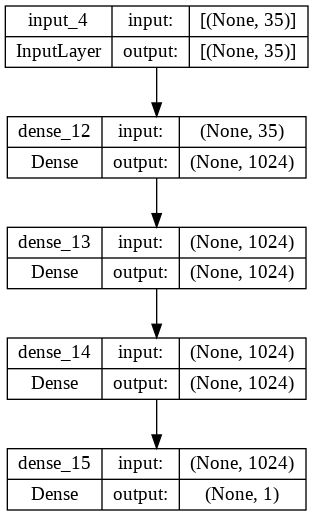

In [ ]:
plot_model(best_model,show_shapes=True, show_layer_names=True)

In [ ]:
results_best_model = best_model.evaluate(testing, labelsForTest, batch_size=32)

313/313 [==============================] - 1s 4ms/step - loss: 11.0235 - mse: 11.0235 - mae: 1.4513
